In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np

Basic Cleaning, Pre-processing and Feature Engineering Steps
Reference Link: https://www.kaggle.com/dimitreoliveira/taxi-fare-prediction-with-keras-deep-learning

In [3]:
def clean(df):
    # Delimiter lats and lons to NY only
    df = df[(-76 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72)]
    df = df[(-76 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72)]
    df = df[(38 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
    df = df[(38 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]
    # Remove possible outliers
    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]
    # Remove inconsistent values
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df
def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0
    
    
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)


def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    # Drop 'pickup_datetime' as we won't need it anymore
    df = df.drop('pickup_datetime', axis=1)
    
    return df


def add_coordinate_features(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    # Add new features
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)

    return df


def add_distances_features(df):
    # Add distances from airpot and downtown
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['euclidean'] = (df['latdiff'] ** 2 + df['londiff'] ** 2) ** 0.5
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)
    
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], lat1, lon1)
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], lat2, lon2)
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], lat1, lon1)
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], lat2, lon2)
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], lat1, lon1)
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], lat2, lon2)
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], lat1, lon1)
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], lat2, lon2)
    
    return df

def output_submission(raw_test, prediction, id_column, prediction_column, file_name):
    df = pd.DataFrame(prediction, columns=[prediction_column])
    df[id_column] = raw_test[id_column]
    df[[id_column, prediction_column]].to_csv((file_name), index=False)
    print('Output complete')
    
    
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [45]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
SUBMISSION_NAME = 'submission.csv'

# Model parameters
DATASET_SIZE = 1000000

# Load values in a more compact form which decreases the memory size of the data
datatypes = {'key': 'str', 
              'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

# Only a fraction of the whole data
train = pd.read_csv(TRAIN_PATH, nrows=DATASET_SIZE, dtype=datatypes, usecols=[1,2,3,4,5,6])
test = pd.read_csv(TEST_PATH)

train = clean(train)


In [46]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,2009-06-15 17:26:21 UTC,-73.844315,40.721317,-73.841614,40.712276
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005
2,5.7,2011-08-18 00:35:00 UTC,-73.982735,40.761269,-73.991241,40.750561
3,7.7,2012-04-21 04:30:42 UTC,-73.987129,40.733143,-73.991570,40.758091
4,5.3,2010-03-09 07:51:00 UTC,-73.968094,40.768009,-73.956657,40.783764


In [47]:
train = add_time_features(train)
test = add_time_features(test)

In [48]:
add_coordinate_features(train)
add_coordinate_features(test)

train = add_distances_features(train)
test = add_distances_features(test)

train.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,month,day,hour,weekday,...,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
0,4.5,-73.844315,40.721317,-73.841614,40.712276,2009,6,15,17,0,...,0.009436,0.011742,0.169220,0.166664,0.139248,0.127506,0.362007,0.355667,0.074371,0.086113
1,16.9,-74.016045,40.711304,-73.979271,40.782005,2010,1,5,16,1,...,0.079693,0.107475,0.012524,0.094952,0.300964,0.334892,0.180264,0.287739,0.204739,0.121273
2,5.7,-73.982735,40.761269,-73.991241,40.750561,2011,8,18,0,3,...,0.013676,0.019215,0.070751,0.051537,0.317619,0.315418,0.263538,0.244324,0.121464,0.140678
3,7.7,-73.987129,40.733143,-73.991570,40.758091,2012,4,21,4,5,...,0.025340,0.029388,0.038231,0.058739,0.293888,0.323277,0.231018,0.251526,0.153984,0.133476
4,5.3,-73.968094,40.768009,-73.956657,40.783764,2010,3,9,7,1,...,0.019468,0.027191,0.092133,0.119324,0.309719,0.314037,0.284920,0.312111,0.100082,0.100418


In [107]:
train.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'year', 'month', 'day', 'hour',
       'weekday', 'night', 'late_night', 'latdiff', 'londiff', 'euclidean',
       'manhattan', 'downtown_pickup_distance', 'downtown_dropoff_distance',
       'jfk_pickup_distance', 'jfk_dropoff_distance', 'ewr_pickup_distance',
       'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance'],
      dtype='object')

In [156]:
corr_matrix=train.corr().abs()
high_corr_var=np.where(corr_matrix>0.95)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [157]:
high_corr_var,corr_matrix.fare_amount

([('euclidean', 'manhattan'),
  ('downtown_pickup_distance', 'ewr_pickup_distance')],
 fare_amount                  1.000000
 pickup_longitude             0.391951
 pickup_latitude              0.185927
 dropoff_longitude            0.301863
 dropoff_latitude             0.155070
 year                         0.119759
 month                        0.025687
 day                          0.001382
 hour                         0.018838
 weekday                      0.002246
 night                        0.017446
 late_night                   0.015238
 latdiff                      0.013023
 londiff                      0.085704
 euclidean                    0.790697
 manhattan                    0.790245
 downtown_pickup_distance     0.320455
 downtown_dropoff_distance    0.349856
 jfk_pickup_distance          0.415568
 jfk_dropoff_distance         0.322770
 ewr_pickup_distance          0.273210
 ewr_dropoff_distance         0.210250
 lgr_pickup_distance          0.014901
 lgr_dropoff_dist

In [139]:
threshold = 0.01
target = 'fare_amount'
corr_with_target = corr_matrix[target]

In [151]:
import scipy.stats as sp
sp.spearmanr(train.weekday,train.day)

SpearmanrResult(correlation=0.007122686913595298, pvalue=2.4297703026973255e-12)

In [153]:
insignificant_features = [i for i,j in corr_with_target.iteritems() if j<threshold]

In [333]:
dropped_columns = ['pickup_longitude', 'pickup_latitude', 
                   'dropoff_longitude', 'dropoff_latitude']
#drop columns based on correlation
dropped_cols_on_corr = ['euclidean','ewr_pickup_distance']
dropped_cols_on_target = []

dropped_cols = dropped_cols_on_corr+dropped_cols_on_target
train_filt = train.drop(dropped_cols, axis=1)
test_filt = test.drop(dropped_cols + ['key', 'passenger_count'], axis=1)


In [334]:
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, Adadelta,Adamax,Adagrad
from keras.layers import BatchNormalization
from keras import regularizers
from keras.layers import Dropout
from sklearn import preprocessing
from keras.callbacks import Callback,EarlyStopping

In [335]:
X = train_filt.drop('fare_amount',1)
Y = train_filt['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(774270, 21) (774270,) (193568, 21) (193568,)


In [336]:
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(X_train)
validation_df_scaled = scaler.transform(X_test)
test_scaled = scaler.transform(test_filt)

Keras has been used for applying deep learning model.
After iterations below mentioned are the parameter for best model:
    - activity_regularizer = l1(0.01)
    - input layer activation function - Relu
    - output layer activation function - Linear
    - Optimizer: Adamax performing slightly better than Adam
    - Learning Rate  = 0.001
    - LR Decay = 0.001/200
    - loss = mse

In [347]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
model = Sequential()
model.add(Dense(128, input_dim=train_df_scaled.shape[1], activation="relu",activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(16, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(4, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1,activation = 'linear'))
#model.add(BatchNormalization())
opt = Adamax(lr=1e-3, decay=1e-3 / 200)
model.compile(loss='mse', optimizer=opt,metrics=['mse','mape'])


In [348]:
model.fit(train_df_scaled, y_train, validation_data=(validation_df_scaled, y_test),verbose=1,epochs=40, batch_size=256,callbacks=[es],shuffle=True)

Train on 774270 samples, validate on 193568 samples
Epoch 1/40


 40448/774270 [>.............................] - ETA: 12:59:26 - loss: 263.2804 - mean_squared_error: 231.7098 - mean_absolute_percentage_error: 99.66 - ETA: 4:21:04 - loss: 254.4312 - mean_squared_error: 223.7243 - mean_absolute_percentage_error: 100.28 - ETA: 2:37:12 - loss: 243.4912 - mean_squared_error: 213.4534 - mean_absolute_percentage_error: 100.17 - ETA: 1:52:42 - loss: 236.4232 - mean_squared_error: 207.0412 - mean_absolute_percentage_error: 100.07 - ETA: 1:28:03 - loss: 233.3613 - mean_squared_error: 204.6634 - mean_absolute_percentage_error: 100.08 - ETA: 1:19:28 - loss: 234.7860 - mean_squared_error: 206.4259 - mean_absolute_percentage_error: 100.15 - ETA: 1:06:28 - loss: 232.2012 - mean_squared_error: 204.4485 - mean_absolute_percentage_error: 100.15 - ETA: 57:09 - loss: 235.0283 - mean_squared_error: 207.9247 - mean_absolute_percentage_error: 100.1422 - ETA: 50:10 - loss: 237.8855 - mean_squared_error: 211.4071 - mean_absolute_percentage_error: 100.10 - ETA: 44:43 - loss

 82432/774270 [==>...........................] - ETA: 6:05 - loss: 216.8870 - mean_squared_error: 207.1679 - mean_absolute_percentage_error: 99.05 - ETA: 6:01 - loss: 216.8375 - mean_squared_error: 207.1866 - mean_absolute_percentage_error: 99.02 - ETA: 5:58 - loss: 216.4265 - mean_squared_error: 206.8420 - mean_absolute_percentage_error: 99.01 - ETA: 5:54 - loss: 216.0804 - mean_squared_error: 206.5633 - mean_absolute_percentage_error: 98.99 - ETA: 5:51 - loss: 216.1935 - mean_squared_error: 206.7411 - mean_absolute_percentage_error: 98.97 - ETA: 5:48 - loss: 217.0555 - mean_squared_error: 207.6674 - mean_absolute_percentage_error: 98.95 - ETA: 5:44 - loss: 216.9080 - mean_squared_error: 207.5814 - mean_absolute_percentage_error: 98.93 - ETA: 5:41 - loss: 217.3698 - mean_squared_error: 208.1043 - mean_absolute_percentage_error: 98.91 - ETA: 5:38 - loss: 217.2957 - mean_squared_error: 208.0891 - mean_absolute_percentage_error: 98.90 - ETA: 5:35 - loss: 216.8966 - mean_squared_error: 20

124416/774270 [===>..........................] - ETA: 3:31 - loss: 203.7203 - mean_squared_error: 197.1510 - mean_absolute_percentage_error: 97.20 - ETA: 3:30 - loss: 203.8535 - mean_squared_error: 197.3060 - mean_absolute_percentage_error: 97.17 - ETA: 3:29 - loss: 203.7739 - mean_squared_error: 197.2469 - mean_absolute_percentage_error: 97.15 - ETA: 3:28 - loss: 203.4315 - mean_squared_error: 196.9257 - mean_absolute_percentage_error: 97.12 - ETA: 3:28 - loss: 203.4044 - mean_squared_error: 196.9196 - mean_absolute_percentage_error: 97.10 - ETA: 3:27 - loss: 203.1014 - mean_squared_error: 196.6374 - mean_absolute_percentage_error: 97.07 - ETA: 3:26 - loss: 202.7833 - mean_squared_error: 196.3392 - mean_absolute_percentage_error: 97.04 - ETA: 3:25 - loss: 202.5938 - mean_squared_error: 196.1697 - mean_absolute_percentage_error: 97.02 - ETA: 3:24 - loss: 202.4731 - mean_squared_error: 196.0692 - mean_absolute_percentage_error: 96.99 - ETA: 3:23 - loss: 202.2345 - mean_squared_error: 19

167936/774270 [=====>........................] - ETA: 2:38 - loss: 191.1921 - mean_squared_error: 185.8946 - mean_absolute_percentage_error: 94.90 - ETA: 2:37 - loss: 191.1387 - mean_squared_error: 185.8525 - mean_absolute_percentage_error: 94.87 - ETA: 2:37 - loss: 190.8990 - mean_squared_error: 185.6239 - mean_absolute_percentage_error: 94.84 - ETA: 2:36 - loss: 190.7441 - mean_squared_error: 185.4803 - mean_absolute_percentage_error: 94.81 - ETA: 2:36 - loss: 190.5686 - mean_squared_error: 185.3158 - mean_absolute_percentage_error: 94.78 - ETA: 2:36 - loss: 190.4517 - mean_squared_error: 185.2097 - mean_absolute_percentage_error: 94.74 - ETA: 2:35 - loss: 190.6038 - mean_squared_error: 185.3779 - mean_absolute_percentage_error: 94.69 - ETA: 2:34 - loss: 190.3434 - mean_squared_error: 185.1280 - mean_absolute_percentage_error: 94.66 - ETA: 2:34 - loss: 190.1545 - mean_squared_error: 184.9497 - mean_absolute_percentage_error: 94.63 - ETA: 2:33 - loss: 190.0172 - mean_squared_error: 18

210432/774270 [=======>......................] - ETA: 2:06 - loss: 180.3561 - mean_squared_error: 175.8032 - mean_absolute_percentage_error: 92.16 - ETA: 2:06 - loss: 180.2365 - mean_squared_error: 175.6905 - mean_absolute_percentage_error: 92.13 - ETA: 2:05 - loss: 180.0496 - mean_squared_error: 175.5104 - mean_absolute_percentage_error: 92.10 - ETA: 2:05 - loss: 179.8562 - mean_squared_error: 175.3275 - mean_absolute_percentage_error: 92.05 - ETA: 2:05 - loss: 179.7486 - mean_squared_error: 175.2268 - mean_absolute_percentage_error: 92.02 - ETA: 2:04 - loss: 179.6088 - mean_squared_error: 175.0937 - mean_absolute_percentage_error: 91.98 - ETA: 2:04 - loss: 179.4091 - mean_squared_error: 174.9041 - mean_absolute_percentage_error: 91.94 - ETA: 2:04 - loss: 179.2386 - mean_squared_error: 174.7402 - mean_absolute_percentage_error: 91.90 - ETA: 2:03 - loss: 179.0175 - mean_squared_error: 174.5255 - mean_absolute_percentage_error: 91.87 - ETA: 2:03 - loss: 178.8498 - mean_squared_error: 17

254208/774270 [========>.....................] - ETA: 1:46 - loss: 167.7550 - mean_squared_error: 163.6756 - mean_absolute_percentage_error: 89.13 - ETA: 1:46 - loss: 167.5822 - mean_squared_error: 163.5073 - mean_absolute_percentage_error: 89.09 - ETA: 1:46 - loss: 167.3642 - mean_squared_error: 163.2962 - mean_absolute_percentage_error: 89.02 - ETA: 1:45 - loss: 167.3193 - mean_squared_error: 163.2558 - mean_absolute_percentage_error: 88.99 - ETA: 1:45 - loss: 167.1748 - mean_squared_error: 163.1159 - mean_absolute_percentage_error: 88.95 - ETA: 1:45 - loss: 166.9076 - mean_squared_error: 162.8552 - mean_absolute_percentage_error: 88.89 - ETA: 1:45 - loss: 166.7757 - mean_squared_error: 162.7279 - mean_absolute_percentage_error: 88.85 - ETA: 1:44 - loss: 166.7852 - mean_squared_error: 162.7419 - mean_absolute_percentage_error: 88.81 - ETA: 1:44 - loss: 166.6081 - mean_squared_error: 162.5691 - mean_absolute_percentage_error: 88.77 - ETA: 1:44 - loss: 166.4858 - mean_squared_error: 16

298496/774270 [==========>...................] - ETA: 1:30 - loss: 155.0399 - mean_squared_error: 151.3011 - mean_absolute_percentage_error: 85.61 - ETA: 1:30 - loss: 154.8563 - mean_squared_error: 151.1212 - mean_absolute_percentage_error: 85.56 - ETA: 1:30 - loss: 154.6874 - mean_squared_error: 150.9558 - mean_absolute_percentage_error: 85.52 - ETA: 1:30 - loss: 154.5531 - mean_squared_error: 150.8251 - mean_absolute_percentage_error: 85.48 - ETA: 1:30 - loss: 154.3853 - mean_squared_error: 150.6611 - mean_absolute_percentage_error: 85.44 - ETA: 1:30 - loss: 154.2208 - mean_squared_error: 150.5002 - mean_absolute_percentage_error: 85.39 - ETA: 1:30 - loss: 154.0390 - mean_squared_error: 150.3219 - mean_absolute_percentage_error: 85.35 - ETA: 1:29 - loss: 153.7908 - mean_squared_error: 150.0791 - mean_absolute_percentage_error: 85.28 - ETA: 1:29 - loss: 153.6411 - mean_squared_error: 149.9330 - mean_absolute_percentage_error: 85.23 - ETA: 1:29 - loss: 153.4543 - mean_squared_error: 14

342272/774270 [============>.................] - ETA: 1:18 - loss: 142.4270 - mean_squared_error: 138.9635 - mean_absolute_percentage_error: 81.65 - ETA: 1:18 - loss: 142.2743 - mean_squared_error: 138.8136 - mean_absolute_percentage_error: 81.60 - ETA: 1:18 - loss: 142.1354 - mean_squared_error: 138.6773 - mean_absolute_percentage_error: 81.55 - ETA: 1:17 - loss: 141.9101 - mean_squared_error: 138.4562 - mean_absolute_percentage_error: 81.48 - ETA: 1:17 - loss: 141.7463 - mean_squared_error: 138.2952 - mean_absolute_percentage_error: 81.43 - ETA: 1:17 - loss: 141.6200 - mean_squared_error: 138.1717 - mean_absolute_percentage_error: 81.39 - ETA: 1:17 - loss: 141.4776 - mean_squared_error: 138.0319 - mean_absolute_percentage_error: 81.34 - ETA: 1:17 - loss: 141.2833 - mean_squared_error: 137.8417 - mean_absolute_percentage_error: 81.28 - ETA: 1:17 - loss: 141.1571 - mean_squared_error: 137.7182 - mean_absolute_percentage_error: 81.23 - ETA: 1:17 - loss: 141.0073 - mean_squared_error: 13

385792/774270 [=============>................] - ETA: 1:08 - loss: 131.1725 - mean_squared_error: 127.9210 - mean_absolute_percentage_error: 77.49 - ETA: 1:07 - loss: 131.0206 - mean_squared_error: 127.7713 - mean_absolute_percentage_error: 77.44 - ETA: 1:07 - loss: 130.8902 - mean_squared_error: 127.6430 - mean_absolute_percentage_error: 77.40 - ETA: 1:07 - loss: 130.7568 - mean_squared_error: 127.5118 - mean_absolute_percentage_error: 77.35 - ETA: 1:07 - loss: 130.6160 - mean_squared_error: 127.3732 - mean_absolute_percentage_error: 77.30 - ETA: 1:07 - loss: 130.4251 - mean_squared_error: 127.1855 - mean_absolute_percentage_error: 77.22 - ETA: 1:07 - loss: 130.2941 - mean_squared_error: 127.0566 - mean_absolute_percentage_error: 77.17 - ETA: 1:07 - loss: 130.1299 - mean_squared_error: 126.8957 - mean_absolute_percentage_error: 77.11 - ETA: 1:06 - loss: 130.0012 - mean_squared_error: 126.7691 - mean_absolute_percentage_error: 77.06 - ETA: 1:06 - loss: 129.8581 - mean_squared_error: 12

429312/774270 [===============>..............] - ETA: 59s - loss: 120.6705 - mean_squared_error: 117.5935 - mean_absolute_percentage_error: 73.197 - ETA: 59s - loss: 120.5627 - mean_squared_error: 117.4875 - mean_absolute_percentage_error: 73.144 - ETA: 58s - loss: 120.4701 - mean_squared_error: 117.3969 - mean_absolute_percentage_error: 73.093 - ETA: 58s - loss: 120.3443 - mean_squared_error: 117.2730 - mean_absolute_percentage_error: 73.044 - ETA: 58s - loss: 120.2326 - mean_squared_error: 117.1632 - mean_absolute_percentage_error: 72.998 - ETA: 58s - loss: 120.1024 - mean_squared_error: 117.0350 - mean_absolute_percentage_error: 72.947 - ETA: 58s - loss: 119.9916 - mean_squared_error: 116.9260 - mean_absolute_percentage_error: 72.896 - ETA: 58s - loss: 119.8320 - mean_squared_error: 116.7694 - mean_absolute_percentage_error: 72.819 - ETA: 58s - loss: 119.7810 - mean_squared_error: 116.7203 - mean_absolute_percentage_error: 72.769 - ETA: 58s - loss: 119.6199 - mean_squared_error: 116

473088/774270 [=================>............] - ETA: 50s - loss: 111.5724 - mean_squared_error: 108.6476 - mean_absolute_percentage_error: 68.937 - ETA: 50s - loss: 111.4643 - mean_squared_error: 108.5412 - mean_absolute_percentage_error: 68.886 - ETA: 50s - loss: 111.3579 - mean_squared_error: 108.4365 - mean_absolute_percentage_error: 68.971 - ETA: 50s - loss: 111.2563 - mean_squared_error: 108.3366 - mean_absolute_percentage_error: 68.927 - ETA: 50s - loss: 111.1130 - mean_squared_error: 108.1957 - mean_absolute_percentage_error: 68.849 - ETA: 50s - loss: 111.0156 - mean_squared_error: 108.1000 - mean_absolute_percentage_error: 68.804 - ETA: 50s - loss: 110.8720 - mean_squared_error: 107.9590 - mean_absolute_percentage_error: 68.732 - ETA: 50s - loss: 110.7645 - mean_squared_error: 107.8532 - mean_absolute_percentage_error: 68.681 - ETA: 50s - loss: 110.6575 - mean_squared_error: 107.7478 - mean_absolute_percentage_error: 68.631 - ETA: 49s - loss: 110.5515 - mean_squared_error: 107

517632/774270 [===================>..........] - ETA: 43s - loss: 103.6710 - mean_squared_error: 100.8781 - mean_absolute_percentage_error: 65.053 - ETA: 43s - loss: 103.5800 - mean_squared_error: 100.7886 - mean_absolute_percentage_error: 65.008 - ETA: 43s - loss: 103.4887 - mean_squared_error: 100.6987 - mean_absolute_percentage_error: 64.962 - ETA: 43s - loss: 103.3973 - mean_squared_error: 100.6088 - mean_absolute_percentage_error: 64.916 - ETA: 42s - loss: 103.3038 - mean_squared_error: 100.5169 - mean_absolute_percentage_error: 64.869 - ETA: 42s - loss: 103.1680 - mean_squared_error: 100.3831 - mean_absolute_percentage_error: 64.803 - ETA: 42s - loss: 103.0878 - mean_squared_error: 100.3044 - mean_absolute_percentage_error: 64.759 - ETA: 42s - loss: 102.9573 - mean_squared_error: 100.1761 - mean_absolute_percentage_error: 64.692 - ETA: 42s - loss: 102.8692 - mean_squared_error: 100.0894 - mean_absolute_percentage_error: 64.645 - ETA: 42s - loss: 102.7781 - mean_squared_error: 99.

562432/774270 [====================>.........] - ETA: 36s - loss: 96.8209 - mean_squared_error: 94.1502 - mean_absolute_percentage_error: 61.976 - ETA: 35s - loss: 96.7445 - mean_squared_error: 94.0751 - mean_absolute_percentage_error: 61.939 - ETA: 35s - loss: 96.6807 - mean_squared_error: 94.0127 - mean_absolute_percentage_error: 61.900 - ETA: 35s - loss: 96.5975 - mean_squared_error: 93.9308 - mean_absolute_percentage_error: 61.860 - ETA: 35s - loss: 96.5210 - mean_squared_error: 93.8556 - mean_absolute_percentage_error: 61.824 - ETA: 35s - loss: 96.4391 - mean_squared_error: 93.7750 - mean_absolute_percentage_error: 61.785 - ETA: 35s - loss: 96.3642 - mean_squared_error: 93.7014 - mean_absolute_percentage_error: 61.749 - ETA: 35s - loss: 96.2602 - mean_squared_error: 93.5994 - mean_absolute_percentage_error: 61.693 - ETA: 35s - loss: 96.1836 - mean_squared_error: 93.5241 - mean_absolute_percentage_error: 61.657 - ETA: 35s - loss: 96.0735 - mean_squared_error: 93.4159 - mean_absolut

606976/774270 [======================>.......] - ETA: 29s - loss: 90.8800 - mean_squared_error: 88.3170 - mean_absolute_percentage_error: 58.845 - ETA: 29s - loss: 90.8344 - mean_squared_error: 88.2726 - mean_absolute_percentage_error: 58.812 - ETA: 29s - loss: 90.7646 - mean_squared_error: 88.2040 - mean_absolute_percentage_error: 58.776 - ETA: 28s - loss: 90.6585 - mean_squared_error: 88.0997 - mean_absolute_percentage_error: 58.725 - ETA: 28s - loss: 90.6008 - mean_squared_error: 88.0432 - mean_absolute_percentage_error: 58.695 - ETA: 28s - loss: 90.5389 - mean_squared_error: 87.9824 - mean_absolute_percentage_error: 58.662 - ETA: 28s - loss: 90.4762 - mean_squared_error: 87.9209 - mean_absolute_percentage_error: 58.629 - ETA: 28s - loss: 90.4135 - mean_squared_error: 87.8594 - mean_absolute_percentage_error: 58.597 - ETA: 28s - loss: 90.3597 - mean_squared_error: 87.8068 - mean_absolute_percentage_error: 58.564 - ETA: 28s - loss: 90.2618 - mean_squared_error: 87.7107 - mean_absolut

651776/774270 [========================>.....] - ETA: 22s - loss: 85.9003 - mean_squared_error: 83.4339 - mean_absolute_percentage_error: 56.238 - ETA: 22s - loss: 85.8536 - mean_squared_error: 83.3882 - mean_absolute_percentage_error: 56.211 - ETA: 22s - loss: 85.7974 - mean_squared_error: 83.3331 - mean_absolute_percentage_error: 56.184 - ETA: 22s - loss: 85.7129 - mean_squared_error: 83.2501 - mean_absolute_percentage_error: 56.142 - ETA: 22s - loss: 85.6633 - mean_squared_error: 83.2015 - mean_absolute_percentage_error: 56.115 - ETA: 22s - loss: 85.6024 - mean_squared_error: 83.1417 - mean_absolute_percentage_error: 56.087 - ETA: 22s - loss: 85.5439 - mean_squared_error: 83.0841 - mean_absolute_percentage_error: 56.058 - ETA: 22s - loss: 85.4832 - mean_squared_error: 83.0246 - mean_absolute_percentage_error: 56.030 - ETA: 22s - loss: 85.3946 - mean_squared_error: 82.9375 - mean_absolute_percentage_error: 55.988 - ETA: 21s - loss: 85.3329 - mean_squared_error: 82.8769 - mean_absolut

697088/774270 [==========================>...] - ETA: 16s - loss: 81.4743 - mean_squared_error: 79.0931 - mean_absolute_percentage_error: 53.985 - ETA: 16s - loss: 81.4313 - mean_squared_error: 79.0510 - mean_absolute_percentage_error: 53.962 - ETA: 16s - loss: 81.3808 - mean_squared_error: 79.0020 - mean_absolute_percentage_error: 53.926 - ETA: 16s - loss: 81.3408 - mean_squared_error: 78.9629 - mean_absolute_percentage_error: 53.901 - ETA: 16s - loss: 81.2885 - mean_squared_error: 78.9115 - mean_absolute_percentage_error: 53.876 - ETA: 15s - loss: 81.2378 - mean_squared_error: 78.8618 - mean_absolute_percentage_error: 53.853 - ETA: 15s - loss: 81.1667 - mean_squared_error: 78.7920 - mean_absolute_percentage_error: 53.818 - ETA: 15s - loss: 81.1216 - mean_squared_error: 78.7478 - mean_absolute_percentage_error: 53.795 - ETA: 15s - loss: 81.0687 - mean_squared_error: 78.6959 - mean_absolute_percentage_error: 53.770 - ETA: 15s - loss: 81.0142 - mean_squared_error: 78.6423 - mean_absolut

743680/774270 [===========================>..] - ETA: 10s - loss: 77.6950 - mean_squared_error: 75.3946 - mean_absolute_percentage_error: 52.099 - ETA: 10s - loss: 77.6522 - mean_squared_error: 75.3527 - mean_absolute_percentage_error: 52.078 - ETA: 9s - loss: 77.5847 - mean_squared_error: 75.2865 - mean_absolute_percentage_error: 52.047 - ETA: 9s - loss: 77.5396 - mean_squared_error: 75.2423 - mean_absolute_percentage_error: 52.02 - ETA: 9s - loss: 77.5026 - mean_squared_error: 75.2061 - mean_absolute_percentage_error: 52.00 - ETA: 9s - loss: 77.4354 - mean_squared_error: 75.1403 - mean_absolute_percentage_error: 51.97 - ETA: 9s - loss: 77.3908 - mean_squared_error: 75.0965 - mean_absolute_percentage_error: 51.95 - ETA: 9s - loss: 77.3461 - mean_squared_error: 75.0527 - mean_absolute_percentage_error: 51.93 - ETA: 9s - loss: 77.3028 - mean_squared_error: 75.0104 - mean_absolute_percentage_error: 51.91 - ETA: 9s - loss: 77.2459 - mean_squared_error: 74.9547 - mean_absolute_percentage_e

774270/774270 [==============================] - ETA: 3s - loss: 74.1423 - mean_squared_error: 71.9175 - mean_absolute_percentage_error: 50.34 - ETA: 3s - loss: 74.1069 - mean_squared_error: 71.8829 - mean_absolute_percentage_error: 50.32 - ETA: 3s - loss: 74.0716 - mean_squared_error: 71.8485 - mean_absolute_percentage_error: 50.30 - ETA: 3s - loss: 74.0300 - mean_squared_error: 71.8076 - mean_absolute_percentage_error: 50.29 - ETA: 3s - loss: 73.9711 - mean_squared_error: 71.7499 - mean_absolute_percentage_error: 50.26 - ETA: 3s - loss: 73.9385 - mean_squared_error: 71.7181 - mean_absolute_percentage_error: 50.24 - ETA: 3s - loss: 73.8804 - mean_squared_error: 71.6612 - mean_absolute_percentage_error: 50.22 - ETA: 3s - loss: 73.8418 - mean_squared_error: 71.6234 - mean_absolute_percentage_error: 50.20 - ETA: 3s - loss: 73.8023 - mean_squared_error: 71.5847 - mean_absolute_percentage_error: 50.18 - ETA: 3s - loss: 73.7645 - mean_squared_error: 71.5477 - mean_absolute_percentage_error:

 44288/774270 [>.............................] - ETA: 3:29 - loss: 17.3343 - mean_squared_error: 16.3271 - mean_absolute_percentage_error: 25.18 - ETA: 1:42 - loss: 44.3897 - mean_squared_error: 43.3741 - mean_absolute_percentage_error: 24.92 - ETA: 1:38 - loss: 35.4930 - mean_squared_error: 34.4735 - mean_absolute_percentage_error: 24.37 - ETA: 1:35 - loss: 47.0687 - mean_squared_error: 46.0525 - mean_absolute_percentage_error: 24.66 - ETA: 1:34 - loss: 41.0529 - mean_squared_error: 40.0415 - mean_absolute_percentage_error: 24.36 - ETA: 1:31 - loss: 37.2357 - mean_squared_error: 36.2224 - mean_absolute_percentage_error: 24.21 - ETA: 1:29 - loss: 34.6507 - mean_squared_error: 33.6332 - mean_absolute_percentage_error: 24.57 - ETA: 1:29 - loss: 33.7080 - mean_squared_error: 32.6892 - mean_absolute_percentage_error: 24.13 - ETA: 1:28 - loss: 31.4296 - mean_squared_error: 30.4127 - mean_absolute_percentage_error: 24.00 - ETA: 1:28 - loss: 30.3733 - mean_squared_error: 29.3581 - mean_absolu

 88576/774270 [==>...........................] - ETA: 1:20 - loss: 22.4773 - mean_squared_error: 21.4388 - mean_absolute_percentage_error: 23.84 - ETA: 1:19 - loss: 22.4394 - mean_squared_error: 21.4011 - mean_absolute_percentage_error: 23.84 - ETA: 1:19 - loss: 22.5021 - mean_squared_error: 21.4637 - mean_absolute_percentage_error: 23.85 - ETA: 1:19 - loss: 22.4169 - mean_squared_error: 21.3786 - mean_absolute_percentage_error: 23.84 - ETA: 1:19 - loss: 22.4079 - mean_squared_error: 21.3693 - mean_absolute_percentage_error: 23.81 - ETA: 1:19 - loss: 22.4953 - mean_squared_error: 21.4566 - mean_absolute_percentage_error: 23.82 - ETA: 1:19 - loss: 22.5016 - mean_squared_error: 21.4631 - mean_absolute_percentage_error: 23.84 - ETA: 1:19 - loss: 22.7305 - mean_squared_error: 21.6924 - mean_absolute_percentage_error: 23.82 - ETA: 1:19 - loss: 22.9760 - mean_squared_error: 21.9383 - mean_absolute_percentage_error: 23.84 - ETA: 1:18 - loss: 22.9193 - mean_squared_error: 21.8819 - mean_absolu

133376/774270 [====>.........................] - ETA: 1:14 - loss: 21.5452 - mean_squared_error: 20.5420 - mean_absolute_percentage_error: 23.92 - ETA: 1:14 - loss: 21.5062 - mean_squared_error: 20.5034 - mean_absolute_percentage_error: 23.91 - ETA: 1:14 - loss: 21.5261 - mean_squared_error: 20.5237 - mean_absolute_percentage_error: 23.90 - ETA: 1:14 - loss: 21.5262 - mean_squared_error: 20.5242 - mean_absolute_percentage_error: 23.89 - ETA: 1:14 - loss: 21.5768 - mean_squared_error: 20.5752 - mean_absolute_percentage_error: 23.87 - ETA: 1:14 - loss: 21.6482 - mean_squared_error: 20.6469 - mean_absolute_percentage_error: 23.87 - ETA: 1:14 - loss: 21.6232 - mean_squared_error: 20.6221 - mean_absolute_percentage_error: 23.88 - ETA: 1:14 - loss: 21.6383 - mean_squared_error: 20.6375 - mean_absolute_percentage_error: 23.89 - ETA: 1:13 - loss: 21.5956 - mean_squared_error: 20.5952 - mean_absolute_percentage_error: 23.87 - ETA: 1:13 - loss: 21.5737 - mean_squared_error: 20.5737 - mean_absolu

177920/774270 [=====>........................] - ETA: 1:09 - loss: 21.7592 - mean_squared_error: 20.7675 - mean_absolute_percentage_error: 23.79 - ETA: 1:09 - loss: 21.7526 - mean_squared_error: 20.7611 - mean_absolute_percentage_error: 23.78 - ETA: 1:09 - loss: 21.7328 - mean_squared_error: 20.7415 - mean_absolute_percentage_error: 23.77 - ETA: 1:09 - loss: 21.8424 - mean_squared_error: 20.8513 - mean_absolute_percentage_error: 23.77 - ETA: 1:09 - loss: 22.0343 - mean_squared_error: 21.0433 - mean_absolute_percentage_error: 23.76 - ETA: 1:09 - loss: 22.0246 - mean_squared_error: 21.0337 - mean_absolute_percentage_error: 23.75 - ETA: 1:09 - loss: 22.0036 - mean_squared_error: 21.0130 - mean_absolute_percentage_error: 23.74 - ETA: 1:08 - loss: 21.9646 - mean_squared_error: 20.9743 - mean_absolute_percentage_error: 23.75 - ETA: 1:08 - loss: 21.9531 - mean_squared_error: 20.9629 - mean_absolute_percentage_error: 23.75 - ETA: 1:08 - loss: 21.9198 - mean_squared_error: 20.9299 - mean_absolu

223232/774270 [=======>......................] - ETA: 1:04 - loss: 21.7289 - mean_squared_error: 20.7548 - mean_absolute_percentage_error: 23.64 - ETA: 1:04 - loss: 21.7152 - mean_squared_error: 20.7413 - mean_absolute_percentage_error: 23.64 - ETA: 1:04 - loss: 21.7723 - mean_squared_error: 20.7986 - mean_absolute_percentage_error: 23.64 - ETA: 1:04 - loss: 21.7694 - mean_squared_error: 20.7959 - mean_absolute_percentage_error: 23.64 - ETA: 1:04 - loss: 21.7527 - mean_squared_error: 20.7795 - mean_absolute_percentage_error: 23.64 - ETA: 1:04 - loss: 21.7496 - mean_squared_error: 20.7766 - mean_absolute_percentage_error: 23.64 - ETA: 1:04 - loss: 21.7393 - mean_squared_error: 20.7666 - mean_absolute_percentage_error: 23.63 - ETA: 1:04 - loss: 21.7333 - mean_squared_error: 20.7609 - mean_absolute_percentage_error: 23.64 - ETA: 1:04 - loss: 21.7662 - mean_squared_error: 20.7940 - mean_absolute_percentage_error: 23.64 - ETA: 1:04 - loss: 21.7785 - mean_squared_error: 20.8067 - mean_absolu

270592/774270 [=========>....................] - ETA: 59s - loss: 21.5581 - mean_squared_error: 20.6026 - mean_absolute_percentage_error: 23.805 - ETA: 59s - loss: 21.5553 - mean_squared_error: 20.5998 - mean_absolute_percentage_error: 23.809 - ETA: 59s - loss: 21.5856 - mean_squared_error: 20.6303 - mean_absolute_percentage_error: 23.805 - ETA: 59s - loss: 21.6024 - mean_squared_error: 20.6471 - mean_absolute_percentage_error: 23.816 - ETA: 59s - loss: 21.6077 - mean_squared_error: 20.6525 - mean_absolute_percentage_error: 23.817 - ETA: 59s - loss: 21.6060 - mean_squared_error: 20.6508 - mean_absolute_percentage_error: 23.819 - ETA: 59s - loss: 21.5971 - mean_squared_error: 20.6420 - mean_absolute_percentage_error: 23.816 - ETA: 59s - loss: 21.6362 - mean_squared_error: 20.6811 - mean_absolute_percentage_error: 23.818 - ETA: 59s - loss: 21.6239 - mean_squared_error: 20.6688 - mean_absolute_percentage_error: 23.820 - ETA: 59s - loss: 21.6180 - mean_squared_error: 20.6629 - mean_absolut

323072/774270 [===========>..................] - ETA: 54s - loss: 21.3324 - mean_squared_error: 20.3889 - mean_absolute_percentage_error: 23.731 - ETA: 54s - loss: 21.3150 - mean_squared_error: 20.3717 - mean_absolute_percentage_error: 23.725 - ETA: 53s - loss: 21.3026 - mean_squared_error: 20.3595 - mean_absolute_percentage_error: 23.726 - ETA: 53s - loss: 21.2970 - mean_squared_error: 20.3540 - mean_absolute_percentage_error: 23.720 - ETA: 53s - loss: 21.2938 - mean_squared_error: 20.3510 - mean_absolute_percentage_error: 23.714 - ETA: 53s - loss: 21.3044 - mean_squared_error: 20.3617 - mean_absolute_percentage_error: 23.719 - ETA: 53s - loss: 21.2960 - mean_squared_error: 20.3534 - mean_absolute_percentage_error: 23.721 - ETA: 53s - loss: 21.2864 - mean_squared_error: 20.3439 - mean_absolute_percentage_error: 23.720 - ETA: 53s - loss: 21.2674 - mean_squared_error: 20.3250 - mean_absolute_percentage_error: 23.720 - ETA: 53s - loss: 21.3102 - mean_squared_error: 20.3679 - mean_absolut

372224/774270 [=============>................] - ETA: 47s - loss: 21.3873 - mean_squared_error: 20.4581 - mean_absolute_percentage_error: 23.834 - ETA: 47s - loss: 21.3981 - mean_squared_error: 20.4690 - mean_absolute_percentage_error: 23.834 - ETA: 47s - loss: 21.3904 - mean_squared_error: 20.4613 - mean_absolute_percentage_error: 23.834 - ETA: 47s - loss: 21.4553 - mean_squared_error: 20.5263 - mean_absolute_percentage_error: 23.834 - ETA: 47s - loss: 21.4395 - mean_squared_error: 20.5106 - mean_absolute_percentage_error: 23.835 - ETA: 47s - loss: 21.4214 - mean_squared_error: 20.4925 - mean_absolute_percentage_error: 23.833 - ETA: 47s - loss: 21.4159 - mean_squared_error: 20.4871 - mean_absolute_percentage_error: 23.838 - ETA: 47s - loss: 21.4156 - mean_squared_error: 20.4868 - mean_absolute_percentage_error: 23.839 - ETA: 47s - loss: 21.4279 - mean_squared_error: 20.4992 - mean_absolute_percentage_error: 23.852 - ETA: 47s - loss: 21.4075 - mean_squared_error: 20.4788 - mean_absolut

416000/774270 [===============>..............] - ETA: 42s - loss: 21.1426 - mean_squared_error: 20.2256 - mean_absolute_percentage_error: 24.026 - ETA: 42s - loss: 21.1445 - mean_squared_error: 20.2277 - mean_absolute_percentage_error: 24.025 - ETA: 42s - loss: 21.1314 - mean_squared_error: 20.2148 - mean_absolute_percentage_error: 24.020 - ETA: 42s - loss: 21.1313 - mean_squared_error: 20.2148 - mean_absolute_percentage_error: 24.019 - ETA: 42s - loss: 21.1268 - mean_squared_error: 20.2105 - mean_absolute_percentage_error: 24.014 - ETA: 42s - loss: 21.1280 - mean_squared_error: 20.2119 - mean_absolute_percentage_error: 24.018 - ETA: 42s - loss: 21.1181 - mean_squared_error: 20.2022 - mean_absolute_percentage_error: 24.018 - ETA: 42s - loss: 21.1115 - mean_squared_error: 20.1958 - mean_absolute_percentage_error: 24.018 - ETA: 42s - loss: 21.1112 - mean_squared_error: 20.1958 - mean_absolute_percentage_error: 24.016 - ETA: 42s - loss: 21.1003 - mean_squared_error: 20.1851 - mean_absolut

460032/774270 [================>.............] - ETA: 38s - loss: 21.0266 - mean_squared_error: 20.1253 - mean_absolute_percentage_error: 23.936 - ETA: 38s - loss: 21.0528 - mean_squared_error: 20.1517 - mean_absolute_percentage_error: 23.937 - ETA: 38s - loss: 21.0713 - mean_squared_error: 20.1703 - mean_absolute_percentage_error: 23.940 - ETA: 38s - loss: 21.0687 - mean_squared_error: 20.1679 - mean_absolute_percentage_error: 23.936 - ETA: 38s - loss: 21.0654 - mean_squared_error: 20.1647 - mean_absolute_percentage_error: 23.939 - ETA: 38s - loss: 21.0653 - mean_squared_error: 20.1648 - mean_absolute_percentage_error: 23.936 - ETA: 38s - loss: 21.0629 - mean_squared_error: 20.1625 - mean_absolute_percentage_error: 23.935 - ETA: 38s - loss: 21.0818 - mean_squared_error: 20.1815 - mean_absolute_percentage_error: 23.934 - ETA: 37s - loss: 21.0794 - mean_squared_error: 20.1793 - mean_absolute_percentage_error: 23.936 - ETA: 37s - loss: 21.0705 - mean_squared_error: 20.1707 - mean_absolut

505088/774270 [==================>...........] - ETA: 33s - loss: 20.9618 - mean_squared_error: 20.0743 - mean_absolute_percentage_error: 23.858 - ETA: 33s - loss: 20.9621 - mean_squared_error: 20.0748 - mean_absolute_percentage_error: 23.857 - ETA: 33s - loss: 20.9620 - mean_squared_error: 20.0748 - mean_absolute_percentage_error: 23.854 - ETA: 33s - loss: 20.9494 - mean_squared_error: 20.0625 - mean_absolute_percentage_error: 23.850 - ETA: 33s - loss: 20.9398 - mean_squared_error: 20.0530 - mean_absolute_percentage_error: 23.846 - ETA: 33s - loss: 20.9565 - mean_squared_error: 20.0699 - mean_absolute_percentage_error: 23.843 - ETA: 33s - loss: 20.9456 - mean_squared_error: 20.0591 - mean_absolute_percentage_error: 23.841 - ETA: 33s - loss: 20.9528 - mean_squared_error: 20.0664 - mean_absolute_percentage_error: 23.842 - ETA: 33s - loss: 20.9493 - mean_squared_error: 20.0630 - mean_absolute_percentage_error: 23.843 - ETA: 33s - loss: 20.9596 - mean_squared_error: 20.0734 - mean_absolut

549120/774270 [====================>.........] - ETA: 28s - loss: 20.9218 - mean_squared_error: 20.0450 - mean_absolute_percentage_error: 23.764 - ETA: 28s - loss: 20.9152 - mean_squared_error: 20.0385 - mean_absolute_percentage_error: 23.761 - ETA: 28s - loss: 20.9076 - mean_squared_error: 20.0310 - mean_absolute_percentage_error: 23.758 - ETA: 28s - loss: 20.9019 - mean_squared_error: 20.0255 - mean_absolute_percentage_error: 23.757 - ETA: 28s - loss: 20.8964 - mean_squared_error: 20.0200 - mean_absolute_percentage_error: 23.757 - ETA: 28s - loss: 20.8911 - mean_squared_error: 20.0149 - mean_absolute_percentage_error: 23.756 - ETA: 28s - loss: 20.8885 - mean_squared_error: 20.0124 - mean_absolute_percentage_error: 23.756 - ETA: 28s - loss: 20.8854 - mean_squared_error: 20.0094 - mean_absolute_percentage_error: 23.755 - ETA: 28s - loss: 20.8836 - mean_squared_error: 20.0078 - mean_absolute_percentage_error: 23.755 - ETA: 28s - loss: 20.8836 - mean_squared_error: 20.0078 - mean_absolut

592640/774270 [=====================>........] - ETA: 24s - loss: 20.7971 - mean_squared_error: 19.9304 - mean_absolute_percentage_error: 23.726 - ETA: 24s - loss: 20.7856 - mean_squared_error: 19.9190 - mean_absolute_percentage_error: 23.724 - ETA: 24s - loss: 20.7778 - mean_squared_error: 19.9114 - mean_absolute_percentage_error: 23.724 - ETA: 24s - loss: 20.7796 - mean_squared_error: 19.9132 - mean_absolute_percentage_error: 23.728 - ETA: 23s - loss: 20.7969 - mean_squared_error: 19.9307 - mean_absolute_percentage_error: 23.730 - ETA: 23s - loss: 20.8173 - mean_squared_error: 19.9511 - mean_absolute_percentage_error: 23.729 - ETA: 23s - loss: 20.8165 - mean_squared_error: 19.9505 - mean_absolute_percentage_error: 23.727 - ETA: 23s - loss: 20.8257 - mean_squared_error: 19.9598 - mean_absolute_percentage_error: 23.725 - ETA: 23s - loss: 20.8280 - mean_squared_error: 19.9622 - mean_absolute_percentage_error: 23.726 - ETA: 23s - loss: 20.8631 - mean_squared_error: 19.9974 - mean_absolut

636416/774270 [=======================>......] - ETA: 19s - loss: 20.9628 - mean_squared_error: 20.1064 - mean_absolute_percentage_error: 23.681 - ETA: 19s - loss: 20.9621 - mean_squared_error: 20.1058 - mean_absolute_percentage_error: 23.680 - ETA: 19s - loss: 20.9587 - mean_squared_error: 20.1024 - mean_absolute_percentage_error: 23.682 - ETA: 19s - loss: 20.9493 - mean_squared_error: 20.0932 - mean_absolute_percentage_error: 23.681 - ETA: 19s - loss: 20.9451 - mean_squared_error: 20.0891 - mean_absolute_percentage_error: 23.681 - ETA: 19s - loss: 20.9467 - mean_squared_error: 20.0909 - mean_absolute_percentage_error: 23.681 - ETA: 19s - loss: 20.9550 - mean_squared_error: 20.0993 - mean_absolute_percentage_error: 23.682 - ETA: 19s - loss: 20.9508 - mean_squared_error: 20.0952 - mean_absolute_percentage_error: 23.681 - ETA: 19s - loss: 20.9402 - mean_squared_error: 20.0848 - mean_absolute_percentage_error: 23.680 - ETA: 19s - loss: 20.9425 - mean_squared_error: 20.0872 - mean_absolut

678912/774270 [=========================>....] - ETA: 14s - loss: 20.9498 - mean_squared_error: 20.1028 - mean_absolute_percentage_error: 23.654 - ETA: 14s - loss: 20.9505 - mean_squared_error: 20.1037 - mean_absolute_percentage_error: 23.654 - ETA: 14s - loss: 20.9552 - mean_squared_error: 20.1085 - mean_absolute_percentage_error: 23.652 - ETA: 14s - loss: 20.9483 - mean_squared_error: 20.1017 - mean_absolute_percentage_error: 23.652 - ETA: 14s - loss: 20.9416 - mean_squared_error: 20.0951 - mean_absolute_percentage_error: 23.653 - ETA: 14s - loss: 20.9369 - mean_squared_error: 20.0906 - mean_absolute_percentage_error: 23.651 - ETA: 14s - loss: 20.9366 - mean_squared_error: 20.0904 - mean_absolute_percentage_error: 23.652 - ETA: 14s - loss: 20.9325 - mean_squared_error: 20.0865 - mean_absolute_percentage_error: 23.652 - ETA: 14s - loss: 20.9297 - mean_squared_error: 20.0839 - mean_absolute_percentage_error: 23.651 - ETA: 14s - loss: 20.9292 - mean_squared_error: 20.0836 - mean_absolut

724480/774270 [===========================>..] - ETA: 10s - loss: 20.9365 - mean_squared_error: 20.1005 - mean_absolute_percentage_error: 23.633 - ETA: 10s - loss: 20.9340 - mean_squared_error: 20.0981 - mean_absolute_percentage_error: 23.631 - ETA: 10s - loss: 20.9310 - mean_squared_error: 20.0952 - mean_absolute_percentage_error: 23.628 - ETA: 10s - loss: 20.9425 - mean_squared_error: 20.1069 - mean_absolute_percentage_error: 23.627 - ETA: 10s - loss: 20.9353 - mean_squared_error: 20.0998 - mean_absolute_percentage_error: 23.629 - ETA: 9s - loss: 20.9288 - mean_squared_error: 20.0934 - mean_absolute_percentage_error: 23.628 - ETA: 9s - loss: 20.9279 - mean_squared_error: 20.0926 - mean_absolute_percentage_error: 23.62 - ETA: 9s - loss: 20.9395 - mean_squared_error: 20.1044 - mean_absolute_percentage_error: 23.62 - ETA: 9s - loss: 20.9385 - mean_squared_error: 20.1034 - mean_absolute_percentage_error: 23.62 - ETA: 9s - loss: 20.9563 - mean_squared_error: 20.1214 - mean_absolute_percen

769280/774270 [============================>.] - ETA: 5s - loss: 20.8551 - mean_squared_error: 20.0275 - mean_absolute_percentage_error: 24.04 - ETA: 5s - loss: 20.8558 - mean_squared_error: 20.0282 - mean_absolute_percentage_error: 24.04 - ETA: 5s - loss: 20.8566 - mean_squared_error: 20.0291 - mean_absolute_percentage_error: 24.04 - ETA: 5s - loss: 20.8483 - mean_squared_error: 20.0210 - mean_absolute_percentage_error: 24.04 - ETA: 5s - loss: 20.8463 - mean_squared_error: 20.0191 - mean_absolute_percentage_error: 24.04 - ETA: 5s - loss: 20.8419 - mean_squared_error: 20.0147 - mean_absolute_percentage_error: 24.04 - ETA: 5s - loss: 20.8365 - mean_squared_error: 20.0094 - mean_absolute_percentage_error: 24.04 - ETA: 4s - loss: 20.8344 - mean_squared_error: 20.0075 - mean_absolute_percentage_error: 24.04 - ETA: 4s - loss: 20.8419 - mean_squared_error: 20.0151 - mean_absolute_percentage_error: 24.04 - ETA: 4s - loss: 20.8357 - mean_squared_error: 20.0090 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 0s - loss: 20.7453 - mean_squared_error: 19.9261 - mean_absolute_percentage_error: 23.98 - ETA: 0s - loss: 20.7387 - mean_squared_error: 19.9197 - mean_absolute_percentage_error: 23.98 - ETA: 0s - loss: 20.7348 - mean_squared_error: 19.9159 - mean_absolute_percentage_error: 23.98 - ETA: 0s - loss: 20.7290 - mean_squared_error: 19.9101 - mean_absolute_percentage_error: 23.98 - ETA: 0s - loss: 20.7275 - mean_squared_error: 19.9087 - mean_absolute_percentage_error: 23.97 - ETA: 0s - loss: 20.7281 - mean_squared_error: 19.9094 - mean_absolute_percentage_error: 23.97 - ETA: 0s - loss: 20.7208 - mean_squared_error: 19.9021 - mean_absolute_percentage_error: 23.97 - ETA: 0s - loss: 20.7185 - mean_squared_error: 19.8999 - mean_absolute_percentage_error: 23.98 - 92s 119us/step - loss: 20.7147 - mean_squared_error: 19.8962 - mean_absolute_percentage_error: 23.9789 - val_loss: 20.4164 - val_mean_squared_error: 19.7051 - val_mean_absolute_percen

 42240/774270 [>.............................] - ETA: 3:07 - loss: 24.9413 - mean_squared_error: 24.2158 - mean_absolute_percentage_error: 22.57 - ETA: 1:54 - loss: 27.1971 - mean_squared_error: 26.4812 - mean_absolute_percentage_error: 21.45 - ETA: 1:40 - loss: 23.9796 - mean_squared_error: 23.2697 - mean_absolute_percentage_error: 21.69 - ETA: 1:41 - loss: 22.0508 - mean_squared_error: 21.3478 - mean_absolute_percentage_error: 22.17 - ETA: 1:38 - loss: 20.3399 - mean_squared_error: 19.6386 - mean_absolute_percentage_error: 22.55 - ETA: 1:35 - loss: 19.8672 - mean_squared_error: 19.1673 - mean_absolute_percentage_error: 22.47 - ETA: 1:33 - loss: 18.0751 - mean_squared_error: 17.3768 - mean_absolute_percentage_error: 22.12 - ETA: 1:32 - loss: 17.1413 - mean_squared_error: 16.4436 - mean_absolute_percentage_error: 22.00 - ETA: 1:30 - loss: 16.7838 - mean_squared_error: 16.0906 - mean_absolute_percentage_error: 21.93 - ETA: 1:29 - loss: 16.6724 - mean_squared_error: 15.9789 - mean_absolu

 83968/774270 [==>...........................] - ETA: 1:28 - loss: 19.0006 - mean_squared_error: 18.3525 - mean_absolute_percentage_error: 22.62 - ETA: 1:28 - loss: 18.9145 - mean_squared_error: 18.2661 - mean_absolute_percentage_error: 22.58 - ETA: 1:28 - loss: 18.8110 - mean_squared_error: 18.1625 - mean_absolute_percentage_error: 22.56 - ETA: 1:28 - loss: 18.8085 - mean_squared_error: 18.1597 - mean_absolute_percentage_error: 22.58 - ETA: 1:28 - loss: 18.8285 - mean_squared_error: 18.1796 - mean_absolute_percentage_error: 22.57 - ETA: 1:28 - loss: 18.7558 - mean_squared_error: 18.1067 - mean_absolute_percentage_error: 22.53 - ETA: 1:28 - loss: 18.7095 - mean_squared_error: 18.0603 - mean_absolute_percentage_error: 22.54 - ETA: 1:28 - loss: 18.6739 - mean_squared_error: 18.0245 - mean_absolute_percentage_error: 22.57 - ETA: 1:28 - loss: 19.0918 - mean_squared_error: 18.4423 - mean_absolute_percentage_error: 22.60 - ETA: 1:28 - loss: 19.1070 - mean_squared_error: 18.4572 - mean_absolu

128768/774270 [===>..........................] - ETA: 1:25 - loss: 21.0760 - mean_squared_error: 20.4339 - mean_absolute_percentage_error: 23.67 - ETA: 1:25 - loss: 21.0402 - mean_squared_error: 20.3982 - mean_absolute_percentage_error: 23.67 - ETA: 1:24 - loss: 21.0170 - mean_squared_error: 20.3752 - mean_absolute_percentage_error: 23.66 - ETA: 1:24 - loss: 20.9848 - mean_squared_error: 20.3431 - mean_absolute_percentage_error: 23.66 - ETA: 1:24 - loss: 20.9253 - mean_squared_error: 20.2836 - mean_absolute_percentage_error: 23.65 - ETA: 1:24 - loss: 20.9343 - mean_squared_error: 20.2927 - mean_absolute_percentage_error: 23.64 - ETA: 1:24 - loss: 20.9679 - mean_squared_error: 20.3263 - mean_absolute_percentage_error: 23.65 - ETA: 1:24 - loss: 20.9120 - mean_squared_error: 20.2703 - mean_absolute_percentage_error: 23.67 - ETA: 1:24 - loss: 20.9017 - mean_squared_error: 20.2599 - mean_absolute_percentage_error: 23.67 - ETA: 1:23 - loss: 20.9351 - mean_squared_error: 20.2934 - mean_absolu

172288/774270 [=====>........................] - ETA: 1:16 - loss: 20.7961 - mean_squared_error: 20.1536 - mean_absolute_percentage_error: 23.43 - ETA: 1:16 - loss: 20.8493 - mean_squared_error: 20.2068 - mean_absolute_percentage_error: 23.43 - ETA: 1:16 - loss: 20.8017 - mean_squared_error: 20.1591 - mean_absolute_percentage_error: 23.43 - ETA: 1:16 - loss: 20.7765 - mean_squared_error: 20.1338 - mean_absolute_percentage_error: 23.42 - ETA: 1:16 - loss: 20.7493 - mean_squared_error: 20.1067 - mean_absolute_percentage_error: 23.41 - ETA: 1:16 - loss: 20.8736 - mean_squared_error: 20.2309 - mean_absolute_percentage_error: 23.41 - ETA: 1:16 - loss: 20.8529 - mean_squared_error: 20.2102 - mean_absolute_percentage_error: 23.42 - ETA: 1:15 - loss: 20.8293 - mean_squared_error: 20.1865 - mean_absolute_percentage_error: 23.41 - ETA: 1:15 - loss: 20.8427 - mean_squared_error: 20.1999 - mean_absolute_percentage_error: 23.41 - ETA: 1:15 - loss: 20.8508 - mean_squared_error: 20.2080 - mean_absolu

216320/774270 [=======>......................] - ETA: 1:10 - loss: 20.4131 - mean_squared_error: 19.7687 - mean_absolute_percentage_error: 23.30 - ETA: 1:10 - loss: 20.4035 - mean_squared_error: 19.7591 - mean_absolute_percentage_error: 23.30 - ETA: 1:10 - loss: 20.4213 - mean_squared_error: 19.7767 - mean_absolute_percentage_error: 23.30 - ETA: 1:10 - loss: 20.3823 - mean_squared_error: 19.7376 - mean_absolute_percentage_error: 23.32 - ETA: 1:10 - loss: 20.3659 - mean_squared_error: 19.7212 - mean_absolute_percentage_error: 23.31 - ETA: 1:10 - loss: 20.3792 - mean_squared_error: 19.7344 - mean_absolute_percentage_error: 23.30 - ETA: 1:10 - loss: 20.3681 - mean_squared_error: 19.7232 - mean_absolute_percentage_error: 23.30 - ETA: 1:10 - loss: 20.3869 - mean_squared_error: 19.7420 - mean_absolute_percentage_error: 23.31 - ETA: 1:10 - loss: 20.4173 - mean_squared_error: 19.7722 - mean_absolute_percentage_error: 23.31 - ETA: 1:10 - loss: 20.3834 - mean_squared_error: 19.7382 - mean_absolu

259584/774270 [=========>....................] - ETA: 1:05 - loss: 20.4318 - mean_squared_error: 19.7835 - mean_absolute_percentage_error: 23.24 - ETA: 1:05 - loss: 20.4177 - mean_squared_error: 19.7694 - mean_absolute_percentage_error: 23.23 - ETA: 1:05 - loss: 20.3956 - mean_squared_error: 19.7473 - mean_absolute_percentage_error: 23.22 - ETA: 1:05 - loss: 20.4169 - mean_squared_error: 19.7686 - mean_absolute_percentage_error: 23.22 - ETA: 1:05 - loss: 20.3975 - mean_squared_error: 19.7491 - mean_absolute_percentage_error: 23.22 - ETA: 1:05 - loss: 20.4204 - mean_squared_error: 19.7719 - mean_absolute_percentage_error: 23.21 - ETA: 1:05 - loss: 20.4112 - mean_squared_error: 19.7628 - mean_absolute_percentage_error: 23.22 - ETA: 1:04 - loss: 20.3861 - mean_squared_error: 19.7377 - mean_absolute_percentage_error: 23.21 - ETA: 1:04 - loss: 20.3641 - mean_squared_error: 19.7155 - mean_absolute_percentage_error: 23.20 - ETA: 1:04 - loss: 20.3538 - mean_squared_error: 19.7053 - mean_absolu

302848/774270 [==========>...................] - ETA: 1:00 - loss: 20.3231 - mean_squared_error: 19.6761 - mean_absolute_percentage_error: 24.55 - ETA: 1:00 - loss: 20.3179 - mean_squared_error: 19.6708 - mean_absolute_percentage_error: 24.55 - ETA: 1:00 - loss: 20.3064 - mean_squared_error: 19.6594 - mean_absolute_percentage_error: 24.55 - ETA: 1:00 - loss: 20.3029 - mean_squared_error: 19.6559 - mean_absolute_percentage_error: 24.55 - ETA: 1:00 - loss: 20.3108 - mean_squared_error: 19.6639 - mean_absolute_percentage_error: 24.55 - ETA: 1:00 - loss: 20.3078 - mean_squared_error: 19.6609 - mean_absolute_percentage_error: 24.54 - ETA: 1:00 - loss: 20.2887 - mean_squared_error: 19.6419 - mean_absolute_percentage_error: 24.54 - ETA: 1:00 - loss: 20.2890 - mean_squared_error: 19.6422 - mean_absolute_percentage_error: 24.54 - ETA: 1:00 - loss: 20.2870 - mean_squared_error: 19.6403 - mean_absolute_percentage_error: 24.53 - ETA: 1:00 - loss: 20.2729 - mean_squared_error: 19.6264 - mean_absolu

347648/774270 [============>.................] - ETA: 55s - loss: 20.0813 - mean_squared_error: 19.4396 - mean_absolute_percentage_error: 24.280 - ETA: 55s - loss: 20.0693 - mean_squared_error: 19.4275 - mean_absolute_percentage_error: 24.276 - ETA: 55s - loss: 20.0632 - mean_squared_error: 19.4214 - mean_absolute_percentage_error: 24.272 - ETA: 55s - loss: 20.0528 - mean_squared_error: 19.4111 - mean_absolute_percentage_error: 24.268 - ETA: 54s - loss: 20.0523 - mean_squared_error: 19.4106 - mean_absolute_percentage_error: 24.266 - ETA: 54s - loss: 20.0762 - mean_squared_error: 19.4345 - mean_absolute_percentage_error: 24.264 - ETA: 54s - loss: 20.0648 - mean_squared_error: 19.4231 - mean_absolute_percentage_error: 24.259 - ETA: 54s - loss: 20.0575 - mean_squared_error: 19.4158 - mean_absolute_percentage_error: 24.255 - ETA: 54s - loss: 20.0405 - mean_squared_error: 19.3988 - mean_absolute_percentage_error: 24.249 - ETA: 54s - loss: 20.0210 - mean_squared_error: 19.3793 - mean_absolut

392192/774270 [==============>...............] - ETA: 49s - loss: 20.0065 - mean_squared_error: 19.3654 - mean_absolute_percentage_error: 24.035 - ETA: 49s - loss: 19.9959 - mean_squared_error: 19.3548 - mean_absolute_percentage_error: 24.033 - ETA: 49s - loss: 19.9913 - mean_squared_error: 19.3503 - mean_absolute_percentage_error: 24.032 - ETA: 49s - loss: 19.9864 - mean_squared_error: 19.3455 - mean_absolute_percentage_error: 24.033 - ETA: 49s - loss: 19.9895 - mean_squared_error: 19.3486 - mean_absolute_percentage_error: 24.029 - ETA: 49s - loss: 19.9896 - mean_squared_error: 19.3488 - mean_absolute_percentage_error: 24.023 - ETA: 49s - loss: 19.9793 - mean_squared_error: 19.3386 - mean_absolute_percentage_error: 24.022 - ETA: 49s - loss: 19.9702 - mean_squared_error: 19.3296 - mean_absolute_percentage_error: 24.018 - ETA: 48s - loss: 19.9600 - mean_squared_error: 19.3195 - mean_absolute_percentage_error: 24.017 - ETA: 48s - loss: 19.9522 - mean_squared_error: 19.3118 - mean_absolut

437760/774270 [===============>..............] - ETA: 43s - loss: 20.0636 - mean_squared_error: 19.4269 - mean_absolute_percentage_error: 23.885 - ETA: 43s - loss: 20.0634 - mean_squared_error: 19.4267 - mean_absolute_percentage_error: 23.882 - ETA: 43s - loss: 20.0552 - mean_squared_error: 19.4186 - mean_absolute_percentage_error: 23.878 - ETA: 43s - loss: 20.0550 - mean_squared_error: 19.4184 - mean_absolute_percentage_error: 23.873 - ETA: 43s - loss: 20.0482 - mean_squared_error: 19.4117 - mean_absolute_percentage_error: 23.870 - ETA: 43s - loss: 20.0520 - mean_squared_error: 19.4155 - mean_absolute_percentage_error: 23.870 - ETA: 43s - loss: 20.0457 - mean_squared_error: 19.4092 - mean_absolute_percentage_error: 23.865 - ETA: 43s - loss: 20.0425 - mean_squared_error: 19.4062 - mean_absolute_percentage_error: 23.862 - ETA: 43s - loss: 20.0393 - mean_squared_error: 19.4030 - mean_absolute_percentage_error: 23.860 - ETA: 43s - loss: 20.0253 - mean_squared_error: 19.3890 - mean_absolut

483072/774270 [=================>............] - ETA: 38s - loss: 20.0151 - mean_squared_error: 19.3826 - mean_absolute_percentage_error: 23.950 - ETA: 38s - loss: 20.0078 - mean_squared_error: 19.3754 - mean_absolute_percentage_error: 23.946 - ETA: 38s - loss: 20.0127 - mean_squared_error: 19.3804 - mean_absolute_percentage_error: 23.953 - ETA: 38s - loss: 20.0113 - mean_squared_error: 19.3791 - mean_absolute_percentage_error: 23.953 - ETA: 38s - loss: 20.0029 - mean_squared_error: 19.3707 - mean_absolute_percentage_error: 23.953 - ETA: 37s - loss: 19.9918 - mean_squared_error: 19.3597 - mean_absolute_percentage_error: 23.951 - ETA: 37s - loss: 19.9898 - mean_squared_error: 19.3578 - mean_absolute_percentage_error: 23.947 - ETA: 37s - loss: 19.9848 - mean_squared_error: 19.3528 - mean_absolute_percentage_error: 23.945 - ETA: 37s - loss: 19.9855 - mean_squared_error: 19.3536 - mean_absolute_percentage_error: 23.941 - ETA: 37s - loss: 20.0306 - mean_squared_error: 19.3988 - mean_absolut

527104/774270 [===================>..........] - ETA: 32s - loss: 19.9350 - mean_squared_error: 19.3053 - mean_absolute_percentage_error: 23.829 - ETA: 32s - loss: 19.9292 - mean_squared_error: 19.2996 - mean_absolute_percentage_error: 23.825 - ETA: 32s - loss: 19.9217 - mean_squared_error: 19.2920 - mean_absolute_percentage_error: 23.821 - ETA: 32s - loss: 19.9141 - mean_squared_error: 19.2844 - mean_absolute_percentage_error: 23.820 - ETA: 32s - loss: 19.9099 - mean_squared_error: 19.2803 - mean_absolute_percentage_error: 23.816 - ETA: 32s - loss: 19.9111 - mean_squared_error: 19.2815 - mean_absolute_percentage_error: 23.816 - ETA: 32s - loss: 19.9103 - mean_squared_error: 19.2807 - mean_absolute_percentage_error: 23.814 - ETA: 32s - loss: 19.9054 - mean_squared_error: 19.2758 - mean_absolute_percentage_error: 23.812 - ETA: 32s - loss: 19.9071 - mean_squared_error: 19.2776 - mean_absolute_percentage_error: 23.811 - ETA: 32s - loss: 19.8985 - mean_squared_error: 19.2690 - mean_absolut

570880/774270 [=====================>........] - ETA: 27s - loss: 19.8442 - mean_squared_error: 19.2142 - mean_absolute_percentage_error: 23.749 - ETA: 27s - loss: 19.8386 - mean_squared_error: 19.2085 - mean_absolute_percentage_error: 23.747 - ETA: 27s - loss: 19.8443 - mean_squared_error: 19.2142 - mean_absolute_percentage_error: 23.747 - ETA: 27s - loss: 19.8441 - mean_squared_error: 19.2141 - mean_absolute_percentage_error: 23.750 - ETA: 27s - loss: 19.8339 - mean_squared_error: 19.2039 - mean_absolute_percentage_error: 23.746 - ETA: 27s - loss: 19.8287 - mean_squared_error: 19.1987 - mean_absolute_percentage_error: 23.743 - ETA: 27s - loss: 19.8229 - mean_squared_error: 19.1929 - mean_absolute_percentage_error: 23.742 - ETA: 27s - loss: 19.8326 - mean_squared_error: 19.2027 - mean_absolute_percentage_error: 23.740 - ETA: 27s - loss: 19.8268 - mean_squared_error: 19.1969 - mean_absolute_percentage_error: 23.740 - ETA: 27s - loss: 19.8252 - mean_squared_error: 19.1953 - mean_absolut

615680/774270 [======================>.......] - ETA: 22s - loss: 19.6680 - mean_squared_error: 19.0406 - mean_absolute_percentage_error: 23.657 - ETA: 22s - loss: 19.6725 - mean_squared_error: 19.0452 - mean_absolute_percentage_error: 23.655 - ETA: 22s - loss: 19.6692 - mean_squared_error: 19.0420 - mean_absolute_percentage_error: 23.653 - ETA: 22s - loss: 19.6639 - mean_squared_error: 19.0367 - mean_absolute_percentage_error: 23.651 - ETA: 22s - loss: 19.6596 - mean_squared_error: 19.0325 - mean_absolute_percentage_error: 23.648 - ETA: 22s - loss: 19.6502 - mean_squared_error: 19.0232 - mean_absolute_percentage_error: 23.646 - ETA: 22s - loss: 19.6504 - mean_squared_error: 19.0235 - mean_absolute_percentage_error: 23.647 - ETA: 22s - loss: 19.6448 - mean_squared_error: 19.0179 - mean_absolute_percentage_error: 23.645 - ETA: 22s - loss: 19.6419 - mean_squared_error: 19.0152 - mean_absolute_percentage_error: 23.642 - ETA: 22s - loss: 19.6352 - mean_squared_error: 19.0085 - mean_absolut

660224/774270 [========================>.....] - ETA: 17s - loss: 19.6526 - mean_squared_error: 19.0317 - mean_absolute_percentage_error: 23.545 - ETA: 17s - loss: 19.6522 - mean_squared_error: 19.0314 - mean_absolute_percentage_error: 23.543 - ETA: 17s - loss: 19.6439 - mean_squared_error: 19.0232 - mean_absolute_percentage_error: 23.545 - ETA: 17s - loss: 19.6414 - mean_squared_error: 19.0207 - mean_absolute_percentage_error: 23.543 - ETA: 17s - loss: 19.6430 - mean_squared_error: 19.0224 - mean_absolute_percentage_error: 23.541 - ETA: 17s - loss: 19.6439 - mean_squared_error: 19.0234 - mean_absolute_percentage_error: 23.539 - ETA: 17s - loss: 19.6474 - mean_squared_error: 19.0270 - mean_absolute_percentage_error: 23.539 - ETA: 17s - loss: 19.6496 - mean_squared_error: 19.0293 - mean_absolute_percentage_error: 23.539 - ETA: 17s - loss: 19.6468 - mean_squared_error: 19.0266 - mean_absolute_percentage_error: 23.536 - ETA: 17s - loss: 19.6482 - mean_squared_error: 19.0281 - mean_absolut

703232/774270 [==========================>...] - ETA: 12s - loss: 19.5567 - mean_squared_error: 18.9398 - mean_absolute_percentage_error: 23.469 - ETA: 12s - loss: 19.5547 - mean_squared_error: 18.9379 - mean_absolute_percentage_error: 23.469 - ETA: 12s - loss: 19.5575 - mean_squared_error: 18.9407 - mean_absolute_percentage_error: 23.468 - ETA: 12s - loss: 19.5570 - mean_squared_error: 18.9402 - mean_absolute_percentage_error: 23.469 - ETA: 12s - loss: 19.5520 - mean_squared_error: 18.9353 - mean_absolute_percentage_error: 23.467 - ETA: 12s - loss: 19.5502 - mean_squared_error: 18.9336 - mean_absolute_percentage_error: 23.466 - ETA: 12s - loss: 19.5566 - mean_squared_error: 18.9400 - mean_absolute_percentage_error: 23.466 - ETA: 12s - loss: 19.5503 - mean_squared_error: 18.9337 - mean_absolute_percentage_error: 23.465 - ETA: 12s - loss: 19.5457 - mean_squared_error: 18.9291 - mean_absolute_percentage_error: 23.462 - ETA: 12s - loss: 19.5408 - mean_squared_error: 18.9242 - mean_absolut

748032/774270 [===========================>..] - ETA: 7s - loss: 19.5738 - mean_squared_error: 18.9601 - mean_absolute_percentage_error: 23.42 - ETA: 7s - loss: 19.5789 - mean_squared_error: 18.9652 - mean_absolute_percentage_error: 23.42 - ETA: 7s - loss: 19.5804 - mean_squared_error: 18.9667 - mean_absolute_percentage_error: 23.42 - ETA: 7s - loss: 19.5759 - mean_squared_error: 18.9622 - mean_absolute_percentage_error: 23.42 - ETA: 7s - loss: 19.5975 - mean_squared_error: 18.9838 - mean_absolute_percentage_error: 23.42 - ETA: 7s - loss: 19.5921 - mean_squared_error: 18.9785 - mean_absolute_percentage_error: 23.42 - ETA: 7s - loss: 19.5891 - mean_squared_error: 18.9755 - mean_absolute_percentage_error: 23.42 - ETA: 7s - loss: 19.5862 - mean_squared_error: 18.9727 - mean_absolute_percentage_error: 23.42 - ETA: 7s - loss: 19.5886 - mean_squared_error: 18.9751 - mean_absolute_percentage_error: 23.42 - ETA: 7s - loss: 19.5866 - mean_squared_error: 18.9731 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 2s - loss: 19.5522 - mean_squared_error: 18.9404 - mean_absolute_percentage_error: 23.36 - ETA: 2s - loss: 19.5480 - mean_squared_error: 18.9362 - mean_absolute_percentage_error: 23.36 - ETA: 2s - loss: 19.5458 - mean_squared_error: 18.9340 - mean_absolute_percentage_error: 23.36 - ETA: 2s - loss: 19.5443 - mean_squared_error: 18.9325 - mean_absolute_percentage_error: 23.36 - ETA: 2s - loss: 19.5504 - mean_squared_error: 18.9387 - mean_absolute_percentage_error: 23.36 - ETA: 2s - loss: 19.5448 - mean_squared_error: 18.9331 - mean_absolute_percentage_error: 23.36 - ETA: 2s - loss: 19.5482 - mean_squared_error: 18.9365 - mean_absolute_percentage_error: 23.36 - ETA: 2s - loss: 19.5462 - mean_squared_error: 18.9344 - mean_absolute_percentage_error: 23.36 - ETA: 2s - loss: 19.5503 - mean_squared_error: 18.9386 - mean_absolute_percentage_error: 23.36 - ETA: 2s - loss: 19.5460 - mean_squared_error: 18.9342 - mean_absolute_percentage_error:

 43264/774270 [>.............................] - ETA: 3:07 - loss: 9.6795 - mean_squared_error: 9.0966 - mean_absolute_percentage_error: 21.68 - ETA: 2:04 - loss: 15.8567 - mean_squared_error: 15.2693 - mean_absolute_percentage_error: 23.55 - ETA: 1:48 - loss: 19.8981 - mean_squared_error: 19.3101 - mean_absolute_percentage_error: 22.15 - ETA: 1:41 - loss: 20.3006 - mean_squared_error: 19.7160 - mean_absolute_percentage_error: 22.29 - ETA: 1:40 - loss: 21.0867 - mean_squared_error: 20.5006 - mean_absolute_percentage_error: 23.04 - ETA: 1:36 - loss: 21.6133 - mean_squared_error: 21.0276 - mean_absolute_percentage_error: 23.26 - ETA: 1:33 - loss: 21.0768 - mean_squared_error: 20.4903 - mean_absolute_percentage_error: 22.98 - ETA: 1:33 - loss: 19.6252 - mean_squared_error: 19.0380 - mean_absolute_percentage_error: 22.87 - ETA: 1:32 - loss: 18.9125 - mean_squared_error: 18.3250 - mean_absolute_percentage_error: 23.13 - ETA: 1:31 - loss: 18.4347 - mean_squared_error: 17.8458 - mean_absolute

 88832/774270 [==>...........................] - ETA: 1:22 - loss: 19.7646 - mean_squared_error: 19.1881 - mean_absolute_percentage_error: 22.37 - ETA: 1:22 - loss: 19.6904 - mean_squared_error: 19.1137 - mean_absolute_percentage_error: 22.34 - ETA: 1:21 - loss: 19.6069 - mean_squared_error: 19.0302 - mean_absolute_percentage_error: 22.37 - ETA: 1:21 - loss: 19.6401 - mean_squared_error: 19.0633 - mean_absolute_percentage_error: 22.38 - ETA: 1:21 - loss: 19.5433 - mean_squared_error: 18.9664 - mean_absolute_percentage_error: 22.42 - ETA: 1:21 - loss: 19.7344 - mean_squared_error: 19.1576 - mean_absolute_percentage_error: 22.40 - ETA: 1:21 - loss: 19.6487 - mean_squared_error: 19.0720 - mean_absolute_percentage_error: 22.40 - ETA: 1:21 - loss: 19.5917 - mean_squared_error: 19.0152 - mean_absolute_percentage_error: 22.39 - ETA: 1:20 - loss: 19.4965 - mean_squared_error: 18.9202 - mean_absolute_percentage_error: 22.34 - ETA: 1:20 - loss: 19.4755 - mean_squared_error: 18.8993 - mean_absolu

134144/774270 [====>.........................] - ETA: 1:14 - loss: 19.8450 - mean_squared_error: 19.2687 - mean_absolute_percentage_error: 22.60 - ETA: 1:13 - loss: 19.8373 - mean_squared_error: 19.2610 - mean_absolute_percentage_error: 22.60 - ETA: 1:13 - loss: 19.8069 - mean_squared_error: 19.2306 - mean_absolute_percentage_error: 22.60 - ETA: 1:13 - loss: 19.7577 - mean_squared_error: 19.1813 - mean_absolute_percentage_error: 22.60 - ETA: 1:13 - loss: 19.8187 - mean_squared_error: 19.2422 - mean_absolute_percentage_error: 22.59 - ETA: 1:13 - loss: 19.8563 - mean_squared_error: 19.2798 - mean_absolute_percentage_error: 22.61 - ETA: 1:13 - loss: 19.8395 - mean_squared_error: 19.2628 - mean_absolute_percentage_error: 22.64 - ETA: 1:13 - loss: 19.8273 - mean_squared_error: 19.2505 - mean_absolute_percentage_error: 22.65 - ETA: 1:13 - loss: 19.8035 - mean_squared_error: 19.2266 - mean_absolute_percentage_error: 22.64 - ETA: 1:13 - loss: 19.8080 - mean_squared_error: 19.2310 - mean_absolu

180480/774270 [=====>........................] - ETA: 1:08 - loss: 19.7609 - mean_squared_error: 19.1890 - mean_absolute_percentage_error: 22.55 - ETA: 1:08 - loss: 19.7222 - mean_squared_error: 19.1506 - mean_absolute_percentage_error: 22.55 - ETA: 1:08 - loss: 19.6918 - mean_squared_error: 19.1204 - mean_absolute_percentage_error: 22.55 - ETA: 1:08 - loss: 19.6808 - mean_squared_error: 19.1097 - mean_absolute_percentage_error: 22.56 - ETA: 1:08 - loss: 19.6912 - mean_squared_error: 19.1205 - mean_absolute_percentage_error: 22.56 - ETA: 1:08 - loss: 19.7042 - mean_squared_error: 19.1337 - mean_absolute_percentage_error: 22.55 - ETA: 1:08 - loss: 19.6660 - mean_squared_error: 19.0958 - mean_absolute_percentage_error: 22.56 - ETA: 1:07 - loss: 19.6339 - mean_squared_error: 19.0639 - mean_absolute_percentage_error: 22.56 - ETA: 1:07 - loss: 19.7018 - mean_squared_error: 19.1322 - mean_absolute_percentage_error: 22.56 - ETA: 1:07 - loss: 19.6731 - mean_squared_error: 19.1037 - mean_absolu

225280/774270 [=======>......................] - ETA: 1:03 - loss: 19.3066 - mean_squared_error: 18.7463 - mean_absolute_percentage_error: 22.48 - ETA: 1:03 - loss: 19.2911 - mean_squared_error: 18.7309 - mean_absolute_percentage_error: 22.49 - ETA: 1:03 - loss: 19.3034 - mean_squared_error: 18.7432 - mean_absolute_percentage_error: 22.49 - ETA: 1:03 - loss: 19.3042 - mean_squared_error: 18.7441 - mean_absolute_percentage_error: 22.49 - ETA: 1:03 - loss: 19.3191 - mean_squared_error: 18.7590 - mean_absolute_percentage_error: 22.49 - ETA: 1:03 - loss: 19.3837 - mean_squared_error: 18.8237 - mean_absolute_percentage_error: 22.50 - ETA: 1:03 - loss: 19.3995 - mean_squared_error: 18.8395 - mean_absolute_percentage_error: 22.50 - ETA: 1:03 - loss: 19.3758 - mean_squared_error: 18.8158 - mean_absolute_percentage_error: 22.50 - ETA: 1:03 - loss: 19.3745 - mean_squared_error: 18.8147 - mean_absolute_percentage_error: 22.51 - ETA: 1:03 - loss: 19.3541 - mean_squared_error: 18.7943 - mean_absolu

271360/774270 [=========>....................] - ETA: 58s - loss: 19.5292 - mean_squared_error: 18.9769 - mean_absolute_percentage_error: 22.432 - ETA: 58s - loss: 19.5175 - mean_squared_error: 18.9654 - mean_absolute_percentage_error: 22.431 - ETA: 58s - loss: 19.5191 - mean_squared_error: 18.9670 - mean_absolute_percentage_error: 22.434 - ETA: 58s - loss: 19.4954 - mean_squared_error: 18.9434 - mean_absolute_percentage_error: 22.434 - ETA: 58s - loss: 19.4966 - mean_squared_error: 18.9446 - mean_absolute_percentage_error: 22.432 - ETA: 58s - loss: 19.6056 - mean_squared_error: 19.0536 - mean_absolute_percentage_error: 22.445 - ETA: 58s - loss: 19.5986 - mean_squared_error: 19.0467 - mean_absolute_percentage_error: 23.923 - ETA: 58s - loss: 19.5788 - mean_squared_error: 19.0270 - mean_absolute_percentage_error: 23.921 - ETA: 58s - loss: 19.5812 - mean_squared_error: 19.0295 - mean_absolute_percentage_error: 23.917 - ETA: 58s - loss: 19.5906 - mean_squared_error: 19.0390 - mean_absolut

316416/774270 [===========>..................] - ETA: 53s - loss: 19.5743 - mean_squared_error: 19.0274 - mean_absolute_percentage_error: 23.868 - ETA: 53s - loss: 19.5625 - mean_squared_error: 19.0155 - mean_absolute_percentage_error: 23.864 - ETA: 53s - loss: 19.6412 - mean_squared_error: 19.0943 - mean_absolute_percentage_error: 23.863 - ETA: 53s - loss: 19.6404 - mean_squared_error: 19.0935 - mean_absolute_percentage_error: 23.862 - ETA: 53s - loss: 19.6506 - mean_squared_error: 19.1037 - mean_absolute_percentage_error: 23.870 - ETA: 53s - loss: 19.6336 - mean_squared_error: 19.0867 - mean_absolute_percentage_error: 23.865 - ETA: 53s - loss: 19.6198 - mean_squared_error: 19.0730 - mean_absolute_percentage_error: 23.863 - ETA: 53s - loss: 19.6124 - mean_squared_error: 19.0655 - mean_absolute_percentage_error: 23.864 - ETA: 53s - loss: 19.5934 - mean_squared_error: 19.0466 - mean_absolute_percentage_error: 23.854 - ETA: 53s - loss: 19.5657 - mean_squared_error: 19.0190 - mean_absolut

362496/774270 [=============>................] - ETA: 49s - loss: 19.4148 - mean_squared_error: 18.8716 - mean_absolute_percentage_error: 23.632 - ETA: 49s - loss: 19.4372 - mean_squared_error: 18.8941 - mean_absolute_percentage_error: 23.629 - ETA: 48s - loss: 19.4225 - mean_squared_error: 18.8795 - mean_absolute_percentage_error: 23.626 - ETA: 48s - loss: 19.4090 - mean_squared_error: 18.8660 - mean_absolute_percentage_error: 23.622 - ETA: 48s - loss: 19.4203 - mean_squared_error: 18.8774 - mean_absolute_percentage_error: 23.619 - ETA: 48s - loss: 19.4356 - mean_squared_error: 18.8927 - mean_absolute_percentage_error: 23.619 - ETA: 48s - loss: 19.4231 - mean_squared_error: 18.8802 - mean_absolute_percentage_error: 23.616 - ETA: 48s - loss: 19.4122 - mean_squared_error: 18.8694 - mean_absolute_percentage_error: 23.613 - ETA: 48s - loss: 19.4035 - mean_squared_error: 18.8608 - mean_absolute_percentage_error: 23.610 - ETA: 48s - loss: 19.3930 - mean_squared_error: 18.8503 - mean_absolut

407808/774270 [==============>...............] - ETA: 43s - loss: 19.3064 - mean_squared_error: 18.7650 - mean_absolute_percentage_error: 23.483 - ETA: 43s - loss: 19.3002 - mean_squared_error: 18.7589 - mean_absolute_percentage_error: 23.483 - ETA: 43s - loss: 19.2911 - mean_squared_error: 18.7497 - mean_absolute_percentage_error: 23.479 - ETA: 43s - loss: 19.2838 - mean_squared_error: 18.7424 - mean_absolute_percentage_error: 23.476 - ETA: 43s - loss: 19.2734 - mean_squared_error: 18.7320 - mean_absolute_percentage_error: 23.478 - ETA: 43s - loss: 19.2628 - mean_squared_error: 18.7214 - mean_absolute_percentage_error: 23.475 - ETA: 43s - loss: 19.2618 - mean_squared_error: 18.7203 - mean_absolute_percentage_error: 23.479 - ETA: 43s - loss: 19.2532 - mean_squared_error: 18.7117 - mean_absolute_percentage_error: 23.473 - ETA: 43s - loss: 19.2507 - mean_squared_error: 18.7093 - mean_absolute_percentage_error: 23.469 - ETA: 43s - loss: 19.2912 - mean_squared_error: 18.7498 - mean_absolut

453120/774270 [================>.............] - ETA: 39s - loss: 19.1392 - mean_squared_error: 18.5959 - mean_absolute_percentage_error: 23.364 - ETA: 39s - loss: 19.1402 - mean_squared_error: 18.5970 - mean_absolute_percentage_error: 23.360 - ETA: 38s - loss: 19.1375 - mean_squared_error: 18.5943 - mean_absolute_percentage_error: 23.359 - ETA: 38s - loss: 19.1565 - mean_squared_error: 18.6133 - mean_absolute_percentage_error: 23.355 - ETA: 38s - loss: 19.1436 - mean_squared_error: 18.6004 - mean_absolute_percentage_error: 23.353 - ETA: 38s - loss: 19.1427 - mean_squared_error: 18.5995 - mean_absolute_percentage_error: 23.357 - ETA: 38s - loss: 19.1381 - mean_squared_error: 18.5950 - mean_absolute_percentage_error: 23.359 - ETA: 38s - loss: 19.1345 - mean_squared_error: 18.5915 - mean_absolute_percentage_error: 23.357 - ETA: 38s - loss: 19.1249 - mean_squared_error: 18.5819 - mean_absolute_percentage_error: 23.354 - ETA: 38s - loss: 19.1179 - mean_squared_error: 18.5749 - mean_absolut

498944/774270 [==================>...........] - ETA: 34s - loss: 19.0267 - mean_squared_error: 18.4847 - mean_absolute_percentage_error: 23.382 - ETA: 34s - loss: 19.0390 - mean_squared_error: 18.4970 - mean_absolute_percentage_error: 23.380 - ETA: 34s - loss: 19.0351 - mean_squared_error: 18.4931 - mean_absolute_percentage_error: 23.377 - ETA: 34s - loss: 19.0226 - mean_squared_error: 18.4806 - mean_absolute_percentage_error: 23.372 - ETA: 33s - loss: 19.0165 - mean_squared_error: 18.4745 - mean_absolute_percentage_error: 23.370 - ETA: 33s - loss: 19.0166 - mean_squared_error: 18.4747 - mean_absolute_percentage_error: 23.368 - ETA: 33s - loss: 19.0073 - mean_squared_error: 18.4653 - mean_absolute_percentage_error: 23.364 - ETA: 33s - loss: 19.0055 - mean_squared_error: 18.4636 - mean_absolute_percentage_error: 23.363 - ETA: 33s - loss: 19.0012 - mean_squared_error: 18.4594 - mean_absolute_percentage_error: 23.360 - ETA: 33s - loss: 19.0043 - mean_squared_error: 18.4624 - mean_absolut

545280/774270 [====================>.........] - ETA: 29s - loss: 18.9896 - mean_squared_error: 18.4490 - mean_absolute_percentage_error: 23.294 - ETA: 29s - loss: 18.9990 - mean_squared_error: 18.4583 - mean_absolute_percentage_error: 23.293 - ETA: 29s - loss: 18.9954 - mean_squared_error: 18.4547 - mean_absolute_percentage_error: 23.290 - ETA: 29s - loss: 18.9851 - mean_squared_error: 18.4445 - mean_absolute_percentage_error: 23.289 - ETA: 28s - loss: 18.9924 - mean_squared_error: 18.4517 - mean_absolute_percentage_error: 23.289 - ETA: 28s - loss: 19.0004 - mean_squared_error: 18.4597 - mean_absolute_percentage_error: 23.285 - ETA: 28s - loss: 18.9969 - mean_squared_error: 18.4562 - mean_absolute_percentage_error: 23.285 - ETA: 28s - loss: 18.9932 - mean_squared_error: 18.4525 - mean_absolute_percentage_error: 23.285 - ETA: 28s - loss: 18.9890 - mean_squared_error: 18.4484 - mean_absolute_percentage_error: 23.284 - ETA: 28s - loss: 18.9849 - mean_squared_error: 18.4442 - mean_absolut

590336/774270 [=====================>........] - ETA: 24s - loss: 19.0094 - mean_squared_error: 18.4700 - mean_absolute_percentage_error: 23.219 - ETA: 24s - loss: 19.0055 - mean_squared_error: 18.4662 - mean_absolute_percentage_error: 23.222 - ETA: 24s - loss: 18.9949 - mean_squared_error: 18.4555 - mean_absolute_percentage_error: 23.220 - ETA: 24s - loss: 19.0108 - mean_squared_error: 18.4715 - mean_absolute_percentage_error: 23.219 - ETA: 24s - loss: 19.0076 - mean_squared_error: 18.4683 - mean_absolute_percentage_error: 23.221 - ETA: 23s - loss: 19.0360 - mean_squared_error: 18.4967 - mean_absolute_percentage_error: 23.220 - ETA: 23s - loss: 19.0397 - mean_squared_error: 18.5004 - mean_absolute_percentage_error: 23.219 - ETA: 23s - loss: 19.0538 - mean_squared_error: 18.5145 - mean_absolute_percentage_error: 23.222 - ETA: 23s - loss: 19.0633 - mean_squared_error: 18.5240 - mean_absolute_percentage_error: 23.219 - ETA: 23s - loss: 19.0550 - mean_squared_error: 18.5158 - mean_absolut

635904/774270 [=======================>......] - ETA: 19s - loss: 19.0393 - mean_squared_error: 18.5030 - mean_absolute_percentage_error: 23.163 - ETA: 19s - loss: 19.0315 - mean_squared_error: 18.4953 - mean_absolute_percentage_error: 23.162 - ETA: 19s - loss: 19.0227 - mean_squared_error: 18.4865 - mean_absolute_percentage_error: 23.161 - ETA: 19s - loss: 19.0170 - mean_squared_error: 18.4809 - mean_absolute_percentage_error: 23.160 - ETA: 19s - loss: 19.0112 - mean_squared_error: 18.4751 - mean_absolute_percentage_error: 23.162 - ETA: 19s - loss: 19.0047 - mean_squared_error: 18.4687 - mean_absolute_percentage_error: 23.160 - ETA: 19s - loss: 18.9989 - mean_squared_error: 18.4629 - mean_absolute_percentage_error: 23.160 - ETA: 19s - loss: 18.9922 - mean_squared_error: 18.4562 - mean_absolute_percentage_error: 23.157 - ETA: 18s - loss: 18.9853 - mean_squared_error: 18.4494 - mean_absolute_percentage_error: 23.158 - ETA: 18s - loss: 19.0401 - mean_squared_error: 18.5043 - mean_absolut

678912/774270 [=========================>....] - ETA: 14s - loss: 18.8790 - mean_squared_error: 18.3450 - mean_absolute_percentage_error: 23.230 - ETA: 14s - loss: 18.8920 - mean_squared_error: 18.3580 - mean_absolute_percentage_error: 23.234 - ETA: 14s - loss: 18.8919 - mean_squared_error: 18.3579 - mean_absolute_percentage_error: 23.236 - ETA: 14s - loss: 18.8992 - mean_squared_error: 18.3652 - mean_absolute_percentage_error: 23.236 - ETA: 14s - loss: 18.8973 - mean_squared_error: 18.3634 - mean_absolute_percentage_error: 23.237 - ETA: 14s - loss: 18.8998 - mean_squared_error: 18.3659 - mean_absolute_percentage_error: 23.237 - ETA: 14s - loss: 18.8978 - mean_squared_error: 18.3639 - mean_absolute_percentage_error: 23.237 - ETA: 14s - loss: 18.8927 - mean_squared_error: 18.3590 - mean_absolute_percentage_error: 23.237 - ETA: 14s - loss: 18.8888 - mean_squared_error: 18.3551 - mean_absolute_percentage_error: 23.235 - ETA: 14s - loss: 18.9198 - mean_squared_error: 18.3861 - mean_absolut

724224/774270 [===========================>..] - ETA: 10s - loss: 18.9098 - mean_squared_error: 18.3780 - mean_absolute_percentage_error: 23.158 - ETA: 10s - loss: 18.9111 - mean_squared_error: 18.3793 - mean_absolute_percentage_error: 23.161 - ETA: 9s - loss: 18.9089 - mean_squared_error: 18.3770 - mean_absolute_percentage_error: 23.163 - ETA: 9s - loss: 18.9097 - mean_squared_error: 18.3779 - mean_absolute_percentage_error: 23.16 - ETA: 9s - loss: 18.9041 - mean_squared_error: 18.3723 - mean_absolute_percentage_error: 23.16 - ETA: 9s - loss: 18.9012 - mean_squared_error: 18.3693 - mean_absolute_percentage_error: 23.16 - ETA: 9s - loss: 18.9174 - mean_squared_error: 18.3855 - mean_absolute_percentage_error: 23.16 - ETA: 9s - loss: 18.9100 - mean_squared_error: 18.3782 - mean_absolute_percentage_error: 23.16 - ETA: 9s - loss: 18.9084 - mean_squared_error: 18.3765 - mean_absolute_percentage_error: 23.16 - ETA: 9s - loss: 18.9097 - mean_squared_error: 18.3779 - mean_absolute_percentage_e

769792/774270 [============================>.] - ETA: 5s - loss: 18.7797 - mean_squared_error: 18.2493 - mean_absolute_percentage_error: 23.10 - ETA: 5s - loss: 18.7784 - mean_squared_error: 18.2481 - mean_absolute_percentage_error: 23.10 - ETA: 5s - loss: 18.7762 - mean_squared_error: 18.2459 - mean_absolute_percentage_error: 23.10 - ETA: 5s - loss: 18.7824 - mean_squared_error: 18.2520 - mean_absolute_percentage_error: 23.10 - ETA: 4s - loss: 18.7846 - mean_squared_error: 18.2543 - mean_absolute_percentage_error: 23.10 - ETA: 4s - loss: 18.7826 - mean_squared_error: 18.2522 - mean_absolute_percentage_error: 23.10 - ETA: 4s - loss: 18.7774 - mean_squared_error: 18.2470 - mean_absolute_percentage_error: 23.10 - ETA: 4s - loss: 18.7726 - mean_squared_error: 18.2422 - mean_absolute_percentage_error: 23.11 - ETA: 4s - loss: 18.7660 - mean_squared_error: 18.2356 - mean_absolute_percentage_error: 23.10 - ETA: 4s - loss: 18.7614 - mean_squared_error: 18.2309 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 0s - loss: 18.6940 - mean_squared_error: 18.1657 - mean_absolute_percentage_error: 23.05 - ETA: 0s - loss: 18.6970 - mean_squared_error: 18.1687 - mean_absolute_percentage_error: 23.05 - ETA: 0s - loss: 18.6958 - mean_squared_error: 18.1675 - mean_absolute_percentage_error: 23.05 - ETA: 0s - loss: 18.6900 - mean_squared_error: 18.1617 - mean_absolute_percentage_error: 23.05 - ETA: 0s - loss: 18.6859 - mean_squared_error: 18.1577 - mean_absolute_percentage_error: 23.05 - ETA: 0s - loss: 18.6855 - mean_squared_error: 18.1573 - mean_absolute_percentage_error: 23.04 - ETA: 0s - loss: 18.6825 - mean_squared_error: 18.1543 - mean_absolute_percentage_error: 23.04 - ETA: 0s - loss: 18.6839 - mean_squared_error: 18.1557 - mean_absolute_percentage_error: 23.04 - 89s 115us/step - loss: 18.6823 - mean_squared_error: 18.1542 - mean_absolute_percentage_error: 23.0484 - val_loss: 18.7318 - val_mean_squared_error: 18.2261 - val_mean_absolute_percen

 43776/774270 [>.............................] - ETA: 2:53 - loss: 12.1456 - mean_squared_error: 11.6410 - mean_absolute_percentage_error: 23.01 - ETA: 1:34 - loss: 16.9072 - mean_squared_error: 16.3999 - mean_absolute_percentage_error: 20.92 - ETA: 1:29 - loss: 24.7322 - mean_squared_error: 24.2260 - mean_absolute_percentage_error: 21.81 - ETA: 1:26 - loss: 22.6140 - mean_squared_error: 22.1100 - mean_absolute_percentage_error: 21.62 - ETA: 1:21 - loss: 19.9486 - mean_squared_error: 19.4452 - mean_absolute_percentage_error: 21.81 - ETA: 1:21 - loss: 22.7571 - mean_squared_error: 22.2538 - mean_absolute_percentage_error: 22.08 - ETA: 1:22 - loss: 22.3454 - mean_squared_error: 21.8428 - mean_absolute_percentage_error: 22.69 - ETA: 1:21 - loss: 20.8467 - mean_squared_error: 20.3460 - mean_absolute_percentage_error: 22.46 - ETA: 1:20 - loss: 22.1140 - mean_squared_error: 21.6145 - mean_absolute_percentage_error: 22.50 - ETA: 1:19 - loss: 21.2176 - mean_squared_error: 20.7195 - mean_absolu

 89088/774270 [==>...........................] - ETA: 1:21 - loss: 17.9060 - mean_squared_error: 17.4191 - mean_absolute_percentage_error: 21.93 - ETA: 1:21 - loss: 17.8475 - mean_squared_error: 17.3603 - mean_absolute_percentage_error: 21.98 - ETA: 1:21 - loss: 17.7579 - mean_squared_error: 17.2705 - mean_absolute_percentage_error: 21.94 - ETA: 1:21 - loss: 17.6796 - mean_squared_error: 17.1919 - mean_absolute_percentage_error: 21.92 - ETA: 1:20 - loss: 17.6177 - mean_squared_error: 17.1298 - mean_absolute_percentage_error: 21.93 - ETA: 1:20 - loss: 17.5975 - mean_squared_error: 17.1093 - mean_absolute_percentage_error: 21.95 - ETA: 1:20 - loss: 17.5656 - mean_squared_error: 17.0772 - mean_absolute_percentage_error: 21.90 - ETA: 1:20 - loss: 17.5727 - mean_squared_error: 17.0841 - mean_absolute_percentage_error: 21.88 - ETA: 1:20 - loss: 17.5526 - mean_squared_error: 17.0640 - mean_absolute_percentage_error: 21.87 - ETA: 1:20 - loss: 17.4912 - mean_squared_error: 17.0026 - mean_absolu

132864/774270 [====>.........................] - ETA: 1:14 - loss: 19.5502 - mean_squared_error: 19.0621 - mean_absolute_percentage_error: 21.98 - ETA: 1:14 - loss: 19.5364 - mean_squared_error: 19.0483 - mean_absolute_percentage_error: 21.98 - ETA: 1:14 - loss: 19.5043 - mean_squared_error: 19.0163 - mean_absolute_percentage_error: 21.97 - ETA: 1:14 - loss: 19.5009 - mean_squared_error: 19.0130 - mean_absolute_percentage_error: 21.96 - ETA: 1:14 - loss: 19.4749 - mean_squared_error: 18.9872 - mean_absolute_percentage_error: 21.96 - ETA: 1:14 - loss: 19.4378 - mean_squared_error: 18.9502 - mean_absolute_percentage_error: 21.96 - ETA: 1:14 - loss: 19.4295 - mean_squared_error: 18.9420 - mean_absolute_percentage_error: 21.97 - ETA: 1:14 - loss: 19.4247 - mean_squared_error: 18.9373 - mean_absolute_percentage_error: 22.00 - ETA: 1:14 - loss: 19.3976 - mean_squared_error: 18.9102 - mean_absolute_percentage_error: 22.01 - ETA: 1:13 - loss: 19.3281 - mean_squared_error: 18.8407 - mean_absolu

177408/774270 [=====>........................] - ETA: 1:10 - loss: 18.9200 - mean_squared_error: 18.4369 - mean_absolute_percentage_error: 22.21 - ETA: 1:09 - loss: 18.9169 - mean_squared_error: 18.4338 - mean_absolute_percentage_error: 22.22 - ETA: 1:09 - loss: 18.8844 - mean_squared_error: 18.4014 - mean_absolute_percentage_error: 22.22 - ETA: 1:09 - loss: 18.8838 - mean_squared_error: 18.4009 - mean_absolute_percentage_error: 22.23 - ETA: 1:09 - loss: 18.8650 - mean_squared_error: 18.3821 - mean_absolute_percentage_error: 22.24 - ETA: 1:09 - loss: 19.0082 - mean_squared_error: 18.5254 - mean_absolute_percentage_error: 22.24 - ETA: 1:09 - loss: 18.9870 - mean_squared_error: 18.5044 - mean_absolute_percentage_error: 22.24 - ETA: 1:09 - loss: 18.9863 - mean_squared_error: 18.5037 - mean_absolute_percentage_error: 22.24 - ETA: 1:09 - loss: 18.9538 - mean_squared_error: 18.4713 - mean_absolute_percentage_error: 22.23 - ETA: 1:09 - loss: 18.9540 - mean_squared_error: 18.4716 - mean_absolu

221696/774270 [=======>......................] - ETA: 1:04 - loss: 18.3718 - mean_squared_error: 17.8939 - mean_absolute_percentage_error: 22.28 - ETA: 1:04 - loss: 18.3653 - mean_squared_error: 17.8872 - mean_absolute_percentage_error: 22.28 - ETA: 1:04 - loss: 18.3590 - mean_squared_error: 17.8809 - mean_absolute_percentage_error: 22.27 - ETA: 1:04 - loss: 18.3538 - mean_squared_error: 17.8757 - mean_absolute_percentage_error: 22.28 - ETA: 1:04 - loss: 18.3638 - mean_squared_error: 17.8856 - mean_absolute_percentage_error: 22.27 - ETA: 1:04 - loss: 18.4520 - mean_squared_error: 17.9737 - mean_absolute_percentage_error: 22.27 - ETA: 1:04 - loss: 18.4487 - mean_squared_error: 17.9703 - mean_absolute_percentage_error: 22.27 - ETA: 1:04 - loss: 18.4201 - mean_squared_error: 17.9417 - mean_absolute_percentage_error: 22.27 - ETA: 1:04 - loss: 18.4320 - mean_squared_error: 17.9534 - mean_absolute_percentage_error: 22.27 - ETA: 1:04 - loss: 18.4231 - mean_squared_error: 17.9445 - mean_absolu

265984/774270 [=========>....................] - ETA: 59s - loss: 18.3691 - mean_squared_error: 17.8881 - mean_absolute_percentage_error: 22.219 - ETA: 59s - loss: 18.3661 - mean_squared_error: 17.8851 - mean_absolute_percentage_error: 22.216 - ETA: 59s - loss: 18.3660 - mean_squared_error: 17.8849 - mean_absolute_percentage_error: 22.219 - ETA: 59s - loss: 18.3654 - mean_squared_error: 17.8844 - mean_absolute_percentage_error: 22.225 - ETA: 59s - loss: 18.4352 - mean_squared_error: 17.9542 - mean_absolute_percentage_error: 22.228 - ETA: 59s - loss: 18.4449 - mean_squared_error: 17.9639 - mean_absolute_percentage_error: 22.228 - ETA: 59s - loss: 18.4506 - mean_squared_error: 17.9696 - mean_absolute_percentage_error: 22.236 - ETA: 59s - loss: 18.4600 - mean_squared_error: 17.9789 - mean_absolute_percentage_error: 22.238 - ETA: 59s - loss: 18.4469 - mean_squared_error: 17.9659 - mean_absolute_percentage_error: 22.239 - ETA: 59s - loss: 18.4372 - mean_squared_error: 17.9561 - mean_absolut

310272/774270 [===========>..................] - ETA: 55s - loss: 18.3409 - mean_squared_error: 17.8605 - mean_absolute_percentage_error: 22.248 - ETA: 54s - loss: 18.3629 - mean_squared_error: 17.8825 - mean_absolute_percentage_error: 22.259 - ETA: 54s - loss: 18.3369 - mean_squared_error: 17.8565 - mean_absolute_percentage_error: 22.261 - ETA: 54s - loss: 18.3242 - mean_squared_error: 17.8438 - mean_absolute_percentage_error: 22.263 - ETA: 54s - loss: 18.3128 - mean_squared_error: 17.8324 - mean_absolute_percentage_error: 22.258 - ETA: 54s - loss: 18.3759 - mean_squared_error: 17.8955 - mean_absolute_percentage_error: 22.261 - ETA: 54s - loss: 18.3669 - mean_squared_error: 17.8865 - mean_absolute_percentage_error: 22.261 - ETA: 54s - loss: 18.3501 - mean_squared_error: 17.8697 - mean_absolute_percentage_error: 22.261 - ETA: 54s - loss: 18.3397 - mean_squared_error: 17.8593 - mean_absolute_percentage_error: 22.254 - ETA: 54s - loss: 18.3452 - mean_squared_error: 17.8648 - mean_absolut

355328/774270 [============>.................] - ETA: 50s - loss: 18.6828 - mean_squared_error: 18.2005 - mean_absolute_percentage_error: 22.281 - ETA: 50s - loss: 18.6698 - mean_squared_error: 18.1875 - mean_absolute_percentage_error: 22.280 - ETA: 50s - loss: 18.6892 - mean_squared_error: 18.2069 - mean_absolute_percentage_error: 22.280 - ETA: 49s - loss: 18.6689 - mean_squared_error: 18.1865 - mean_absolute_percentage_error: 22.284 - ETA: 49s - loss: 18.6582 - mean_squared_error: 18.1757 - mean_absolute_percentage_error: 22.284 - ETA: 49s - loss: 18.6535 - mean_squared_error: 18.1710 - mean_absolute_percentage_error: 22.285 - ETA: 49s - loss: 18.6573 - mean_squared_error: 18.1748 - mean_absolute_percentage_error: 22.288 - ETA: 49s - loss: 18.6562 - mean_squared_error: 18.1736 - mean_absolute_percentage_error: 22.289 - ETA: 49s - loss: 18.6460 - mean_squared_error: 18.1634 - mean_absolute_percentage_error: 22.295 - ETA: 49s - loss: 18.6412 - mean_squared_error: 18.1586 - mean_absolut

398848/774270 [==============>...............] - ETA: 45s - loss: 18.6203 - mean_squared_error: 18.1399 - mean_absolute_percentage_error: 22.306 - ETA: 45s - loss: 18.6357 - mean_squared_error: 18.1554 - mean_absolute_percentage_error: 22.303 - ETA: 45s - loss: 18.6468 - mean_squared_error: 18.1665 - mean_absolute_percentage_error: 22.302 - ETA: 45s - loss: 18.6393 - mean_squared_error: 18.1590 - mean_absolute_percentage_error: 22.301 - ETA: 44s - loss: 18.6481 - mean_squared_error: 18.1678 - mean_absolute_percentage_error: 22.302 - ETA: 44s - loss: 18.6385 - mean_squared_error: 18.1583 - mean_absolute_percentage_error: 22.302 - ETA: 44s - loss: 18.6337 - mean_squared_error: 18.1535 - mean_absolute_percentage_error: 22.301 - ETA: 44s - loss: 18.6228 - mean_squared_error: 18.1426 - mean_absolute_percentage_error: 22.300 - ETA: 44s - loss: 18.6166 - mean_squared_error: 18.1364 - mean_absolute_percentage_error: 22.300 - ETA: 44s - loss: 18.6074 - mean_squared_error: 18.1272 - mean_absolut

442624/774270 [================>.............] - ETA: 40s - loss: 18.4501 - mean_squared_error: 17.9697 - mean_absolute_percentage_error: 22.417 - ETA: 40s - loss: 18.4512 - mean_squared_error: 17.9708 - mean_absolute_percentage_error: 22.417 - ETA: 40s - loss: 18.4509 - mean_squared_error: 17.9705 - mean_absolute_percentage_error: 22.417 - ETA: 40s - loss: 18.4579 - mean_squared_error: 17.9774 - mean_absolute_percentage_error: 22.417 - ETA: 40s - loss: 18.4549 - mean_squared_error: 17.9744 - mean_absolute_percentage_error: 22.416 - ETA: 40s - loss: 18.4586 - mean_squared_error: 17.9781 - mean_absolute_percentage_error: 22.418 - ETA: 40s - loss: 18.4486 - mean_squared_error: 17.9680 - mean_absolute_percentage_error: 22.419 - ETA: 40s - loss: 18.4450 - mean_squared_error: 17.9644 - mean_absolute_percentage_error: 22.424 - ETA: 40s - loss: 18.4468 - mean_squared_error: 17.9662 - mean_absolute_percentage_error: 22.421 - ETA: 39s - loss: 18.4366 - mean_squared_error: 17.9559 - mean_absolut

487936/774270 [=================>............] - ETA: 35s - loss: 18.3158 - mean_squared_error: 17.8360 - mean_absolute_percentage_error: 22.377 - ETA: 35s - loss: 18.3644 - mean_squared_error: 17.8846 - mean_absolute_percentage_error: 22.378 - ETA: 35s - loss: 18.3601 - mean_squared_error: 17.8804 - mean_absolute_percentage_error: 22.375 - ETA: 35s - loss: 18.3620 - mean_squared_error: 17.8823 - mean_absolute_percentage_error: 22.375 - ETA: 35s - loss: 18.3702 - mean_squared_error: 17.8906 - mean_absolute_percentage_error: 22.371 - ETA: 35s - loss: 18.3682 - mean_squared_error: 17.8886 - mean_absolute_percentage_error: 22.370 - ETA: 35s - loss: 18.3837 - mean_squared_error: 17.9041 - mean_absolute_percentage_error: 22.369 - ETA: 35s - loss: 18.4375 - mean_squared_error: 17.9580 - mean_absolute_percentage_error: 22.370 - ETA: 35s - loss: 18.4671 - mean_squared_error: 17.9876 - mean_absolute_percentage_error: 22.370 - ETA: 35s - loss: 18.4615 - mean_squared_error: 17.9820 - mean_absolut

532480/774270 [===================>..........] - ETA: 30s - loss: 18.5129 - mean_squared_error: 18.0327 - mean_absolute_percentage_error: 22.364 - ETA: 30s - loss: 18.5077 - mean_squared_error: 18.0275 - mean_absolute_percentage_error: 22.369 - ETA: 30s - loss: 18.4981 - mean_squared_error: 18.0179 - mean_absolute_percentage_error: 22.366 - ETA: 30s - loss: 18.4899 - mean_squared_error: 18.0097 - mean_absolute_percentage_error: 22.368 - ETA: 30s - loss: 18.4814 - mean_squared_error: 18.0011 - mean_absolute_percentage_error: 22.368 - ETA: 30s - loss: 18.4782 - mean_squared_error: 17.9979 - mean_absolute_percentage_error: 22.371 - ETA: 30s - loss: 18.4824 - mean_squared_error: 18.0021 - mean_absolute_percentage_error: 22.374 - ETA: 30s - loss: 18.4891 - mean_squared_error: 18.0087 - mean_absolute_percentage_error: 22.381 - ETA: 30s - loss: 18.4859 - mean_squared_error: 18.0055 - mean_absolute_percentage_error: 22.384 - ETA: 30s - loss: 18.4791 - mean_squared_error: 17.9986 - mean_absolut

577792/774270 [=====================>........] - ETA: 26s - loss: 18.4288 - mean_squared_error: 17.9482 - mean_absolute_percentage_error: 22.596 - ETA: 26s - loss: 18.4195 - mean_squared_error: 17.9389 - mean_absolute_percentage_error: 22.596 - ETA: 25s - loss: 18.4314 - mean_squared_error: 17.9508 - mean_absolute_percentage_error: 22.595 - ETA: 25s - loss: 18.4294 - mean_squared_error: 17.9489 - mean_absolute_percentage_error: 22.598 - ETA: 25s - loss: 18.4474 - mean_squared_error: 17.9669 - mean_absolute_percentage_error: 22.595 - ETA: 25s - loss: 18.4429 - mean_squared_error: 17.9624 - mean_absolute_percentage_error: 22.594 - ETA: 25s - loss: 18.4398 - mean_squared_error: 17.9593 - mean_absolute_percentage_error: 22.597 - ETA: 25s - loss: 18.4330 - mean_squared_error: 17.9525 - mean_absolute_percentage_error: 22.599 - ETA: 25s - loss: 18.4254 - mean_squared_error: 17.9450 - mean_absolute_percentage_error: 22.601 - ETA: 25s - loss: 18.4219 - mean_squared_error: 17.9415 - mean_absolut

622336/774270 [=======================>......] - ETA: 21s - loss: 18.3228 - mean_squared_error: 17.8437 - mean_absolute_percentage_error: 23.183 - ETA: 21s - loss: 18.3143 - mean_squared_error: 17.8352 - mean_absolute_percentage_error: 23.181 - ETA: 21s - loss: 18.3509 - mean_squared_error: 17.8718 - mean_absolute_percentage_error: 23.180 - ETA: 20s - loss: 18.3621 - mean_squared_error: 17.8830 - mean_absolute_percentage_error: 23.178 - ETA: 20s - loss: 18.3655 - mean_squared_error: 17.8865 - mean_absolute_percentage_error: 23.180 - ETA: 20s - loss: 18.3575 - mean_squared_error: 17.8784 - mean_absolute_percentage_error: 23.177 - ETA: 20s - loss: 18.3509 - mean_squared_error: 17.8719 - mean_absolute_percentage_error: 23.176 - ETA: 20s - loss: 18.3504 - mean_squared_error: 17.8714 - mean_absolute_percentage_error: 23.173 - ETA: 20s - loss: 18.3530 - mean_squared_error: 17.8740 - mean_absolute_percentage_error: 23.171 - ETA: 20s - loss: 18.3507 - mean_squared_error: 17.8717 - mean_absolut

667648/774270 [========================>.....] - ETA: 16s - loss: 18.3505 - mean_squared_error: 17.8720 - mean_absolute_percentage_error: 23.092 - ETA: 16s - loss: 18.3543 - mean_squared_error: 17.8758 - mean_absolute_percentage_error: 23.093 - ETA: 16s - loss: 18.4005 - mean_squared_error: 17.9220 - mean_absolute_percentage_error: 23.092 - ETA: 16s - loss: 18.4137 - mean_squared_error: 17.9352 - mean_absolute_percentage_error: 23.091 - ETA: 16s - loss: 18.4209 - mean_squared_error: 17.9424 - mean_absolute_percentage_error: 23.086 - ETA: 16s - loss: 18.4185 - mean_squared_error: 17.9401 - mean_absolute_percentage_error: 23.086 - ETA: 15s - loss: 18.4300 - mean_squared_error: 17.9515 - mean_absolute_percentage_error: 23.087 - ETA: 15s - loss: 18.4286 - mean_squared_error: 17.9501 - mean_absolute_percentage_error: 23.085 - ETA: 15s - loss: 18.4356 - mean_squared_error: 17.9571 - mean_absolute_percentage_error: 23.083 - ETA: 15s - loss: 18.4321 - mean_squared_error: 17.9536 - mean_absolut

713728/774270 [==========================>...] - ETA: 11s - loss: 18.2805 - mean_squared_error: 17.8023 - mean_absolute_percentage_error: 23.014 - ETA: 11s - loss: 18.2802 - mean_squared_error: 17.8020 - mean_absolute_percentage_error: 23.015 - ETA: 11s - loss: 18.2821 - mean_squared_error: 17.8039 - mean_absolute_percentage_error: 23.015 - ETA: 11s - loss: 18.2780 - mean_squared_error: 17.7997 - mean_absolute_percentage_error: 23.011 - ETA: 11s - loss: 18.2696 - mean_squared_error: 17.7914 - mean_absolute_percentage_error: 23.010 - ETA: 11s - loss: 18.2666 - mean_squared_error: 17.7884 - mean_absolute_percentage_error: 23.009 - ETA: 11s - loss: 18.2600 - mean_squared_error: 17.7818 - mean_absolute_percentage_error: 23.006 - ETA: 10s - loss: 18.2561 - mean_squared_error: 17.7779 - mean_absolute_percentage_error: 23.003 - ETA: 10s - loss: 18.2538 - mean_squared_error: 17.7756 - mean_absolute_percentage_error: 23.002 - ETA: 10s - loss: 18.2520 - mean_squared_error: 17.7738 - mean_absolut

759552/774270 [============================>.] - ETA: 6s - loss: 18.2431 - mean_squared_error: 17.7672 - mean_absolute_percentage_error: 22.96 - ETA: 6s - loss: 18.2401 - mean_squared_error: 17.7642 - mean_absolute_percentage_error: 22.96 - ETA: 6s - loss: 18.2571 - mean_squared_error: 17.7812 - mean_absolute_percentage_error: 22.96 - ETA: 6s - loss: 18.2519 - mean_squared_error: 17.7761 - mean_absolute_percentage_error: 22.95 - ETA: 6s - loss: 18.2482 - mean_squared_error: 17.7723 - mean_absolute_percentage_error: 22.95 - ETA: 6s - loss: 18.2509 - mean_squared_error: 17.7750 - mean_absolute_percentage_error: 22.95 - ETA: 6s - loss: 18.2442 - mean_squared_error: 17.7684 - mean_absolute_percentage_error: 22.95 - ETA: 6s - loss: 18.2516 - mean_squared_error: 17.7758 - mean_absolute_percentage_error: 22.95 - ETA: 5s - loss: 18.2531 - mean_squared_error: 17.7773 - mean_absolute_percentage_error: 22.95 - ETA: 5s - loss: 18.2546 - mean_squared_error: 17.7788 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 1s - loss: 18.2221 - mean_squared_error: 17.7463 - mean_absolute_percentage_error: 22.88 - ETA: 1s - loss: 18.2226 - mean_squared_error: 17.7469 - mean_absolute_percentage_error: 22.88 - ETA: 1s - loss: 18.2189 - mean_squared_error: 17.7431 - mean_absolute_percentage_error: 22.88 - ETA: 1s - loss: 18.2119 - mean_squared_error: 17.7362 - mean_absolute_percentage_error: 22.88 - ETA: 1s - loss: 18.2069 - mean_squared_error: 17.7311 - mean_absolute_percentage_error: 22.88 - ETA: 1s - loss: 18.2164 - mean_squared_error: 17.7407 - mean_absolute_percentage_error: 22.88 - ETA: 1s - loss: 18.2120 - mean_squared_error: 17.7363 - mean_absolute_percentage_error: 22.88 - ETA: 1s - loss: 18.2087 - mean_squared_error: 17.7330 - mean_absolute_percentage_error: 22.88 - ETA: 1s - loss: 18.2098 - mean_squared_error: 17.7341 - mean_absolute_percentage_error: 22.87 - ETA: 0s - loss: 18.2070 - mean_squared_error: 17.7313 - mean_absolute_percentage_error:

 43264/774270 [>.............................] - ETA: 3:02 - loss: 18.1186 - mean_squared_error: 17.6929 - mean_absolute_percentage_error: 20.82 - ETA: 1:54 - loss: 26.9093 - mean_squared_error: 26.4854 - mean_absolute_percentage_error: 20.70 - ETA: 1:40 - loss: 20.1336 - mean_squared_error: 19.7071 - mean_absolute_percentage_error: 21.56 - ETA: 1:28 - loss: 19.2157 - mean_squared_error: 18.7861 - mean_absolute_percentage_error: 21.20 - ETA: 1:28 - loss: 17.2688 - mean_squared_error: 16.8392 - mean_absolute_percentage_error: 20.66 - ETA: 1:27 - loss: 15.9448 - mean_squared_error: 15.5149 - mean_absolute_percentage_error: 20.68 - ETA: 1:27 - loss: 15.1608 - mean_squared_error: 14.7301 - mean_absolute_percentage_error: 20.76 - ETA: 1:26 - loss: 14.5544 - mean_squared_error: 14.1244 - mean_absolute_percentage_error: 20.70 - ETA: 1:26 - loss: 14.3310 - mean_squared_error: 13.8996 - mean_absolute_percentage_error: 20.59 - ETA: 1:23 - loss: 14.4067 - mean_squared_error: 13.9749 - mean_absolu

 87040/774270 [==>...........................] - ETA: 1:20 - loss: 19.4980 - mean_squared_error: 19.0477 - mean_absolute_percentage_error: 21.71 - ETA: 1:20 - loss: 19.4289 - mean_squared_error: 18.9786 - mean_absolute_percentage_error: 21.69 - ETA: 1:20 - loss: 19.3201 - mean_squared_error: 18.8697 - mean_absolute_percentage_error: 21.68 - ETA: 1:20 - loss: 19.2431 - mean_squared_error: 18.7926 - mean_absolute_percentage_error: 21.69 - ETA: 1:20 - loss: 19.1918 - mean_squared_error: 18.7410 - mean_absolute_percentage_error: 21.71 - ETA: 1:20 - loss: 19.1573 - mean_squared_error: 18.7063 - mean_absolute_percentage_error: 21.72 - ETA: 1:20 - loss: 19.0984 - mean_squared_error: 18.6473 - mean_absolute_percentage_error: 21.70 - ETA: 1:19 - loss: 18.9927 - mean_squared_error: 18.5412 - mean_absolute_percentage_error: 21.73 - ETA: 1:19 - loss: 18.8973 - mean_squared_error: 18.4454 - mean_absolute_percentage_error: 21.71 - ETA: 1:19 - loss: 18.8426 - mean_squared_error: 18.3904 - mean_absolu

132352/774270 [====>.........................] - ETA: 1:16 - loss: 18.4052 - mean_squared_error: 17.9536 - mean_absolute_percentage_error: 21.85 - ETA: 1:16 - loss: 18.4506 - mean_squared_error: 17.9991 - mean_absolute_percentage_error: 21.86 - ETA: 1:16 - loss: 18.4285 - mean_squared_error: 17.9768 - mean_absolute_percentage_error: 21.87 - ETA: 1:16 - loss: 18.3579 - mean_squared_error: 17.9062 - mean_absolute_percentage_error: 21.85 - ETA: 1:16 - loss: 18.3676 - mean_squared_error: 17.9159 - mean_absolute_percentage_error: 21.84 - ETA: 1:16 - loss: 18.4103 - mean_squared_error: 17.9585 - mean_absolute_percentage_error: 21.86 - ETA: 1:16 - loss: 18.4295 - mean_squared_error: 17.9776 - mean_absolute_percentage_error: 21.86 - ETA: 1:15 - loss: 18.4586 - mean_squared_error: 18.0067 - mean_absolute_percentage_error: 21.85 - ETA: 1:15 - loss: 18.4622 - mean_squared_error: 18.0103 - mean_absolute_percentage_error: 21.86 - ETA: 1:15 - loss: 18.4648 - mean_squared_error: 18.0128 - mean_absolu

176384/774270 [=====>........................] - ETA: 1:10 - loss: 17.6869 - mean_squared_error: 17.2335 - mean_absolute_percentage_error: 22.05 - ETA: 1:10 - loss: 17.6910 - mean_squared_error: 17.2377 - mean_absolute_percentage_error: 22.04 - ETA: 1:10 - loss: 17.6797 - mean_squared_error: 17.2265 - mean_absolute_percentage_error: 22.04 - ETA: 1:10 - loss: 17.6707 - mean_squared_error: 17.2175 - mean_absolute_percentage_error: 22.05 - ETA: 1:10 - loss: 17.6452 - mean_squared_error: 17.1920 - mean_absolute_percentage_error: 22.04 - ETA: 1:10 - loss: 17.6078 - mean_squared_error: 17.1546 - mean_absolute_percentage_error: 22.04 - ETA: 1:10 - loss: 17.6385 - mean_squared_error: 17.1854 - mean_absolute_percentage_error: 22.04 - ETA: 1:10 - loss: 17.6209 - mean_squared_error: 17.1678 - mean_absolute_percentage_error: 22.03 - ETA: 1:10 - loss: 17.6021 - mean_squared_error: 17.1490 - mean_absolute_percentage_error: 22.03 - ETA: 1:10 - loss: 17.6033 - mean_squared_error: 17.1502 - mean_absolu

222208/774270 [=======>......................] - ETA: 1:05 - loss: 17.3756 - mean_squared_error: 16.9256 - mean_absolute_percentage_error: 21.95 - ETA: 1:05 - loss: 17.3912 - mean_squared_error: 16.9411 - mean_absolute_percentage_error: 21.95 - ETA: 1:05 - loss: 17.3981 - mean_squared_error: 16.9481 - mean_absolute_percentage_error: 21.94 - ETA: 1:05 - loss: 17.3904 - mean_squared_error: 16.9404 - mean_absolute_percentage_error: 21.95 - ETA: 1:05 - loss: 17.3905 - mean_squared_error: 16.9405 - mean_absolute_percentage_error: 21.95 - ETA: 1:05 - loss: 17.3874 - mean_squared_error: 16.9374 - mean_absolute_percentage_error: 21.95 - ETA: 1:05 - loss: 17.4335 - mean_squared_error: 16.9835 - mean_absolute_percentage_error: 21.94 - ETA: 1:05 - loss: 17.4460 - mean_squared_error: 16.9960 - mean_absolute_percentage_error: 21.94 - ETA: 1:05 - loss: 17.4342 - mean_squared_error: 16.9843 - mean_absolute_percentage_error: 21.94 - ETA: 1:05 - loss: 17.4325 - mean_squared_error: 16.9826 - mean_absolu

265984/774270 [=========>....................] - ETA: 1:00 - loss: 17.2116 - mean_squared_error: 16.7643 - mean_absolute_percentage_error: 21.99 - ETA: 1:00 - loss: 17.2099 - mean_squared_error: 16.7626 - mean_absolute_percentage_error: 21.99 - ETA: 1:00 - loss: 17.1938 - mean_squared_error: 16.7466 - mean_absolute_percentage_error: 21.99 - ETA: 1:00 - loss: 17.1767 - mean_squared_error: 16.7295 - mean_absolute_percentage_error: 21.99 - ETA: 59s - loss: 17.2373 - mean_squared_error: 16.7901 - mean_absolute_percentage_error: 21.9924 - ETA: 59s - loss: 17.2192 - mean_squared_error: 16.7720 - mean_absolute_percentage_error: 21.992 - ETA: 59s - loss: 17.2029 - mean_squared_error: 16.7558 - mean_absolute_percentage_error: 21.986 - ETA: 59s - loss: 17.2020 - mean_squared_error: 16.7548 - mean_absolute_percentage_error: 21.986 - ETA: 59s - loss: 17.2046 - mean_squared_error: 16.7575 - mean_absolute_percentage_error: 21.986 - ETA: 59s - loss: 17.1982 - mean_squared_error: 16.7511 - mean_absolu

308992/774270 [==========>...................] - ETA: 55s - loss: 17.0924 - mean_squared_error: 16.6477 - mean_absolute_percentage_error: 22.161 - ETA: 55s - loss: 17.0932 - mean_squared_error: 16.6486 - mean_absolute_percentage_error: 22.160 - ETA: 55s - loss: 17.2176 - mean_squared_error: 16.7730 - mean_absolute_percentage_error: 22.157 - ETA: 55s - loss: 17.2085 - mean_squared_error: 16.7639 - mean_absolute_percentage_error: 22.165 - ETA: 55s - loss: 17.2161 - mean_squared_error: 16.7717 - mean_absolute_percentage_error: 22.161 - ETA: 55s - loss: 17.2308 - mean_squared_error: 16.7864 - mean_absolute_percentage_error: 22.159 - ETA: 55s - loss: 17.2301 - mean_squared_error: 16.7859 - mean_absolute_percentage_error: 22.158 - ETA: 55s - loss: 17.2170 - mean_squared_error: 16.7728 - mean_absolute_percentage_error: 22.154 - ETA: 55s - loss: 17.2110 - mean_squared_error: 16.7669 - mean_absolute_percentage_error: 22.154 - ETA: 55s - loss: 17.2032 - mean_squared_error: 16.7592 - mean_absolut

352000/774270 [============>.................] - ETA: 51s - loss: 17.1934 - mean_squared_error: 16.7540 - mean_absolute_percentage_error: 22.176 - ETA: 51s - loss: 17.1995 - mean_squared_error: 16.7602 - mean_absolute_percentage_error: 22.176 - ETA: 51s - loss: 17.1977 - mean_squared_error: 16.7584 - mean_absolute_percentage_error: 22.172 - ETA: 51s - loss: 17.2147 - mean_squared_error: 16.7755 - mean_absolute_percentage_error: 22.174 - ETA: 51s - loss: 17.2119 - mean_squared_error: 16.7728 - mean_absolute_percentage_error: 22.173 - ETA: 51s - loss: 17.1970 - mean_squared_error: 16.7579 - mean_absolute_percentage_error: 22.171 - ETA: 51s - loss: 17.1985 - mean_squared_error: 16.7594 - mean_absolute_percentage_error: 22.165 - ETA: 51s - loss: 17.1888 - mean_squared_error: 16.7497 - mean_absolute_percentage_error: 22.164 - ETA: 51s - loss: 17.1850 - mean_squared_error: 16.7460 - mean_absolute_percentage_error: 22.167 - ETA: 51s - loss: 17.2051 - mean_squared_error: 16.7662 - mean_absolut

395008/774270 [==============>...............] - ETA: 47s - loss: 17.4339 - mean_squared_error: 16.9980 - mean_absolute_percentage_error: 22.176 - ETA: 47s - loss: 17.4405 - mean_squared_error: 17.0048 - mean_absolute_percentage_error: 22.174 - ETA: 47s - loss: 17.4282 - mean_squared_error: 16.9925 - mean_absolute_percentage_error: 22.169 - ETA: 47s - loss: 17.4280 - mean_squared_error: 16.9923 - mean_absolute_percentage_error: 22.166 - ETA: 47s - loss: 17.4368 - mean_squared_error: 17.0011 - mean_absolute_percentage_error: 22.168 - ETA: 47s - loss: 17.4306 - mean_squared_error: 16.9949 - mean_absolute_percentage_error: 22.170 - ETA: 47s - loss: 17.4244 - mean_squared_error: 16.9888 - mean_absolute_percentage_error: 22.169 - ETA: 47s - loss: 17.4193 - mean_squared_error: 16.9838 - mean_absolute_percentage_error: 22.163 - ETA: 46s - loss: 17.4196 - mean_squared_error: 16.9841 - mean_absolute_percentage_error: 22.162 - ETA: 46s - loss: 17.4095 - mean_squared_error: 16.9740 - mean_absolut

438272/774270 [===============>..............] - ETA: 43s - loss: 17.3507 - mean_squared_error: 16.9172 - mean_absolute_percentage_error: 22.146 - ETA: 43s - loss: 17.3482 - mean_squared_error: 16.9147 - mean_absolute_percentage_error: 22.145 - ETA: 43s - loss: 17.3354 - mean_squared_error: 16.9019 - mean_absolute_percentage_error: 22.146 - ETA: 43s - loss: 17.3272 - mean_squared_error: 16.8937 - mean_absolute_percentage_error: 22.148 - ETA: 43s - loss: 17.3366 - mean_squared_error: 16.9032 - mean_absolute_percentage_error: 22.149 - ETA: 42s - loss: 17.3711 - mean_squared_error: 16.9376 - mean_absolute_percentage_error: 22.155 - ETA: 42s - loss: 17.3652 - mean_squared_error: 16.9318 - mean_absolute_percentage_error: 22.153 - ETA: 42s - loss: 17.3672 - mean_squared_error: 16.9338 - mean_absolute_percentage_error: 22.159 - ETA: 42s - loss: 17.3679 - mean_squared_error: 16.9346 - mean_absolute_percentage_error: 22.159 - ETA: 42s - loss: 17.3577 - mean_squared_error: 16.9244 - mean_absolut

482048/774270 [=================>............] - ETA: 38s - loss: 17.3354 - mean_squared_error: 16.9043 - mean_absolute_percentage_error: 22.102 - ETA: 38s - loss: 17.3307 - mean_squared_error: 16.8996 - mean_absolute_percentage_error: 22.108 - ETA: 38s - loss: 17.3239 - mean_squared_error: 16.8928 - mean_absolute_percentage_error: 22.112 - ETA: 38s - loss: 17.3161 - mean_squared_error: 16.8850 - mean_absolute_percentage_error: 22.111 - ETA: 38s - loss: 17.3313 - mean_squared_error: 16.9002 - mean_absolute_percentage_error: 22.111 - ETA: 38s - loss: 17.3278 - mean_squared_error: 16.8967 - mean_absolute_percentage_error: 22.111 - ETA: 37s - loss: 17.3218 - mean_squared_error: 16.8906 - mean_absolute_percentage_error: 22.113 - ETA: 37s - loss: 17.3146 - mean_squared_error: 16.8834 - mean_absolute_percentage_error: 22.116 - ETA: 37s - loss: 17.3093 - mean_squared_error: 16.8781 - mean_absolute_percentage_error: 22.116 - ETA: 37s - loss: 17.3176 - mean_squared_error: 16.8864 - mean_absolut

526592/774270 [===================>..........] - ETA: 33s - loss: 17.3840 - mean_squared_error: 16.9553 - mean_absolute_percentage_error: 22.128 - ETA: 33s - loss: 17.3827 - mean_squared_error: 16.9540 - mean_absolute_percentage_error: 22.127 - ETA: 33s - loss: 17.3823 - mean_squared_error: 16.9537 - mean_absolute_percentage_error: 22.129 - ETA: 33s - loss: 17.3748 - mean_squared_error: 16.9462 - mean_absolute_percentage_error: 22.126 - ETA: 33s - loss: 17.4893 - mean_squared_error: 17.0608 - mean_absolute_percentage_error: 22.127 - ETA: 32s - loss: 17.4949 - mean_squared_error: 17.0663 - mean_absolute_percentage_error: 22.128 - ETA: 32s - loss: 17.4945 - mean_squared_error: 17.0660 - mean_absolute_percentage_error: 22.126 - ETA: 32s - loss: 17.5057 - mean_squared_error: 17.0773 - mean_absolute_percentage_error: 22.123 - ETA: 32s - loss: 17.5234 - mean_squared_error: 17.0949 - mean_absolute_percentage_error: 22.124 - ETA: 32s - loss: 17.5227 - mean_squared_error: 17.0943 - mean_absolut

570624/774270 [=====================>........] - ETA: 28s - loss: 17.5840 - mean_squared_error: 17.1566 - mean_absolute_percentage_error: 22.145 - ETA: 27s - loss: 17.5817 - mean_squared_error: 17.1544 - mean_absolute_percentage_error: 22.143 - ETA: 27s - loss: 17.5779 - mean_squared_error: 17.1506 - mean_absolute_percentage_error: 22.143 - ETA: 27s - loss: 17.5753 - mean_squared_error: 17.1479 - mean_absolute_percentage_error: 22.144 - ETA: 27s - loss: 17.5686 - mean_squared_error: 17.1412 - mean_absolute_percentage_error: 22.143 - ETA: 27s - loss: 17.5733 - mean_squared_error: 17.1460 - mean_absolute_percentage_error: 22.144 - ETA: 27s - loss: 17.5719 - mean_squared_error: 17.1446 - mean_absolute_percentage_error: 22.141 - ETA: 27s - loss: 17.5766 - mean_squared_error: 17.1493 - mean_absolute_percentage_error: 22.144 - ETA: 27s - loss: 17.6043 - mean_squared_error: 17.1770 - mean_absolute_percentage_error: 22.143 - ETA: 27s - loss: 17.6003 - mean_squared_error: 17.1730 - mean_absolut

613888/774270 [======================>.......] - ETA: 23s - loss: 17.6609 - mean_squared_error: 17.2344 - mean_absolute_percentage_error: 22.118 - ETA: 22s - loss: 17.6541 - mean_squared_error: 17.2277 - mean_absolute_percentage_error: 22.117 - ETA: 22s - loss: 17.6495 - mean_squared_error: 17.2230 - mean_absolute_percentage_error: 22.115 - ETA: 22s - loss: 17.6465 - mean_squared_error: 17.2201 - mean_absolute_percentage_error: 22.114 - ETA: 22s - loss: 17.6584 - mean_squared_error: 17.2320 - mean_absolute_percentage_error: 22.113 - ETA: 22s - loss: 17.6600 - mean_squared_error: 17.2336 - mean_absolute_percentage_error: 22.113 - ETA: 22s - loss: 17.6545 - mean_squared_error: 17.2280 - mean_absolute_percentage_error: 22.114 - ETA: 22s - loss: 17.6512 - mean_squared_error: 17.2248 - mean_absolute_percentage_error: 22.114 - ETA: 22s - loss: 17.6463 - mean_squared_error: 17.2198 - mean_absolute_percentage_error: 22.115 - ETA: 22s - loss: 17.6465 - mean_squared_error: 17.2201 - mean_absolut

657408/774270 [========================>.....] - ETA: 18s - loss: 17.6991 - mean_squared_error: 17.2729 - mean_absolute_percentage_error: 22.112 - ETA: 18s - loss: 17.6976 - mean_squared_error: 17.2714 - mean_absolute_percentage_error: 22.115 - ETA: 18s - loss: 17.6986 - mean_squared_error: 17.2725 - mean_absolute_percentage_error: 22.118 - ETA: 17s - loss: 17.6919 - mean_squared_error: 17.2657 - mean_absolute_percentage_error: 22.120 - ETA: 17s - loss: 17.6879 - mean_squared_error: 17.2617 - mean_absolute_percentage_error: 22.119 - ETA: 17s - loss: 17.6846 - mean_squared_error: 17.2584 - mean_absolute_percentage_error: 22.120 - ETA: 17s - loss: 17.6780 - mean_squared_error: 17.2519 - mean_absolute_percentage_error: 22.122 - ETA: 17s - loss: 17.6795 - mean_squared_error: 17.2534 - mean_absolute_percentage_error: 22.121 - ETA: 17s - loss: 17.6835 - mean_squared_error: 17.2574 - mean_absolute_percentage_error: 22.122 - ETA: 17s - loss: 17.6958 - mean_squared_error: 17.2697 - mean_absolut

700928/774270 [==========================>...] - ETA: 13s - loss: 17.7229 - mean_squared_error: 17.2985 - mean_absolute_percentage_error: 22.191 - ETA: 13s - loss: 17.7205 - mean_squared_error: 17.2960 - mean_absolute_percentage_error: 22.189 - ETA: 13s - loss: 17.7200 - mean_squared_error: 17.2955 - mean_absolute_percentage_error: 22.191 - ETA: 12s - loss: 17.7452 - mean_squared_error: 17.3208 - mean_absolute_percentage_error: 22.193 - ETA: 12s - loss: 17.7397 - mean_squared_error: 17.3153 - mean_absolute_percentage_error: 22.193 - ETA: 12s - loss: 17.7343 - mean_squared_error: 17.3099 - mean_absolute_percentage_error: 22.192 - ETA: 12s - loss: 17.7307 - mean_squared_error: 17.3064 - mean_absolute_percentage_error: 22.192 - ETA: 12s - loss: 17.7249 - mean_squared_error: 17.3006 - mean_absolute_percentage_error: 22.192 - ETA: 12s - loss: 17.7242 - mean_squared_error: 17.3000 - mean_absolute_percentage_error: 22.193 - ETA: 12s - loss: 17.7251 - mean_squared_error: 17.3009 - mean_absolut

749568/774270 [============================>.] - ETA: 8s - loss: 17.7136 - mean_squared_error: 17.2900 - mean_absolute_percentage_error: 22.61 - ETA: 8s - loss: 17.7087 - mean_squared_error: 17.2851 - mean_absolute_percentage_error: 22.61 - ETA: 8s - loss: 17.7126 - mean_squared_error: 17.2890 - mean_absolute_percentage_error: 22.61 - ETA: 8s - loss: 17.7138 - mean_squared_error: 17.2902 - mean_absolute_percentage_error: 22.61 - ETA: 7s - loss: 17.7111 - mean_squared_error: 17.2874 - mean_absolute_percentage_error: 22.61 - ETA: 7s - loss: 17.7028 - mean_squared_error: 17.2792 - mean_absolute_percentage_error: 22.60 - ETA: 7s - loss: 17.7026 - mean_squared_error: 17.2790 - mean_absolute_percentage_error: 22.60 - ETA: 7s - loss: 17.6978 - mean_squared_error: 17.2742 - mean_absolute_percentage_error: 22.60 - ETA: 7s - loss: 17.6935 - mean_squared_error: 17.2699 - mean_absolute_percentage_error: 22.60 - ETA: 7s - loss: 17.6889 - mean_squared_error: 17.2653 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 2s - loss: 17.6665 - mean_squared_error: 17.2443 - mean_absolute_percentage_error: 22.67 - ETA: 2s - loss: 17.6615 - mean_squared_error: 17.2393 - mean_absolute_percentage_error: 22.67 - ETA: 2s - loss: 17.6679 - mean_squared_error: 17.2457 - mean_absolute_percentage_error: 22.67 - ETA: 2s - loss: 17.6657 - mean_squared_error: 17.2436 - mean_absolute_percentage_error: 22.67 - ETA: 2s - loss: 17.6688 - mean_squared_error: 17.2467 - mean_absolute_percentage_error: 22.67 - ETA: 2s - loss: 17.6703 - mean_squared_error: 17.2482 - mean_absolute_percentage_error: 22.67 - ETA: 2s - loss: 17.6815 - mean_squared_error: 17.2595 - mean_absolute_percentage_error: 22.67 - ETA: 2s - loss: 17.6858 - mean_squared_error: 17.2637 - mean_absolute_percentage_error: 22.67 - ETA: 2s - loss: 17.6865 - mean_squared_error: 17.2645 - mean_absolute_percentage_error: 22.67 - ETA: 2s - loss: 17.6879 - mean_squared_error: 17.2659 - mean_absolute_percentage_error:

 43008/774270 [>.............................] - ETA: 3:08 - loss: 8.6173 - mean_squared_error: 8.2440 - mean_absolute_percentage_error: 18.23 - ETA: 2:00 - loss: 13.1135 - mean_squared_error: 12.7391 - mean_absolute_percentage_error: 20.67 - ETA: 1:46 - loss: 12.9917 - mean_squared_error: 12.6170 - mean_absolute_percentage_error: 21.03 - ETA: 1:42 - loss: 14.0823 - mean_squared_error: 13.7036 - mean_absolute_percentage_error: 20.98 - ETA: 1:40 - loss: 13.2400 - mean_squared_error: 12.8599 - mean_absolute_percentage_error: 21.16 - ETA: 1:38 - loss: 14.2493 - mean_squared_error: 13.8673 - mean_absolute_percentage_error: 21.64 - ETA: 1:37 - loss: 15.8079 - mean_squared_error: 15.4235 - mean_absolute_percentage_error: 22.47 - ETA: 1:35 - loss: 15.1748 - mean_squared_error: 14.7892 - mean_absolute_percentage_error: 22.18 - ETA: 1:34 - loss: 14.6679 - mean_squared_error: 14.2807 - mean_absolute_percentage_error: 22.10 - ETA: 1:33 - loss: 15.4513 - mean_squared_error: 15.0628 - mean_absolute

 88320/774270 [==>...........................] - ETA: 1:22 - loss: 18.1145 - mean_squared_error: 17.7358 - mean_absolute_percentage_error: 22.12 - ETA: 1:21 - loss: 18.0960 - mean_squared_error: 17.7175 - mean_absolute_percentage_error: 22.14 - ETA: 1:21 - loss: 18.0391 - mean_squared_error: 17.6609 - mean_absolute_percentage_error: 22.14 - ETA: 1:21 - loss: 17.9291 - mean_squared_error: 17.5513 - mean_absolute_percentage_error: 22.12 - ETA: 1:21 - loss: 17.8732 - mean_squared_error: 17.4957 - mean_absolute_percentage_error: 22.12 - ETA: 1:21 - loss: 17.8440 - mean_squared_error: 17.4667 - mean_absolute_percentage_error: 22.12 - ETA: 1:21 - loss: 17.8630 - mean_squared_error: 17.4858 - mean_absolute_percentage_error: 22.14 - ETA: 1:21 - loss: 17.7956 - mean_squared_error: 17.4185 - mean_absolute_percentage_error: 22.13 - ETA: 1:20 - loss: 17.7452 - mean_squared_error: 17.3683 - mean_absolute_percentage_error: 22.17 - ETA: 1:20 - loss: 17.6591 - mean_squared_error: 17.2824 - mean_absolu

131584/774270 [====>.........................] - ETA: 1:14 - loss: 17.2399 - mean_squared_error: 16.8657 - mean_absolute_percentage_error: 21.98 - ETA: 1:14 - loss: 17.2595 - mean_squared_error: 16.8853 - mean_absolute_percentage_error: 21.98 - ETA: 1:14 - loss: 17.2563 - mean_squared_error: 16.8820 - mean_absolute_percentage_error: 21.99 - ETA: 1:14 - loss: 17.2294 - mean_squared_error: 16.8550 - mean_absolute_percentage_error: 22.01 - ETA: 1:14 - loss: 17.1975 - mean_squared_error: 16.8231 - mean_absolute_percentage_error: 22.01 - ETA: 1:14 - loss: 17.2140 - mean_squared_error: 16.8395 - mean_absolute_percentage_error: 22.02 - ETA: 1:14 - loss: 17.1803 - mean_squared_error: 16.8057 - mean_absolute_percentage_error: 22.04 - ETA: 1:14 - loss: 17.1272 - mean_squared_error: 16.7525 - mean_absolute_percentage_error: 22.03 - ETA: 1:14 - loss: 17.1229 - mean_squared_error: 16.7482 - mean_absolute_percentage_error: 22.03 - ETA: 1:14 - loss: 17.1592 - mean_squared_error: 16.7845 - mean_absolu

176384/774270 [=====>........................] - ETA: 1:10 - loss: 17.5110 - mean_squared_error: 17.1335 - mean_absolute_percentage_error: 22.03 - ETA: 1:10 - loss: 17.5179 - mean_squared_error: 17.1404 - mean_absolute_percentage_error: 22.04 - ETA: 1:10 - loss: 17.5678 - mean_squared_error: 17.1903 - mean_absolute_percentage_error: 22.04 - ETA: 1:10 - loss: 17.5508 - mean_squared_error: 17.1732 - mean_absolute_percentage_error: 22.05 - ETA: 1:10 - loss: 17.5743 - mean_squared_error: 17.1966 - mean_absolute_percentage_error: 22.06 - ETA: 1:10 - loss: 17.5558 - mean_squared_error: 17.1780 - mean_absolute_percentage_error: 22.05 - ETA: 1:10 - loss: 17.5232 - mean_squared_error: 17.1454 - mean_absolute_percentage_error: 22.03 - ETA: 1:10 - loss: 17.4799 - mean_squared_error: 17.1020 - mean_absolute_percentage_error: 22.04 - ETA: 1:10 - loss: 17.4491 - mean_squared_error: 17.0711 - mean_absolute_percentage_error: 22.04 - ETA: 1:10 - loss: 17.4323 - mean_squared_error: 17.0543 - mean_absolu

219904/774270 [=======>......................] - ETA: 1:05 - loss: 17.2184 - mean_squared_error: 16.8391 - mean_absolute_percentage_error: 22.02 - ETA: 1:05 - loss: 17.2058 - mean_squared_error: 16.8264 - mean_absolute_percentage_error: 22.02 - ETA: 1:05 - loss: 17.2267 - mean_squared_error: 16.8473 - mean_absolute_percentage_error: 22.02 - ETA: 1:04 - loss: 17.2126 - mean_squared_error: 16.8331 - mean_absolute_percentage_error: 22.03 - ETA: 1:04 - loss: 17.2164 - mean_squared_error: 16.8370 - mean_absolute_percentage_error: 22.02 - ETA: 1:04 - loss: 17.2250 - mean_squared_error: 16.8456 - mean_absolute_percentage_error: 22.02 - ETA: 1:04 - loss: 17.2265 - mean_squared_error: 16.8472 - mean_absolute_percentage_error: 22.02 - ETA: 1:04 - loss: 17.2101 - mean_squared_error: 16.8308 - mean_absolute_percentage_error: 22.01 - ETA: 1:04 - loss: 17.2118 - mean_squared_error: 16.8325 - mean_absolute_percentage_error: 22.01 - ETA: 1:04 - loss: 17.2090 - mean_squared_error: 16.8299 - mean_absolu

264192/774270 [=========>....................] - ETA: 1:00 - loss: 17.4933 - mean_squared_error: 17.1130 - mean_absolute_percentage_error: 21.97 - ETA: 1:00 - loss: 17.4850 - mean_squared_error: 17.1047 - mean_absolute_percentage_error: 21.98 - ETA: 1:00 - loss: 17.5034 - mean_squared_error: 17.1230 - mean_absolute_percentage_error: 21.97 - ETA: 1:00 - loss: 17.5017 - mean_squared_error: 17.1213 - mean_absolute_percentage_error: 21.96 - ETA: 1:00 - loss: 17.4902 - mean_squared_error: 17.1098 - mean_absolute_percentage_error: 21.96 - ETA: 1:00 - loss: 17.4728 - mean_squared_error: 17.0924 - mean_absolute_percentage_error: 21.96 - ETA: 1:00 - loss: 17.5619 - mean_squared_error: 17.1814 - mean_absolute_percentage_error: 21.96 - ETA: 1:00 - loss: 17.5646 - mean_squared_error: 17.1841 - mean_absolute_percentage_error: 21.96 - ETA: 1:00 - loss: 17.5610 - mean_squared_error: 17.1805 - mean_absolute_percentage_error: 21.96 - ETA: 1:00 - loss: 17.5634 - mean_squared_error: 17.1829 - mean_absolu

308736/774270 [==========>...................] - ETA: 56s - loss: 17.6497 - mean_squared_error: 17.2685 - mean_absolute_percentage_error: 21.933 - ETA: 56s - loss: 17.6533 - mean_squared_error: 17.2721 - mean_absolute_percentage_error: 21.933 - ETA: 55s - loss: 17.6445 - mean_squared_error: 17.2633 - mean_absolute_percentage_error: 21.927 - ETA: 55s - loss: 17.6511 - mean_squared_error: 17.2699 - mean_absolute_percentage_error: 21.926 - ETA: 55s - loss: 17.6487 - mean_squared_error: 17.2675 - mean_absolute_percentage_error: 21.926 - ETA: 55s - loss: 17.6414 - mean_squared_error: 17.2602 - mean_absolute_percentage_error: 21.921 - ETA: 55s - loss: 17.6348 - mean_squared_error: 17.2536 - mean_absolute_percentage_error: 22.225 - ETA: 55s - loss: 17.6264 - mean_squared_error: 17.2452 - mean_absolute_percentage_error: 22.222 - ETA: 55s - loss: 17.6306 - mean_squared_error: 17.2494 - mean_absolute_percentage_error: 22.225 - ETA: 55s - loss: 17.6112 - mean_squared_error: 17.2300 - mean_absolut

353536/774270 [============>.................] - ETA: 50s - loss: 17.6751 - mean_squared_error: 17.2924 - mean_absolute_percentage_error: 22.183 - ETA: 50s - loss: 17.6791 - mean_squared_error: 17.2964 - mean_absolute_percentage_error: 22.181 - ETA: 50s - loss: 17.6726 - mean_squared_error: 17.2899 - mean_absolute_percentage_error: 22.179 - ETA: 50s - loss: 17.6660 - mean_squared_error: 17.2833 - mean_absolute_percentage_error: 22.178 - ETA: 50s - loss: 17.6535 - mean_squared_error: 17.2708 - mean_absolute_percentage_error: 22.178 - ETA: 50s - loss: 17.6398 - mean_squared_error: 17.2572 - mean_absolute_percentage_error: 22.176 - ETA: 50s - loss: 17.6288 - mean_squared_error: 17.2461 - mean_absolute_percentage_error: 22.172 - ETA: 50s - loss: 17.6177 - mean_squared_error: 17.2350 - mean_absolute_percentage_error: 22.169 - ETA: 50s - loss: 17.6172 - mean_squared_error: 17.2346 - mean_absolute_percentage_error: 22.168 - ETA: 50s - loss: 17.6102 - mean_squared_error: 17.2276 - mean_absolut

397568/774270 [==============>...............] - ETA: 45s - loss: 17.7209 - mean_squared_error: 17.3368 - mean_absolute_percentage_error: 22.133 - ETA: 45s - loss: 17.7132 - mean_squared_error: 17.3292 - mean_absolute_percentage_error: 22.138 - ETA: 45s - loss: 17.7313 - mean_squared_error: 17.3472 - mean_absolute_percentage_error: 22.141 - ETA: 45s - loss: 17.7336 - mean_squared_error: 17.3495 - mean_absolute_percentage_error: 22.143 - ETA: 45s - loss: 17.7321 - mean_squared_error: 17.3480 - mean_absolute_percentage_error: 22.141 - ETA: 45s - loss: 17.7310 - mean_squared_error: 17.3469 - mean_absolute_percentage_error: 22.143 - ETA: 45s - loss: 17.7189 - mean_squared_error: 17.3348 - mean_absolute_percentage_error: 22.138 - ETA: 45s - loss: 17.7072 - mean_squared_error: 17.3231 - mean_absolute_percentage_error: 22.136 - ETA: 45s - loss: 17.7021 - mean_squared_error: 17.3180 - mean_absolute_percentage_error: 22.135 - ETA: 45s - loss: 17.7049 - mean_squared_error: 17.3208 - mean_absolut

442112/774270 [================>.............] - ETA: 41s - loss: 17.6311 - mean_squared_error: 17.2458 - mean_absolute_percentage_error: 22.147 - ETA: 41s - loss: 17.6331 - mean_squared_error: 17.2479 - mean_absolute_percentage_error: 22.148 - ETA: 40s - loss: 17.6384 - mean_squared_error: 17.2531 - mean_absolute_percentage_error: 22.143 - ETA: 40s - loss: 17.6415 - mean_squared_error: 17.2562 - mean_absolute_percentage_error: 22.140 - ETA: 40s - loss: 17.6345 - mean_squared_error: 17.2491 - mean_absolute_percentage_error: 22.138 - ETA: 40s - loss: 17.6326 - mean_squared_error: 17.2472 - mean_absolute_percentage_error: 22.142 - ETA: 40s - loss: 17.6334 - mean_squared_error: 17.2481 - mean_absolute_percentage_error: 22.146 - ETA: 40s - loss: 17.6295 - mean_squared_error: 17.2441 - mean_absolute_percentage_error: 22.150 - ETA: 40s - loss: 17.6366 - mean_squared_error: 17.2512 - mean_absolute_percentage_error: 22.153 - ETA: 40s - loss: 17.6325 - mean_squared_error: 17.2472 - mean_absolut

487168/774270 [=================>............] - ETA: 36s - loss: 17.6047 - mean_squared_error: 17.2203 - mean_absolute_percentage_error: 22.241 - ETA: 36s - loss: 17.5963 - mean_squared_error: 17.2119 - mean_absolute_percentage_error: 22.242 - ETA: 36s - loss: 17.5887 - mean_squared_error: 17.2043 - mean_absolute_percentage_error: 22.243 - ETA: 35s - loss: 17.5769 - mean_squared_error: 17.1925 - mean_absolute_percentage_error: 22.245 - ETA: 35s - loss: 17.5694 - mean_squared_error: 17.1850 - mean_absolute_percentage_error: 22.241 - ETA: 35s - loss: 17.5696 - mean_squared_error: 17.1852 - mean_absolute_percentage_error: 22.248 - ETA: 35s - loss: 17.5638 - mean_squared_error: 17.1794 - mean_absolute_percentage_error: 22.245 - ETA: 35s - loss: 17.5560 - mean_squared_error: 17.1716 - mean_absolute_percentage_error: 22.243 - ETA: 35s - loss: 17.5523 - mean_squared_error: 17.1679 - mean_absolute_percentage_error: 22.247 - ETA: 35s - loss: 17.5533 - mean_squared_error: 17.1689 - mean_absolut

531200/774270 [===================>..........] - ETA: 31s - loss: 17.5310 - mean_squared_error: 17.1464 - mean_absolute_percentage_error: 22.851 - ETA: 31s - loss: 17.5239 - mean_squared_error: 17.1393 - mean_absolute_percentage_error: 22.850 - ETA: 31s - loss: 17.5411 - mean_squared_error: 17.1566 - mean_absolute_percentage_error: 22.851 - ETA: 31s - loss: 17.5373 - mean_squared_error: 17.1528 - mean_absolute_percentage_error: 22.850 - ETA: 30s - loss: 17.5349 - mean_squared_error: 17.1504 - mean_absolute_percentage_error: 22.850 - ETA: 30s - loss: 17.5326 - mean_squared_error: 17.1482 - mean_absolute_percentage_error: 22.848 - ETA: 30s - loss: 17.5282 - mean_squared_error: 17.1438 - mean_absolute_percentage_error: 22.849 - ETA: 30s - loss: 17.5239 - mean_squared_error: 17.1396 - mean_absolute_percentage_error: 22.849 - ETA: 30s - loss: 17.5495 - mean_squared_error: 17.1652 - mean_absolute_percentage_error: 22.850 - ETA: 30s - loss: 17.5462 - mean_squared_error: 17.1620 - mean_absolut

575232/774270 [=====================>........] - ETA: 26s - loss: 17.4137 - mean_squared_error: 17.0291 - mean_absolute_percentage_error: 22.801 - ETA: 26s - loss: 17.4171 - mean_squared_error: 17.0325 - mean_absolute_percentage_error: 22.801 - ETA: 26s - loss: 17.4221 - mean_squared_error: 17.0375 - mean_absolute_percentage_error: 22.799 - ETA: 26s - loss: 17.4198 - mean_squared_error: 17.0352 - mean_absolute_percentage_error: 22.799 - ETA: 26s - loss: 17.4799 - mean_squared_error: 17.0953 - mean_absolute_percentage_error: 22.798 - ETA: 26s - loss: 17.4876 - mean_squared_error: 17.1030 - mean_absolute_percentage_error: 22.795 - ETA: 26s - loss: 17.4982 - mean_squared_error: 17.1135 - mean_absolute_percentage_error: 22.794 - ETA: 26s - loss: 17.5032 - mean_squared_error: 17.1185 - mean_absolute_percentage_error: 22.797 - ETA: 25s - loss: 17.5036 - mean_squared_error: 17.1189 - mean_absolute_percentage_error: 22.795 - ETA: 25s - loss: 17.5166 - mean_squared_error: 17.1319 - mean_absolut

620288/774270 [=======================>......] - ETA: 21s - loss: 17.5723 - mean_squared_error: 17.1879 - mean_absolute_percentage_error: 22.733 - ETA: 21s - loss: 17.5713 - mean_squared_error: 17.1869 - mean_absolute_percentage_error: 22.735 - ETA: 21s - loss: 17.5628 - mean_squared_error: 17.1785 - mean_absolute_percentage_error: 22.734 - ETA: 21s - loss: 17.5571 - mean_squared_error: 17.1728 - mean_absolute_percentage_error: 22.735 - ETA: 21s - loss: 17.5511 - mean_squared_error: 17.1668 - mean_absolute_percentage_error: 22.737 - ETA: 21s - loss: 17.5447 - mean_squared_error: 17.1604 - mean_absolute_percentage_error: 22.738 - ETA: 21s - loss: 17.5389 - mean_squared_error: 17.1547 - mean_absolute_percentage_error: 22.737 - ETA: 21s - loss: 17.5305 - mean_squared_error: 17.1463 - mean_absolute_percentage_error: 22.735 - ETA: 21s - loss: 17.5236 - mean_squared_error: 17.1394 - mean_absolute_percentage_error: 22.736 - ETA: 21s - loss: 17.5183 - mean_squared_error: 17.1341 - mean_absolut

665344/774270 [========================>.....] - ETA: 16s - loss: 17.5946 - mean_squared_error: 17.2109 - mean_absolute_percentage_error: 22.684 - ETA: 16s - loss: 17.5886 - mean_squared_error: 17.2049 - mean_absolute_percentage_error: 22.685 - ETA: 16s - loss: 17.5845 - mean_squared_error: 17.2007 - mean_absolute_percentage_error: 22.683 - ETA: 16s - loss: 17.5822 - mean_squared_error: 17.1984 - mean_absolute_percentage_error: 22.686 - ETA: 16s - loss: 17.6011 - mean_squared_error: 17.2173 - mean_absolute_percentage_error: 22.684 - ETA: 16s - loss: 17.5954 - mean_squared_error: 17.2116 - mean_absolute_percentage_error: 22.683 - ETA: 16s - loss: 17.5961 - mean_squared_error: 17.2123 - mean_absolute_percentage_error: 22.685 - ETA: 16s - loss: 17.5937 - mean_squared_error: 17.2099 - mean_absolute_percentage_error: 22.685 - ETA: 16s - loss: 17.5946 - mean_squared_error: 17.2107 - mean_absolute_percentage_error: 22.685 - ETA: 16s - loss: 17.6018 - mean_squared_error: 17.2179 - mean_absolut

711936/774270 [==========================>...] - ETA: 11s - loss: 17.5240 - mean_squared_error: 17.1400 - mean_absolute_percentage_error: 22.635 - ETA: 11s - loss: 17.5233 - mean_squared_error: 17.1393 - mean_absolute_percentage_error: 22.634 - ETA: 11s - loss: 17.5209 - mean_squared_error: 17.1369 - mean_absolute_percentage_error: 22.637 - ETA: 11s - loss: 17.5169 - mean_squared_error: 17.1329 - mean_absolute_percentage_error: 22.637 - ETA: 11s - loss: 17.5276 - mean_squared_error: 17.1436 - mean_absolute_percentage_error: 22.635 - ETA: 11s - loss: 17.5187 - mean_squared_error: 17.1347 - mean_absolute_percentage_error: 22.633 - ETA: 11s - loss: 17.5155 - mean_squared_error: 17.1315 - mean_absolute_percentage_error: 22.631 - ETA: 11s - loss: 17.5167 - mean_squared_error: 17.1326 - mean_absolute_percentage_error: 22.631 - ETA: 11s - loss: 17.5099 - mean_squared_error: 17.1259 - mean_absolute_percentage_error: 22.629 - ETA: 11s - loss: 17.5064 - mean_squared_error: 17.1224 - mean_absolut

756992/774270 [============================>.] - ETA: 6s - loss: 17.4325 - mean_squared_error: 17.0491 - mean_absolute_percentage_error: 22.57 - ETA: 6s - loss: 17.4333 - mean_squared_error: 17.0499 - mean_absolute_percentage_error: 22.57 - ETA: 6s - loss: 17.4286 - mean_squared_error: 17.0453 - mean_absolute_percentage_error: 22.57 - ETA: 6s - loss: 17.4272 - mean_squared_error: 17.0439 - mean_absolute_percentage_error: 22.57 - ETA: 6s - loss: 17.4249 - mean_squared_error: 17.0416 - mean_absolute_percentage_error: 22.58 - ETA: 6s - loss: 17.4304 - mean_squared_error: 17.0471 - mean_absolute_percentage_error: 22.58 - ETA: 6s - loss: 17.4360 - mean_squared_error: 17.0526 - mean_absolute_percentage_error: 22.58 - ETA: 6s - loss: 17.4334 - mean_squared_error: 17.0500 - mean_absolute_percentage_error: 22.58 - ETA: 6s - loss: 17.4333 - mean_squared_error: 17.0499 - mean_absolute_percentage_error: 22.57 - ETA: 6s - loss: 17.4281 - mean_squared_error: 17.0448 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 1s - loss: 17.4192 - mean_squared_error: 17.0366 - mean_absolute_percentage_error: 22.61 - ETA: 1s - loss: 17.4173 - mean_squared_error: 17.0347 - mean_absolute_percentage_error: 22.61 - ETA: 1s - loss: 17.4232 - mean_squared_error: 17.0406 - mean_absolute_percentage_error: 22.61 - ETA: 1s - loss: 17.4234 - mean_squared_error: 17.0408 - mean_absolute_percentage_error: 22.61 - ETA: 1s - loss: 17.4185 - mean_squared_error: 17.0359 - mean_absolute_percentage_error: 22.61 - ETA: 1s - loss: 17.4184 - mean_squared_error: 17.0357 - mean_absolute_percentage_error: 22.61 - ETA: 1s - loss: 17.4164 - mean_squared_error: 17.0337 - mean_absolute_percentage_error: 22.61 - ETA: 1s - loss: 17.4142 - mean_squared_error: 17.0315 - mean_absolute_percentage_error: 22.61 - ETA: 1s - loss: 17.4135 - mean_squared_error: 17.0308 - mean_absolute_percentage_error: 22.61 - ETA: 1s - loss: 17.4319 - mean_squared_error: 17.0492 - mean_absolute_percentage_error:

 43264/774270 [>.............................] - ETA: 2:22 - loss: 12.7456 - mean_squared_error: 12.3951 - mean_absolute_percentage_error: 18.75 - ETA: 1:20 - loss: 11.2747 - mean_squared_error: 10.9230 - mean_absolute_percentage_error: 19.27 - ETA: 1:22 - loss: 14.0163 - mean_squared_error: 13.6642 - mean_absolute_percentage_error: 20.62 - ETA: 1:21 - loss: 13.7699 - mean_squared_error: 13.4177 - mean_absolute_percentage_error: 20.41 - ETA: 1:21 - loss: 13.7396 - mean_squared_error: 13.3877 - mean_absolute_percentage_error: 20.27 - ETA: 1:23 - loss: 14.4470 - mean_squared_error: 14.0948 - mean_absolute_percentage_error: 20.48 - ETA: 1:23 - loss: 20.7542 - mean_squared_error: 20.4019 - mean_absolute_percentage_error: 20.42 - ETA: 1:24 - loss: 19.9660 - mean_squared_error: 19.6135 - mean_absolute_percentage_error: 20.53 - ETA: 1:23 - loss: 19.0546 - mean_squared_error: 18.7014 - mean_absolute_percentage_error: 20.57 - ETA: 1:23 - loss: 18.5808 - mean_squared_error: 18.2264 - mean_absolu

 88064/774270 [==>...........................] - ETA: 1:18 - loss: 16.4381 - mean_squared_error: 16.0703 - mean_absolute_percentage_error: 28.72 - ETA: 1:18 - loss: 16.3839 - mean_squared_error: 16.0160 - mean_absolute_percentage_error: 28.64 - ETA: 1:18 - loss: 16.3151 - mean_squared_error: 15.9472 - mean_absolute_percentage_error: 28.54 - ETA: 1:18 - loss: 16.2364 - mean_squared_error: 15.8682 - mean_absolute_percentage_error: 28.47 - ETA: 1:18 - loss: 16.2698 - mean_squared_error: 15.9016 - mean_absolute_percentage_error: 28.38 - ETA: 1:18 - loss: 16.2487 - mean_squared_error: 15.8803 - mean_absolute_percentage_error: 28.29 - ETA: 1:18 - loss: 16.2392 - mean_squared_error: 15.8707 - mean_absolute_percentage_error: 28.21 - ETA: 1:18 - loss: 16.2170 - mean_squared_error: 15.8482 - mean_absolute_percentage_error: 28.15 - ETA: 1:18 - loss: 16.2281 - mean_squared_error: 15.8590 - mean_absolute_percentage_error: 28.05 - ETA: 1:18 - loss: 16.2170 - mean_squared_error: 15.8477 - mean_absolu

133632/774270 [====>.........................] - ETA: 1:13 - loss: 16.9810 - mean_squared_error: 16.6091 - mean_absolute_percentage_error: 25.32 - ETA: 1:13 - loss: 16.9707 - mean_squared_error: 16.5988 - mean_absolute_percentage_error: 25.29 - ETA: 1:13 - loss: 17.0507 - mean_squared_error: 16.6789 - mean_absolute_percentage_error: 25.26 - ETA: 1:12 - loss: 17.0005 - mean_squared_error: 16.6288 - mean_absolute_percentage_error: 25.23 - ETA: 1:12 - loss: 16.9733 - mean_squared_error: 16.6018 - mean_absolute_percentage_error: 25.21 - ETA: 1:12 - loss: 16.9298 - mean_squared_error: 16.5583 - mean_absolute_percentage_error: 25.19 - ETA: 1:12 - loss: 17.0688 - mean_squared_error: 16.6974 - mean_absolute_percentage_error: 25.16 - ETA: 1:12 - loss: 17.0794 - mean_squared_error: 16.7081 - mean_absolute_percentage_error: 25.13 - ETA: 1:12 - loss: 17.1030 - mean_squared_error: 16.7318 - mean_absolute_percentage_error: 25.12 - ETA: 1:12 - loss: 17.1273 - mean_squared_error: 16.7563 - mean_absolu

178432/774270 [=====>........................] - ETA: 1:08 - loss: 17.0497 - mean_squared_error: 16.6817 - mean_absolute_percentage_error: 24.19 - ETA: 1:08 - loss: 17.0468 - mean_squared_error: 16.6789 - mean_absolute_percentage_error: 24.17 - ETA: 1:08 - loss: 17.0475 - mean_squared_error: 16.6796 - mean_absolute_percentage_error: 24.17 - ETA: 1:08 - loss: 17.0245 - mean_squared_error: 16.6566 - mean_absolute_percentage_error: 24.17 - ETA: 1:07 - loss: 17.0193 - mean_squared_error: 16.6514 - mean_absolute_percentage_error: 24.17 - ETA: 1:07 - loss: 17.0037 - mean_squared_error: 16.6358 - mean_absolute_percentage_error: 24.16 - ETA: 1:07 - loss: 17.1170 - mean_squared_error: 16.7491 - mean_absolute_percentage_error: 24.16 - ETA: 1:07 - loss: 17.0871 - mean_squared_error: 16.7193 - mean_absolute_percentage_error: 24.14 - ETA: 1:07 - loss: 17.0618 - mean_squared_error: 16.6939 - mean_absolute_percentage_error: 24.13 - ETA: 1:07 - loss: 17.0688 - mean_squared_error: 16.7010 - mean_absolu

222720/774270 [=======>......................] - ETA: 1:03 - loss: 16.8309 - mean_squared_error: 16.4646 - mean_absolute_percentage_error: 23.87 - ETA: 1:03 - loss: 16.8393 - mean_squared_error: 16.4729 - mean_absolute_percentage_error: 23.86 - ETA: 1:03 - loss: 16.8195 - mean_squared_error: 16.4531 - mean_absolute_percentage_error: 23.84 - ETA: 1:03 - loss: 16.8128 - mean_squared_error: 16.4463 - mean_absolute_percentage_error: 23.84 - ETA: 1:03 - loss: 16.8295 - mean_squared_error: 16.4629 - mean_absolute_percentage_error: 23.84 - ETA: 1:03 - loss: 16.8289 - mean_squared_error: 16.4623 - mean_absolute_percentage_error: 23.83 - ETA: 1:03 - loss: 16.8314 - mean_squared_error: 16.4647 - mean_absolute_percentage_error: 23.83 - ETA: 1:03 - loss: 16.8262 - mean_squared_error: 16.4596 - mean_absolute_percentage_error: 23.82 - ETA: 1:02 - loss: 16.8128 - mean_squared_error: 16.4461 - mean_absolute_percentage_error: 23.80 - ETA: 1:02 - loss: 16.8433 - mean_squared_error: 16.4767 - mean_absolu

267264/774270 [=========>....................] - ETA: 59s - loss: 16.6175 - mean_squared_error: 16.2504 - mean_absolute_percentage_error: 23.428 - ETA: 58s - loss: 16.6107 - mean_squared_error: 16.2436 - mean_absolute_percentage_error: 23.427 - ETA: 58s - loss: 16.6385 - mean_squared_error: 16.2715 - mean_absolute_percentage_error: 23.421 - ETA: 58s - loss: 16.6363 - mean_squared_error: 16.2693 - mean_absolute_percentage_error: 23.411 - ETA: 58s - loss: 16.6236 - mean_squared_error: 16.2567 - mean_absolute_percentage_error: 23.406 - ETA: 58s - loss: 16.6116 - mean_squared_error: 16.2447 - mean_absolute_percentage_error: 23.406 - ETA: 58s - loss: 16.6318 - mean_squared_error: 16.2649 - mean_absolute_percentage_error: 23.401 - ETA: 58s - loss: 16.6463 - mean_squared_error: 16.2795 - mean_absolute_percentage_error: 23.394 - ETA: 58s - loss: 16.6576 - mean_squared_error: 16.2908 - mean_absolute_percentage_error: 23.388 - ETA: 58s - loss: 16.6621 - mean_squared_error: 16.2954 - mean_absolut

313344/774270 [===========>..................] - ETA: 54s - loss: 16.8024 - mean_squared_error: 16.4359 - mean_absolute_percentage_error: 23.169 - ETA: 54s - loss: 16.8071 - mean_squared_error: 16.4406 - mean_absolute_percentage_error: 23.165 - ETA: 54s - loss: 16.7989 - mean_squared_error: 16.4324 - mean_absolute_percentage_error: 23.163 - ETA: 54s - loss: 16.7921 - mean_squared_error: 16.4257 - mean_absolute_percentage_error: 23.161 - ETA: 54s - loss: 16.7805 - mean_squared_error: 16.4141 - mean_absolute_percentage_error: 23.160 - ETA: 53s - loss: 16.7898 - mean_squared_error: 16.4234 - mean_absolute_percentage_error: 23.157 - ETA: 53s - loss: 16.8149 - mean_squared_error: 16.4485 - mean_absolute_percentage_error: 23.154 - ETA: 53s - loss: 16.8098 - mean_squared_error: 16.4434 - mean_absolute_percentage_error: 23.155 - ETA: 53s - loss: 16.8102 - mean_squared_error: 16.4438 - mean_absolute_percentage_error: 23.156 - ETA: 53s - loss: 16.7963 - mean_squared_error: 16.4299 - mean_absolut

358144/774270 [============>.................] - ETA: 49s - loss: 16.9773 - mean_squared_error: 16.6134 - mean_absolute_percentage_error: 22.982 - ETA: 49s - loss: 16.9651 - mean_squared_error: 16.6012 - mean_absolute_percentage_error: 22.978 - ETA: 49s - loss: 16.9821 - mean_squared_error: 16.6183 - mean_absolute_percentage_error: 22.976 - ETA: 49s - loss: 16.9759 - mean_squared_error: 16.6121 - mean_absolute_percentage_error: 22.973 - ETA: 48s - loss: 16.9736 - mean_squared_error: 16.6098 - mean_absolute_percentage_error: 22.966 - ETA: 48s - loss: 16.9620 - mean_squared_error: 16.5983 - mean_absolute_percentage_error: 22.967 - ETA: 48s - loss: 16.9752 - mean_squared_error: 16.6115 - mean_absolute_percentage_error: 22.965 - ETA: 48s - loss: 16.9882 - mean_squared_error: 16.6245 - mean_absolute_percentage_error: 22.963 - ETA: 48s - loss: 16.9800 - mean_squared_error: 16.6163 - mean_absolute_percentage_error: 22.972 - ETA: 48s - loss: 16.9838 - mean_squared_error: 16.6202 - mean_absolut

403200/774270 [==============>...............] - ETA: 44s - loss: 16.9890 - mean_squared_error: 16.6279 - mean_absolute_percentage_error: 22.899 - ETA: 44s - loss: 16.9973 - mean_squared_error: 16.6362 - mean_absolute_percentage_error: 22.900 - ETA: 44s - loss: 16.9913 - mean_squared_error: 16.6303 - mean_absolute_percentage_error: 22.896 - ETA: 44s - loss: 16.9809 - mean_squared_error: 16.6198 - mean_absolute_percentage_error: 22.895 - ETA: 44s - loss: 16.9866 - mean_squared_error: 16.6255 - mean_absolute_percentage_error: 22.903 - ETA: 44s - loss: 16.9788 - mean_squared_error: 16.6178 - mean_absolute_percentage_error: 22.899 - ETA: 44s - loss: 16.9611 - mean_squared_error: 16.6001 - mean_absolute_percentage_error: 22.897 - ETA: 44s - loss: 16.9580 - mean_squared_error: 16.5970 - mean_absolute_percentage_error: 22.892 - ETA: 44s - loss: 16.9693 - mean_squared_error: 16.6083 - mean_absolute_percentage_error: 22.891 - ETA: 43s - loss: 16.9632 - mean_squared_error: 16.6022 - mean_absolut

448000/774270 [================>.............] - ETA: 39s - loss: 16.9797 - mean_squared_error: 16.6208 - mean_absolute_percentage_error: 22.779 - ETA: 39s - loss: 16.9790 - mean_squared_error: 16.6201 - mean_absolute_percentage_error: 22.775 - ETA: 39s - loss: 16.9708 - mean_squared_error: 16.6120 - mean_absolute_percentage_error: 22.771 - ETA: 39s - loss: 16.9676 - mean_squared_error: 16.6088 - mean_absolute_percentage_error: 22.771 - ETA: 39s - loss: 16.9777 - mean_squared_error: 16.6189 - mean_absolute_percentage_error: 22.771 - ETA: 39s - loss: 16.9806 - mean_squared_error: 16.6218 - mean_absolute_percentage_error: 22.770 - ETA: 39s - loss: 16.9718 - mean_squared_error: 16.6131 - mean_absolute_percentage_error: 22.770 - ETA: 39s - loss: 16.9723 - mean_squared_error: 16.6135 - mean_absolute_percentage_error: 22.769 - ETA: 39s - loss: 16.9799 - mean_squared_error: 16.6212 - mean_absolute_percentage_error: 22.765 - ETA: 39s - loss: 16.9763 - mean_squared_error: 16.6175 - mean_absolut

493312/774270 [==================>...........] - ETA: 34s - loss: 17.1613 - mean_squared_error: 16.8029 - mean_absolute_percentage_error: 22.844 - ETA: 34s - loss: 17.1603 - mean_squared_error: 16.8019 - mean_absolute_percentage_error: 22.842 - ETA: 34s - loss: 17.1683 - mean_squared_error: 16.8100 - mean_absolute_percentage_error: 22.838 - ETA: 34s - loss: 17.1812 - mean_squared_error: 16.8229 - mean_absolute_percentage_error: 22.838 - ETA: 34s - loss: 17.1889 - mean_squared_error: 16.8307 - mean_absolute_percentage_error: 22.841 - ETA: 34s - loss: 17.1988 - mean_squared_error: 16.8405 - mean_absolute_percentage_error: 22.844 - ETA: 34s - loss: 17.1924 - mean_squared_error: 16.8342 - mean_absolute_percentage_error: 22.842 - ETA: 34s - loss: 17.1930 - mean_squared_error: 16.8349 - mean_absolute_percentage_error: 22.838 - ETA: 34s - loss: 17.1918 - mean_squared_error: 16.8337 - mean_absolute_percentage_error: 22.841 - ETA: 34s - loss: 17.1917 - mean_squared_error: 16.8336 - mean_absolut

538112/774270 [===================>..........] - ETA: 29s - loss: 17.1901 - mean_squared_error: 16.8335 - mean_absolute_percentage_error: 22.741 - ETA: 29s - loss: 17.1955 - mean_squared_error: 16.8389 - mean_absolute_percentage_error: 22.743 - ETA: 29s - loss: 17.1968 - mean_squared_error: 16.8402 - mean_absolute_percentage_error: 22.746 - ETA: 29s - loss: 17.1929 - mean_squared_error: 16.8363 - mean_absolute_percentage_error: 22.746 - ETA: 29s - loss: 17.1890 - mean_squared_error: 16.8323 - mean_absolute_percentage_error: 22.746 - ETA: 29s - loss: 17.1835 - mean_squared_error: 16.8268 - mean_absolute_percentage_error: 22.746 - ETA: 29s - loss: 17.1773 - mean_squared_error: 16.8207 - mean_absolute_percentage_error: 22.743 - ETA: 29s - loss: 17.1781 - mean_squared_error: 16.8215 - mean_absolute_percentage_error: 22.742 - ETA: 29s - loss: 17.1897 - mean_squared_error: 16.8331 - mean_absolute_percentage_error: 22.745 - ETA: 29s - loss: 17.2014 - mean_squared_error: 16.8447 - mean_absolut

583680/774270 [=====================>........] - ETA: 25s - loss: 17.2393 - mean_squared_error: 16.8828 - mean_absolute_percentage_error: 22.690 - ETA: 25s - loss: 17.2408 - mean_squared_error: 16.8843 - mean_absolute_percentage_error: 22.689 - ETA: 25s - loss: 17.2330 - mean_squared_error: 16.8765 - mean_absolute_percentage_error: 22.685 - ETA: 25s - loss: 17.2359 - mean_squared_error: 16.8794 - mean_absolute_percentage_error: 22.684 - ETA: 24s - loss: 17.2313 - mean_squared_error: 16.8748 - mean_absolute_percentage_error: 22.685 - ETA: 24s - loss: 17.2220 - mean_squared_error: 16.8655 - mean_absolute_percentage_error: 22.683 - ETA: 24s - loss: 17.2208 - mean_squared_error: 16.8643 - mean_absolute_percentage_error: 22.680 - ETA: 24s - loss: 17.2182 - mean_squared_error: 16.8617 - mean_absolute_percentage_error: 22.677 - ETA: 24s - loss: 17.2192 - mean_squared_error: 16.8627 - mean_absolute_percentage_error: 22.674 - ETA: 24s - loss: 17.2194 - mean_squared_error: 16.8629 - mean_absolut

628992/774270 [=======================>......] - ETA: 20s - loss: 17.4351 - mean_squared_error: 17.0781 - mean_absolute_percentage_error: 22.621 - ETA: 20s - loss: 17.4356 - mean_squared_error: 17.0785 - mean_absolute_percentage_error: 22.622 - ETA: 20s - loss: 17.4300 - mean_squared_error: 17.0730 - mean_absolute_percentage_error: 22.622 - ETA: 20s - loss: 17.4317 - mean_squared_error: 17.0746 - mean_absolute_percentage_error: 22.622 - ETA: 20s - loss: 17.4238 - mean_squared_error: 17.0667 - mean_absolute_percentage_error: 22.623 - ETA: 19s - loss: 17.4194 - mean_squared_error: 17.0623 - mean_absolute_percentage_error: 22.622 - ETA: 19s - loss: 17.4103 - mean_squared_error: 17.0533 - mean_absolute_percentage_error: 22.619 - ETA: 19s - loss: 17.4140 - mean_squared_error: 17.0569 - mean_absolute_percentage_error: 22.623 - ETA: 19s - loss: 17.4172 - mean_squared_error: 17.0602 - mean_absolute_percentage_error: 22.623 - ETA: 19s - loss: 17.4315 - mean_squared_error: 17.0744 - mean_absolut

673024/774270 [=========================>....] - ETA: 15s - loss: 17.4779 - mean_squared_error: 17.1207 - mean_absolute_percentage_error: 22.573 - ETA: 15s - loss: 17.4717 - mean_squared_error: 17.1144 - mean_absolute_percentage_error: 22.574 - ETA: 15s - loss: 17.4725 - mean_squared_error: 17.1152 - mean_absolute_percentage_error: 22.573 - ETA: 15s - loss: 17.4683 - mean_squared_error: 17.1110 - mean_absolute_percentage_error: 22.571 - ETA: 15s - loss: 17.4684 - mean_squared_error: 17.1111 - mean_absolute_percentage_error: 22.574 - ETA: 15s - loss: 17.4663 - mean_squared_error: 17.1090 - mean_absolute_percentage_error: 22.574 - ETA: 15s - loss: 17.4621 - mean_squared_error: 17.1047 - mean_absolute_percentage_error: 22.575 - ETA: 15s - loss: 17.4623 - mean_squared_error: 17.1049 - mean_absolute_percentage_error: 22.574 - ETA: 15s - loss: 17.4675 - mean_squared_error: 17.1101 - mean_absolute_percentage_error: 22.573 - ETA: 14s - loss: 17.4641 - mean_squared_error: 17.1067 - mean_absolut

719616/774270 [==========================>...] - ETA: 10s - loss: 17.3806 - mean_squared_error: 17.0231 - mean_absolute_percentage_error: 22.522 - ETA: 10s - loss: 17.3790 - mean_squared_error: 17.0215 - mean_absolute_percentage_error: 22.522 - ETA: 10s - loss: 17.3743 - mean_squared_error: 17.0168 - mean_absolute_percentage_error: 22.523 - ETA: 10s - loss: 17.3753 - mean_squared_error: 17.0179 - mean_absolute_percentage_error: 22.527 - ETA: 10s - loss: 17.3768 - mean_squared_error: 17.0193 - mean_absolute_percentage_error: 22.528 - ETA: 10s - loss: 17.3739 - mean_squared_error: 17.0164 - mean_absolute_percentage_error: 22.527 - ETA: 10s - loss: 17.3779 - mean_squared_error: 17.0205 - mean_absolute_percentage_error: 22.527 - ETA: 10s - loss: 17.3848 - mean_squared_error: 17.0274 - mean_absolute_percentage_error: 22.534 - ETA: 10s - loss: 17.3890 - mean_squared_error: 17.0315 - mean_absolute_percentage_error: 22.531 - ETA: 10s - loss: 17.3869 - mean_squared_error: 17.0294 - mean_absolut

764160/774270 [============================>.] - ETA: 5s - loss: 17.2568 - mean_squared_error: 16.8996 - mean_absolute_percentage_error: 22.46 - ETA: 5s - loss: 17.2558 - mean_squared_error: 16.8985 - mean_absolute_percentage_error: 22.46 - ETA: 5s - loss: 17.2573 - mean_squared_error: 16.9001 - mean_absolute_percentage_error: 22.46 - ETA: 5s - loss: 17.2544 - mean_squared_error: 16.8971 - mean_absolute_percentage_error: 22.55 - ETA: 5s - loss: 17.2488 - mean_squared_error: 16.8916 - mean_absolute_percentage_error: 22.55 - ETA: 5s - loss: 17.2481 - mean_squared_error: 16.8909 - mean_absolute_percentage_error: 22.55 - ETA: 5s - loss: 17.2450 - mean_squared_error: 16.8878 - mean_absolute_percentage_error: 22.55 - ETA: 5s - loss: 17.2392 - mean_squared_error: 16.8820 - mean_absolute_percentage_error: 22.55 - ETA: 5s - loss: 17.2329 - mean_squared_error: 16.8757 - mean_absolute_percentage_error: 22.55 - ETA: 5s - loss: 17.2340 - mean_squared_error: 16.8767 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 1s - loss: 17.2327 - mean_squared_error: 16.8755 - mean_absolute_percentage_error: 22.52 - ETA: 0s - loss: 17.2306 - mean_squared_error: 16.8734 - mean_absolute_percentage_error: 22.52 - ETA: 0s - loss: 17.2502 - mean_squared_error: 16.8930 - mean_absolute_percentage_error: 22.52 - ETA: 0s - loss: 17.2500 - mean_squared_error: 16.8927 - mean_absolute_percentage_error: 22.52 - ETA: 0s - loss: 17.2550 - mean_squared_error: 16.8978 - mean_absolute_percentage_error: 22.52 - ETA: 0s - loss: 17.2568 - mean_squared_error: 16.8995 - mean_absolute_percentage_error: 22.52 - ETA: 0s - loss: 17.2553 - mean_squared_error: 16.8980 - mean_absolute_percentage_error: 22.52 - ETA: 0s - loss: 17.2759 - mean_squared_error: 16.9187 - mean_absolute_percentage_error: 22.52 - ETA: 0s - loss: 17.2729 - mean_squared_error: 16.9156 - mean_absolute_percentage_error: 22.52 - ETA: 0s - loss: 17.2683 - mean_squared_error: 16.9111 - mean_absolute_percentage_error:

 43008/774270 [>.............................] - ETA: 3:05 - loss: 6.5615 - mean_squared_error: 6.2113 - mean_absolute_percentage_error: 19.36 - ETA: 1:55 - loss: 9.4433 - mean_squared_error: 9.0922 - mean_absolute_percentage_error: 20.52 - ETA: 1:44 - loss: 10.4104 - mean_squared_error: 10.0598 - mean_absolute_percentage_error: 21.45 - ETA: 1:37 - loss: 12.7706 - mean_squared_error: 12.4188 - mean_absolute_percentage_error: 21.40 - ETA: 1:35 - loss: 13.4029 - mean_squared_error: 13.0519 - mean_absolute_percentage_error: 21.16 - ETA: 1:33 - loss: 13.6719 - mean_squared_error: 13.3208 - mean_absolute_percentage_error: 21.39 - ETA: 1:30 - loss: 14.2674 - mean_squared_error: 13.9162 - mean_absolute_percentage_error: 20.93 - ETA: 1:28 - loss: 16.0238 - mean_squared_error: 15.6712 - mean_absolute_percentage_error: 21.15 - ETA: 1:27 - loss: 18.6884 - mean_squared_error: 18.3347 - mean_absolute_percentage_error: 20.94 - ETA: 1:27 - loss: 19.6103 - mean_squared_error: 19.2546 - mean_absolute_p

 87552/774270 [==>...........................] - ETA: 1:21 - loss: 16.1879 - mean_squared_error: 15.8339 - mean_absolute_percentage_error: 23.42 - ETA: 1:21 - loss: 16.0800 - mean_squared_error: 15.7263 - mean_absolute_percentage_error: 23.39 - ETA: 1:20 - loss: 16.0140 - mean_squared_error: 15.6606 - mean_absolute_percentage_error: 23.36 - ETA: 1:20 - loss: 16.4030 - mean_squared_error: 16.0498 - mean_absolute_percentage_error: 23.34 - ETA: 1:20 - loss: 16.3797 - mean_squared_error: 16.0266 - mean_absolute_percentage_error: 23.37 - ETA: 1:20 - loss: 16.2870 - mean_squared_error: 15.9340 - mean_absolute_percentage_error: 23.35 - ETA: 1:20 - loss: 16.2225 - mean_squared_error: 15.8696 - mean_absolute_percentage_error: 23.32 - ETA: 1:20 - loss: 16.1814 - mean_squared_error: 15.8285 - mean_absolute_percentage_error: 23.33 - ETA: 1:20 - loss: 16.1496 - mean_squared_error: 15.7968 - mean_absolute_percentage_error: 23.31 - ETA: 1:20 - loss: 16.2070 - mean_squared_error: 15.8543 - mean_absolu

133120/774270 [====>.........................] - ETA: 1:14 - loss: 16.6488 - mean_squared_error: 16.2980 - mean_absolute_percentage_error: 22.61 - ETA: 1:14 - loss: 16.6103 - mean_squared_error: 16.2594 - mean_absolute_percentage_error: 22.63 - ETA: 1:14 - loss: 16.5870 - mean_squared_error: 16.2362 - mean_absolute_percentage_error: 22.62 - ETA: 1:14 - loss: 16.5512 - mean_squared_error: 16.2003 - mean_absolute_percentage_error: 22.59 - ETA: 1:14 - loss: 16.5557 - mean_squared_error: 16.2048 - mean_absolute_percentage_error: 22.58 - ETA: 1:13 - loss: 16.5634 - mean_squared_error: 16.2125 - mean_absolute_percentage_error: 22.58 - ETA: 1:13 - loss: 16.5289 - mean_squared_error: 16.1780 - mean_absolute_percentage_error: 22.58 - ETA: 1:13 - loss: 16.5242 - mean_squared_error: 16.1733 - mean_absolute_percentage_error: 22.55 - ETA: 1:13 - loss: 16.6558 - mean_squared_error: 16.3049 - mean_absolute_percentage_error: 22.55 - ETA: 1:13 - loss: 16.6337 - mean_squared_error: 16.2828 - mean_absolu

177408/774270 [=====>........................] - ETA: 1:08 - loss: 16.6565 - mean_squared_error: 16.3055 - mean_absolute_percentage_error: 22.26 - ETA: 1:08 - loss: 16.6429 - mean_squared_error: 16.2918 - mean_absolute_percentage_error: 22.25 - ETA: 1:08 - loss: 16.6329 - mean_squared_error: 16.2819 - mean_absolute_percentage_error: 22.24 - ETA: 1:08 - loss: 16.6004 - mean_squared_error: 16.2495 - mean_absolute_percentage_error: 22.23 - ETA: 1:08 - loss: 16.5673 - mean_squared_error: 16.2165 - mean_absolute_percentage_error: 22.22 - ETA: 1:08 - loss: 16.5419 - mean_squared_error: 16.1912 - mean_absolute_percentage_error: 22.21 - ETA: 1:08 - loss: 16.5151 - mean_squared_error: 16.1644 - mean_absolute_percentage_error: 22.20 - ETA: 1:08 - loss: 16.5035 - mean_squared_error: 16.1528 - mean_absolute_percentage_error: 22.20 - ETA: 1:08 - loss: 16.4911 - mean_squared_error: 16.1405 - mean_absolute_percentage_error: 22.19 - ETA: 1:08 - loss: 16.5195 - mean_squared_error: 16.1690 - mean_absolu

221952/774270 [=======>......................] - ETA: 1:03 - loss: 17.0890 - mean_squared_error: 16.7377 - mean_absolute_percentage_error: 22.11 - ETA: 1:03 - loss: 17.0801 - mean_squared_error: 16.7288 - mean_absolute_percentage_error: 22.11 - ETA: 1:03 - loss: 17.0756 - mean_squared_error: 16.7244 - mean_absolute_percentage_error: 22.10 - ETA: 1:03 - loss: 17.0701 - mean_squared_error: 16.7189 - mean_absolute_percentage_error: 22.10 - ETA: 1:03 - loss: 17.0630 - mean_squared_error: 16.7118 - mean_absolute_percentage_error: 22.09 - ETA: 1:03 - loss: 17.0677 - mean_squared_error: 16.7165 - mean_absolute_percentage_error: 22.09 - ETA: 1:03 - loss: 17.0955 - mean_squared_error: 16.7444 - mean_absolute_percentage_error: 22.08 - ETA: 1:03 - loss: 17.0977 - mean_squared_error: 16.7467 - mean_absolute_percentage_error: 22.07 - ETA: 1:03 - loss: 17.0841 - mean_squared_error: 16.7331 - mean_absolute_percentage_error: 22.07 - ETA: 1:03 - loss: 17.0715 - mean_squared_error: 16.7206 - mean_absolu

267008/774270 [=========>....................] - ETA: 59s - loss: 17.2976 - mean_squared_error: 16.9439 - mean_absolute_percentage_error: 22.135 - ETA: 59s - loss: 17.3292 - mean_squared_error: 16.9755 - mean_absolute_percentage_error: 22.130 - ETA: 59s - loss: 17.3193 - mean_squared_error: 16.9655 - mean_absolute_percentage_error: 22.130 - ETA: 58s - loss: 17.3239 - mean_squared_error: 16.9701 - mean_absolute_percentage_error: 22.128 - ETA: 58s - loss: 17.3135 - mean_squared_error: 16.9596 - mean_absolute_percentage_error: 22.131 - ETA: 58s - loss: 17.2990 - mean_squared_error: 16.9452 - mean_absolute_percentage_error: 22.125 - ETA: 58s - loss: 17.2864 - mean_squared_error: 16.9325 - mean_absolute_percentage_error: 22.121 - ETA: 58s - loss: 17.2859 - mean_squared_error: 16.9320 - mean_absolute_percentage_error: 22.127 - ETA: 58s - loss: 17.2717 - mean_squared_error: 16.9178 - mean_absolute_percentage_error: 22.124 - ETA: 58s - loss: 17.2787 - mean_squared_error: 16.9247 - mean_absolut

311808/774270 [===========>..................] - ETA: 54s - loss: 17.4039 - mean_squared_error: 17.0498 - mean_absolute_percentage_error: 22.071 - ETA: 54s - loss: 17.3980 - mean_squared_error: 17.0438 - mean_absolute_percentage_error: 22.066 - ETA: 54s - loss: 17.4051 - mean_squared_error: 17.0510 - mean_absolute_percentage_error: 22.072 - ETA: 54s - loss: 17.3982 - mean_squared_error: 17.0440 - mean_absolute_percentage_error: 22.067 - ETA: 53s - loss: 17.3835 - mean_squared_error: 17.0293 - mean_absolute_percentage_error: 22.064 - ETA: 53s - loss: 17.4277 - mean_squared_error: 17.0735 - mean_absolute_percentage_error: 22.070 - ETA: 53s - loss: 17.4183 - mean_squared_error: 17.0641 - mean_absolute_percentage_error: 22.063 - ETA: 53s - loss: 17.4159 - mean_squared_error: 17.0618 - mean_absolute_percentage_error: 22.060 - ETA: 53s - loss: 17.4307 - mean_squared_error: 17.0767 - mean_absolute_percentage_error: 22.063 - ETA: 53s - loss: 17.4168 - mean_squared_error: 17.0627 - mean_absolut

357376/774270 [============>.................] - ETA: 49s - loss: 17.4214 - mean_squared_error: 17.0666 - mean_absolute_percentage_error: 22.076 - ETA: 49s - loss: 17.4148 - mean_squared_error: 17.0599 - mean_absolute_percentage_error: 22.075 - ETA: 49s - loss: 17.4253 - mean_squared_error: 17.0704 - mean_absolute_percentage_error: 22.072 - ETA: 49s - loss: 17.4492 - mean_squared_error: 17.0943 - mean_absolute_percentage_error: 22.274 - ETA: 48s - loss: 17.4508 - mean_squared_error: 17.0959 - mean_absolute_percentage_error: 22.276 - ETA: 48s - loss: 17.4429 - mean_squared_error: 17.0881 - mean_absolute_percentage_error: 22.277 - ETA: 48s - loss: 17.4500 - mean_squared_error: 17.0952 - mean_absolute_percentage_error: 22.278 - ETA: 48s - loss: 17.4464 - mean_squared_error: 17.0917 - mean_absolute_percentage_error: 22.276 - ETA: 48s - loss: 17.4405 - mean_squared_error: 17.0857 - mean_absolute_percentage_error: 22.272 - ETA: 48s - loss: 17.4278 - mean_squared_error: 17.0730 - mean_absolut

402176/774270 [==============>...............] - ETA: 44s - loss: 17.3048 - mean_squared_error: 16.9499 - mean_absolute_percentage_error: 22.197 - ETA: 44s - loss: 17.2974 - mean_squared_error: 16.9425 - mean_absolute_percentage_error: 22.194 - ETA: 44s - loss: 17.2992 - mean_squared_error: 16.9443 - mean_absolute_percentage_error: 22.194 - ETA: 44s - loss: 17.2868 - mean_squared_error: 16.9319 - mean_absolute_percentage_error: 22.191 - ETA: 44s - loss: 17.2879 - mean_squared_error: 16.9330 - mean_absolute_percentage_error: 22.193 - ETA: 43s - loss: 17.2748 - mean_squared_error: 16.9199 - mean_absolute_percentage_error: 22.189 - ETA: 43s - loss: 17.2628 - mean_squared_error: 16.9079 - mean_absolute_percentage_error: 22.189 - ETA: 43s - loss: 17.2600 - mean_squared_error: 16.9050 - mean_absolute_percentage_error: 22.188 - ETA: 43s - loss: 17.2500 - mean_squared_error: 16.8950 - mean_absolute_percentage_error: 22.186 - ETA: 43s - loss: 17.2445 - mean_squared_error: 16.8896 - mean_absolut

447744/774270 [================>.............] - ETA: 39s - loss: 17.1411 - mean_squared_error: 16.7854 - mean_absolute_percentage_error: 22.110 - ETA: 39s - loss: 17.1353 - mean_squared_error: 16.7797 - mean_absolute_percentage_error: 22.113 - ETA: 39s - loss: 17.1263 - mean_squared_error: 16.7706 - mean_absolute_percentage_error: 22.121 - ETA: 39s - loss: 17.1205 - mean_squared_error: 16.7648 - mean_absolute_percentage_error: 22.123 - ETA: 39s - loss: 17.1257 - mean_squared_error: 16.7700 - mean_absolute_percentage_error: 22.123 - ETA: 39s - loss: 17.1239 - mean_squared_error: 16.7682 - mean_absolute_percentage_error: 22.122 - ETA: 39s - loss: 17.1260 - mean_squared_error: 16.7703 - mean_absolute_percentage_error: 22.122 - ETA: 39s - loss: 17.1260 - mean_squared_error: 16.7703 - mean_absolute_percentage_error: 22.125 - ETA: 38s - loss: 17.1382 - mean_squared_error: 16.7824 - mean_absolute_percentage_error: 22.126 - ETA: 38s - loss: 17.1477 - mean_squared_error: 16.7919 - mean_absolut

493312/774270 [==================>...........] - ETA: 34s - loss: 16.9535 - mean_squared_error: 16.5982 - mean_absolute_percentage_error: 22.083 - ETA: 34s - loss: 16.9762 - mean_squared_error: 16.6210 - mean_absolute_percentage_error: 22.085 - ETA: 34s - loss: 16.9761 - mean_squared_error: 16.6209 - mean_absolute_percentage_error: 22.083 - ETA: 34s - loss: 16.9824 - mean_squared_error: 16.6271 - mean_absolute_percentage_error: 22.084 - ETA: 34s - loss: 17.0082 - mean_squared_error: 16.6529 - mean_absolute_percentage_error: 22.084 - ETA: 34s - loss: 17.0133 - mean_squared_error: 16.6581 - mean_absolute_percentage_error: 22.081 - ETA: 34s - loss: 17.0047 - mean_squared_error: 16.6495 - mean_absolute_percentage_error: 22.081 - ETA: 34s - loss: 17.0062 - mean_squared_error: 16.6510 - mean_absolute_percentage_error: 22.079 - ETA: 34s - loss: 17.0006 - mean_squared_error: 16.6455 - mean_absolute_percentage_error: 22.079 - ETA: 33s - loss: 16.9949 - mean_squared_error: 16.6398 - mean_absolut

537600/774270 [===================>..........] - ETA: 29s - loss: 17.0926 - mean_squared_error: 16.7389 - mean_absolute_percentage_error: 22.060 - ETA: 29s - loss: 17.0900 - mean_squared_error: 16.7363 - mean_absolute_percentage_error: 22.057 - ETA: 29s - loss: 17.0859 - mean_squared_error: 16.7322 - mean_absolute_percentage_error: 22.056 - ETA: 29s - loss: 17.0797 - mean_squared_error: 16.7260 - mean_absolute_percentage_error: 22.055 - ETA: 29s - loss: 17.0780 - mean_squared_error: 16.7243 - mean_absolute_percentage_error: 22.056 - ETA: 29s - loss: 17.0876 - mean_squared_error: 16.7339 - mean_absolute_percentage_error: 22.054 - ETA: 29s - loss: 17.0794 - mean_squared_error: 16.7257 - mean_absolute_percentage_error: 22.050 - ETA: 29s - loss: 17.0851 - mean_squared_error: 16.7314 - mean_absolute_percentage_error: 22.048 - ETA: 29s - loss: 17.0777 - mean_squared_error: 16.7240 - mean_absolute_percentage_error: 22.046 - ETA: 29s - loss: 17.0708 - mean_squared_error: 16.7171 - mean_absolut

582144/774270 [=====================>........] - ETA: 25s - loss: 17.0673 - mean_squared_error: 16.7139 - mean_absolute_percentage_error: 22.054 - ETA: 25s - loss: 17.0747 - mean_squared_error: 16.7214 - mean_absolute_percentage_error: 22.052 - ETA: 25s - loss: 17.0776 - mean_squared_error: 16.7243 - mean_absolute_percentage_error: 22.049 - ETA: 24s - loss: 17.0783 - mean_squared_error: 16.7250 - mean_absolute_percentage_error: 22.047 - ETA: 24s - loss: 17.0707 - mean_squared_error: 16.7175 - mean_absolute_percentage_error: 22.047 - ETA: 24s - loss: 17.0674 - mean_squared_error: 16.7141 - mean_absolute_percentage_error: 22.046 - ETA: 24s - loss: 17.0687 - mean_squared_error: 16.7155 - mean_absolute_percentage_error: 22.048 - ETA: 24s - loss: 17.0695 - mean_squared_error: 16.7162 - mean_absolute_percentage_error: 22.046 - ETA: 24s - loss: 17.0776 - mean_squared_error: 16.7243 - mean_absolute_percentage_error: 22.045 - ETA: 24s - loss: 17.0753 - mean_squared_error: 16.7221 - mean_absolut

625920/774270 [=======================>......] - ETA: 20s - loss: 17.0671 - mean_squared_error: 16.7144 - mean_absolute_percentage_error: 22.007 - ETA: 20s - loss: 17.0611 - mean_squared_error: 16.7084 - mean_absolute_percentage_error: 22.006 - ETA: 20s - loss: 17.0559 - mean_squared_error: 16.7032 - mean_absolute_percentage_error: 22.005 - ETA: 20s - loss: 17.0507 - mean_squared_error: 16.6980 - mean_absolute_percentage_error: 22.005 - ETA: 20s - loss: 17.0444 - mean_squared_error: 16.6917 - mean_absolute_percentage_error: 22.006 - ETA: 20s - loss: 17.0430 - mean_squared_error: 16.6904 - mean_absolute_percentage_error: 22.005 - ETA: 20s - loss: 17.0429 - mean_squared_error: 16.6903 - mean_absolute_percentage_error: 22.008 - ETA: 20s - loss: 17.0373 - mean_squared_error: 16.6847 - mean_absolute_percentage_error: 22.006 - ETA: 19s - loss: 17.0351 - mean_squared_error: 16.6826 - mean_absolute_percentage_error: 22.007 - ETA: 19s - loss: 17.0340 - mean_squared_error: 16.6814 - mean_absolut

669952/774270 [========================>.....] - ETA: 15s - loss: 17.0328 - mean_squared_error: 16.6800 - mean_absolute_percentage_error: 22.026 - ETA: 15s - loss: 17.0299 - mean_squared_error: 16.6771 - mean_absolute_percentage_error: 22.028 - ETA: 15s - loss: 17.0268 - mean_squared_error: 16.6740 - mean_absolute_percentage_error: 22.027 - ETA: 15s - loss: 17.0248 - mean_squared_error: 16.6720 - mean_absolute_percentage_error: 22.028 - ETA: 15s - loss: 17.0212 - mean_squared_error: 16.6684 - mean_absolute_percentage_error: 22.025 - ETA: 15s - loss: 17.0242 - mean_squared_error: 16.6714 - mean_absolute_percentage_error: 22.024 - ETA: 15s - loss: 17.0178 - mean_squared_error: 16.6651 - mean_absolute_percentage_error: 22.026 - ETA: 15s - loss: 17.0135 - mean_squared_error: 16.6608 - mean_absolute_percentage_error: 22.026 - ETA: 15s - loss: 17.0183 - mean_squared_error: 16.6656 - mean_absolute_percentage_error: 22.028 - ETA: 15s - loss: 17.0125 - mean_squared_error: 16.6598 - mean_absolut

715008/774270 [==========================>...] - ETA: 11s - loss: 16.9248 - mean_squared_error: 16.5723 - mean_absolute_percentage_error: 22.133 - ETA: 11s - loss: 16.9211 - mean_squared_error: 16.5686 - mean_absolute_percentage_error: 22.133 - ETA: 11s - loss: 16.9257 - mean_squared_error: 16.5732 - mean_absolute_percentage_error: 22.133 - ETA: 10s - loss: 16.9217 - mean_squared_error: 16.5692 - mean_absolute_percentage_error: 22.132 - ETA: 10s - loss: 16.9190 - mean_squared_error: 16.5665 - mean_absolute_percentage_error: 22.131 - ETA: 10s - loss: 16.9139 - mean_squared_error: 16.5614 - mean_absolute_percentage_error: 22.132 - ETA: 10s - loss: 16.9106 - mean_squared_error: 16.5581 - mean_absolute_percentage_error: 22.130 - ETA: 10s - loss: 16.9064 - mean_squared_error: 16.5539 - mean_absolute_percentage_error: 22.130 - ETA: 10s - loss: 16.9026 - mean_squared_error: 16.5502 - mean_absolute_percentage_error: 22.130 - ETA: 10s - loss: 16.9015 - mean_squared_error: 16.5490 - mean_absolut

760832/774270 [============================>.] - ETA: 6s - loss: 16.9800 - mean_squared_error: 16.6282 - mean_absolute_percentage_error: 22.48 - ETA: 6s - loss: 16.9768 - mean_squared_error: 16.6251 - mean_absolute_percentage_error: 22.47 - ETA: 6s - loss: 16.9700 - mean_squared_error: 16.6182 - mean_absolute_percentage_error: 22.47 - ETA: 6s - loss: 16.9679 - mean_squared_error: 16.6162 - mean_absolute_percentage_error: 22.47 - ETA: 6s - loss: 16.9674 - mean_squared_error: 16.6157 - mean_absolute_percentage_error: 22.47 - ETA: 6s - loss: 16.9649 - mean_squared_error: 16.6132 - mean_absolute_percentage_error: 22.47 - ETA: 5s - loss: 16.9613 - mean_squared_error: 16.6097 - mean_absolute_percentage_error: 22.47 - ETA: 5s - loss: 16.9562 - mean_squared_error: 16.6045 - mean_absolute_percentage_error: 22.47 - ETA: 5s - loss: 16.9582 - mean_squared_error: 16.6065 - mean_absolute_percentage_error: 22.47 - ETA: 5s - loss: 16.9592 - mean_squared_error: 16.6076 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 1s - loss: 17.0039 - mean_squared_error: 16.6524 - mean_absolute_percentage_error: 22.44 - ETA: 1s - loss: 17.0136 - mean_squared_error: 16.6621 - mean_absolute_percentage_error: 22.44 - ETA: 1s - loss: 17.0181 - mean_squared_error: 16.6666 - mean_absolute_percentage_error: 22.43 - ETA: 1s - loss: 17.0222 - mean_squared_error: 16.6707 - mean_absolute_percentage_error: 22.43 - ETA: 1s - loss: 17.0191 - mean_squared_error: 16.6676 - mean_absolute_percentage_error: 22.43 - ETA: 1s - loss: 17.0209 - mean_squared_error: 16.6694 - mean_absolute_percentage_error: 22.43 - ETA: 1s - loss: 17.0205 - mean_squared_error: 16.6690 - mean_absolute_percentage_error: 22.43 - ETA: 1s - loss: 17.0190 - mean_squared_error: 16.6675 - mean_absolute_percentage_error: 22.43 - ETA: 0s - loss: 17.0144 - mean_squared_error: 16.6629 - mean_absolute_percentage_error: 22.43 - ETA: 0s - loss: 17.0169 - mean_squared_error: 16.6654 - mean_absolute_percentage_error:

 43264/774270 [>.............................] - ETA: 3:13 - loss: 13.9688 - mean_squared_error: 13.6198 - mean_absolute_percentage_error: 21.56 - ETA: 2:00 - loss: 16.3336 - mean_squared_error: 15.9881 - mean_absolute_percentage_error: 23.27 - ETA: 1:43 - loss: 15.8068 - mean_squared_error: 15.4586 - mean_absolute_percentage_error: 22.46 - ETA: 1:36 - loss: 20.4982 - mean_squared_error: 20.1529 - mean_absolute_percentage_error: 22.43 - ETA: 1:27 - loss: 19.8220 - mean_squared_error: 19.4791 - mean_absolute_percentage_error: 22.51 - ETA: 1:25 - loss: 19.1304 - mean_squared_error: 18.7904 - mean_absolute_percentage_error: 22.18 - ETA: 1:25 - loss: 19.0889 - mean_squared_error: 18.7501 - mean_absolute_percentage_error: 21.92 - ETA: 1:24 - loss: 18.2703 - mean_squared_error: 17.9310 - mean_absolute_percentage_error: 21.81 - ETA: 1:24 - loss: 17.7392 - mean_squared_error: 17.4005 - mean_absolute_percentage_error: 21.74 - ETA: 1:24 - loss: 17.1843 - mean_squared_error: 16.8452 - mean_absolu

 87040/774270 [==>...........................] - ETA: 1:20 - loss: 17.9276 - mean_squared_error: 17.5861 - mean_absolute_percentage_error: 21.70 - ETA: 1:20 - loss: 18.6037 - mean_squared_error: 18.2622 - mean_absolute_percentage_error: 21.68 - ETA: 1:20 - loss: 18.7110 - mean_squared_error: 18.3696 - mean_absolute_percentage_error: 21.72 - ETA: 1:20 - loss: 18.6418 - mean_squared_error: 18.3005 - mean_absolute_percentage_error: 21.74 - ETA: 1:20 - loss: 18.6320 - mean_squared_error: 18.2908 - mean_absolute_percentage_error: 21.76 - ETA: 1:20 - loss: 18.5985 - mean_squared_error: 18.2574 - mean_absolute_percentage_error: 21.75 - ETA: 1:20 - loss: 18.4976 - mean_squared_error: 18.1567 - mean_absolute_percentage_error: 21.74 - ETA: 1:20 - loss: 18.4300 - mean_squared_error: 18.0891 - mean_absolute_percentage_error: 21.76 - ETA: 1:19 - loss: 18.3775 - mean_squared_error: 18.0368 - mean_absolute_percentage_error: 21.78 - ETA: 1:19 - loss: 18.3574 - mean_squared_error: 18.0167 - mean_absolu

130304/774270 [====>.........................] - ETA: 1:15 - loss: 17.4342 - mean_squared_error: 17.0915 - mean_absolute_percentage_error: 21.77 - ETA: 1:15 - loss: 17.5085 - mean_squared_error: 17.1658 - mean_absolute_percentage_error: 21.77 - ETA: 1:15 - loss: 17.5506 - mean_squared_error: 17.2078 - mean_absolute_percentage_error: 21.78 - ETA: 1:15 - loss: 17.5273 - mean_squared_error: 17.1844 - mean_absolute_percentage_error: 21.78 - ETA: 1:15 - loss: 17.5108 - mean_squared_error: 17.1678 - mean_absolute_percentage_error: 21.77 - ETA: 1:15 - loss: 17.6136 - mean_squared_error: 17.2706 - mean_absolute_percentage_error: 21.76 - ETA: 1:14 - loss: 17.5912 - mean_squared_error: 17.2481 - mean_absolute_percentage_error: 21.76 - ETA: 1:14 - loss: 17.5704 - mean_squared_error: 17.2271 - mean_absolute_percentage_error: 21.78 - ETA: 1:14 - loss: 17.6390 - mean_squared_error: 17.2956 - mean_absolute_percentage_error: 21.80 - ETA: 1:14 - loss: 17.6397 - mean_squared_error: 17.2962 - mean_absolu

174336/774270 [=====>........................] - ETA: 1:11 - loss: 17.0838 - mean_squared_error: 16.7380 - mean_absolute_percentage_error: 21.81 - ETA: 1:11 - loss: 17.0588 - mean_squared_error: 16.7131 - mean_absolute_percentage_error: 21.82 - ETA: 1:11 - loss: 17.1296 - mean_squared_error: 16.7840 - mean_absolute_percentage_error: 21.81 - ETA: 1:11 - loss: 17.1369 - mean_squared_error: 16.7913 - mean_absolute_percentage_error: 21.80 - ETA: 1:10 - loss: 17.1228 - mean_squared_error: 16.7773 - mean_absolute_percentage_error: 21.79 - ETA: 1:10 - loss: 17.1010 - mean_squared_error: 16.7556 - mean_absolute_percentage_error: 21.78 - ETA: 1:10 - loss: 17.1601 - mean_squared_error: 16.8147 - mean_absolute_percentage_error: 21.78 - ETA: 1:10 - loss: 17.1708 - mean_squared_error: 16.8254 - mean_absolute_percentage_error: 21.78 - ETA: 1:10 - loss: 17.1426 - mean_squared_error: 16.7973 - mean_absolute_percentage_error: 21.77 - ETA: 1:10 - loss: 17.1505 - mean_squared_error: 16.8053 - mean_absolu

218368/774270 [=======>......................] - ETA: 1:06 - loss: 17.1546 - mean_squared_error: 16.8088 - mean_absolute_percentage_error: 21.82 - ETA: 1:06 - loss: 17.1322 - mean_squared_error: 16.7864 - mean_absolute_percentage_error: 21.82 - ETA: 1:06 - loss: 17.1160 - mean_squared_error: 16.7703 - mean_absolute_percentage_error: 21.83 - ETA: 1:06 - loss: 17.0999 - mean_squared_error: 16.7543 - mean_absolute_percentage_error: 21.83 - ETA: 1:06 - loss: 17.1108 - mean_squared_error: 16.7653 - mean_absolute_percentage_error: 21.84 - ETA: 1:05 - loss: 17.1284 - mean_squared_error: 16.7829 - mean_absolute_percentage_error: 21.84 - ETA: 1:05 - loss: 17.1323 - mean_squared_error: 16.7868 - mean_absolute_percentage_error: 21.83 - ETA: 1:05 - loss: 17.1375 - mean_squared_error: 16.7920 - mean_absolute_percentage_error: 21.83 - ETA: 1:05 - loss: 17.1672 - mean_squared_error: 16.8217 - mean_absolute_percentage_error: 21.85 - ETA: 1:05 - loss: 17.1538 - mean_squared_error: 16.8083 - mean_absolu

263424/774270 [=========>....................] - ETA: 1:01 - loss: 17.0386 - mean_squared_error: 16.6933 - mean_absolute_percentage_error: 21.85 - ETA: 1:01 - loss: 17.0355 - mean_squared_error: 16.6903 - mean_absolute_percentage_error: 21.84 - ETA: 1:01 - loss: 17.1809 - mean_squared_error: 16.8356 - mean_absolute_percentage_error: 21.84 - ETA: 1:01 - loss: 17.1691 - mean_squared_error: 16.8238 - mean_absolute_percentage_error: 21.84 - ETA: 1:01 - loss: 17.1598 - mean_squared_error: 16.8144 - mean_absolute_percentage_error: 21.84 - ETA: 1:00 - loss: 17.1409 - mean_squared_error: 16.7956 - mean_absolute_percentage_error: 21.83 - ETA: 1:00 - loss: 17.1276 - mean_squared_error: 16.7822 - mean_absolute_percentage_error: 21.82 - ETA: 1:00 - loss: 17.1257 - mean_squared_error: 16.7802 - mean_absolute_percentage_error: 21.83 - ETA: 1:00 - loss: 17.1176 - mean_squared_error: 16.7721 - mean_absolute_percentage_error: 21.83 - ETA: 1:00 - loss: 17.1088 - mean_squared_error: 16.7633 - mean_absolu

308736/774270 [==========>...................] - ETA: 55s - loss: 16.9621 - mean_squared_error: 16.6164 - mean_absolute_percentage_error: 22.106 - ETA: 55s - loss: 16.9691 - mean_squared_error: 16.6234 - mean_absolute_percentage_error: 22.112 - ETA: 55s - loss: 16.9667 - mean_squared_error: 16.6210 - mean_absolute_percentage_error: 22.111 - ETA: 55s - loss: 16.9760 - mean_squared_error: 16.6304 - mean_absolute_percentage_error: 22.107 - ETA: 55s - loss: 16.9708 - mean_squared_error: 16.6252 - mean_absolute_percentage_error: 22.100 - ETA: 55s - loss: 16.9694 - mean_squared_error: 16.6239 - mean_absolute_percentage_error: 22.097 - ETA: 55s - loss: 16.9560 - mean_squared_error: 16.6105 - mean_absolute_percentage_error: 22.099 - ETA: 55s - loss: 16.9678 - mean_squared_error: 16.6222 - mean_absolute_percentage_error: 22.097 - ETA: 55s - loss: 16.9714 - mean_squared_error: 16.6258 - mean_absolute_percentage_error: 22.094 - ETA: 55s - loss: 16.9715 - mean_squared_error: 16.6259 - mean_absolut

354048/774270 [============>.................] - ETA: 50s - loss: 16.9627 - mean_squared_error: 16.6155 - mean_absolute_percentage_error: 22.038 - ETA: 50s - loss: 16.9681 - mean_squared_error: 16.6209 - mean_absolute_percentage_error: 22.037 - ETA: 50s - loss: 17.0266 - mean_squared_error: 16.6795 - mean_absolute_percentage_error: 22.035 - ETA: 50s - loss: 17.0302 - mean_squared_error: 16.6830 - mean_absolute_percentage_error: 22.032 - ETA: 50s - loss: 17.0263 - mean_squared_error: 16.6791 - mean_absolute_percentage_error: 22.028 - ETA: 50s - loss: 17.0093 - mean_squared_error: 16.6621 - mean_absolute_percentage_error: 22.026 - ETA: 50s - loss: 17.0119 - mean_squared_error: 16.6647 - mean_absolute_percentage_error: 22.026 - ETA: 50s - loss: 17.0211 - mean_squared_error: 16.6740 - mean_absolute_percentage_error: 22.025 - ETA: 50s - loss: 17.0151 - mean_squared_error: 16.6680 - mean_absolute_percentage_error: 22.022 - ETA: 50s - loss: 17.0355 - mean_squared_error: 16.6883 - mean_absolut

398080/774270 [==============>...............] - ETA: 45s - loss: 16.9799 - mean_squared_error: 16.6317 - mean_absolute_percentage_error: 22.840 - ETA: 45s - loss: 16.9993 - mean_squared_error: 16.6512 - mean_absolute_percentage_error: 22.837 - ETA: 45s - loss: 16.9960 - mean_squared_error: 16.6480 - mean_absolute_percentage_error: 22.829 - ETA: 45s - loss: 16.9931 - mean_squared_error: 16.6451 - mean_absolute_percentage_error: 22.832 - ETA: 45s - loss: 16.9873 - mean_squared_error: 16.6393 - mean_absolute_percentage_error: 22.831 - ETA: 45s - loss: 16.9754 - mean_squared_error: 16.6274 - mean_absolute_percentage_error: 22.840 - ETA: 45s - loss: 16.9832 - mean_squared_error: 16.6353 - mean_absolute_percentage_error: 22.836 - ETA: 45s - loss: 16.9901 - mean_squared_error: 16.6422 - mean_absolute_percentage_error: 22.836 - ETA: 45s - loss: 16.9769 - mean_squared_error: 16.6291 - mean_absolute_percentage_error: 22.832 - ETA: 44s - loss: 16.9728 - mean_squared_error: 16.6250 - mean_absolut

442624/774270 [================>.............] - ETA: 40s - loss: 16.7720 - mean_squared_error: 16.4259 - mean_absolute_percentage_error: 22.707 - ETA: 40s - loss: 16.7907 - mean_squared_error: 16.4446 - mean_absolute_percentage_error: 22.704 - ETA: 40s - loss: 16.7933 - mean_squared_error: 16.4472 - mean_absolute_percentage_error: 22.702 - ETA: 40s - loss: 16.7915 - mean_squared_error: 16.4454 - mean_absolute_percentage_error: 22.699 - ETA: 40s - loss: 16.7757 - mean_squared_error: 16.4296 - mean_absolute_percentage_error: 22.698 - ETA: 40s - loss: 16.8237 - mean_squared_error: 16.4777 - mean_absolute_percentage_error: 22.698 - ETA: 40s - loss: 16.8205 - mean_squared_error: 16.4745 - mean_absolute_percentage_error: 22.695 - ETA: 40s - loss: 16.8125 - mean_squared_error: 16.4666 - mean_absolute_percentage_error: 22.692 - ETA: 40s - loss: 16.8069 - mean_squared_error: 16.4610 - mean_absolute_percentage_error: 22.690 - ETA: 40s - loss: 16.8059 - mean_squared_error: 16.4600 - mean_absolut

486912/774270 [=================>............] - ETA: 35s - loss: 16.6824 - mean_squared_error: 16.3378 - mean_absolute_percentage_error: 22.587 - ETA: 35s - loss: 16.6797 - mean_squared_error: 16.3351 - mean_absolute_percentage_error: 22.591 - ETA: 35s - loss: 16.6775 - mean_squared_error: 16.3328 - mean_absolute_percentage_error: 22.593 - ETA: 35s - loss: 16.6736 - mean_squared_error: 16.3289 - mean_absolute_percentage_error: 22.590 - ETA: 35s - loss: 16.6751 - mean_squared_error: 16.3304 - mean_absolute_percentage_error: 22.593 - ETA: 35s - loss: 16.6732 - mean_squared_error: 16.3285 - mean_absolute_percentage_error: 22.588 - ETA: 35s - loss: 16.6868 - mean_squared_error: 16.3421 - mean_absolute_percentage_error: 22.590 - ETA: 35s - loss: 16.6946 - mean_squared_error: 16.3498 - mean_absolute_percentage_error: 22.590 - ETA: 35s - loss: 16.6893 - mean_squared_error: 16.3446 - mean_absolute_percentage_error: 22.585 - ETA: 35s - loss: 16.6852 - mean_squared_error: 16.3405 - mean_absolut

530944/774270 [===================>..........] - ETA: 31s - loss: 16.7522 - mean_squared_error: 16.4074 - mean_absolute_percentage_error: 22.531 - ETA: 31s - loss: 16.7582 - mean_squared_error: 16.4134 - mean_absolute_percentage_error: 22.531 - ETA: 30s - loss: 16.7658 - mean_squared_error: 16.4211 - mean_absolute_percentage_error: 22.532 - ETA: 30s - loss: 16.7612 - mean_squared_error: 16.4165 - mean_absolute_percentage_error: 22.531 - ETA: 30s - loss: 16.7600 - mean_squared_error: 16.4153 - mean_absolute_percentage_error: 22.528 - ETA: 30s - loss: 16.7598 - mean_squared_error: 16.4151 - mean_absolute_percentage_error: 22.529 - ETA: 30s - loss: 16.7692 - mean_squared_error: 16.4245 - mean_absolute_percentage_error: 22.533 - ETA: 30s - loss: 16.7674 - mean_squared_error: 16.4228 - mean_absolute_percentage_error: 22.535 - ETA: 30s - loss: 16.7678 - mean_squared_error: 16.4232 - mean_absolute_percentage_error: 22.540 - ETA: 30s - loss: 16.7658 - mean_squared_error: 16.4213 - mean_absolut

574720/774270 [=====================>........] - ETA: 26s - loss: 16.8553 - mean_squared_error: 16.5119 - mean_absolute_percentage_error: 22.465 - ETA: 26s - loss: 16.8501 - mean_squared_error: 16.5066 - mean_absolute_percentage_error: 22.463 - ETA: 26s - loss: 16.8456 - mean_squared_error: 16.5022 - mean_absolute_percentage_error: 22.462 - ETA: 26s - loss: 16.8395 - mean_squared_error: 16.4961 - mean_absolute_percentage_error: 22.463 - ETA: 26s - loss: 16.8399 - mean_squared_error: 16.4966 - mean_absolute_percentage_error: 22.464 - ETA: 26s - loss: 16.8392 - mean_squared_error: 16.4959 - mean_absolute_percentage_error: 22.464 - ETA: 25s - loss: 16.8451 - mean_squared_error: 16.5018 - mean_absolute_percentage_error: 22.463 - ETA: 25s - loss: 16.8390 - mean_squared_error: 16.4958 - mean_absolute_percentage_error: 22.463 - ETA: 25s - loss: 16.8326 - mean_squared_error: 16.4893 - mean_absolute_percentage_error: 22.462 - ETA: 25s - loss: 16.8283 - mean_squared_error: 16.4851 - mean_absolut

618752/774270 [======================>.......] - ETA: 21s - loss: 16.8400 - mean_squared_error: 16.4990 - mean_absolute_percentage_error: 22.557 - ETA: 21s - loss: 16.8421 - mean_squared_error: 16.5010 - mean_absolute_percentage_error: 22.561 - ETA: 21s - loss: 16.8364 - mean_squared_error: 16.4954 - mean_absolute_percentage_error: 22.559 - ETA: 21s - loss: 16.8338 - mean_squared_error: 16.4929 - mean_absolute_percentage_error: 22.559 - ETA: 21s - loss: 16.8324 - mean_squared_error: 16.4915 - mean_absolute_percentage_error: 22.560 - ETA: 21s - loss: 16.8373 - mean_squared_error: 16.4964 - mean_absolute_percentage_error: 22.563 - ETA: 21s - loss: 16.8308 - mean_squared_error: 16.4899 - mean_absolute_percentage_error: 22.562 - ETA: 21s - loss: 16.8244 - mean_squared_error: 16.4835 - mean_absolute_percentage_error: 22.559 - ETA: 21s - loss: 16.8248 - mean_squared_error: 16.4840 - mean_absolute_percentage_error: 22.559 - ETA: 21s - loss: 16.8268 - mean_squared_error: 16.4860 - mean_absolut

661760/774270 [========================>.....] - ETA: 16s - loss: 16.7922 - mean_squared_error: 16.4526 - mean_absolute_percentage_error: 22.480 - ETA: 16s - loss: 16.7881 - mean_squared_error: 16.4484 - mean_absolute_percentage_error: 22.478 - ETA: 16s - loss: 16.7998 - mean_squared_error: 16.4601 - mean_absolute_percentage_error: 22.476 - ETA: 16s - loss: 16.7985 - mean_squared_error: 16.4589 - mean_absolute_percentage_error: 22.475 - ETA: 16s - loss: 16.7923 - mean_squared_error: 16.4527 - mean_absolute_percentage_error: 22.473 - ETA: 16s - loss: 16.7943 - mean_squared_error: 16.4547 - mean_absolute_percentage_error: 22.474 - ETA: 16s - loss: 16.7906 - mean_squared_error: 16.4510 - mean_absolute_percentage_error: 22.473 - ETA: 16s - loss: 16.8060 - mean_squared_error: 16.4663 - mean_absolute_percentage_error: 22.471 - ETA: 16s - loss: 16.7994 - mean_squared_error: 16.4598 - mean_absolute_percentage_error: 22.469 - ETA: 16s - loss: 16.8039 - mean_squared_error: 16.4643 - mean_absolut

706816/774270 [==========================>...] - ETA: 12s - loss: 16.8161 - mean_squared_error: 16.4764 - mean_absolute_percentage_error: 22.453 - ETA: 12s - loss: 16.8133 - mean_squared_error: 16.4736 - mean_absolute_percentage_error: 22.452 - ETA: 12s - loss: 16.8252 - mean_squared_error: 16.4855 - mean_absolute_percentage_error: 22.449 - ETA: 12s - loss: 16.8225 - mean_squared_error: 16.4829 - mean_absolute_percentage_error: 22.446 - ETA: 11s - loss: 16.8444 - mean_squared_error: 16.5048 - mean_absolute_percentage_error: 22.447 - ETA: 11s - loss: 16.8416 - mean_squared_error: 16.5020 - mean_absolute_percentage_error: 22.446 - ETA: 11s - loss: 16.8385 - mean_squared_error: 16.4989 - mean_absolute_percentage_error: 22.447 - ETA: 11s - loss: 16.8346 - mean_squared_error: 16.4950 - mean_absolute_percentage_error: 22.448 - ETA: 11s - loss: 16.8328 - mean_squared_error: 16.4932 - mean_absolute_percentage_error: 22.448 - ETA: 11s - loss: 16.8359 - mean_squared_error: 16.4964 - mean_absolut

751616/774270 [============================>.] - ETA: 7s - loss: 16.8777 - mean_squared_error: 16.5390 - mean_absolute_percentage_error: 22.40 - ETA: 7s - loss: 16.8723 - mean_squared_error: 16.5336 - mean_absolute_percentage_error: 22.40 - ETA: 7s - loss: 16.8679 - mean_squared_error: 16.5292 - mean_absolute_percentage_error: 22.40 - ETA: 7s - loss: 16.8662 - mean_squared_error: 16.5276 - mean_absolute_percentage_error: 22.40 - ETA: 7s - loss: 16.8638 - mean_squared_error: 16.5252 - mean_absolute_percentage_error: 22.40 - ETA: 7s - loss: 16.8657 - mean_squared_error: 16.5271 - mean_absolute_percentage_error: 22.39 - ETA: 6s - loss: 16.8651 - mean_squared_error: 16.5264 - mean_absolute_percentage_error: 22.39 - ETA: 6s - loss: 16.8661 - mean_squared_error: 16.5275 - mean_absolute_percentage_error: 22.39 - ETA: 6s - loss: 16.8644 - mean_squared_error: 16.5257 - mean_absolute_percentage_error: 22.39 - ETA: 6s - loss: 16.8659 - mean_squared_error: 16.5273 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 2s - loss: 16.8554 - mean_squared_error: 16.5168 - mean_absolute_percentage_error: 22.43 - ETA: 2s - loss: 16.8569 - mean_squared_error: 16.5183 - mean_absolute_percentage_error: 22.43 - ETA: 2s - loss: 16.8508 - mean_squared_error: 16.5122 - mean_absolute_percentage_error: 22.43 - ETA: 2s - loss: 16.8505 - mean_squared_error: 16.5118 - mean_absolute_percentage_error: 22.43 - ETA: 2s - loss: 16.8545 - mean_squared_error: 16.5158 - mean_absolute_percentage_error: 22.43 - ETA: 2s - loss: 16.8493 - mean_squared_error: 16.5107 - mean_absolute_percentage_error: 22.43 - ETA: 2s - loss: 16.8474 - mean_squared_error: 16.5087 - mean_absolute_percentage_error: 22.43 - ETA: 2s - loss: 16.8415 - mean_squared_error: 16.5029 - mean_absolute_percentage_error: 22.43 - ETA: 1s - loss: 16.8516 - mean_squared_error: 16.5129 - mean_absolute_percentage_error: 22.43 - ETA: 1s - loss: 16.8435 - mean_squared_error: 16.5047 - mean_absolute_percentage_error:

 43008/774270 [>.............................] - ETA: 3:19 - loss: 10.2133 - mean_squared_error: 9.8808 - mean_absolute_percentage_error: 23.163 - ETA: 1:59 - loss: 46.3272 - mean_squared_error: 45.9963 - mean_absolute_percentage_error: 20.58 - ETA: 1:45 - loss: 33.4495 - mean_squared_error: 33.1206 - mean_absolute_percentage_error: 19.57 - ETA: 1:51 - loss: 29.2700 - mean_squared_error: 28.9400 - mean_absolute_percentage_error: 20.04 - ETA: 1:46 - loss: 24.9289 - mean_squared_error: 24.6004 - mean_absolute_percentage_error: 19.86 - ETA: 1:41 - loss: 26.9664 - mean_squared_error: 26.6379 - mean_absolute_percentage_error: 19.82 - ETA: 1:39 - loss: 26.0499 - mean_squared_error: 25.7234 - mean_absolute_percentage_error: 20.78 - ETA: 1:39 - loss: 24.2532 - mean_squared_error: 23.9273 - mean_absolute_percentage_error: 20.78 - ETA: 1:37 - loss: 24.6934 - mean_squared_error: 24.3690 - mean_absolute_percentage_error: 20.97 - ETA: 1:37 - loss: 23.2400 - mean_squared_error: 22.9162 - mean_absolu

 87552/774270 [==>...........................] - ETA: 1:23 - loss: 17.9069 - mean_squared_error: 17.5762 - mean_absolute_percentage_error: 21.98 - ETA: 1:23 - loss: 17.8266 - mean_squared_error: 17.4958 - mean_absolute_percentage_error: 21.97 - ETA: 1:23 - loss: 17.7195 - mean_squared_error: 17.3887 - mean_absolute_percentage_error: 21.96 - ETA: 1:23 - loss: 17.6676 - mean_squared_error: 17.3367 - mean_absolute_percentage_error: 21.97 - ETA: 1:23 - loss: 17.6262 - mean_squared_error: 17.2954 - mean_absolute_percentage_error: 22.02 - ETA: 1:23 - loss: 17.5826 - mean_squared_error: 17.2518 - mean_absolute_percentage_error: 22.00 - ETA: 1:23 - loss: 17.5847 - mean_squared_error: 17.2541 - mean_absolute_percentage_error: 21.99 - ETA: 1:23 - loss: 17.5537 - mean_squared_error: 17.2231 - mean_absolute_percentage_error: 22.02 - ETA: 1:23 - loss: 17.5704 - mean_squared_error: 17.2398 - mean_absolute_percentage_error: 22.02 - ETA: 1:22 - loss: 17.5542 - mean_squared_error: 17.2234 - mean_absolu

136704/774270 [====>.........................] - ETA: 1:19 - loss: 16.3818 - mean_squared_error: 16.0508 - mean_absolute_percentage_error: 21.87 - ETA: 1:19 - loss: 16.3564 - mean_squared_error: 16.0254 - mean_absolute_percentage_error: 21.87 - ETA: 1:18 - loss: 16.3971 - mean_squared_error: 16.0661 - mean_absolute_percentage_error: 21.87 - ETA: 1:18 - loss: 16.3661 - mean_squared_error: 16.0352 - mean_absolute_percentage_error: 21.87 - ETA: 1:18 - loss: 16.3246 - mean_squared_error: 15.9936 - mean_absolute_percentage_error: 21.85 - ETA: 1:17 - loss: 16.2947 - mean_squared_error: 15.9637 - mean_absolute_percentage_error: 21.85 - ETA: 1:17 - loss: 16.4009 - mean_squared_error: 16.0699 - mean_absolute_percentage_error: 21.84 - ETA: 1:17 - loss: 16.4283 - mean_squared_error: 16.0972 - mean_absolute_percentage_error: 21.83 - ETA: 1:17 - loss: 16.4498 - mean_squared_error: 16.1187 - mean_absolute_percentage_error: 21.85 - ETA: 1:17 - loss: 16.4326 - mean_squared_error: 16.1015 - mean_absolu

192512/774270 [======>.......................] - ETA: 1:11 - loss: 16.6404 - mean_squared_error: 16.3123 - mean_absolute_percentage_error: 21.87 - ETA: 1:11 - loss: 16.6245 - mean_squared_error: 16.2964 - mean_absolute_percentage_error: 21.86 - ETA: 1:11 - loss: 16.5994 - mean_squared_error: 16.2714 - mean_absolute_percentage_error: 21.88 - ETA: 1:11 - loss: 16.6061 - mean_squared_error: 16.2780 - mean_absolute_percentage_error: 21.88 - ETA: 1:11 - loss: 16.5862 - mean_squared_error: 16.2581 - mean_absolute_percentage_error: 21.88 - ETA: 1:11 - loss: 16.5989 - mean_squared_error: 16.2708 - mean_absolute_percentage_error: 21.87 - ETA: 1:11 - loss: 16.5853 - mean_squared_error: 16.2572 - mean_absolute_percentage_error: 21.87 - ETA: 1:11 - loss: 16.5526 - mean_squared_error: 16.2244 - mean_absolute_percentage_error: 21.86 - ETA: 1:10 - loss: 16.5496 - mean_squared_error: 16.2214 - mean_absolute_percentage_error: 21.86 - ETA: 1:10 - loss: 16.5234 - mean_squared_error: 16.1952 - mean_absolu

248832/774270 [========>.....................] - ETA: 1:01 - loss: 16.7262 - mean_squared_error: 16.3944 - mean_absolute_percentage_error: 21.92 - ETA: 1:01 - loss: 16.6986 - mean_squared_error: 16.3668 - mean_absolute_percentage_error: 21.92 - ETA: 1:01 - loss: 16.6817 - mean_squared_error: 16.3499 - mean_absolute_percentage_error: 21.92 - ETA: 1:01 - loss: 16.6621 - mean_squared_error: 16.3303 - mean_absolute_percentage_error: 21.91 - ETA: 1:01 - loss: 16.6726 - mean_squared_error: 16.3407 - mean_absolute_percentage_error: 21.92 - ETA: 1:01 - loss: 16.6629 - mean_squared_error: 16.3310 - mean_absolute_percentage_error: 21.91 - ETA: 1:01 - loss: 16.6649 - mean_squared_error: 16.3330 - mean_absolute_percentage_error: 21.90 - ETA: 1:01 - loss: 16.6702 - mean_squared_error: 16.3381 - mean_absolute_percentage_error: 21.91 - ETA: 1:01 - loss: 16.6827 - mean_squared_error: 16.3507 - mean_absolute_percentage_error: 21.91 - ETA: 1:00 - loss: 16.6870 - mean_squared_error: 16.3549 - mean_absolu

311808/774270 [===========>..................] - ETA: 54s - loss: 16.6155 - mean_squared_error: 16.2845 - mean_absolute_percentage_error: 21.833 - ETA: 53s - loss: 16.6133 - mean_squared_error: 16.2824 - mean_absolute_percentage_error: 21.835 - ETA: 53s - loss: 16.6193 - mean_squared_error: 16.2884 - mean_absolute_percentage_error: 21.835 - ETA: 53s - loss: 16.7549 - mean_squared_error: 16.4242 - mean_absolute_percentage_error: 21.830 - ETA: 53s - loss: 16.7507 - mean_squared_error: 16.4200 - mean_absolute_percentage_error: 21.832 - ETA: 53s - loss: 16.7486 - mean_squared_error: 16.4180 - mean_absolute_percentage_error: 21.831 - ETA: 53s - loss: 16.7540 - mean_squared_error: 16.4234 - mean_absolute_percentage_error: 21.835 - ETA: 53s - loss: 16.7441 - mean_squared_error: 16.4137 - mean_absolute_percentage_error: 21.825 - ETA: 53s - loss: 16.7941 - mean_squared_error: 16.4636 - mean_absolute_percentage_error: 21.817 - ETA: 53s - loss: 16.7874 - mean_squared_error: 16.4571 - mean_absolut

374016/774270 [=============>................] - ETA: 45s - loss: 16.6804 - mean_squared_error: 16.3514 - mean_absolute_percentage_error: 21.709 - ETA: 45s - loss: 16.7135 - mean_squared_error: 16.3845 - mean_absolute_percentage_error: 21.707 - ETA: 45s - loss: 16.7042 - mean_squared_error: 16.3753 - mean_absolute_percentage_error: 21.706 - ETA: 45s - loss: 16.7163 - mean_squared_error: 16.3874 - mean_absolute_percentage_error: 21.702 - ETA: 45s - loss: 16.7181 - mean_squared_error: 16.3892 - mean_absolute_percentage_error: 21.699 - ETA: 45s - loss: 16.7127 - mean_squared_error: 16.3838 - mean_absolute_percentage_error: 21.710 - ETA: 45s - loss: 16.7059 - mean_squared_error: 16.3770 - mean_absolute_percentage_error: 21.711 - ETA: 44s - loss: 16.7218 - mean_squared_error: 16.3929 - mean_absolute_percentage_error: 21.718 - ETA: 44s - loss: 16.7096 - mean_squared_error: 16.3807 - mean_absolute_percentage_error: 21.716 - ETA: 44s - loss: 16.7256 - mean_squared_error: 16.3967 - mean_absolut

432128/774270 [===============>..............] - ETA: 38s - loss: 16.7141 - mean_squared_error: 16.3866 - mean_absolute_percentage_error: 21.699 - ETA: 38s - loss: 16.7053 - mean_squared_error: 16.3778 - mean_absolute_percentage_error: 21.703 - ETA: 38s - loss: 16.7168 - mean_squared_error: 16.3893 - mean_absolute_percentage_error: 21.702 - ETA: 38s - loss: 16.7069 - mean_squared_error: 16.3794 - mean_absolute_percentage_error: 21.698 - ETA: 38s - loss: 16.7273 - mean_squared_error: 16.3999 - mean_absolute_percentage_error: 21.700 - ETA: 38s - loss: 16.7133 - mean_squared_error: 16.3858 - mean_absolute_percentage_error: 21.696 - ETA: 38s - loss: 16.7293 - mean_squared_error: 16.4019 - mean_absolute_percentage_error: 21.693 - ETA: 37s - loss: 16.7174 - mean_squared_error: 16.3900 - mean_absolute_percentage_error: 21.690 - ETA: 37s - loss: 16.7310 - mean_squared_error: 16.4037 - mean_absolute_percentage_error: 21.696 - ETA: 37s - loss: 16.7178 - mean_squared_error: 16.3904 - mean_absolut

492032/774270 [==================>...........] - ETA: 32s - loss: 16.8655 - mean_squared_error: 16.5379 - mean_absolute_percentage_error: 21.742 - ETA: 32s - loss: 16.8563 - mean_squared_error: 16.5287 - mean_absolute_percentage_error: 21.741 - ETA: 32s - loss: 16.8563 - mean_squared_error: 16.5287 - mean_absolute_percentage_error: 21.736 - ETA: 32s - loss: 16.8496 - mean_squared_error: 16.5220 - mean_absolute_percentage_error: 21.740 - ETA: 32s - loss: 16.8487 - mean_squared_error: 16.5210 - mean_absolute_percentage_error: 21.741 - ETA: 32s - loss: 16.8571 - mean_squared_error: 16.5295 - mean_absolute_percentage_error: 21.743 - ETA: 32s - loss: 16.8475 - mean_squared_error: 16.5198 - mean_absolute_percentage_error: 21.740 - ETA: 32s - loss: 16.8417 - mean_squared_error: 16.5140 - mean_absolute_percentage_error: 21.743 - ETA: 31s - loss: 16.8429 - mean_squared_error: 16.5152 - mean_absolute_percentage_error: 21.746 - ETA: 31s - loss: 16.8342 - mean_squared_error: 16.5065 - mean_absolut

551936/774270 [====================>.........] - ETA: 26s - loss: 16.8377 - mean_squared_error: 16.5091 - mean_absolute_percentage_error: 21.860 - ETA: 26s - loss: 16.8292 - mean_squared_error: 16.5006 - mean_absolute_percentage_error: 21.861 - ETA: 26s - loss: 16.8248 - mean_squared_error: 16.4962 - mean_absolute_percentage_error: 21.861 - ETA: 26s - loss: 16.8175 - mean_squared_error: 16.4889 - mean_absolute_percentage_error: 21.860 - ETA: 26s - loss: 16.8202 - mean_squared_error: 16.4916 - mean_absolute_percentage_error: 21.861 - ETA: 26s - loss: 16.8129 - mean_squared_error: 16.4843 - mean_absolute_percentage_error: 21.863 - ETA: 26s - loss: 16.8047 - mean_squared_error: 16.4760 - mean_absolute_percentage_error: 21.865 - ETA: 26s - loss: 16.8201 - mean_squared_error: 16.4914 - mean_absolute_percentage_error: 21.867 - ETA: 26s - loss: 16.8259 - mean_squared_error: 16.4972 - mean_absolute_percentage_error: 21.868 - ETA: 26s - loss: 16.8244 - mean_squared_error: 16.4957 - mean_absolut

611840/774270 [======================>.......] - ETA: 20s - loss: 16.7783 - mean_squared_error: 16.4494 - mean_absolute_percentage_error: 21.956 - ETA: 20s - loss: 16.7760 - mean_squared_error: 16.4471 - mean_absolute_percentage_error: 21.955 - ETA: 20s - loss: 16.7658 - mean_squared_error: 16.4369 - mean_absolute_percentage_error: 21.959 - ETA: 20s - loss: 16.7660 - mean_squared_error: 16.4372 - mean_absolute_percentage_error: 21.957 - ETA: 20s - loss: 16.7593 - mean_squared_error: 16.4305 - mean_absolute_percentage_error: 21.958 - ETA: 20s - loss: 16.7522 - mean_squared_error: 16.4234 - mean_absolute_percentage_error: 21.962 - ETA: 20s - loss: 16.7631 - mean_squared_error: 16.4343 - mean_absolute_percentage_error: 21.969 - ETA: 20s - loss: 16.7537 - mean_squared_error: 16.4249 - mean_absolute_percentage_error: 21.968 - ETA: 20s - loss: 16.7612 - mean_squared_error: 16.4324 - mean_absolute_percentage_error: 21.971 - ETA: 20s - loss: 16.7572 - mean_squared_error: 16.4284 - mean_absolut

665856/774270 [========================>.....] - ETA: 14s - loss: 16.6544 - mean_squared_error: 16.3262 - mean_absolute_percentage_error: 21.964 - ETA: 14s - loss: 16.6473 - mean_squared_error: 16.3192 - mean_absolute_percentage_error: 21.962 - ETA: 14s - loss: 16.6402 - mean_squared_error: 16.3121 - mean_absolute_percentage_error: 21.962 - ETA: 14s - loss: 16.6372 - mean_squared_error: 16.3091 - mean_absolute_percentage_error: 21.957 - ETA: 14s - loss: 16.6283 - mean_squared_error: 16.3002 - mean_absolute_percentage_error: 21.956 - ETA: 14s - loss: 16.6190 - mean_squared_error: 16.2910 - mean_absolute_percentage_error: 21.956 - ETA: 14s - loss: 16.6192 - mean_squared_error: 16.2912 - mean_absolute_percentage_error: 21.956 - ETA: 14s - loss: 16.6202 - mean_squared_error: 16.2922 - mean_absolute_percentage_error: 21.957 - ETA: 14s - loss: 16.6185 - mean_squared_error: 16.2905 - mean_absolute_percentage_error: 21.955 - ETA: 14s - loss: 16.6191 - mean_squared_error: 16.2911 - mean_absolut

726272/774270 [===========================>..] - ETA: 10s - loss: 16.7132 - mean_squared_error: 16.3861 - mean_absolute_percentage_error: 22.426 - ETA: 9s - loss: 16.7035 - mean_squared_error: 16.3765 - mean_absolute_percentage_error: 22.423 - ETA: 9s - loss: 16.7035 - mean_squared_error: 16.3764 - mean_absolute_percentage_error: 22.42 - ETA: 9s - loss: 16.6946 - mean_squared_error: 16.3676 - mean_absolute_percentage_error: 22.42 - ETA: 9s - loss: 16.6869 - mean_squared_error: 16.3599 - mean_absolute_percentage_error: 22.42 - ETA: 9s - loss: 16.6844 - mean_squared_error: 16.3575 - mean_absolute_percentage_error: 22.42 - ETA: 9s - loss: 16.6891 - mean_squared_error: 16.3622 - mean_absolute_percentage_error: 22.41 - ETA: 9s - loss: 16.6795 - mean_squared_error: 16.3526 - mean_absolute_percentage_error: 22.41 - ETA: 9s - loss: 16.6822 - mean_squared_error: 16.3553 - mean_absolute_percentage_error: 22.41 - ETA: 9s - loss: 16.6807 - mean_squared_error: 16.3539 - mean_absolute_percentage_err

774270/774270 [==============================] - ETA: 4s - loss: 16.6869 - mean_squared_error: 16.3603 - mean_absolute_percentage_error: 22.35 - ETA: 4s - loss: 16.6921 - mean_squared_error: 16.3655 - mean_absolute_percentage_error: 22.35 - ETA: 4s - loss: 16.6879 - mean_squared_error: 16.3613 - mean_absolute_percentage_error: 22.36 - ETA: 4s - loss: 16.6905 - mean_squared_error: 16.3640 - mean_absolute_percentage_error: 22.35 - ETA: 4s - loss: 16.6844 - mean_squared_error: 16.3578 - mean_absolute_percentage_error: 22.35 - ETA: 3s - loss: 16.6934 - mean_squared_error: 16.3669 - mean_absolute_percentage_error: 22.35 - ETA: 3s - loss: 16.6906 - mean_squared_error: 16.3641 - mean_absolute_percentage_error: 22.35 - ETA: 3s - loss: 16.6891 - mean_squared_error: 16.3626 - mean_absolute_percentage_error: 22.35 - ETA: 3s - loss: 16.6855 - mean_squared_error: 16.3590 - mean_absolute_percentage_error: 22.35 - ETA: 3s - loss: 16.6859 - mean_squared_error: 16.3594 - mean_absolute_percentage_error:

 41728/774270 [>.............................] - ETA: 2:34 - loss: 8.1934 - mean_squared_error: 7.8627 - mean_absolute_percentage_error: 17.97 - ETA: 1:29 - loss: 13.3376 - mean_squared_error: 13.0099 - mean_absolute_percentage_error: 19.06 - ETA: 1:20 - loss: 17.6947 - mean_squared_error: 17.3655 - mean_absolute_percentage_error: 20.00 - ETA: 1:17 - loss: 19.2827 - mean_squared_error: 18.9518 - mean_absolute_percentage_error: 20.76 - ETA: 1:18 - loss: 19.4330 - mean_squared_error: 19.1006 - mean_absolute_percentage_error: 21.11 - ETA: 1:19 - loss: 19.2644 - mean_squared_error: 18.9303 - mean_absolute_percentage_error: 22.09 - ETA: 1:17 - loss: 17.4819 - mean_squared_error: 17.1463 - mean_absolute_percentage_error: 21.59 - ETA: 1:15 - loss: 17.3672 - mean_squared_error: 17.0311 - mean_absolute_percentage_error: 21.50 - ETA: 1:15 - loss: 16.9540 - mean_squared_error: 16.6170 - mean_absolute_percentage_error: 21.71 - ETA: 1:15 - loss: 16.6291 - mean_squared_error: 16.2914 - mean_absolute

 86528/774270 [==>...........................] - ETA: 1:39 - loss: 18.2317 - mean_squared_error: 17.9010 - mean_absolute_percentage_error: 21.67 - ETA: 1:40 - loss: 18.1832 - mean_squared_error: 17.8526 - mean_absolute_percentage_error: 21.69 - ETA: 1:40 - loss: 18.1335 - mean_squared_error: 17.8032 - mean_absolute_percentage_error: 21.70 - ETA: 1:40 - loss: 18.0820 - mean_squared_error: 17.7519 - mean_absolute_percentage_error: 21.72 - ETA: 1:40 - loss: 18.0694 - mean_squared_error: 17.7396 - mean_absolute_percentage_error: 21.74 - ETA: 1:40 - loss: 18.1624 - mean_squared_error: 17.8326 - mean_absolute_percentage_error: 21.79 - ETA: 1:40 - loss: 18.2280 - mean_squared_error: 17.8981 - mean_absolute_percentage_error: 21.80 - ETA: 1:39 - loss: 18.1244 - mean_squared_error: 17.7946 - mean_absolute_percentage_error: 21.79 - ETA: 1:39 - loss: 18.0388 - mean_squared_error: 17.7089 - mean_absolute_percentage_error: 21.80 - ETA: 1:39 - loss: 18.0126 - mean_squared_error: 17.6828 - mean_absolu

140800/774270 [====>.........................] - ETA: 1:29 - loss: 17.0231 - mean_squared_error: 16.7001 - mean_absolute_percentage_error: 22.81 - ETA: 1:29 - loss: 16.9961 - mean_squared_error: 16.6731 - mean_absolute_percentage_error: 22.80 - ETA: 1:28 - loss: 16.9931 - mean_squared_error: 16.6700 - mean_absolute_percentage_error: 22.79 - ETA: 1:28 - loss: 16.9606 - mean_squared_error: 16.6376 - mean_absolute_percentage_error: 22.77 - ETA: 1:28 - loss: 17.0759 - mean_squared_error: 16.7529 - mean_absolute_percentage_error: 22.75 - ETA: 1:28 - loss: 17.0909 - mean_squared_error: 16.7681 - mean_absolute_percentage_error: 22.73 - ETA: 1:28 - loss: 17.0792 - mean_squared_error: 16.7565 - mean_absolute_percentage_error: 22.71 - ETA: 1:27 - loss: 17.0475 - mean_squared_error: 16.7248 - mean_absolute_percentage_error: 22.71 - ETA: 1:27 - loss: 17.0181 - mean_squared_error: 16.6956 - mean_absolute_percentage_error: 22.70 - ETA: 1:27 - loss: 17.0231 - mean_squared_error: 16.7007 - mean_absolu

195072/774270 [======>.......................] - ETA: 1:13 - loss: 17.4545 - mean_squared_error: 17.1290 - mean_absolute_percentage_error: 22.42 - ETA: 1:13 - loss: 17.4159 - mean_squared_error: 17.0903 - mean_absolute_percentage_error: 22.41 - ETA: 1:13 - loss: 17.4190 - mean_squared_error: 17.0934 - mean_absolute_percentage_error: 22.39 - ETA: 1:13 - loss: 17.4838 - mean_squared_error: 17.1581 - mean_absolute_percentage_error: 22.40 - ETA: 1:12 - loss: 17.4632 - mean_squared_error: 17.1374 - mean_absolute_percentage_error: 22.39 - ETA: 1:12 - loss: 17.4792 - mean_squared_error: 17.1535 - mean_absolute_percentage_error: 22.39 - ETA: 1:12 - loss: 17.4795 - mean_squared_error: 17.1537 - mean_absolute_percentage_error: 22.40 - ETA: 1:12 - loss: 17.4522 - mean_squared_error: 17.1265 - mean_absolute_percentage_error: 22.40 - ETA: 1:12 - loss: 17.4186 - mean_squared_error: 17.0930 - mean_absolute_percentage_error: 22.38 - ETA: 1:12 - loss: 17.4025 - mean_squared_error: 17.0770 - mean_absolu

243968/774270 [========>.....................] - ETA: 1:04 - loss: 17.0460 - mean_squared_error: 16.7204 - mean_absolute_percentage_error: 22.19 - ETA: 1:03 - loss: 17.0247 - mean_squared_error: 16.6991 - mean_absolute_percentage_error: 22.19 - ETA: 1:03 - loss: 17.0108 - mean_squared_error: 16.6852 - mean_absolute_percentage_error: 22.18 - ETA: 1:03 - loss: 16.9943 - mean_squared_error: 16.6686 - mean_absolute_percentage_error: 22.19 - ETA: 1:03 - loss: 17.0247 - mean_squared_error: 16.6990 - mean_absolute_percentage_error: 22.18 - ETA: 1:03 - loss: 17.0135 - mean_squared_error: 16.6877 - mean_absolute_percentage_error: 22.18 - ETA: 1:03 - loss: 17.0042 - mean_squared_error: 16.6784 - mean_absolute_percentage_error: 22.18 - ETA: 1:03 - loss: 16.9867 - mean_squared_error: 16.6608 - mean_absolute_percentage_error: 22.18 - ETA: 1:03 - loss: 16.9766 - mean_squared_error: 16.6505 - mean_absolute_percentage_error: 22.18 - ETA: 1:03 - loss: 16.9768 - mean_squared_error: 16.6507 - mean_absolu

294400/774270 [==========>...................] - ETA: 57s - loss: 17.1370 - mean_squared_error: 16.8077 - mean_absolute_percentage_error: 22.146 - ETA: 57s - loss: 17.1281 - mean_squared_error: 16.7987 - mean_absolute_percentage_error: 22.138 - ETA: 57s - loss: 17.1103 - mean_squared_error: 16.7810 - mean_absolute_percentage_error: 22.132 - ETA: 57s - loss: 17.0941 - mean_squared_error: 16.7648 - mean_absolute_percentage_error: 22.130 - ETA: 57s - loss: 17.0858 - mean_squared_error: 16.7565 - mean_absolute_percentage_error: 22.123 - ETA: 57s - loss: 17.0939 - mean_squared_error: 16.7646 - mean_absolute_percentage_error: 22.124 - ETA: 57s - loss: 17.1097 - mean_squared_error: 16.7803 - mean_absolute_percentage_error: 22.120 - ETA: 57s - loss: 17.1319 - mean_squared_error: 16.8025 - mean_absolute_percentage_error: 22.128 - ETA: 57s - loss: 17.1481 - mean_squared_error: 16.8187 - mean_absolute_percentage_error: 22.131 - ETA: 57s - loss: 17.1509 - mean_squared_error: 16.8215 - mean_absolut

343808/774270 [============>.................] - ETA: 51s - loss: 16.9831 - mean_squared_error: 16.6535 - mean_absolute_percentage_error: 22.079 - ETA: 51s - loss: 17.0099 - mean_squared_error: 16.6804 - mean_absolute_percentage_error: 22.074 - ETA: 51s - loss: 16.9973 - mean_squared_error: 16.6678 - mean_absolute_percentage_error: 22.075 - ETA: 51s - loss: 16.9884 - mean_squared_error: 16.6589 - mean_absolute_percentage_error: 22.070 - ETA: 51s - loss: 16.9959 - mean_squared_error: 16.6664 - mean_absolute_percentage_error: 22.071 - ETA: 51s - loss: 17.0118 - mean_squared_error: 16.6823 - mean_absolute_percentage_error: 22.072 - ETA: 51s - loss: 16.9995 - mean_squared_error: 16.6701 - mean_absolute_percentage_error: 22.079 - ETA: 50s - loss: 17.0332 - mean_squared_error: 16.7038 - mean_absolute_percentage_error: 22.083 - ETA: 50s - loss: 17.0220 - mean_squared_error: 16.6926 - mean_absolute_percentage_error: 22.080 - ETA: 50s - loss: 17.0345 - mean_squared_error: 16.7052 - mean_absolut

400896/774270 [==============>...............] - ETA: 46s - loss: 17.0501 - mean_squared_error: 16.7222 - mean_absolute_percentage_error: 22.038 - ETA: 46s - loss: 17.0514 - mean_squared_error: 16.7236 - mean_absolute_percentage_error: 22.038 - ETA: 45s - loss: 17.0490 - mean_squared_error: 16.7212 - mean_absolute_percentage_error: 22.034 - ETA: 45s - loss: 17.0411 - mean_squared_error: 16.7134 - mean_absolute_percentage_error: 22.032 - ETA: 45s - loss: 17.0512 - mean_squared_error: 16.7235 - mean_absolute_percentage_error: 22.031 - ETA: 45s - loss: 17.0582 - mean_squared_error: 16.7305 - mean_absolute_percentage_error: 22.034 - ETA: 45s - loss: 17.0431 - mean_squared_error: 16.7154 - mean_absolute_percentage_error: 22.034 - ETA: 45s - loss: 17.0473 - mean_squared_error: 16.7197 - mean_absolute_percentage_error: 22.033 - ETA: 45s - loss: 17.0359 - mean_squared_error: 16.7084 - mean_absolute_percentage_error: 22.032 - ETA: 45s - loss: 17.0364 - mean_squared_error: 16.7088 - mean_absolut

456448/774270 [================>.............] - ETA: 39s - loss: 16.8306 - mean_squared_error: 16.5043 - mean_absolute_percentage_error: 22.014 - ETA: 39s - loss: 16.8184 - mean_squared_error: 16.4921 - mean_absolute_percentage_error: 22.015 - ETA: 38s - loss: 16.8187 - mean_squared_error: 16.4924 - mean_absolute_percentage_error: 22.012 - ETA: 38s - loss: 16.8127 - mean_squared_error: 16.4864 - mean_absolute_percentage_error: 22.012 - ETA: 38s - loss: 16.8016 - mean_squared_error: 16.4753 - mean_absolute_percentage_error: 22.008 - ETA: 38s - loss: 16.8046 - mean_squared_error: 16.4784 - mean_absolute_percentage_error: 22.006 - ETA: 38s - loss: 16.8003 - mean_squared_error: 16.4741 - mean_absolute_percentage_error: 22.005 - ETA: 38s - loss: 16.7930 - mean_squared_error: 16.4668 - mean_absolute_percentage_error: 22.001 - ETA: 38s - loss: 16.7994 - mean_squared_error: 16.4732 - mean_absolute_percentage_error: 22.005 - ETA: 38s - loss: 16.7883 - mean_squared_error: 16.4620 - mean_absolut

504320/774270 [==================>...........] - ETA: 33s - loss: 16.6619 - mean_squared_error: 16.3366 - mean_absolute_percentage_error: 22.477 - ETA: 32s - loss: 16.6583 - mean_squared_error: 16.3331 - mean_absolute_percentage_error: 22.473 - ETA: 32s - loss: 16.6545 - mean_squared_error: 16.3293 - mean_absolute_percentage_error: 22.470 - ETA: 32s - loss: 16.6481 - mean_squared_error: 16.3229 - mean_absolute_percentage_error: 22.471 - ETA: 32s - loss: 16.6436 - mean_squared_error: 16.3184 - mean_absolute_percentage_error: 22.471 - ETA: 32s - loss: 16.6371 - mean_squared_error: 16.3120 - mean_absolute_percentage_error: 22.468 - ETA: 32s - loss: 16.6299 - mean_squared_error: 16.3048 - mean_absolute_percentage_error: 22.464 - ETA: 32s - loss: 16.6258 - mean_squared_error: 16.3007 - mean_absolute_percentage_error: 22.464 - ETA: 32s - loss: 16.6239 - mean_squared_error: 16.2989 - mean_absolute_percentage_error: 22.463 - ETA: 32s - loss: 16.6161 - mean_squared_error: 16.2911 - mean_absolut

557568/774270 [====================>.........] - ETA: 28s - loss: 16.6430 - mean_squared_error: 16.3183 - mean_absolute_percentage_error: 22.370 - ETA: 28s - loss: 16.6516 - mean_squared_error: 16.3270 - mean_absolute_percentage_error: 22.372 - ETA: 28s - loss: 16.6439 - mean_squared_error: 16.3192 - mean_absolute_percentage_error: 22.374 - ETA: 27s - loss: 16.6394 - mean_squared_error: 16.3147 - mean_absolute_percentage_error: 22.371 - ETA: 27s - loss: 16.6394 - mean_squared_error: 16.3147 - mean_absolute_percentage_error: 22.371 - ETA: 27s - loss: 16.6334 - mean_squared_error: 16.3088 - mean_absolute_percentage_error: 22.374 - ETA: 27s - loss: 16.6284 - mean_squared_error: 16.3038 - mean_absolute_percentage_error: 22.373 - ETA: 27s - loss: 16.6323 - mean_squared_error: 16.3076 - mean_absolute_percentage_error: 22.369 - ETA: 27s - loss: 16.6242 - mean_squared_error: 16.2995 - mean_absolute_percentage_error: 22.369 - ETA: 27s - loss: 16.6273 - mean_squared_error: 16.3026 - mean_absolut

620032/774270 [=======================>......] - ETA: 22s - loss: 16.7063 - mean_squared_error: 16.3831 - mean_absolute_percentage_error: 22.318 - ETA: 22s - loss: 16.6957 - mean_squared_error: 16.3725 - mean_absolute_percentage_error: 22.314 - ETA: 22s - loss: 16.7027 - mean_squared_error: 16.3795 - mean_absolute_percentage_error: 22.319 - ETA: 22s - loss: 16.7077 - mean_squared_error: 16.3846 - mean_absolute_percentage_error: 22.319 - ETA: 22s - loss: 16.7053 - mean_squared_error: 16.3822 - mean_absolute_percentage_error: 22.319 - ETA: 21s - loss: 16.6965 - mean_squared_error: 16.3734 - mean_absolute_percentage_error: 22.319 - ETA: 21s - loss: 16.6905 - mean_squared_error: 16.3674 - mean_absolute_percentage_error: 22.315 - ETA: 21s - loss: 16.6979 - mean_squared_error: 16.3748 - mean_absolute_percentage_error: 22.319 - ETA: 21s - loss: 16.7005 - mean_squared_error: 16.3774 - mean_absolute_percentage_error: 22.318 - ETA: 21s - loss: 16.7203 - mean_squared_error: 16.3973 - mean_absolut

678656/774270 [=========================>....] - ETA: 15s - loss: 16.6259 - mean_squared_error: 16.3048 - mean_absolute_percentage_error: 22.357 - ETA: 15s - loss: 16.6352 - mean_squared_error: 16.3141 - mean_absolute_percentage_error: 22.356 - ETA: 15s - loss: 16.6313 - mean_squared_error: 16.3102 - mean_absolute_percentage_error: 22.359 - ETA: 15s - loss: 16.6287 - mean_squared_error: 16.3076 - mean_absolute_percentage_error: 22.359 - ETA: 15s - loss: 16.6355 - mean_squared_error: 16.3144 - mean_absolute_percentage_error: 22.357 - ETA: 15s - loss: 16.6270 - mean_squared_error: 16.3059 - mean_absolute_percentage_error: 22.359 - ETA: 15s - loss: 16.6360 - mean_squared_error: 16.3149 - mean_absolute_percentage_error: 22.358 - ETA: 15s - loss: 16.6340 - mean_squared_error: 16.3129 - mean_absolute_percentage_error: 22.359 - ETA: 15s - loss: 16.6277 - mean_squared_error: 16.3066 - mean_absolute_percentage_error: 22.357 - ETA: 15s - loss: 16.6279 - mean_squared_error: 16.3069 - mean_absolut

743168/774270 [===========================>..] - ETA: 9s - loss: 16.5623 - mean_squared_error: 16.2418 - mean_absolute_percentage_error: 22.28 - ETA: 9s - loss: 16.5617 - mean_squared_error: 16.2411 - mean_absolute_percentage_error: 22.28 - ETA: 9s - loss: 16.5548 - mean_squared_error: 16.2342 - mean_absolute_percentage_error: 22.28 - ETA: 9s - loss: 16.5504 - mean_squared_error: 16.2298 - mean_absolute_percentage_error: 22.28 - ETA: 9s - loss: 16.5499 - mean_squared_error: 16.2293 - mean_absolute_percentage_error: 22.28 - ETA: 9s - loss: 16.5479 - mean_squared_error: 16.2273 - mean_absolute_percentage_error: 22.28 - ETA: 9s - loss: 16.5416 - mean_squared_error: 16.2210 - mean_absolute_percentage_error: 22.27 - ETA: 9s - loss: 16.5391 - mean_squared_error: 16.2185 - mean_absolute_percentage_error: 22.27 - ETA: 8s - loss: 16.5370 - mean_squared_error: 16.2164 - mean_absolute_percentage_error: 22.27 - ETA: 8s - loss: 16.5601 - mean_squared_error: 16.2394 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 2s - loss: 16.4780 - mean_squared_error: 16.1574 - mean_absolute_percentage_error: 22.25 - ETA: 2s - loss: 16.4759 - mean_squared_error: 16.1552 - mean_absolute_percentage_error: 22.25 - ETA: 2s - loss: 16.4721 - mean_squared_error: 16.1515 - mean_absolute_percentage_error: 22.25 - ETA: 2s - loss: 16.4666 - mean_squared_error: 16.1460 - mean_absolute_percentage_error: 22.25 - ETA: 2s - loss: 16.4687 - mean_squared_error: 16.1481 - mean_absolute_percentage_error: 22.25 - ETA: 2s - loss: 16.4719 - mean_squared_error: 16.1513 - mean_absolute_percentage_error: 22.25 - ETA: 2s - loss: 16.4671 - mean_squared_error: 16.1465 - mean_absolute_percentage_error: 22.25 - ETA: 2s - loss: 16.4899 - mean_squared_error: 16.1694 - mean_absolute_percentage_error: 22.25 - ETA: 2s - loss: 16.4934 - mean_squared_error: 16.1728 - mean_absolute_percentage_error: 22.25 - ETA: 2s - loss: 16.4877 - mean_squared_error: 16.1671 - mean_absolute_percentage_error:

 54528/774270 [=>............................] - ETA: 2:13 - loss: 9.1857 - mean_squared_error: 8.8801 - mean_absolute_percentage_error: 20.61 - ETA: 1:19 - loss: 18.7032 - mean_squared_error: 18.3867 - mean_absolute_percentage_error: 23.32 - ETA: 1:11 - loss: 16.9097 - mean_squared_error: 16.5947 - mean_absolute_percentage_error: 22.75 - ETA: 1:08 - loss: 18.2930 - mean_squared_error: 17.9791 - mean_absolute_percentage_error: 22.39 - ETA: 1:07 - loss: 17.8796 - mean_squared_error: 17.5655 - mean_absolute_percentage_error: 22.51 - ETA: 1:09 - loss: 17.2180 - mean_squared_error: 16.9042 - mean_absolute_percentage_error: 22.38 - ETA: 1:11 - loss: 16.6435 - mean_squared_error: 16.3298 - mean_absolute_percentage_error: 22.17 - ETA: 1:13 - loss: 16.8226 - mean_squared_error: 16.5083 - mean_absolute_percentage_error: 22.59 - ETA: 1:13 - loss: 16.4041 - mean_squared_error: 16.0897 - mean_absolute_percentage_error: 22.25 - ETA: 1:14 - loss: 16.1831 - mean_squared_error: 15.8691 - mean_absolute

118016/774270 [===>..........................] - ETA: 1:06 - loss: 15.8423 - mean_squared_error: 15.5303 - mean_absolute_percentage_error: 21.69 - ETA: 1:06 - loss: 16.2946 - mean_squared_error: 15.9826 - mean_absolute_percentage_error: 21.65 - ETA: 1:06 - loss: 16.2691 - mean_squared_error: 15.9573 - mean_absolute_percentage_error: 21.66 - ETA: 1:06 - loss: 16.2578 - mean_squared_error: 15.9462 - mean_absolute_percentage_error: 21.65 - ETA: 1:06 - loss: 16.2432 - mean_squared_error: 15.9320 - mean_absolute_percentage_error: 21.67 - ETA: 1:05 - loss: 16.4284 - mean_squared_error: 16.1175 - mean_absolute_percentage_error: 21.67 - ETA: 1:05 - loss: 16.4882 - mean_squared_error: 16.1777 - mean_absolute_percentage_error: 21.65 - ETA: 1:05 - loss: 16.4617 - mean_squared_error: 16.1516 - mean_absolute_percentage_error: 21.61 - ETA: 1:05 - loss: 16.4254 - mean_squared_error: 16.1155 - mean_absolute_percentage_error: 21.61 - ETA: 1:05 - loss: 16.4328 - mean_squared_error: 16.1231 - mean_absolu

175360/774270 [=====>........................] - ETA: 57s - loss: 16.0686 - mean_squared_error: 15.7550 - mean_absolute_percentage_error: 21.708 - ETA: 57s - loss: 16.0919 - mean_squared_error: 15.7783 - mean_absolute_percentage_error: 21.700 - ETA: 57s - loss: 16.0684 - mean_squared_error: 15.7549 - mean_absolute_percentage_error: 21.685 - ETA: 57s - loss: 16.0551 - mean_squared_error: 15.7417 - mean_absolute_percentage_error: 21.685 - ETA: 57s - loss: 16.0866 - mean_squared_error: 15.7732 - mean_absolute_percentage_error: 21.678 - ETA: 57s - loss: 16.0628 - mean_squared_error: 15.7494 - mean_absolute_percentage_error: 21.695 - ETA: 57s - loss: 16.1115 - mean_squared_error: 15.7981 - mean_absolute_percentage_error: 21.694 - ETA: 57s - loss: 16.1415 - mean_squared_error: 15.8281 - mean_absolute_percentage_error: 21.694 - ETA: 56s - loss: 16.1079 - mean_squared_error: 15.7945 - mean_absolute_percentage_error: 21.691 - ETA: 56s - loss: 16.0632 - mean_squared_error: 15.7499 - mean_absolut

226816/774270 [=======>......................] - ETA: 52s - loss: 16.1142 - mean_squared_error: 15.8009 - mean_absolute_percentage_error: 21.692 - ETA: 52s - loss: 16.1090 - mean_squared_error: 15.7957 - mean_absolute_percentage_error: 21.682 - ETA: 52s - loss: 16.0898 - mean_squared_error: 15.7765 - mean_absolute_percentage_error: 21.674 - ETA: 52s - loss: 16.0765 - mean_squared_error: 15.7632 - mean_absolute_percentage_error: 21.664 - ETA: 52s - loss: 16.0735 - mean_squared_error: 15.7602 - mean_absolute_percentage_error: 21.665 - ETA: 52s - loss: 16.0753 - mean_squared_error: 15.7620 - mean_absolute_percentage_error: 21.665 - ETA: 52s - loss: 16.1511 - mean_squared_error: 15.8378 - mean_absolute_percentage_error: 21.661 - ETA: 52s - loss: 16.1379 - mean_squared_error: 15.8245 - mean_absolute_percentage_error: 21.660 - ETA: 52s - loss: 16.1375 - mean_squared_error: 15.8241 - mean_absolute_percentage_error: 21.674 - ETA: 52s - loss: 16.1050 - mean_squared_error: 15.7916 - mean_absolut

288768/774270 [==========>...................] - ETA: 48s - loss: 16.1961 - mean_squared_error: 15.8803 - mean_absolute_percentage_error: 21.946 - ETA: 48s - loss: 16.1832 - mean_squared_error: 15.8673 - mean_absolute_percentage_error: 21.941 - ETA: 48s - loss: 16.2063 - mean_squared_error: 15.8904 - mean_absolute_percentage_error: 21.937 - ETA: 48s - loss: 16.1964 - mean_squared_error: 15.8805 - mean_absolute_percentage_error: 21.939 - ETA: 48s - loss: 16.1787 - mean_squared_error: 15.8628 - mean_absolute_percentage_error: 21.938 - ETA: 48s - loss: 16.1592 - mean_squared_error: 15.8432 - mean_absolute_percentage_error: 21.941 - ETA: 48s - loss: 16.1411 - mean_squared_error: 15.8250 - mean_absolute_percentage_error: 21.937 - ETA: 48s - loss: 16.1350 - mean_squared_error: 15.8189 - mean_absolute_percentage_error: 21.938 - ETA: 48s - loss: 16.1787 - mean_squared_error: 15.8625 - mean_absolute_percentage_error: 21.936 - ETA: 48s - loss: 16.1819 - mean_squared_error: 15.8657 - mean_absolut

353024/774270 [============>.................] - ETA: 42s - loss: 16.2455 - mean_squared_error: 15.9292 - mean_absolute_percentage_error: 21.880 - ETA: 42s - loss: 16.2335 - mean_squared_error: 15.9171 - mean_absolute_percentage_error: 21.877 - ETA: 42s - loss: 16.2437 - mean_squared_error: 15.9272 - mean_absolute_percentage_error: 21.878 - ETA: 42s - loss: 16.3447 - mean_squared_error: 16.0282 - mean_absolute_percentage_error: 21.876 - ETA: 42s - loss: 16.3372 - mean_squared_error: 16.0206 - mean_absolute_percentage_error: 21.878 - ETA: 42s - loss: 16.3323 - mean_squared_error: 16.0157 - mean_absolute_percentage_error: 21.883 - ETA: 42s - loss: 16.3221 - mean_squared_error: 16.0054 - mean_absolute_percentage_error: 21.882 - ETA: 42s - loss: 16.3107 - mean_squared_error: 15.9940 - mean_absolute_percentage_error: 21.877 - ETA: 42s - loss: 16.3081 - mean_squared_error: 15.9914 - mean_absolute_percentage_error: 21.884 - ETA: 42s - loss: 16.3056 - mean_squared_error: 15.9887 - mean_absolut

416256/774270 [===============>..............] - ETA: 36s - loss: 16.3795 - mean_squared_error: 16.0614 - mean_absolute_percentage_error: 21.861 - ETA: 36s - loss: 16.3663 - mean_squared_error: 16.0482 - mean_absolute_percentage_error: 21.856 - ETA: 36s - loss: 16.3564 - mean_squared_error: 16.0383 - mean_absolute_percentage_error: 21.860 - ETA: 36s - loss: 16.3471 - mean_squared_error: 16.0290 - mean_absolute_percentage_error: 21.853 - ETA: 36s - loss: 16.3469 - mean_squared_error: 16.0288 - mean_absolute_percentage_error: 21.853 - ETA: 36s - loss: 16.3427 - mean_squared_error: 16.0246 - mean_absolute_percentage_error: 21.853 - ETA: 36s - loss: 16.3412 - mean_squared_error: 16.0231 - mean_absolute_percentage_error: 21.849 - ETA: 36s - loss: 16.3332 - mean_squared_error: 16.0150 - mean_absolute_percentage_error: 21.858 - ETA: 36s - loss: 16.3532 - mean_squared_error: 16.0351 - mean_absolute_percentage_error: 21.857 - ETA: 36s - loss: 16.3485 - mean_squared_error: 16.0304 - mean_absolut

478464/774270 [=================>............] - ETA: 30s - loss: 16.3005 - mean_squared_error: 15.9831 - mean_absolute_percentage_error: 21.794 - ETA: 30s - loss: 16.2968 - mean_squared_error: 15.9793 - mean_absolute_percentage_error: 21.791 - ETA: 30s - loss: 16.2895 - mean_squared_error: 15.9721 - mean_absolute_percentage_error: 21.793 - ETA: 30s - loss: 16.2940 - mean_squared_error: 15.9766 - mean_absolute_percentage_error: 21.797 - ETA: 30s - loss: 16.2940 - mean_squared_error: 15.9766 - mean_absolute_percentage_error: 21.798 - ETA: 30s - loss: 16.2903 - mean_squared_error: 15.9729 - mean_absolute_percentage_error: 21.797 - ETA: 30s - loss: 16.2834 - mean_squared_error: 15.9660 - mean_absolute_percentage_error: 21.792 - ETA: 30s - loss: 16.2954 - mean_squared_error: 15.9781 - mean_absolute_percentage_error: 21.795 - ETA: 30s - loss: 16.3006 - mean_squared_error: 15.9833 - mean_absolute_percentage_error: 21.802 - ETA: 30s - loss: 16.2955 - mean_squared_error: 15.9782 - mean_absolut

537856/774270 [===================>..........] - ETA: 25s - loss: 16.2850 - mean_squared_error: 15.9683 - mean_absolute_percentage_error: 21.791 - ETA: 25s - loss: 16.2826 - mean_squared_error: 15.9659 - mean_absolute_percentage_error: 21.790 - ETA: 25s - loss: 16.2756 - mean_squared_error: 15.9589 - mean_absolute_percentage_error: 21.786 - ETA: 25s - loss: 16.2924 - mean_squared_error: 15.9757 - mean_absolute_percentage_error: 21.784 - ETA: 25s - loss: 16.2906 - mean_squared_error: 15.9739 - mean_absolute_percentage_error: 21.784 - ETA: 24s - loss: 16.2859 - mean_squared_error: 15.9692 - mean_absolute_percentage_error: 21.788 - ETA: 24s - loss: 16.2806 - mean_squared_error: 15.9640 - mean_absolute_percentage_error: 21.788 - ETA: 24s - loss: 16.2730 - mean_squared_error: 15.9564 - mean_absolute_percentage_error: 21.788 - ETA: 24s - loss: 16.2623 - mean_squared_error: 15.9458 - mean_absolute_percentage_error: 21.787 - ETA: 24s - loss: 16.2621 - mean_squared_error: 15.9456 - mean_absolut

593152/774270 [=====================>........] - ETA: 20s - loss: 16.3800 - mean_squared_error: 16.0648 - mean_absolute_percentage_error: 22.365 - ETA: 20s - loss: 16.3825 - mean_squared_error: 16.0673 - mean_absolute_percentage_error: 22.365 - ETA: 20s - loss: 16.3808 - mean_squared_error: 16.0656 - mean_absolute_percentage_error: 22.363 - ETA: 20s - loss: 16.3766 - mean_squared_error: 16.0614 - mean_absolute_percentage_error: 22.362 - ETA: 20s - loss: 16.3742 - mean_squared_error: 16.0591 - mean_absolute_percentage_error: 22.361 - ETA: 20s - loss: 16.3717 - mean_squared_error: 16.0566 - mean_absolute_percentage_error: 22.358 - ETA: 20s - loss: 16.3757 - mean_squared_error: 16.0607 - mean_absolute_percentage_error: 22.359 - ETA: 20s - loss: 16.3677 - mean_squared_error: 16.0527 - mean_absolute_percentage_error: 22.360 - ETA: 20s - loss: 16.3686 - mean_squared_error: 16.0536 - mean_absolute_percentage_error: 22.360 - ETA: 19s - loss: 16.3633 - mean_squared_error: 16.0484 - mean_absolut

635904/774270 [=======================>......] - ETA: 15s - loss: 16.2871 - mean_squared_error: 15.9732 - mean_absolute_percentage_error: 22.333 - ETA: 15s - loss: 16.2931 - mean_squared_error: 15.9792 - mean_absolute_percentage_error: 22.332 - ETA: 15s - loss: 16.2914 - mean_squared_error: 15.9775 - mean_absolute_percentage_error: 22.332 - ETA: 15s - loss: 16.2911 - mean_squared_error: 15.9772 - mean_absolute_percentage_error: 22.330 - ETA: 15s - loss: 16.2891 - mean_squared_error: 15.9752 - mean_absolute_percentage_error: 22.330 - ETA: 15s - loss: 16.2944 - mean_squared_error: 15.9806 - mean_absolute_percentage_error: 22.328 - ETA: 15s - loss: 16.2908 - mean_squared_error: 15.9770 - mean_absolute_percentage_error: 22.325 - ETA: 15s - loss: 16.2888 - mean_squared_error: 15.9750 - mean_absolute_percentage_error: 22.322 - ETA: 15s - loss: 16.2943 - mean_squared_error: 15.9805 - mean_absolute_percentage_error: 22.321 - ETA: 15s - loss: 16.3007 - mean_squared_error: 15.9869 - mean_absolut

692992/774270 [=========================>....] - ETA: 12s - loss: 16.3304 - mean_squared_error: 16.0168 - mean_absolute_percentage_error: 22.283 - ETA: 12s - loss: 16.3251 - mean_squared_error: 16.0115 - mean_absolute_percentage_error: 22.283 - ETA: 12s - loss: 16.3232 - mean_squared_error: 16.0097 - mean_absolute_percentage_error: 22.284 - ETA: 12s - loss: 16.3206 - mean_squared_error: 16.0071 - mean_absolute_percentage_error: 22.282 - ETA: 12s - loss: 16.3624 - mean_squared_error: 16.0489 - mean_absolute_percentage_error: 22.281 - ETA: 12s - loss: 16.3553 - mean_squared_error: 16.0418 - mean_absolute_percentage_error: 22.280 - ETA: 12s - loss: 16.3606 - mean_squared_error: 16.0471 - mean_absolute_percentage_error: 22.282 - ETA: 11s - loss: 16.3602 - mean_squared_error: 16.0468 - mean_absolute_percentage_error: 22.286 - ETA: 11s - loss: 16.3590 - mean_squared_error: 16.0455 - mean_absolute_percentage_error: 22.288 - ETA: 11s - loss: 16.3687 - mean_squared_error: 16.0552 - mean_absolut

753920/774270 [============================>.] - ETA: 7s - loss: 16.4517 - mean_squared_error: 16.1387 - mean_absolute_percentage_error: 22.37 - ETA: 7s - loss: 16.4475 - mean_squared_error: 16.1345 - mean_absolute_percentage_error: 22.37 - ETA: 7s - loss: 16.4506 - mean_squared_error: 16.1376 - mean_absolute_percentage_error: 22.36 - ETA: 6s - loss: 16.4450 - mean_squared_error: 16.1320 - mean_absolute_percentage_error: 22.36 - ETA: 6s - loss: 16.4386 - mean_squared_error: 16.1256 - mean_absolute_percentage_error: 22.36 - ETA: 6s - loss: 16.4317 - mean_squared_error: 16.1187 - mean_absolute_percentage_error: 22.36 - ETA: 6s - loss: 16.4367 - mean_squared_error: 16.1238 - mean_absolute_percentage_error: 22.36 - ETA: 6s - loss: 16.4328 - mean_squared_error: 16.1199 - mean_absolute_percentage_error: 22.36 - ETA: 6s - loss: 16.4286 - mean_squared_error: 16.1156 - mean_absolute_percentage_error: 22.35 - ETA: 6s - loss: 16.4221 - mean_squared_error: 16.1091 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 1s - loss: 16.3146 - mean_squared_error: 16.0014 - mean_absolute_percentage_error: 22.31 - ETA: 1s - loss: 16.3079 - mean_squared_error: 15.9947 - mean_absolute_percentage_error: 22.31 - ETA: 1s - loss: 16.3037 - mean_squared_error: 15.9905 - mean_absolute_percentage_error: 22.31 - ETA: 1s - loss: 16.2955 - mean_squared_error: 15.9823 - mean_absolute_percentage_error: 22.31 - ETA: 1s - loss: 16.2924 - mean_squared_error: 15.9792 - mean_absolute_percentage_error: 22.31 - ETA: 1s - loss: 16.2912 - mean_squared_error: 15.9780 - mean_absolute_percentage_error: 22.30 - ETA: 1s - loss: 16.2971 - mean_squared_error: 15.9839 - mean_absolute_percentage_error: 22.30 - ETA: 1s - loss: 16.2986 - mean_squared_error: 15.9854 - mean_absolute_percentage_error: 22.30 - ETA: 1s - loss: 16.2916 - mean_squared_error: 15.9784 - mean_absolute_percentage_error: 22.30 - ETA: 1s - loss: 16.2877 - mean_squared_error: 15.9745 - mean_absolute_percentage_error:

 61952/774270 [=>............................] - ETA: 2:08 - loss: 30.8625 - mean_squared_error: 30.5231 - mean_absolute_percentage_error: 20.16 - ETA: 1:16 - loss: 22.9124 - mean_squared_error: 22.5788 - mean_absolute_percentage_error: 20.51 - ETA: 1:10 - loss: 17.5771 - mean_squared_error: 17.2472 - mean_absolute_percentage_error: 20.73 - ETA: 1:09 - loss: 15.3340 - mean_squared_error: 15.0058 - mean_absolute_percentage_error: 19.99 - ETA: 1:08 - loss: 14.3962 - mean_squared_error: 14.0681 - mean_absolute_percentage_error: 20.81 - ETA: 1:07 - loss: 13.6461 - mean_squared_error: 13.3195 - mean_absolute_percentage_error: 20.55 - ETA: 1:06 - loss: 13.9358 - mean_squared_error: 13.6098 - mean_absolute_percentage_error: 20.99 - ETA: 1:05 - loss: 13.4345 - mean_squared_error: 13.1098 - mean_absolute_percentage_error: 21.19 - ETA: 1:04 - loss: 12.8514 - mean_squared_error: 12.5278 - mean_absolute_percentage_error: 21.23 - ETA: 1:04 - loss: 12.8317 - mean_squared_error: 12.5085 - mean_absolu

121344/774270 [===>..........................] - ETA: 1:00 - loss: 16.4072 - mean_squared_error: 16.0860 - mean_absolute_percentage_error: 21.22 - ETA: 1:00 - loss: 16.3140 - mean_squared_error: 15.9928 - mean_absolute_percentage_error: 21.26 - ETA: 1:00 - loss: 16.2561 - mean_squared_error: 15.9349 - mean_absolute_percentage_error: 21.29 - ETA: 1:00 - loss: 16.2479 - mean_squared_error: 15.9266 - mean_absolute_percentage_error: 21.29 - ETA: 1:00 - loss: 16.2065 - mean_squared_error: 15.8852 - mean_absolute_percentage_error: 21.28 - ETA: 1:00 - loss: 16.1569 - mean_squared_error: 15.8355 - mean_absolute_percentage_error: 21.28 - ETA: 1:00 - loss: 16.1456 - mean_squared_error: 15.8241 - mean_absolute_percentage_error: 21.28 - ETA: 1:00 - loss: 16.1614 - mean_squared_error: 15.8399 - mean_absolute_percentage_error: 21.31 - ETA: 1:00 - loss: 16.1794 - mean_squared_error: 15.8578 - mean_absolute_percentage_error: 21.31 - ETA: 1:00 - loss: 16.1891 - mean_squared_error: 15.8674 - mean_absolu

182272/774270 [======>.......................] - ETA: 55s - loss: 16.5748 - mean_squared_error: 16.2575 - mean_absolute_percentage_error: 21.461 - ETA: 55s - loss: 16.6059 - mean_squared_error: 16.2887 - mean_absolute_percentage_error: 21.459 - ETA: 55s - loss: 16.5954 - mean_squared_error: 16.2783 - mean_absolute_percentage_error: 21.459 - ETA: 55s - loss: 16.5694 - mean_squared_error: 16.2525 - mean_absolute_percentage_error: 21.444 - ETA: 55s - loss: 16.5256 - mean_squared_error: 16.2088 - mean_absolute_percentage_error: 21.448 - ETA: 54s - loss: 16.5108 - mean_squared_error: 16.1941 - mean_absolute_percentage_error: 21.448 - ETA: 54s - loss: 16.5142 - mean_squared_error: 16.1977 - mean_absolute_percentage_error: 21.440 - ETA: 54s - loss: 16.5067 - mean_squared_error: 16.1903 - mean_absolute_percentage_error: 21.450 - ETA: 54s - loss: 16.4930 - mean_squared_error: 16.1768 - mean_absolute_percentage_error: 21.466 - ETA: 54s - loss: 16.5124 - mean_squared_error: 16.1962 - mean_absolut

242176/774270 [========>.....................] - ETA: 50s - loss: 16.4017 - mean_squared_error: 16.0875 - mean_absolute_percentage_error: 21.584 - ETA: 50s - loss: 16.3773 - mean_squared_error: 16.0631 - mean_absolute_percentage_error: 21.579 - ETA: 50s - loss: 16.4334 - mean_squared_error: 16.1192 - mean_absolute_percentage_error: 21.573 - ETA: 50s - loss: 16.4205 - mean_squared_error: 16.1064 - mean_absolute_percentage_error: 21.576 - ETA: 49s - loss: 16.4153 - mean_squared_error: 16.1013 - mean_absolute_percentage_error: 21.574 - ETA: 49s - loss: 16.4053 - mean_squared_error: 16.0912 - mean_absolute_percentage_error: 21.589 - ETA: 49s - loss: 16.3989 - mean_squared_error: 16.0849 - mean_absolute_percentage_error: 21.582 - ETA: 49s - loss: 16.3812 - mean_squared_error: 16.0672 - mean_absolute_percentage_error: 21.581 - ETA: 49s - loss: 16.3626 - mean_squared_error: 16.0487 - mean_absolute_percentage_error: 21.586 - ETA: 49s - loss: 16.3416 - mean_squared_error: 16.0277 - mean_absolut

300288/774270 [==========>...................] - ETA: 45s - loss: 16.0201 - mean_squared_error: 15.7061 - mean_absolute_percentage_error: 21.606 - ETA: 45s - loss: 16.0325 - mean_squared_error: 15.7186 - mean_absolute_percentage_error: 21.601 - ETA: 45s - loss: 16.0597 - mean_squared_error: 15.7458 - mean_absolute_percentage_error: 21.603 - ETA: 45s - loss: 16.0807 - mean_squared_error: 15.7668 - mean_absolute_percentage_error: 21.606 - ETA: 45s - loss: 16.0853 - mean_squared_error: 15.7714 - mean_absolute_percentage_error: 21.601 - ETA: 45s - loss: 16.0822 - mean_squared_error: 15.7683 - mean_absolute_percentage_error: 21.594 - ETA: 45s - loss: 16.0876 - mean_squared_error: 15.7738 - mean_absolute_percentage_error: 21.592 - ETA: 44s - loss: 16.0713 - mean_squared_error: 15.7575 - mean_absolute_percentage_error: 21.593 - ETA: 44s - loss: 16.0766 - mean_squared_error: 15.7628 - mean_absolute_percentage_error: 21.591 - ETA: 44s - loss: 16.0877 - mean_squared_error: 15.7738 - mean_absolut

361472/774270 [=============>................] - ETA: 40s - loss: 16.3452 - mean_squared_error: 16.0305 - mean_absolute_percentage_error: 21.914 - ETA: 40s - loss: 16.3528 - mean_squared_error: 16.0381 - mean_absolute_percentage_error: 21.906 - ETA: 40s - loss: 16.3545 - mean_squared_error: 16.0398 - mean_absolute_percentage_error: 21.902 - ETA: 40s - loss: 16.3635 - mean_squared_error: 16.0487 - mean_absolute_percentage_error: 21.901 - ETA: 40s - loss: 16.3783 - mean_squared_error: 16.0634 - mean_absolute_percentage_error: 22.189 - ETA: 40s - loss: 16.3624 - mean_squared_error: 16.0474 - mean_absolute_percentage_error: 22.182 - ETA: 40s - loss: 16.3478 - mean_squared_error: 16.0328 - mean_absolute_percentage_error: 22.179 - ETA: 40s - loss: 16.3478 - mean_squared_error: 16.0327 - mean_absolute_percentage_error: 22.183 - ETA: 40s - loss: 16.3406 - mean_squared_error: 16.0256 - mean_absolute_percentage_error: 22.184 - ETA: 40s - loss: 16.3331 - mean_squared_error: 16.0180 - mean_absolut

422912/774270 [===============>..............] - ETA: 35s - loss: 16.2639 - mean_squared_error: 15.9479 - mean_absolute_percentage_error: 22.790 - ETA: 35s - loss: 16.2536 - mean_squared_error: 15.9376 - mean_absolute_percentage_error: 22.786 - ETA: 35s - loss: 16.2434 - mean_squared_error: 15.9274 - mean_absolute_percentage_error: 22.784 - ETA: 35s - loss: 16.2334 - mean_squared_error: 15.9174 - mean_absolute_percentage_error: 22.781 - ETA: 35s - loss: 16.2268 - mean_squared_error: 15.9107 - mean_absolute_percentage_error: 22.777 - ETA: 35s - loss: 16.2113 - mean_squared_error: 15.8952 - mean_absolute_percentage_error: 22.775 - ETA: 35s - loss: 16.2038 - mean_squared_error: 15.8877 - mean_absolute_percentage_error: 22.772 - ETA: 35s - loss: 16.1869 - mean_squared_error: 15.8707 - mean_absolute_percentage_error: 22.767 - ETA: 34s - loss: 16.1750 - mean_squared_error: 15.8588 - mean_absolute_percentage_error: 22.762 - ETA: 34s - loss: 16.1706 - mean_squared_error: 15.8544 - mean_absolut

486144/774270 [=================>............] - ETA: 30s - loss: 16.2403 - mean_squared_error: 15.9230 - mean_absolute_percentage_error: 22.617 - ETA: 30s - loss: 16.2392 - mean_squared_error: 15.9219 - mean_absolute_percentage_error: 22.620 - ETA: 29s - loss: 16.2331 - mean_squared_error: 15.9158 - mean_absolute_percentage_error: 22.618 - ETA: 29s - loss: 16.2306 - mean_squared_error: 15.9133 - mean_absolute_percentage_error: 22.614 - ETA: 29s - loss: 16.2272 - mean_squared_error: 15.9099 - mean_absolute_percentage_error: 22.612 - ETA: 29s - loss: 16.3051 - mean_squared_error: 15.9877 - mean_absolute_percentage_error: 22.611 - ETA: 29s - loss: 16.2980 - mean_squared_error: 15.9806 - mean_absolute_percentage_error: 22.612 - ETA: 29s - loss: 16.2931 - mean_squared_error: 15.9758 - mean_absolute_percentage_error: 22.613 - ETA: 29s - loss: 16.2846 - mean_squared_error: 15.9672 - mean_absolute_percentage_error: 22.608 - ETA: 29s - loss: 16.2783 - mean_squared_error: 15.9609 - mean_absolut

549632/774270 [====================>.........] - ETA: 24s - loss: 16.2483 - mean_squared_error: 15.9311 - mean_absolute_percentage_error: 22.471 - ETA: 24s - loss: 16.2478 - mean_squared_error: 15.9305 - mean_absolute_percentage_error: 22.473 - ETA: 24s - loss: 16.2512 - mean_squared_error: 15.9340 - mean_absolute_percentage_error: 22.477 - ETA: 24s - loss: 16.2482 - mean_squared_error: 15.9310 - mean_absolute_percentage_error: 22.479 - ETA: 24s - loss: 16.2499 - mean_squared_error: 15.9327 - mean_absolute_percentage_error: 22.478 - ETA: 24s - loss: 16.2477 - mean_squared_error: 15.9305 - mean_absolute_percentage_error: 22.476 - ETA: 24s - loss: 16.2736 - mean_squared_error: 15.9564 - mean_absolute_percentage_error: 22.481 - ETA: 24s - loss: 16.2656 - mean_squared_error: 15.9484 - mean_absolute_percentage_error: 22.482 - ETA: 23s - loss: 16.2628 - mean_squared_error: 15.9456 - mean_absolute_percentage_error: 22.480 - ETA: 23s - loss: 16.2574 - mean_squared_error: 15.9402 - mean_absolut

605184/774270 [======================>.......] - ETA: 19s - loss: 16.3845 - mean_squared_error: 16.0672 - mean_absolute_percentage_error: 22.430 - ETA: 18s - loss: 16.3768 - mean_squared_error: 16.0595 - mean_absolute_percentage_error: 22.433 - ETA: 18s - loss: 16.3709 - mean_squared_error: 16.0535 - mean_absolute_percentage_error: 22.434 - ETA: 18s - loss: 16.3618 - mean_squared_error: 16.0445 - mean_absolute_percentage_error: 22.433 - ETA: 18s - loss: 16.3564 - mean_squared_error: 16.0390 - mean_absolute_percentage_error: 22.435 - ETA: 18s - loss: 16.3490 - mean_squared_error: 16.0316 - mean_absolute_percentage_error: 22.433 - ETA: 18s - loss: 16.3442 - mean_squared_error: 16.0269 - mean_absolute_percentage_error: 22.434 - ETA: 18s - loss: 16.3401 - mean_squared_error: 16.0228 - mean_absolute_percentage_error: 22.430 - ETA: 18s - loss: 16.3401 - mean_squared_error: 16.0229 - mean_absolute_percentage_error: 22.427 - ETA: 18s - loss: 16.3346 - mean_squared_error: 16.0173 - mean_absolut

655616/774270 [========================>.....] - ETA: 14s - loss: 16.2660 - mean_squared_error: 15.9488 - mean_absolute_percentage_error: 22.341 - ETA: 14s - loss: 16.2631 - mean_squared_error: 15.9459 - mean_absolute_percentage_error: 22.336 - ETA: 14s - loss: 16.2666 - mean_squared_error: 15.9494 - mean_absolute_percentage_error: 22.335 - ETA: 14s - loss: 16.2749 - mean_squared_error: 15.9577 - mean_absolute_percentage_error: 22.337 - ETA: 14s - loss: 16.2759 - mean_squared_error: 15.9587 - mean_absolute_percentage_error: 22.335 - ETA: 14s - loss: 16.2760 - mean_squared_error: 15.9587 - mean_absolute_percentage_error: 22.338 - ETA: 14s - loss: 16.2712 - mean_squared_error: 15.9539 - mean_absolute_percentage_error: 22.339 - ETA: 14s - loss: 16.2691 - mean_squared_error: 15.9518 - mean_absolute_percentage_error: 22.338 - ETA: 13s - loss: 16.2752 - mean_squared_error: 15.9579 - mean_absolute_percentage_error: 22.340 - ETA: 13s - loss: 16.2714 - mean_squared_error: 15.9540 - mean_absolut

701184/774270 [==========================>...] - ETA: 10s - loss: 16.3238 - mean_squared_error: 16.0061 - mean_absolute_percentage_error: 22.407 - ETA: 10s - loss: 16.3275 - mean_squared_error: 16.0097 - mean_absolute_percentage_error: 22.409 - ETA: 10s - loss: 16.3235 - mean_squared_error: 16.0058 - mean_absolute_percentage_error: 22.407 - ETA: 10s - loss: 16.3171 - mean_squared_error: 15.9994 - mean_absolute_percentage_error: 22.406 - ETA: 10s - loss: 16.4031 - mean_squared_error: 16.0853 - mean_absolute_percentage_error: 22.405 - ETA: 10s - loss: 16.3981 - mean_squared_error: 16.0804 - mean_absolute_percentage_error: 22.405 - ETA: 9s - loss: 16.3975 - mean_squared_error: 16.0798 - mean_absolute_percentage_error: 22.403 - ETA: 9s - loss: 16.3966 - mean_squared_error: 16.0789 - mean_absolute_percentage_error: 22.40 - ETA: 9s - loss: 16.3959 - mean_squared_error: 16.0782 - mean_absolute_percentage_error: 22.40 - ETA: 9s - loss: 16.3928 - mean_squared_error: 16.0751 - mean_absolute_perc

750080/774270 [============================>.] - ETA: 6s - loss: 16.3108 - mean_squared_error: 15.9930 - mean_absolute_percentage_error: 22.34 - ETA: 6s - loss: 16.3167 - mean_squared_error: 15.9989 - mean_absolute_percentage_error: 22.34 - ETA: 6s - loss: 16.3220 - mean_squared_error: 16.0042 - mean_absolute_percentage_error: 22.33 - ETA: 6s - loss: 16.3203 - mean_squared_error: 16.0025 - mean_absolute_percentage_error: 22.33 - ETA: 6s - loss: 16.3175 - mean_squared_error: 15.9997 - mean_absolute_percentage_error: 22.33 - ETA: 6s - loss: 16.3176 - mean_squared_error: 15.9999 - mean_absolute_percentage_error: 22.33 - ETA: 6s - loss: 16.3141 - mean_squared_error: 15.9963 - mean_absolute_percentage_error: 22.33 - ETA: 6s - loss: 16.3137 - mean_squared_error: 15.9959 - mean_absolute_percentage_error: 22.33 - ETA: 6s - loss: 16.3087 - mean_squared_error: 15.9909 - mean_absolute_percentage_error: 22.33 - ETA: 6s - loss: 16.3062 - mean_squared_error: 15.9884 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 2s - loss: 16.1957 - mean_squared_error: 15.8785 - mean_absolute_percentage_error: 22.27 - ETA: 2s - loss: 16.1948 - mean_squared_error: 15.8777 - mean_absolute_percentage_error: 22.27 - ETA: 1s - loss: 16.1977 - mean_squared_error: 15.8806 - mean_absolute_percentage_error: 22.27 - ETA: 1s - loss: 16.2017 - mean_squared_error: 15.8846 - mean_absolute_percentage_error: 22.27 - ETA: 1s - loss: 16.2041 - mean_squared_error: 15.8870 - mean_absolute_percentage_error: 22.27 - ETA: 1s - loss: 16.2167 - mean_squared_error: 15.8996 - mean_absolute_percentage_error: 22.27 - ETA: 1s - loss: 16.2132 - mean_squared_error: 15.8961 - mean_absolute_percentage_error: 22.27 - ETA: 1s - loss: 16.2080 - mean_squared_error: 15.8909 - mean_absolute_percentage_error: 22.27 - ETA: 1s - loss: 16.2041 - mean_squared_error: 15.8869 - mean_absolute_percentage_error: 22.27 - ETA: 1s - loss: 16.2021 - mean_squared_error: 15.8850 - mean_absolute_percentage_error:

 42240/774270 [>.............................] - ETA: 2:49 - loss: 8.6617 - mean_squared_error: 8.3548 - mean_absolute_percentage_error: 19.99 - ETA: 1:58 - loss: 8.4246 - mean_squared_error: 8.1124 - mean_absolute_percentage_error: 21.95 - ETA: 1:47 - loss: 8.2552 - mean_squared_error: 7.9395 - mean_absolute_percentage_error: 20.97 - ETA: 1:48 - loss: 8.5604 - mean_squared_error: 8.2439 - mean_absolute_percentage_error: 20.90 - ETA: 1:43 - loss: 11.1199 - mean_squared_error: 10.8025 - mean_absolute_percentage_error: 21.67 - ETA: 1:41 - loss: 11.9837 - mean_squared_error: 11.6655 - mean_absolute_percentage_error: 21.26 - ETA: 1:40 - loss: 14.2471 - mean_squared_error: 13.9288 - mean_absolute_percentage_error: 21.47 - ETA: 1:38 - loss: 14.4109 - mean_squared_error: 14.0914 - mean_absolute_percentage_error: 21.38 - ETA: 1:39 - loss: 16.9035 - mean_squared_error: 16.5844 - mean_absolute_percentage_error: 21.68 - ETA: 1:41 - loss: 16.6892 - mean_squared_error: 16.3697 - mean_absolute_perce

 90368/774270 [==>...........................] - ETA: 1:35 - loss: 16.6093 - mean_squared_error: 16.2969 - mean_absolute_percentage_error: 21.96 - ETA: 1:35 - loss: 16.6062 - mean_squared_error: 16.2936 - mean_absolute_percentage_error: 21.90 - ETA: 1:34 - loss: 16.5835 - mean_squared_error: 16.2707 - mean_absolute_percentage_error: 21.91 - ETA: 1:34 - loss: 16.5192 - mean_squared_error: 16.2061 - mean_absolute_percentage_error: 21.89 - ETA: 1:34 - loss: 16.4493 - mean_squared_error: 16.1358 - mean_absolute_percentage_error: 21.87 - ETA: 1:33 - loss: 16.3285 - mean_squared_error: 16.0144 - mean_absolute_percentage_error: 21.83 - ETA: 1:33 - loss: 16.3310 - mean_squared_error: 16.0166 - mean_absolute_percentage_error: 21.83 - ETA: 1:33 - loss: 16.2953 - mean_squared_error: 15.9806 - mean_absolute_percentage_error: 21.89 - ETA: 1:33 - loss: 16.2544 - mean_squared_error: 15.9394 - mean_absolute_percentage_error: 21.86 - ETA: 1:32 - loss: 16.2742 - mean_squared_error: 15.9588 - mean_absolu

142592/774270 [====>.........................] - ETA: 1:20 - loss: 16.2275 - mean_squared_error: 15.9058 - mean_absolute_percentage_error: 21.80 - ETA: 1:20 - loss: 16.2332 - mean_squared_error: 15.9113 - mean_absolute_percentage_error: 21.79 - ETA: 1:20 - loss: 16.1996 - mean_squared_error: 15.8776 - mean_absolute_percentage_error: 21.78 - ETA: 1:19 - loss: 16.2301 - mean_squared_error: 15.9079 - mean_absolute_percentage_error: 21.77 - ETA: 1:19 - loss: 16.3849 - mean_squared_error: 16.0626 - mean_absolute_percentage_error: 21.78 - ETA: 1:19 - loss: 16.3416 - mean_squared_error: 16.0191 - mean_absolute_percentage_error: 21.81 - ETA: 1:19 - loss: 16.3271 - mean_squared_error: 16.0045 - mean_absolute_percentage_error: 21.79 - ETA: 1:18 - loss: 16.3498 - mean_squared_error: 16.0272 - mean_absolute_percentage_error: 21.78 - ETA: 1:18 - loss: 16.3534 - mean_squared_error: 16.0308 - mean_absolute_percentage_error: 21.77 - ETA: 1:18 - loss: 16.2981 - mean_squared_error: 15.9756 - mean_absolu

190976/774270 [======>.......................] - ETA: 1:10 - loss: 16.4834 - mean_squared_error: 16.1599 - mean_absolute_percentage_error: 21.79 - ETA: 1:09 - loss: 16.4610 - mean_squared_error: 16.1375 - mean_absolute_percentage_error: 21.80 - ETA: 1:09 - loss: 16.6149 - mean_squared_error: 16.2913 - mean_absolute_percentage_error: 21.80 - ETA: 1:09 - loss: 16.6238 - mean_squared_error: 16.3002 - mean_absolute_percentage_error: 21.80 - ETA: 1:09 - loss: 16.6105 - mean_squared_error: 16.2868 - mean_absolute_percentage_error: 21.79 - ETA: 1:09 - loss: 16.5906 - mean_squared_error: 16.2669 - mean_absolute_percentage_error: 21.79 - ETA: 1:09 - loss: 16.5882 - mean_squared_error: 16.2645 - mean_absolute_percentage_error: 21.78 - ETA: 1:09 - loss: 16.5944 - mean_squared_error: 16.2706 - mean_absolute_percentage_error: 21.77 - ETA: 1:09 - loss: 16.6054 - mean_squared_error: 16.2817 - mean_absolute_percentage_error: 21.77 - ETA: 1:09 - loss: 16.5980 - mean_squared_error: 16.2742 - mean_absolu

246784/774270 [========>.....................] - ETA: 1:04 - loss: 16.5502 - mean_squared_error: 16.2275 - mean_absolute_percentage_error: 21.75 - ETA: 1:04 - loss: 16.5513 - mean_squared_error: 16.2285 - mean_absolute_percentage_error: 21.75 - ETA: 1:03 - loss: 16.5838 - mean_squared_error: 16.2610 - mean_absolute_percentage_error: 21.75 - ETA: 1:03 - loss: 16.5736 - mean_squared_error: 16.2508 - mean_absolute_percentage_error: 21.75 - ETA: 1:03 - loss: 16.5665 - mean_squared_error: 16.2437 - mean_absolute_percentage_error: 21.75 - ETA: 1:03 - loss: 16.5493 - mean_squared_error: 16.2264 - mean_absolute_percentage_error: 21.75 - ETA: 1:03 - loss: 16.5176 - mean_squared_error: 16.1948 - mean_absolute_percentage_error: 21.73 - ETA: 1:03 - loss: 16.4968 - mean_squared_error: 16.1739 - mean_absolute_percentage_error: 21.74 - ETA: 1:03 - loss: 16.5258 - mean_squared_error: 16.2029 - mean_absolute_percentage_error: 21.74 - ETA: 1:03 - loss: 16.5290 - mean_squared_error: 16.2061 - mean_absolu

304896/774270 [==========>...................] - ETA: 55s - loss: 16.0771 - mean_squared_error: 15.7563 - mean_absolute_percentage_error: 21.982 - ETA: 55s - loss: 16.0652 - mean_squared_error: 15.7443 - mean_absolute_percentage_error: 21.978 - ETA: 55s - loss: 16.0705 - mean_squared_error: 15.7496 - mean_absolute_percentage_error: 21.981 - ETA: 55s - loss: 16.0596 - mean_squared_error: 15.7387 - mean_absolute_percentage_error: 21.979 - ETA: 55s - loss: 16.0489 - mean_squared_error: 15.7279 - mean_absolute_percentage_error: 21.967 - ETA: 55s - loss: 16.0791 - mean_squared_error: 15.7581 - mean_absolute_percentage_error: 21.962 - ETA: 55s - loss: 16.0714 - mean_squared_error: 15.7504 - mean_absolute_percentage_error: 21.964 - ETA: 55s - loss: 16.0780 - mean_squared_error: 15.7569 - mean_absolute_percentage_error: 21.966 - ETA: 54s - loss: 16.0704 - mean_squared_error: 15.7493 - mean_absolute_percentage_error: 21.967 - ETA: 54s - loss: 16.0729 - mean_squared_error: 15.7518 - mean_absolut

366336/774270 [=============>................] - ETA: 48s - loss: 16.1292 - mean_squared_error: 15.8088 - mean_absolute_percentage_error: 21.892 - ETA: 48s - loss: 16.1285 - mean_squared_error: 15.8081 - mean_absolute_percentage_error: 21.886 - ETA: 48s - loss: 16.1175 - mean_squared_error: 15.7970 - mean_absolute_percentage_error: 21.882 - ETA: 48s - loss: 16.1119 - mean_squared_error: 15.7914 - mean_absolute_percentage_error: 21.879 - ETA: 47s - loss: 16.1077 - mean_squared_error: 15.7872 - mean_absolute_percentage_error: 21.886 - ETA: 47s - loss: 16.1125 - mean_squared_error: 15.7920 - mean_absolute_percentage_error: 21.880 - ETA: 47s - loss: 16.1608 - mean_squared_error: 15.8402 - mean_absolute_percentage_error: 21.878 - ETA: 47s - loss: 16.1496 - mean_squared_error: 15.8290 - mean_absolute_percentage_error: 21.875 - ETA: 47s - loss: 16.1499 - mean_squared_error: 15.8292 - mean_absolute_percentage_error: 21.870 - ETA: 47s - loss: 16.1891 - mean_squared_error: 15.8683 - mean_absolut

423424/774270 [===============>..............] - ETA: 40s - loss: 15.9825 - mean_squared_error: 15.6611 - mean_absolute_percentage_error: 21.814 - ETA: 40s - loss: 15.9783 - mean_squared_error: 15.6568 - mean_absolute_percentage_error: 21.818 - ETA: 40s - loss: 15.9736 - mean_squared_error: 15.6521 - mean_absolute_percentage_error: 21.817 - ETA: 40s - loss: 15.9677 - mean_squared_error: 15.6461 - mean_absolute_percentage_error: 21.826 - ETA: 40s - loss: 15.9614 - mean_squared_error: 15.6397 - mean_absolute_percentage_error: 21.829 - ETA: 40s - loss: 15.9610 - mean_squared_error: 15.6393 - mean_absolute_percentage_error: 21.825 - ETA: 40s - loss: 15.9534 - mean_squared_error: 15.6317 - mean_absolute_percentage_error: 21.829 - ETA: 40s - loss: 15.9428 - mean_squared_error: 15.6211 - mean_absolute_percentage_error: 21.826 - ETA: 40s - loss: 15.9467 - mean_squared_error: 15.6249 - mean_absolute_percentage_error: 21.832 - ETA: 40s - loss: 15.9682 - mean_squared_error: 15.6465 - mean_absolut

481280/774270 [=================>............] - ETA: 34s - loss: 15.9481 - mean_squared_error: 15.6270 - mean_absolute_percentage_error: 21.779 - ETA: 34s - loss: 15.9410 - mean_squared_error: 15.6199 - mean_absolute_percentage_error: 21.777 - ETA: 34s - loss: 15.9341 - mean_squared_error: 15.6130 - mean_absolute_percentage_error: 21.773 - ETA: 34s - loss: 15.9381 - mean_squared_error: 15.6171 - mean_absolute_percentage_error: 21.775 - ETA: 34s - loss: 15.9295 - mean_squared_error: 15.6085 - mean_absolute_percentage_error: 21.775 - ETA: 34s - loss: 15.9583 - mean_squared_error: 15.6373 - mean_absolute_percentage_error: 21.774 - ETA: 34s - loss: 15.9614 - mean_squared_error: 15.6404 - mean_absolute_percentage_error: 21.773 - ETA: 34s - loss: 15.9535 - mean_squared_error: 15.6326 - mean_absolute_percentage_error: 21.773 - ETA: 34s - loss: 15.9464 - mean_squared_error: 15.6255 - mean_absolute_percentage_error: 21.770 - ETA: 33s - loss: 15.9601 - mean_squared_error: 15.6392 - mean_absolut

541952/774270 [===================>..........] - ETA: 28s - loss: 16.0424 - mean_squared_error: 15.7228 - mean_absolute_percentage_error: 21.757 - ETA: 28s - loss: 16.0453 - mean_squared_error: 15.7258 - mean_absolute_percentage_error: 21.761 - ETA: 28s - loss: 16.0445 - mean_squared_error: 15.7249 - mean_absolute_percentage_error: 21.760 - ETA: 28s - loss: 16.0453 - mean_squared_error: 15.7258 - mean_absolute_percentage_error: 21.760 - ETA: 28s - loss: 16.0487 - mean_squared_error: 15.7292 - mean_absolute_percentage_error: 21.764 - ETA: 28s - loss: 16.0486 - mean_squared_error: 15.7290 - mean_absolute_percentage_error: 21.766 - ETA: 28s - loss: 16.0554 - mean_squared_error: 15.7359 - mean_absolute_percentage_error: 21.764 - ETA: 28s - loss: 16.0571 - mean_squared_error: 15.7377 - mean_absolute_percentage_error: 21.762 - ETA: 27s - loss: 16.0480 - mean_squared_error: 15.7286 - mean_absolute_percentage_error: 21.762 - ETA: 27s - loss: 16.0654 - mean_squared_error: 15.7460 - mean_absolut

600832/774270 [======================>.......] - ETA: 22s - loss: 16.1680 - mean_squared_error: 15.8491 - mean_absolute_percentage_error: 21.759 - ETA: 22s - loss: 16.1622 - mean_squared_error: 15.8434 - mean_absolute_percentage_error: 21.765 - ETA: 22s - loss: 16.1609 - mean_squared_error: 15.8421 - mean_absolute_percentage_error: 21.764 - ETA: 22s - loss: 16.1524 - mean_squared_error: 15.8336 - mean_absolute_percentage_error: 21.762 - ETA: 22s - loss: 16.1507 - mean_squared_error: 15.8319 - mean_absolute_percentage_error: 21.760 - ETA: 22s - loss: 16.1493 - mean_squared_error: 15.8305 - mean_absolute_percentage_error: 21.759 - ETA: 21s - loss: 16.1467 - mean_squared_error: 15.8279 - mean_absolute_percentage_error: 21.754 - ETA: 21s - loss: 16.1496 - mean_squared_error: 15.8308 - mean_absolute_percentage_error: 21.759 - ETA: 21s - loss: 16.1463 - mean_squared_error: 15.8275 - mean_absolute_percentage_error: 21.761 - ETA: 21s - loss: 16.1387 - mean_squared_error: 15.8200 - mean_absolut

651776/774270 [========================>.....] - ETA: 16s - loss: 16.1432 - mean_squared_error: 15.8240 - mean_absolute_percentage_error: 21.850 - ETA: 16s - loss: 16.1403 - mean_squared_error: 15.8210 - mean_absolute_percentage_error: 21.851 - ETA: 16s - loss: 16.1338 - mean_squared_error: 15.8145 - mean_absolute_percentage_error: 21.857 - ETA: 16s - loss: 16.1278 - mean_squared_error: 15.8085 - mean_absolute_percentage_error: 21.853 - ETA: 16s - loss: 16.1192 - mean_squared_error: 15.7999 - mean_absolute_percentage_error: 21.851 - ETA: 16s - loss: 16.1266 - mean_squared_error: 15.8073 - mean_absolute_percentage_error: 21.855 - ETA: 16s - loss: 16.1309 - mean_squared_error: 15.8117 - mean_absolute_percentage_error: 21.852 - ETA: 16s - loss: 16.1256 - mean_squared_error: 15.8063 - mean_absolute_percentage_error: 21.851 - ETA: 15s - loss: 16.1196 - mean_squared_error: 15.8004 - mean_absolute_percentage_error: 21.851 - ETA: 15s - loss: 16.1158 - mean_squared_error: 15.7965 - mean_absolut

710144/774270 [==========================>...] - ETA: 11s - loss: 16.0470 - mean_squared_error: 15.7273 - mean_absolute_percentage_error: 21.821 - ETA: 11s - loss: 16.0446 - mean_squared_error: 15.7249 - mean_absolute_percentage_error: 21.819 - ETA: 11s - loss: 16.0506 - mean_squared_error: 15.7310 - mean_absolute_percentage_error: 21.819 - ETA: 11s - loss: 16.0426 - mean_squared_error: 15.7230 - mean_absolute_percentage_error: 21.819 - ETA: 11s - loss: 16.0446 - mean_squared_error: 15.7249 - mean_absolute_percentage_error: 21.817 - ETA: 11s - loss: 16.0441 - mean_squared_error: 15.7245 - mean_absolute_percentage_error: 21.817 - ETA: 11s - loss: 16.0468 - mean_squared_error: 15.7272 - mean_absolute_percentage_error: 21.817 - ETA: 11s - loss: 16.0394 - mean_squared_error: 15.7198 - mean_absolute_percentage_error: 21.813 - ETA: 11s - loss: 16.0376 - mean_squared_error: 15.7179 - mean_absolute_percentage_error: 21.813 - ETA: 11s - loss: 16.0352 - mean_squared_error: 15.7155 - mean_absolut

768768/774270 [============================>.] - ETA: 6s - loss: 16.0121 - mean_squared_error: 15.6925 - mean_absolute_percentage_error: 21.89 - ETA: 6s - loss: 16.0146 - mean_squared_error: 15.6950 - mean_absolute_percentage_error: 21.89 - ETA: 5s - loss: 16.0147 - mean_squared_error: 15.6950 - mean_absolute_percentage_error: 21.90 - ETA: 5s - loss: 16.0122 - mean_squared_error: 15.6926 - mean_absolute_percentage_error: 21.90 - ETA: 5s - loss: 16.0095 - mean_squared_error: 15.6899 - mean_absolute_percentage_error: 21.89 - ETA: 5s - loss: 16.0056 - mean_squared_error: 15.6859 - mean_absolute_percentage_error: 21.89 - ETA: 5s - loss: 16.0040 - mean_squared_error: 15.6844 - mean_absolute_percentage_error: 21.89 - ETA: 5s - loss: 15.9999 - mean_squared_error: 15.6802 - mean_absolute_percentage_error: 21.89 - ETA: 5s - loss: 15.9958 - mean_squared_error: 15.6761 - mean_absolute_percentage_error: 21.89 - ETA: 5s - loss: 15.9956 - mean_squared_error: 15.6760 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 0s - loss: 16.0359 - mean_squared_error: 15.7151 - mean_absolute_percentage_error: 22.23 - ETA: 0s - loss: 16.0319 - mean_squared_error: 15.7111 - mean_absolute_percentage_error: 22.23 - ETA: 0s - loss: 16.0339 - mean_squared_error: 15.7131 - mean_absolute_percentage_error: 22.23 - ETA: 0s - loss: 16.0270 - mean_squared_error: 15.7062 - mean_absolute_percentage_error: 22.23 - ETA: 0s - loss: 16.0250 - mean_squared_error: 15.7042 - mean_absolute_percentage_error: 22.23 - ETA: 0s - loss: 16.0301 - mean_squared_error: 15.7092 - mean_absolute_percentage_error: 22.23 - ETA: 0s - loss: 16.0247 - mean_squared_error: 15.7039 - mean_absolute_percentage_error: 22.24 - 82s 105us/step - loss: 16.0543 - mean_squared_error: 15.7335 - mean_absolute_percentage_error: 22.2411 - val_loss: 17.8901 - val_mean_squared_error: 17.5598 - val_mean_absolute_percentage_error: 30.7840
Epoch 16/40


 55296/774270 [=>............................] - ETA: 3:01 - loss: 9.6362 - mean_squared_error: 9.3048 - mean_absolute_percentage_error: 16.74 - ETA: 1:51 - loss: 14.8109 - mean_squared_error: 14.4832 - mean_absolute_percentage_error: 17.57 - ETA: 1:29 - loss: 12.1893 - mean_squared_error: 11.8595 - mean_absolute_percentage_error: 19.65 - ETA: 1:20 - loss: 12.3814 - mean_squared_error: 12.0566 - mean_absolute_percentage_error: 20.71 - ETA: 1:16 - loss: 12.6747 - mean_squared_error: 12.3528 - mean_absolute_percentage_error: 20.38 - ETA: 1:14 - loss: 12.0045 - mean_squared_error: 11.6838 - mean_absolute_percentage_error: 20.98 - ETA: 1:14 - loss: 11.5927 - mean_squared_error: 11.2721 - mean_absolute_percentage_error: 20.89 - ETA: 1:13 - loss: 12.3125 - mean_squared_error: 11.9927 - mean_absolute_percentage_error: 21.40 - ETA: 1:12 - loss: 12.6178 - mean_squared_error: 12.2972 - mean_absolute_percentage_error: 21.21 - ETA: 1:11 - loss: 14.6719 - mean_squared_error: 14.3513 - mean_absolute

105984/774270 [===>..........................] - ETA: 1:07 - loss: 15.3228 - mean_squared_error: 15.0114 - mean_absolute_percentage_error: 21.22 - ETA: 1:07 - loss: 15.4773 - mean_squared_error: 15.1657 - mean_absolute_percentage_error: 21.24 - ETA: 1:07 - loss: 15.4038 - mean_squared_error: 15.0919 - mean_absolute_percentage_error: 21.21 - ETA: 1:07 - loss: 15.3995 - mean_squared_error: 15.0873 - mean_absolute_percentage_error: 21.23 - ETA: 1:07 - loss: 15.5729 - mean_squared_error: 15.2602 - mean_absolute_percentage_error: 21.26 - ETA: 1:06 - loss: 15.6043 - mean_squared_error: 15.2914 - mean_absolute_percentage_error: 21.24 - ETA: 1:06 - loss: 15.5353 - mean_squared_error: 15.2221 - mean_absolute_percentage_error: 21.23 - ETA: 1:06 - loss: 15.4928 - mean_squared_error: 15.1795 - mean_absolute_percentage_error: 21.23 - ETA: 1:06 - loss: 15.5086 - mean_squared_error: 15.1952 - mean_absolute_percentage_error: 21.21 - ETA: 1:06 - loss: 15.4835 - mean_squared_error: 15.1700 - mean_absolu

152064/774270 [====>.........................] - ETA: 1:05 - loss: 15.4073 - mean_squared_error: 15.0859 - mean_absolute_percentage_error: 21.49 - ETA: 1:05 - loss: 15.3765 - mean_squared_error: 15.0551 - mean_absolute_percentage_error: 21.49 - ETA: 1:05 - loss: 15.3653 - mean_squared_error: 15.0439 - mean_absolute_percentage_error: 21.49 - ETA: 1:06 - loss: 15.3504 - mean_squared_error: 15.0289 - mean_absolute_percentage_error: 21.48 - ETA: 1:06 - loss: 15.3362 - mean_squared_error: 15.0147 - mean_absolute_percentage_error: 21.49 - ETA: 1:06 - loss: 15.3373 - mean_squared_error: 15.0158 - mean_absolute_percentage_error: 21.48 - ETA: 1:06 - loss: 15.3356 - mean_squared_error: 15.0141 - mean_absolute_percentage_error: 21.49 - ETA: 1:06 - loss: 15.3430 - mean_squared_error: 15.0214 - mean_absolute_percentage_error: 21.52 - ETA: 1:05 - loss: 15.3344 - mean_squared_error: 15.0127 - mean_absolute_percentage_error: 21.52 - ETA: 1:05 - loss: 15.2997 - mean_squared_error: 14.9780 - mean_absolu

199936/774270 [======>.......................] - ETA: 1:04 - loss: 15.6679 - mean_squared_error: 15.3455 - mean_absolute_percentage_error: 21.50 - ETA: 1:04 - loss: 15.6479 - mean_squared_error: 15.3255 - mean_absolute_percentage_error: 21.49 - ETA: 1:04 - loss: 15.6433 - mean_squared_error: 15.3208 - mean_absolute_percentage_error: 21.50 - ETA: 1:04 - loss: 15.6691 - mean_squared_error: 15.3466 - mean_absolute_percentage_error: 21.51 - ETA: 1:04 - loss: 15.6551 - mean_squared_error: 15.3325 - mean_absolute_percentage_error: 21.50 - ETA: 1:04 - loss: 15.6609 - mean_squared_error: 15.3383 - mean_absolute_percentage_error: 21.52 - ETA: 1:04 - loss: 15.8818 - mean_squared_error: 15.5591 - mean_absolute_percentage_error: 21.52 - ETA: 1:04 - loss: 15.8615 - mean_squared_error: 15.5387 - mean_absolute_percentage_error: 21.52 - ETA: 1:04 - loss: 15.8700 - mean_squared_error: 15.5472 - mean_absolute_percentage_error: 21.52 - ETA: 1:04 - loss: 15.8484 - mean_squared_error: 15.5255 - mean_absolu

252416/774270 [========>.....................] - ETA: 59s - loss: 15.8021 - mean_squared_error: 15.4785 - mean_absolute_percentage_error: 21.502 - ETA: 59s - loss: 15.7966 - mean_squared_error: 15.4730 - mean_absolute_percentage_error: 21.500 - ETA: 59s - loss: 15.8018 - mean_squared_error: 15.4782 - mean_absolute_percentage_error: 21.492 - ETA: 59s - loss: 15.7851 - mean_squared_error: 15.4616 - mean_absolute_percentage_error: 21.488 - ETA: 59s - loss: 15.7693 - mean_squared_error: 15.4458 - mean_absolute_percentage_error: 21.491 - ETA: 59s - loss: 15.7701 - mean_squared_error: 15.4466 - mean_absolute_percentage_error: 21.495 - ETA: 59s - loss: 15.7597 - mean_squared_error: 15.4362 - mean_absolute_percentage_error: 21.512 - ETA: 59s - loss: 15.7618 - mean_squared_error: 15.4383 - mean_absolute_percentage_error: 21.509 - ETA: 59s - loss: 15.7389 - mean_squared_error: 15.4154 - mean_absolute_percentage_error: 21.499 - ETA: 59s - loss: 15.7247 - mean_squared_error: 15.4012 - mean_absolut

314880/774270 [===========>..................] - ETA: 53s - loss: 16.1919 - mean_squared_error: 15.8674 - mean_absolute_percentage_error: 21.446 - ETA: 53s - loss: 16.1928 - mean_squared_error: 15.8682 - mean_absolute_percentage_error: 21.441 - ETA: 53s - loss: 16.1897 - mean_squared_error: 15.8650 - mean_absolute_percentage_error: 21.441 - ETA: 53s - loss: 16.1984 - mean_squared_error: 15.8737 - mean_absolute_percentage_error: 21.443 - ETA: 53s - loss: 16.1846 - mean_squared_error: 15.8598 - mean_absolute_percentage_error: 21.444 - ETA: 52s - loss: 16.2162 - mean_squared_error: 15.8914 - mean_absolute_percentage_error: 21.446 - ETA: 52s - loss: 16.2156 - mean_squared_error: 15.8907 - mean_absolute_percentage_error: 21.440 - ETA: 52s - loss: 16.2061 - mean_squared_error: 15.8812 - mean_absolute_percentage_error: 21.440 - ETA: 52s - loss: 16.1993 - mean_squared_error: 15.8744 - mean_absolute_percentage_error: 21.443 - ETA: 52s - loss: 16.1998 - mean_squared_error: 15.8748 - mean_absolut

377856/774270 [=============>................] - ETA: 45s - loss: 16.4860 - mean_squared_error: 16.1586 - mean_absolute_percentage_error: 21.740 - ETA: 45s - loss: 16.4872 - mean_squared_error: 16.1598 - mean_absolute_percentage_error: 21.747 - ETA: 45s - loss: 16.4747 - mean_squared_error: 16.1472 - mean_absolute_percentage_error: 21.747 - ETA: 45s - loss: 16.4631 - mean_squared_error: 16.1356 - mean_absolute_percentage_error: 21.747 - ETA: 45s - loss: 16.4621 - mean_squared_error: 16.1346 - mean_absolute_percentage_error: 21.746 - ETA: 45s - loss: 16.4514 - mean_squared_error: 16.1238 - mean_absolute_percentage_error: 21.742 - ETA: 44s - loss: 16.4573 - mean_squared_error: 16.1296 - mean_absolute_percentage_error: 21.740 - ETA: 44s - loss: 16.4463 - mean_squared_error: 16.1186 - mean_absolute_percentage_error: 21.736 - ETA: 44s - loss: 16.4411 - mean_squared_error: 16.1133 - mean_absolute_percentage_error: 21.736 - ETA: 44s - loss: 16.4307 - mean_squared_error: 16.1029 - mean_absolut

441344/774270 [================>.............] - ETA: 38s - loss: 16.2750 - mean_squared_error: 15.9460 - mean_absolute_percentage_error: 21.870 - ETA: 38s - loss: 16.2611 - mean_squared_error: 15.9321 - mean_absolute_percentage_error: 21.870 - ETA: 37s - loss: 16.2778 - mean_squared_error: 15.9488 - mean_absolute_percentage_error: 21.866 - ETA: 37s - loss: 16.2834 - mean_squared_error: 15.9545 - mean_absolute_percentage_error: 21.866 - ETA: 37s - loss: 16.2813 - mean_squared_error: 15.9523 - mean_absolute_percentage_error: 21.864 - ETA: 37s - loss: 16.2747 - mean_squared_error: 15.9457 - mean_absolute_percentage_error: 21.871 - ETA: 37s - loss: 16.2623 - mean_squared_error: 15.9333 - mean_absolute_percentage_error: 21.870 - ETA: 37s - loss: 16.2526 - mean_squared_error: 15.9237 - mean_absolute_percentage_error: 21.870 - ETA: 37s - loss: 16.2522 - mean_squared_error: 15.9232 - mean_absolute_percentage_error: 21.876 - ETA: 37s - loss: 16.2420 - mean_squared_error: 15.9131 - mean_absolut

504064/774270 [==================>...........] - ETA: 31s - loss: 16.1443 - mean_squared_error: 15.8152 - mean_absolute_percentage_error: 21.815 - ETA: 31s - loss: 16.1359 - mean_squared_error: 15.8067 - mean_absolute_percentage_error: 21.813 - ETA: 31s - loss: 16.1307 - mean_squared_error: 15.8015 - mean_absolute_percentage_error: 21.813 - ETA: 31s - loss: 16.1220 - mean_squared_error: 15.7927 - mean_absolute_percentage_error: 21.813 - ETA: 31s - loss: 16.1489 - mean_squared_error: 15.8196 - mean_absolute_percentage_error: 21.814 - ETA: 30s - loss: 16.1522 - mean_squared_error: 15.8229 - mean_absolute_percentage_error: 21.815 - ETA: 30s - loss: 16.1600 - mean_squared_error: 15.8307 - mean_absolute_percentage_error: 21.815 - ETA: 30s - loss: 16.1496 - mean_squared_error: 15.8202 - mean_absolute_percentage_error: 21.812 - ETA: 30s - loss: 16.1770 - mean_squared_error: 15.8475 - mean_absolute_percentage_error: 21.814 - ETA: 30s - loss: 16.1931 - mean_squared_error: 15.8636 - mean_absolut

567040/774270 [====================>.........] - ETA: 25s - loss: 16.0789 - mean_squared_error: 15.7474 - mean_absolute_percentage_error: 22.279 - ETA: 25s - loss: 16.0686 - mean_squared_error: 15.7372 - mean_absolute_percentage_error: 22.272 - ETA: 24s - loss: 16.0709 - mean_squared_error: 15.7395 - mean_absolute_percentage_error: 22.269 - ETA: 24s - loss: 16.0680 - mean_squared_error: 15.7366 - mean_absolute_percentage_error: 22.269 - ETA: 24s - loss: 16.0652 - mean_squared_error: 15.7337 - mean_absolute_percentage_error: 22.266 - ETA: 24s - loss: 16.0626 - mean_squared_error: 15.7311 - mean_absolute_percentage_error: 22.266 - ETA: 24s - loss: 16.0615 - mean_squared_error: 15.7300 - mean_absolute_percentage_error: 22.262 - ETA: 24s - loss: 16.0694 - mean_squared_error: 15.7379 - mean_absolute_percentage_error: 22.262 - ETA: 24s - loss: 16.0728 - mean_squared_error: 15.7413 - mean_absolute_percentage_error: 22.260 - ETA: 24s - loss: 16.0791 - mean_squared_error: 15.7476 - mean_absolut

628992/774270 [=======================>......] - ETA: 19s - loss: 15.9693 - mean_squared_error: 15.6386 - mean_absolute_percentage_error: 22.172 - ETA: 18s - loss: 15.9879 - mean_squared_error: 15.6571 - mean_absolute_percentage_error: 22.169 - ETA: 18s - loss: 15.9816 - mean_squared_error: 15.6509 - mean_absolute_percentage_error: 22.170 - ETA: 18s - loss: 15.9871 - mean_squared_error: 15.6564 - mean_absolute_percentage_error: 22.165 - ETA: 18s - loss: 15.9987 - mean_squared_error: 15.6680 - mean_absolute_percentage_error: 22.165 - ETA: 18s - loss: 15.9967 - mean_squared_error: 15.6660 - mean_absolute_percentage_error: 22.168 - ETA: 18s - loss: 15.9998 - mean_squared_error: 15.6692 - mean_absolute_percentage_error: 22.168 - ETA: 18s - loss: 16.0033 - mean_squared_error: 15.6727 - mean_absolute_percentage_error: 22.171 - ETA: 18s - loss: 16.0227 - mean_squared_error: 15.6921 - mean_absolute_percentage_error: 22.173 - ETA: 18s - loss: 16.0201 - mean_squared_error: 15.6895 - mean_absolut

685056/774270 [=========================>....] - ETA: 13s - loss: 15.9543 - mean_squared_error: 15.6248 - mean_absolute_percentage_error: 22.250 - ETA: 13s - loss: 15.9468 - mean_squared_error: 15.6173 - mean_absolute_percentage_error: 22.248 - ETA: 13s - loss: 15.9414 - mean_squared_error: 15.6120 - mean_absolute_percentage_error: 22.245 - ETA: 12s - loss: 15.9342 - mean_squared_error: 15.6047 - mean_absolute_percentage_error: 22.244 - ETA: 12s - loss: 15.9306 - mean_squared_error: 15.6011 - mean_absolute_percentage_error: 22.244 - ETA: 12s - loss: 15.9297 - mean_squared_error: 15.6003 - mean_absolute_percentage_error: 22.241 - ETA: 12s - loss: 15.9214 - mean_squared_error: 15.5920 - mean_absolute_percentage_error: 22.244 - ETA: 12s - loss: 15.9157 - mean_squared_error: 15.5863 - mean_absolute_percentage_error: 22.242 - ETA: 12s - loss: 15.9085 - mean_squared_error: 15.5792 - mean_absolute_percentage_error: 22.237 - ETA: 12s - loss: 15.9099 - mean_squared_error: 15.5805 - mean_absolut

746496/774270 [===========================>..] - ETA: 8s - loss: 15.9121 - mean_squared_error: 15.5833 - mean_absolute_percentage_error: 22.17 - ETA: 8s - loss: 15.9085 - mean_squared_error: 15.5797 - mean_absolute_percentage_error: 22.17 - ETA: 7s - loss: 15.9038 - mean_squared_error: 15.5750 - mean_absolute_percentage_error: 22.17 - ETA: 7s - loss: 15.9043 - mean_squared_error: 15.5755 - mean_absolute_percentage_error: 22.17 - ETA: 7s - loss: 15.8994 - mean_squared_error: 15.5706 - mean_absolute_percentage_error: 22.17 - ETA: 7s - loss: 15.9082 - mean_squared_error: 15.5794 - mean_absolute_percentage_error: 22.17 - ETA: 7s - loss: 15.9072 - mean_squared_error: 15.5784 - mean_absolute_percentage_error: 22.17 - ETA: 7s - loss: 15.9008 - mean_squared_error: 15.5720 - mean_absolute_percentage_error: 22.17 - ETA: 7s - loss: 15.9057 - mean_squared_error: 15.5768 - mean_absolute_percentage_error: 22.17 - ETA: 7s - loss: 15.8998 - mean_squared_error: 15.5710 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 2s - loss: 15.8544 - mean_squared_error: 15.5267 - mean_absolute_percentage_error: 22.14 - ETA: 2s - loss: 15.8537 - mean_squared_error: 15.5260 - mean_absolute_percentage_error: 22.14 - ETA: 2s - loss: 15.8566 - mean_squared_error: 15.5289 - mean_absolute_percentage_error: 22.14 - ETA: 2s - loss: 15.8555 - mean_squared_error: 15.5278 - mean_absolute_percentage_error: 22.14 - ETA: 2s - loss: 15.8711 - mean_squared_error: 15.5434 - mean_absolute_percentage_error: 22.13 - ETA: 2s - loss: 15.8806 - mean_squared_error: 15.5529 - mean_absolute_percentage_error: 22.13 - ETA: 2s - loss: 15.8767 - mean_squared_error: 15.5491 - mean_absolute_percentage_error: 22.13 - ETA: 1s - loss: 15.8744 - mean_squared_error: 15.5467 - mean_absolute_percentage_error: 22.13 - ETA: 1s - loss: 15.8704 - mean_squared_error: 15.5427 - mean_absolute_percentage_error: 22.13 - ETA: 1s - loss: 15.8733 - mean_squared_error: 15.5456 - mean_absolute_percentage_error:

 51456/774270 [>.............................] - ETA: 2:26 - loss: 8.8982 - mean_squared_error: 8.5679 - mean_absolute_percentage_error: 18.67 - ETA: 1:45 - loss: 9.1767 - mean_squared_error: 8.8432 - mean_absolute_percentage_error: 18.99 - ETA: 1:34 - loss: 10.5337 - mean_squared_error: 10.1993 - mean_absolute_percentage_error: 18.88 - ETA: 1:24 - loss: 10.4894 - mean_squared_error: 10.1557 - mean_absolute_percentage_error: 19.43 - ETA: 1:19 - loss: 11.7510 - mean_squared_error: 11.4213 - mean_absolute_percentage_error: 20.25 - ETA: 1:19 - loss: 12.1877 - mean_squared_error: 11.8593 - mean_absolute_percentage_error: 20.61 - ETA: 1:19 - loss: 12.0051 - mean_squared_error: 11.6782 - mean_absolute_percentage_error: 20.55 - ETA: 1:18 - loss: 11.9105 - mean_squared_error: 11.5844 - mean_absolute_percentage_error: 20.44 - ETA: 1:17 - loss: 11.8840 - mean_squared_error: 11.5581 - mean_absolute_percentage_error: 20.61 - ETA: 1:16 - loss: 11.7739 - mean_squared_error: 11.4488 - mean_absolute_p

 98560/774270 [==>...........................] - ETA: 1:14 - loss: 14.6922 - mean_squared_error: 14.3520 - mean_absolute_percentage_error: 21.74 - ETA: 1:13 - loss: 14.7915 - mean_squared_error: 14.4514 - mean_absolute_percentage_error: 21.71 - ETA: 1:13 - loss: 14.7307 - mean_squared_error: 14.3907 - mean_absolute_percentage_error: 21.69 - ETA: 1:13 - loss: 15.0550 - mean_squared_error: 14.7151 - mean_absolute_percentage_error: 21.70 - ETA: 1:13 - loss: 15.0745 - mean_squared_error: 14.7347 - mean_absolute_percentage_error: 21.69 - ETA: 1:13 - loss: 15.0304 - mean_squared_error: 14.6907 - mean_absolute_percentage_error: 21.69 - ETA: 1:12 - loss: 15.0058 - mean_squared_error: 14.6662 - mean_absolute_percentage_error: 21.66 - ETA: 1:12 - loss: 15.0084 - mean_squared_error: 14.6688 - mean_absolute_percentage_error: 21.66 - ETA: 1:12 - loss: 15.0391 - mean_squared_error: 14.6996 - mean_absolute_percentage_error: 21.65 - ETA: 1:12 - loss: 15.0327 - mean_squared_error: 14.6932 - mean_absolu

142336/774270 [====>.........................] - ETA: 1:10 - loss: 16.1553 - mean_squared_error: 15.8193 - mean_absolute_percentage_error: 21.64 - ETA: 1:10 - loss: 16.1510 - mean_squared_error: 15.8149 - mean_absolute_percentage_error: 21.62 - ETA: 1:10 - loss: 16.1090 - mean_squared_error: 15.7729 - mean_absolute_percentage_error: 21.62 - ETA: 1:10 - loss: 16.1573 - mean_squared_error: 15.8212 - mean_absolute_percentage_error: 21.61 - ETA: 1:10 - loss: 16.1377 - mean_squared_error: 15.8016 - mean_absolute_percentage_error: 21.61 - ETA: 1:10 - loss: 16.1605 - mean_squared_error: 15.8244 - mean_absolute_percentage_error: 21.61 - ETA: 1:10 - loss: 16.1799 - mean_squared_error: 15.8438 - mean_absolute_percentage_error: 21.60 - ETA: 1:10 - loss: 16.1988 - mean_squared_error: 15.8627 - mean_absolute_percentage_error: 21.61 - ETA: 1:10 - loss: 16.1739 - mean_squared_error: 15.8377 - mean_absolute_percentage_error: 21.62 - ETA: 1:09 - loss: 16.1665 - mean_squared_error: 15.8303 - mean_absolu

199424/774270 [======>.......................] - ETA: 1:08 - loss: 15.8871 - mean_squared_error: 15.5508 - mean_absolute_percentage_error: 21.54 - ETA: 1:07 - loss: 15.8677 - mean_squared_error: 15.5314 - mean_absolute_percentage_error: 21.54 - ETA: 1:07 - loss: 15.8587 - mean_squared_error: 15.5224 - mean_absolute_percentage_error: 21.54 - ETA: 1:07 - loss: 15.8416 - mean_squared_error: 15.5053 - mean_absolute_percentage_error: 21.54 - ETA: 1:07 - loss: 15.8378 - mean_squared_error: 15.5015 - mean_absolute_percentage_error: 21.55 - ETA: 1:07 - loss: 15.8359 - mean_squared_error: 15.4997 - mean_absolute_percentage_error: 21.55 - ETA: 1:07 - loss: 15.8786 - mean_squared_error: 15.5424 - mean_absolute_percentage_error: 21.54 - ETA: 1:07 - loss: 15.9073 - mean_squared_error: 15.5710 - mean_absolute_percentage_error: 21.53 - ETA: 1:07 - loss: 15.8784 - mean_squared_error: 15.5422 - mean_absolute_percentage_error: 21.53 - ETA: 1:07 - loss: 15.8847 - mean_squared_error: 15.5484 - mean_absolu

246528/774270 [========>.....................] - ETA: 59s - loss: 15.8225 - mean_squared_error: 15.4885 - mean_absolute_percentage_error: 21.539 - ETA: 59s - loss: 15.8076 - mean_squared_error: 15.4736 - mean_absolute_percentage_error: 21.536 - ETA: 59s - loss: 15.8120 - mean_squared_error: 15.4780 - mean_absolute_percentage_error: 21.539 - ETA: 59s - loss: 15.8715 - mean_squared_error: 15.5376 - mean_absolute_percentage_error: 21.552 - ETA: 59s - loss: 15.8789 - mean_squared_error: 15.5450 - mean_absolute_percentage_error: 21.548 - ETA: 59s - loss: 15.8647 - mean_squared_error: 15.5308 - mean_absolute_percentage_error: 21.549 - ETA: 59s - loss: 15.8820 - mean_squared_error: 15.5482 - mean_absolute_percentage_error: 21.559 - ETA: 59s - loss: 15.8791 - mean_squared_error: 15.5452 - mean_absolute_percentage_error: 21.556 - ETA: 59s - loss: 15.9006 - mean_squared_error: 15.5669 - mean_absolute_percentage_error: 21.549 - ETA: 59s - loss: 15.8960 - mean_squared_error: 15.5623 - mean_absolut

300800/774270 [==========>...................] - ETA: 54s - loss: 15.5981 - mean_squared_error: 15.2686 - mean_absolute_percentage_error: 21.495 - ETA: 54s - loss: 15.5848 - mean_squared_error: 15.2554 - mean_absolute_percentage_error: 21.488 - ETA: 54s - loss: 15.5861 - mean_squared_error: 15.2567 - mean_absolute_percentage_error: 21.486 - ETA: 54s - loss: 15.5693 - mean_squared_error: 15.2401 - mean_absolute_percentage_error: 21.485 - ETA: 54s - loss: 15.5745 - mean_squared_error: 15.2454 - mean_absolute_percentage_error: 21.478 - ETA: 54s - loss: 15.5617 - mean_squared_error: 15.2326 - mean_absolute_percentage_error: 21.490 - ETA: 54s - loss: 15.5506 - mean_squared_error: 15.2215 - mean_absolute_percentage_error: 21.485 - ETA: 54s - loss: 15.5443 - mean_squared_error: 15.2153 - mean_absolute_percentage_error: 21.484 - ETA: 53s - loss: 15.6087 - mean_squared_error: 15.2798 - mean_absolute_percentage_error: 21.483 - ETA: 53s - loss: 15.5998 - mean_squared_error: 15.2710 - mean_absolut

357888/774270 [============>.................] - ETA: 48s - loss: 15.3658 - mean_squared_error: 15.0373 - mean_absolute_percentage_error: 21.481 - ETA: 48s - loss: 15.3583 - mean_squared_error: 15.0298 - mean_absolute_percentage_error: 21.479 - ETA: 48s - loss: 15.3386 - mean_squared_error: 15.0100 - mean_absolute_percentage_error: 21.471 - ETA: 48s - loss: 15.3279 - mean_squared_error: 14.9993 - mean_absolute_percentage_error: 21.471 - ETA: 48s - loss: 15.3308 - mean_squared_error: 15.0023 - mean_absolute_percentage_error: 21.468 - ETA: 48s - loss: 15.3343 - mean_squared_error: 15.0057 - mean_absolute_percentage_error: 21.471 - ETA: 48s - loss: 15.3456 - mean_squared_error: 15.0169 - mean_absolute_percentage_error: 21.468 - ETA: 47s - loss: 15.3447 - mean_squared_error: 15.0160 - mean_absolute_percentage_error: 21.460 - ETA: 47s - loss: 15.3426 - mean_squared_error: 15.0139 - mean_absolute_percentage_error: 21.459 - ETA: 47s - loss: 15.3295 - mean_squared_error: 15.0008 - mean_absolut

410880/774270 [==============>...............] - ETA: 41s - loss: 15.4555 - mean_squared_error: 15.1244 - mean_absolute_percentage_error: 21.487 - ETA: 41s - loss: 15.4540 - mean_squared_error: 15.1230 - mean_absolute_percentage_error: 21.495 - ETA: 41s - loss: 15.4606 - mean_squared_error: 15.1297 - mean_absolute_percentage_error: 21.501 - ETA: 41s - loss: 15.4539 - mean_squared_error: 15.1230 - mean_absolute_percentage_error: 21.500 - ETA: 41s - loss: 15.4611 - mean_squared_error: 15.1302 - mean_absolute_percentage_error: 21.500 - ETA: 41s - loss: 15.4539 - mean_squared_error: 15.1231 - mean_absolute_percentage_error: 21.496 - ETA: 41s - loss: 15.4511 - mean_squared_error: 15.1203 - mean_absolute_percentage_error: 21.495 - ETA: 41s - loss: 15.4467 - mean_squared_error: 15.1159 - mean_absolute_percentage_error: 21.487 - ETA: 41s - loss: 15.4397 - mean_squared_error: 15.1090 - mean_absolute_percentage_error: 21.484 - ETA: 41s - loss: 15.4331 - mean_squared_error: 15.1024 - mean_absolut

463616/774270 [================>.............] - ETA: 36s - loss: 15.5462 - mean_squared_error: 15.2165 - mean_absolute_percentage_error: 21.448 - ETA: 36s - loss: 15.5554 - mean_squared_error: 15.2257 - mean_absolute_percentage_error: 21.449 - ETA: 36s - loss: 15.5453 - mean_squared_error: 15.2156 - mean_absolute_percentage_error: 21.446 - ETA: 36s - loss: 15.5520 - mean_squared_error: 15.2223 - mean_absolute_percentage_error: 21.450 - ETA: 36s - loss: 15.5505 - mean_squared_error: 15.2208 - mean_absolute_percentage_error: 21.452 - ETA: 36s - loss: 15.5543 - mean_squared_error: 15.2246 - mean_absolute_percentage_error: 21.449 - ETA: 36s - loss: 15.5435 - mean_squared_error: 15.2138 - mean_absolute_percentage_error: 21.449 - ETA: 36s - loss: 15.5375 - mean_squared_error: 15.2078 - mean_absolute_percentage_error: 21.446 - ETA: 36s - loss: 15.5427 - mean_squared_error: 15.2131 - mean_absolute_percentage_error: 21.450 - ETA: 36s - loss: 15.5443 - mean_squared_error: 15.2146 - mean_absolut

514816/774270 [==================>...........] - ETA: 31s - loss: 15.7900 - mean_squared_error: 15.4599 - mean_absolute_percentage_error: 21.447 - ETA: 31s - loss: 15.7848 - mean_squared_error: 15.4548 - mean_absolute_percentage_error: 21.445 - ETA: 31s - loss: 15.7873 - mean_squared_error: 15.4573 - mean_absolute_percentage_error: 21.635 - ETA: 30s - loss: 15.7817 - mean_squared_error: 15.4517 - mean_absolute_percentage_error: 21.642 - ETA: 30s - loss: 15.7726 - mean_squared_error: 15.4425 - mean_absolute_percentage_error: 21.640 - ETA: 30s - loss: 15.7724 - mean_squared_error: 15.4423 - mean_absolute_percentage_error: 21.640 - ETA: 30s - loss: 15.7716 - mean_squared_error: 15.4415 - mean_absolute_percentage_error: 21.637 - ETA: 30s - loss: 15.7759 - mean_squared_error: 15.4458 - mean_absolute_percentage_error: 21.633 - ETA: 30s - loss: 15.7863 - mean_squared_error: 15.4562 - mean_absolute_percentage_error: 21.632 - ETA: 30s - loss: 15.7830 - mean_squared_error: 15.4530 - mean_absolut

576512/774270 [=====================>........] - ETA: 25s - loss: 15.7696 - mean_squared_error: 15.4400 - mean_absolute_percentage_error: 22.163 - ETA: 25s - loss: 15.7682 - mean_squared_error: 15.4386 - mean_absolute_percentage_error: 22.160 - ETA: 25s - loss: 15.7613 - mean_squared_error: 15.4316 - mean_absolute_percentage_error: 22.159 - ETA: 25s - loss: 15.7571 - mean_squared_error: 15.4275 - mean_absolute_percentage_error: 22.156 - ETA: 25s - loss: 15.7545 - mean_squared_error: 15.4248 - mean_absolute_percentage_error: 22.153 - ETA: 25s - loss: 15.7658 - mean_squared_error: 15.4361 - mean_absolute_percentage_error: 22.150 - ETA: 25s - loss: 15.8005 - mean_squared_error: 15.4707 - mean_absolute_percentage_error: 22.153 - ETA: 25s - loss: 15.8024 - mean_squared_error: 15.4727 - mean_absolute_percentage_error: 22.154 - ETA: 25s - loss: 15.7985 - mean_squared_error: 15.4687 - mean_absolute_percentage_error: 22.154 - ETA: 25s - loss: 15.8465 - mean_squared_error: 15.5167 - mean_absolut

639744/774270 [=======================>......] - ETA: 19s - loss: 15.8600 - mean_squared_error: 15.5306 - mean_absolute_percentage_error: 22.096 - ETA: 19s - loss: 15.8693 - mean_squared_error: 15.5399 - mean_absolute_percentage_error: 22.094 - ETA: 19s - loss: 15.8791 - mean_squared_error: 15.5497 - mean_absolute_percentage_error: 22.090 - ETA: 19s - loss: 15.8836 - mean_squared_error: 15.5542 - mean_absolute_percentage_error: 22.092 - ETA: 19s - loss: 15.8793 - mean_squared_error: 15.5499 - mean_absolute_percentage_error: 22.090 - ETA: 19s - loss: 15.8715 - mean_squared_error: 15.5421 - mean_absolute_percentage_error: 22.089 - ETA: 18s - loss: 15.8815 - mean_squared_error: 15.5521 - mean_absolute_percentage_error: 22.089 - ETA: 18s - loss: 15.8769 - mean_squared_error: 15.5475 - mean_absolute_percentage_error: 22.087 - ETA: 18s - loss: 15.8702 - mean_squared_error: 15.5408 - mean_absolute_percentage_error: 22.085 - ETA: 18s - loss: 15.8654 - mean_squared_error: 15.5359 - mean_absolut

704000/774270 [==========================>...] - ETA: 12s - loss: 15.7489 - mean_squared_error: 15.4191 - mean_absolute_percentage_error: 22.151 - ETA: 12s - loss: 15.7520 - mean_squared_error: 15.4222 - mean_absolute_percentage_error: 22.147 - ETA: 12s - loss: 15.7468 - mean_squared_error: 15.4170 - mean_absolute_percentage_error: 22.147 - ETA: 12s - loss: 15.7434 - mean_squared_error: 15.4135 - mean_absolute_percentage_error: 22.142 - ETA: 12s - loss: 15.7386 - mean_squared_error: 15.4088 - mean_absolute_percentage_error: 22.141 - ETA: 12s - loss: 15.7324 - mean_squared_error: 15.4026 - mean_absolute_percentage_error: 22.141 - ETA: 12s - loss: 15.7259 - mean_squared_error: 15.3961 - mean_absolute_percentage_error: 22.136 - ETA: 12s - loss: 15.7199 - mean_squared_error: 15.3901 - mean_absolute_percentage_error: 22.133 - ETA: 12s - loss: 15.7144 - mean_squared_error: 15.3846 - mean_absolute_percentage_error: 22.129 - ETA: 12s - loss: 15.7104 - mean_squared_error: 15.3806 - mean_absolut

766976/774270 [============================>.] - ETA: 6s - loss: 15.6586 - mean_squared_error: 15.3282 - mean_absolute_percentage_error: 22.17 - ETA: 6s - loss: 15.6631 - mean_squared_error: 15.3327 - mean_absolute_percentage_error: 22.16 - ETA: 6s - loss: 15.6607 - mean_squared_error: 15.3304 - mean_absolute_percentage_error: 22.17 - ETA: 6s - loss: 15.6547 - mean_squared_error: 15.3244 - mean_absolute_percentage_error: 22.16 - ETA: 6s - loss: 15.6533 - mean_squared_error: 15.3230 - mean_absolute_percentage_error: 22.16 - ETA: 6s - loss: 15.6554 - mean_squared_error: 15.3251 - mean_absolute_percentage_error: 22.17 - ETA: 6s - loss: 15.6510 - mean_squared_error: 15.3207 - mean_absolute_percentage_error: 22.17 - ETA: 6s - loss: 15.7023 - mean_squared_error: 15.3720 - mean_absolute_percentage_error: 22.16 - ETA: 6s - loss: 15.6961 - mean_squared_error: 15.3659 - mean_absolute_percentage_error: 22.16 - ETA: 6s - loss: 15.6881 - mean_squared_error: 15.3579 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 0s - loss: 15.7787 - mean_squared_error: 15.4477 - mean_absolute_percentage_error: 22.11 - ETA: 0s - loss: 15.7759 - mean_squared_error: 15.4449 - mean_absolute_percentage_error: 22.11 - ETA: 0s - loss: 15.7782 - mean_squared_error: 15.4473 - mean_absolute_percentage_error: 22.11 - ETA: 0s - loss: 15.7857 - mean_squared_error: 15.4547 - mean_absolute_percentage_error: 22.10 - ETA: 0s - loss: 15.7826 - mean_squared_error: 15.4517 - mean_absolute_percentage_error: 22.10 - ETA: 0s - loss: 15.7771 - mean_squared_error: 15.4461 - mean_absolute_percentage_error: 22.10 - ETA: 0s - loss: 15.7808 - mean_squared_error: 15.4498 - mean_absolute_percentage_error: 22.10 - ETA: 0s - loss: 15.7759 - mean_squared_error: 15.4449 - mean_absolute_percentage_error: 22.10 - ETA: 0s - loss: 15.7933 - mean_squared_error: 15.4623 - mean_absolute_percentage_error: 22.10 - 80s 103us/step - loss: 15.7972 - mean_squared_error: 15.4663 - mean_absolute_percentage

 52992/774270 [=>............................] - ETA: 2:25 - loss: 43.3906 - mean_squared_error: 43.0511 - mean_absolute_percentage_error: 20.49 - ETA: 1:20 - loss: 31.4027 - mean_squared_error: 31.0720 - mean_absolute_percentage_error: 21.87 - ETA: 1:13 - loss: 21.6927 - mean_squared_error: 21.3617 - mean_absolute_percentage_error: 21.25 - ETA: 1:10 - loss: 21.2702 - mean_squared_error: 20.9383 - mean_absolute_percentage_error: 21.72 - ETA: 1:09 - loss: 19.4864 - mean_squared_error: 19.1553 - mean_absolute_percentage_error: 21.49 - ETA: 1:07 - loss: 17.6778 - mean_squared_error: 17.3455 - mean_absolute_percentage_error: 21.80 - ETA: 1:06 - loss: 16.8983 - mean_squared_error: 16.5646 - mean_absolute_percentage_error: 21.94 - ETA: 1:06 - loss: 16.8215 - mean_squared_error: 16.4869 - mean_absolute_percentage_error: 22.29 - ETA: 1:06 - loss: 17.4906 - mean_squared_error: 17.1545 - mean_absolute_percentage_error: 22.40 - ETA: 1:05 - loss: 16.7523 - mean_squared_error: 16.4152 - mean_absolu

110848/774270 [===>..........................] - ETA: 1:09 - loss: 17.1625 - mean_squared_error: 16.8262 - mean_absolute_percentage_error: 21.45 - ETA: 1:09 - loss: 17.1955 - mean_squared_error: 16.8591 - mean_absolute_percentage_error: 21.44 - ETA: 1:10 - loss: 17.1452 - mean_squared_error: 16.8087 - mean_absolute_percentage_error: 21.42 - ETA: 1:09 - loss: 17.1541 - mean_squared_error: 16.8175 - mean_absolute_percentage_error: 21.47 - ETA: 1:09 - loss: 17.0787 - mean_squared_error: 16.7419 - mean_absolute_percentage_error: 21.44 - ETA: 1:09 - loss: 17.0606 - mean_squared_error: 16.7236 - mean_absolute_percentage_error: 21.48 - ETA: 1:09 - loss: 17.0455 - mean_squared_error: 16.7085 - mean_absolute_percentage_error: 21.46 - ETA: 1:09 - loss: 17.1678 - mean_squared_error: 16.8306 - mean_absolute_percentage_error: 21.47 - ETA: 1:08 - loss: 17.2246 - mean_squared_error: 16.8875 - mean_absolute_percentage_error: 21.45 - ETA: 1:08 - loss: 17.6673 - mean_squared_error: 17.3302 - mean_absolu

173056/774270 [=====>........................] - ETA: 1:01 - loss: 16.4617 - mean_squared_error: 16.1236 - mean_absolute_percentage_error: 21.46 - ETA: 1:01 - loss: 16.4714 - mean_squared_error: 16.1336 - mean_absolute_percentage_error: 21.47 - ETA: 1:01 - loss: 16.4540 - mean_squared_error: 16.1163 - mean_absolute_percentage_error: 21.48 - ETA: 1:01 - loss: 16.4337 - mean_squared_error: 16.0962 - mean_absolute_percentage_error: 21.47 - ETA: 1:01 - loss: 16.3732 - mean_squared_error: 16.0359 - mean_absolute_percentage_error: 21.45 - ETA: 1:00 - loss: 16.3323 - mean_squared_error: 15.9952 - mean_absolute_percentage_error: 21.44 - ETA: 1:00 - loss: 16.3415 - mean_squared_error: 16.0045 - mean_absolute_percentage_error: 21.44 - ETA: 1:00 - loss: 16.3056 - mean_squared_error: 15.9688 - mean_absolute_percentage_error: 21.46 - ETA: 1:00 - loss: 16.3276 - mean_squared_error: 15.9909 - mean_absolute_percentage_error: 21.45 - ETA: 1:00 - loss: 16.3802 - mean_squared_error: 16.0436 - mean_absolu

231680/774270 [=======>......................] - ETA: 53s - loss: 16.4597 - mean_squared_error: 16.1272 - mean_absolute_percentage_error: 21.912 - ETA: 53s - loss: 16.4410 - mean_squared_error: 16.1085 - mean_absolute_percentage_error: 21.910 - ETA: 53s - loss: 16.4220 - mean_squared_error: 16.0896 - mean_absolute_percentage_error: 21.900 - ETA: 53s - loss: 16.4003 - mean_squared_error: 16.0679 - mean_absolute_percentage_error: 21.903 - ETA: 53s - loss: 16.3710 - mean_squared_error: 16.0386 - mean_absolute_percentage_error: 21.893 - ETA: 53s - loss: 16.3540 - mean_squared_error: 16.0217 - mean_absolute_percentage_error: 21.889 - ETA: 53s - loss: 16.3271 - mean_squared_error: 15.9949 - mean_absolute_percentage_error: 21.878 - ETA: 53s - loss: 16.3261 - mean_squared_error: 15.9939 - mean_absolute_percentage_error: 21.869 - ETA: 53s - loss: 16.3369 - mean_squared_error: 16.0047 - mean_absolute_percentage_error: 21.876 - ETA: 53s - loss: 16.3030 - mean_squared_error: 15.9709 - mean_absolut

294912/774270 [==========>...................] - ETA: 48s - loss: 16.2182 - mean_squared_error: 15.8867 - mean_absolute_percentage_error: 21.738 - ETA: 48s - loss: 16.1958 - mean_squared_error: 15.8644 - mean_absolute_percentage_error: 21.728 - ETA: 48s - loss: 16.1734 - mean_squared_error: 15.8420 - mean_absolute_percentage_error: 21.730 - ETA: 47s - loss: 16.1562 - mean_squared_error: 15.8247 - mean_absolute_percentage_error: 21.726 - ETA: 47s - loss: 16.1668 - mean_squared_error: 15.8353 - mean_absolute_percentage_error: 21.726 - ETA: 47s - loss: 16.1611 - mean_squared_error: 15.8295 - mean_absolute_percentage_error: 21.729 - ETA: 47s - loss: 16.1629 - mean_squared_error: 15.8313 - mean_absolute_percentage_error: 21.730 - ETA: 47s - loss: 16.1469 - mean_squared_error: 15.8153 - mean_absolute_percentage_error: 21.731 - ETA: 47s - loss: 16.1307 - mean_squared_error: 15.7991 - mean_absolute_percentage_error: 21.732 - ETA: 47s - loss: 16.1234 - mean_squared_error: 15.7919 - mean_absolut

347904/774270 [============>.................] - ETA: 41s - loss: 15.7637 - mean_squared_error: 15.4340 - mean_absolute_percentage_error: 21.636 - ETA: 41s - loss: 15.7576 - mean_squared_error: 15.4278 - mean_absolute_percentage_error: 21.635 - ETA: 41s - loss: 15.7620 - mean_squared_error: 15.4323 - mean_absolute_percentage_error: 21.635 - ETA: 41s - loss: 15.7596 - mean_squared_error: 15.4299 - mean_absolute_percentage_error: 21.632 - ETA: 41s - loss: 15.7536 - mean_squared_error: 15.4238 - mean_absolute_percentage_error: 21.627 - ETA: 41s - loss: 15.7522 - mean_squared_error: 15.4225 - mean_absolute_percentage_error: 21.621 - ETA: 41s - loss: 15.7467 - mean_squared_error: 15.4170 - mean_absolute_percentage_error: 21.617 - ETA: 41s - loss: 15.7656 - mean_squared_error: 15.4359 - mean_absolute_percentage_error: 21.804 - ETA: 41s - loss: 15.7604 - mean_squared_error: 15.4308 - mean_absolute_percentage_error: 21.798 - ETA: 41s - loss: 15.7695 - mean_squared_error: 15.4398 - mean_absolut

391680/774270 [==============>...............] - ETA: 38s - loss: 15.6553 - mean_squared_error: 15.3260 - mean_absolute_percentage_error: 21.698 - ETA: 37s - loss: 15.6455 - mean_squared_error: 15.3161 - mean_absolute_percentage_error: 21.698 - ETA: 37s - loss: 15.6345 - mean_squared_error: 15.3051 - mean_absolute_percentage_error: 21.697 - ETA: 37s - loss: 15.6406 - mean_squared_error: 15.3111 - mean_absolute_percentage_error: 21.695 - ETA: 37s - loss: 15.7373 - mean_squared_error: 15.4078 - mean_absolute_percentage_error: 21.696 - ETA: 37s - loss: 15.7252 - mean_squared_error: 15.3957 - mean_absolute_percentage_error: 21.696 - ETA: 37s - loss: 15.7344 - mean_squared_error: 15.4049 - mean_absolute_percentage_error: 21.694 - ETA: 37s - loss: 15.7229 - mean_squared_error: 15.3934 - mean_absolute_percentage_error: 21.692 - ETA: 37s - loss: 15.7464 - mean_squared_error: 15.4168 - mean_absolute_percentage_error: 21.692 - ETA: 37s - loss: 15.7456 - mean_squared_error: 15.4160 - mean_absolut

445952/774270 [================>.............] - ETA: 35s - loss: 15.7745 - mean_squared_error: 15.4458 - mean_absolute_percentage_error: 21.671 - ETA: 35s - loss: 15.7698 - mean_squared_error: 15.4410 - mean_absolute_percentage_error: 21.677 - ETA: 35s - loss: 15.7624 - mean_squared_error: 15.4337 - mean_absolute_percentage_error: 21.686 - ETA: 35s - loss: 15.7667 - mean_squared_error: 15.4380 - mean_absolute_percentage_error: 21.685 - ETA: 35s - loss: 15.7581 - mean_squared_error: 15.4294 - mean_absolute_percentage_error: 21.685 - ETA: 35s - loss: 15.7913 - mean_squared_error: 15.4626 - mean_absolute_percentage_error: 21.687 - ETA: 35s - loss: 15.7908 - mean_squared_error: 15.4621 - mean_absolute_percentage_error: 21.685 - ETA: 35s - loss: 15.7925 - mean_squared_error: 15.4639 - mean_absolute_percentage_error: 21.685 - ETA: 35s - loss: 15.7825 - mean_squared_error: 15.4539 - mean_absolute_percentage_error: 21.685 - ETA: 35s - loss: 15.7849 - mean_squared_error: 15.4562 - mean_absolut

493056/774270 [==================>...........] - ETA: 30s - loss: 15.8177 - mean_squared_error: 15.4894 - mean_absolute_percentage_error: 21.635 - ETA: 30s - loss: 15.8536 - mean_squared_error: 15.5253 - mean_absolute_percentage_error: 21.632 - ETA: 30s - loss: 15.8463 - mean_squared_error: 15.5180 - mean_absolute_percentage_error: 21.628 - ETA: 30s - loss: 15.8416 - mean_squared_error: 15.5132 - mean_absolute_percentage_error: 21.627 - ETA: 30s - loss: 15.8511 - mean_squared_error: 15.5228 - mean_absolute_percentage_error: 21.633 - ETA: 30s - loss: 15.8483 - mean_squared_error: 15.5199 - mean_absolute_percentage_error: 21.638 - ETA: 30s - loss: 15.8574 - mean_squared_error: 15.5290 - mean_absolute_percentage_error: 21.633 - ETA: 30s - loss: 15.8539 - mean_squared_error: 15.5255 - mean_absolute_percentage_error: 21.632 - ETA: 29s - loss: 15.8610 - mean_squared_error: 15.5325 - mean_absolute_percentage_error: 21.634 - ETA: 29s - loss: 15.8478 - mean_squared_error: 15.5193 - mean_absolut

514560/774270 [==================>...........] - ETA: 27s - loss: 15.8286 - mean_squared_error: 15.5007 - mean_absolute_percentage_error: 21.563 - ETA: 27s - loss: 15.8243 - mean_squared_error: 15.4964 - mean_absolute_percentage_error: 21.562 - ETA: 27s - loss: 15.8231 - mean_squared_error: 15.4952 - mean_absolute_percentage_error: 21.563 - ETA: 27s - loss: 15.8221 - mean_squared_error: 15.4942 - mean_absolute_percentage_error: 21.562 - ETA: 27s - loss: 15.8180 - mean_squared_error: 15.4900 - mean_absolute_percentage_error: 21.560 - ETA: 27s - loss: 15.8149 - mean_squared_error: 15.4870 - mean_absolute_percentage_error: 21.558 - ETA: 27s - loss: 15.8114 - mean_squared_error: 15.4834 - mean_absolute_percentage_error: 21.556 - ETA: 27s - loss: 15.8203 - mean_squared_error: 15.4924 - mean_absolute_percentage_error: 21.557 - ETA: 27s - loss: 15.8186 - mean_squared_error: 15.4906 - mean_absolute_percentage_error: 21.555 - ETA: 27s - loss: 15.8255 - mean_squared_error: 15.4975 - mean_absolut

536064/774270 [===================>..........] - ETA: 28s - loss: 15.8376 - mean_squared_error: 15.5093 - mean_absolute_percentage_error: 21.579 - ETA: 28s - loss: 15.8387 - mean_squared_error: 15.5104 - mean_absolute_percentage_error: 21.579 - ETA: 28s - loss: 15.8380 - mean_squared_error: 15.5096 - mean_absolute_percentage_error: 21.582 - ETA: 28s - loss: 15.8494 - mean_squared_error: 15.5210 - mean_absolute_percentage_error: 21.582 - ETA: 28s - loss: 15.8476 - mean_squared_error: 15.5192 - mean_absolute_percentage_error: 21.582 - ETA: 28s - loss: 15.8447 - mean_squared_error: 15.5163 - mean_absolute_percentage_error: 21.582 - ETA: 28s - loss: 15.8478 - mean_squared_error: 15.5195 - mean_absolute_percentage_error: 21.583 - ETA: 28s - loss: 15.8464 - mean_squared_error: 15.5181 - mean_absolute_percentage_error: 21.582 - ETA: 28s - loss: 15.8461 - mean_squared_error: 15.5177 - mean_absolute_percentage_error: 21.582 - ETA: 28s - loss: 15.8876 - mean_squared_error: 15.5592 - mean_absolut

557568/774270 [====================>.........] - ETA: 27s - loss: 15.8496 - mean_squared_error: 15.5209 - mean_absolute_percentage_error: 22.054 - ETA: 27s - loss: 15.8467 - mean_squared_error: 15.5180 - mean_absolute_percentage_error: 22.053 - ETA: 27s - loss: 15.8447 - mean_squared_error: 15.5159 - mean_absolute_percentage_error: 22.052 - ETA: 27s - loss: 15.8416 - mean_squared_error: 15.5129 - mean_absolute_percentage_error: 22.053 - ETA: 27s - loss: 15.8433 - mean_squared_error: 15.5146 - mean_absolute_percentage_error: 22.054 - ETA: 27s - loss: 15.8429 - mean_squared_error: 15.5142 - mean_absolute_percentage_error: 22.053 - ETA: 27s - loss: 15.8455 - mean_squared_error: 15.5168 - mean_absolute_percentage_error: 22.050 - ETA: 27s - loss: 15.8449 - mean_squared_error: 15.5162 - mean_absolute_percentage_error: 22.049 - ETA: 27s - loss: 15.8461 - mean_squared_error: 15.5174 - mean_absolute_percentage_error: 22.052 - ETA: 27s - loss: 15.8447 - mean_squared_error: 15.5160 - mean_absolut

579072/774270 [=====================>........] - ETA: 26s - loss: 15.8285 - mean_squared_error: 15.5000 - mean_absolute_percentage_error: 22.015 - ETA: 26s - loss: 15.8282 - mean_squared_error: 15.4997 - mean_absolute_percentage_error: 22.013 - ETA: 26s - loss: 15.8251 - mean_squared_error: 15.4966 - mean_absolute_percentage_error: 22.011 - ETA: 26s - loss: 15.8238 - mean_squared_error: 15.4953 - mean_absolute_percentage_error: 22.009 - ETA: 26s - loss: 15.8205 - mean_squared_error: 15.4920 - mean_absolute_percentage_error: 22.011 - ETA: 26s - loss: 15.8170 - mean_squared_error: 15.4885 - mean_absolute_percentage_error: 22.009 - ETA: 26s - loss: 15.8156 - mean_squared_error: 15.4870 - mean_absolute_percentage_error: 22.009 - ETA: 26s - loss: 15.8128 - mean_squared_error: 15.4843 - mean_absolute_percentage_error: 22.010 - ETA: 26s - loss: 15.8091 - mean_squared_error: 15.4806 - mean_absolute_percentage_error: 22.010 - ETA: 26s - loss: 15.8064 - mean_squared_error: 15.4779 - mean_absolut

605696/774270 [======================>.......] - ETA: 24s - loss: 15.8252 - mean_squared_error: 15.4969 - mean_absolute_percentage_error: 21.982 - ETA: 24s - loss: 15.8221 - mean_squared_error: 15.4937 - mean_absolute_percentage_error: 21.983 - ETA: 24s - loss: 15.8199 - mean_squared_error: 15.4915 - mean_absolute_percentage_error: 21.982 - ETA: 24s - loss: 15.8193 - mean_squared_error: 15.4909 - mean_absolute_percentage_error: 21.982 - ETA: 24s - loss: 15.8186 - mean_squared_error: 15.4903 - mean_absolute_percentage_error: 21.981 - ETA: 24s - loss: 15.8204 - mean_squared_error: 15.4920 - mean_absolute_percentage_error: 21.979 - ETA: 24s - loss: 15.8175 - mean_squared_error: 15.4891 - mean_absolute_percentage_error: 21.978 - ETA: 24s - loss: 15.8177 - mean_squared_error: 15.4893 - mean_absolute_percentage_error: 21.978 - ETA: 24s - loss: 15.8148 - mean_squared_error: 15.4864 - mean_absolute_percentage_error: 21.977 - ETA: 24s - loss: 15.8343 - mean_squared_error: 15.5059 - mean_absolut

641536/774270 [=======================>......] - ETA: 21s - loss: 15.8202 - mean_squared_error: 15.4920 - mean_absolute_percentage_error: 21.953 - ETA: 21s - loss: 15.8220 - mean_squared_error: 15.4937 - mean_absolute_percentage_error: 21.954 - ETA: 21s - loss: 15.8232 - mean_squared_error: 15.4949 - mean_absolute_percentage_error: 21.955 - ETA: 21s - loss: 15.8254 - mean_squared_error: 15.4971 - mean_absolute_percentage_error: 21.954 - ETA: 21s - loss: 15.8223 - mean_squared_error: 15.4940 - mean_absolute_percentage_error: 21.952 - ETA: 21s - loss: 15.8379 - mean_squared_error: 15.5097 - mean_absolute_percentage_error: 21.951 - ETA: 21s - loss: 15.8506 - mean_squared_error: 15.5224 - mean_absolute_percentage_error: 21.953 - ETA: 21s - loss: 15.8477 - mean_squared_error: 15.5194 - mean_absolute_percentage_error: 21.951 - ETA: 21s - loss: 15.8423 - mean_squared_error: 15.5141 - mean_absolute_percentage_error: 22.050 - ETA: 21s - loss: 15.8439 - mean_squared_error: 15.5157 - mean_absolut

680192/774270 [=========================>....] - ETA: 17s - loss: 15.8403 - mean_squared_error: 15.5125 - mean_absolute_percentage_error: 22.018 - ETA: 17s - loss: 15.8369 - mean_squared_error: 15.5091 - mean_absolute_percentage_error: 22.017 - ETA: 17s - loss: 15.8354 - mean_squared_error: 15.5076 - mean_absolute_percentage_error: 22.021 - ETA: 17s - loss: 15.8460 - mean_squared_error: 15.5182 - mean_absolute_percentage_error: 22.020 - ETA: 17s - loss: 15.8439 - mean_squared_error: 15.5161 - mean_absolute_percentage_error: 22.020 - ETA: 17s - loss: 15.8422 - mean_squared_error: 15.5144 - mean_absolute_percentage_error: 22.019 - ETA: 17s - loss: 15.8398 - mean_squared_error: 15.5120 - mean_absolute_percentage_error: 22.017 - ETA: 17s - loss: 15.8353 - mean_squared_error: 15.5075 - mean_absolute_percentage_error: 22.018 - ETA: 17s - loss: 15.8331 - mean_squared_error: 15.5053 - mean_absolute_percentage_error: 22.016 - ETA: 17s - loss: 15.8308 - mean_squared_error: 15.5030 - mean_absolut

721408/774270 [==========================>...] - ETA: 12s - loss: 15.6918 - mean_squared_error: 15.3640 - mean_absolute_percentage_error: 21.985 - ETA: 12s - loss: 15.6878 - mean_squared_error: 15.3600 - mean_absolute_percentage_error: 21.985 - ETA: 12s - loss: 15.6853 - mean_squared_error: 15.3576 - mean_absolute_percentage_error: 21.985 - ETA: 12s - loss: 15.6789 - mean_squared_error: 15.3511 - mean_absolute_percentage_error: 21.983 - ETA: 12s - loss: 15.6817 - mean_squared_error: 15.3540 - mean_absolute_percentage_error: 21.984 - ETA: 12s - loss: 15.6784 - mean_squared_error: 15.3507 - mean_absolute_percentage_error: 21.984 - ETA: 12s - loss: 15.6779 - mean_squared_error: 15.3502 - mean_absolute_percentage_error: 21.980 - ETA: 11s - loss: 15.6848 - mean_squared_error: 15.3571 - mean_absolute_percentage_error: 21.981 - ETA: 11s - loss: 15.6823 - mean_squared_error: 15.3546 - mean_absolute_percentage_error: 21.980 - ETA: 11s - loss: 15.6779 - mean_squared_error: 15.3502 - mean_absolut

763136/774270 [============================>.] - ETA: 6s - loss: 15.6787 - mean_squared_error: 15.3508 - mean_absolute_percentage_error: 21.94 - ETA: 6s - loss: 15.6784 - mean_squared_error: 15.3506 - mean_absolute_percentage_error: 21.94 - ETA: 6s - loss: 15.6749 - mean_squared_error: 15.3471 - mean_absolute_percentage_error: 21.93 - ETA: 6s - loss: 15.6710 - mean_squared_error: 15.3431 - mean_absolute_percentage_error: 21.94 - ETA: 6s - loss: 15.6694 - mean_squared_error: 15.3416 - mean_absolute_percentage_error: 21.93 - ETA: 6s - loss: 15.6661 - mean_squared_error: 15.3383 - mean_absolute_percentage_error: 21.93 - ETA: 6s - loss: 15.6629 - mean_squared_error: 15.3350 - mean_absolute_percentage_error: 21.93 - ETA: 6s - loss: 15.6601 - mean_squared_error: 15.3322 - mean_absolute_percentage_error: 21.93 - ETA: 6s - loss: 15.6567 - mean_squared_error: 15.3289 - mean_absolute_percentage_error: 21.93 - ETA: 6s - loss: 15.6547 - mean_squared_error: 15.3268 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 1s - loss: 15.6481 - mean_squared_error: 15.3202 - mean_absolute_percentage_error: 21.89 - ETA: 1s - loss: 15.6498 - mean_squared_error: 15.3218 - mean_absolute_percentage_error: 21.89 - ETA: 1s - loss: 15.6475 - mean_squared_error: 15.3196 - mean_absolute_percentage_error: 21.90 - ETA: 1s - loss: 15.6459 - mean_squared_error: 15.3179 - mean_absolute_percentage_error: 21.90 - ETA: 1s - loss: 15.6450 - mean_squared_error: 15.3171 - mean_absolute_percentage_error: 21.90 - ETA: 1s - loss: 15.6431 - mean_squared_error: 15.3152 - mean_absolute_percentage_error: 21.90 - ETA: 1s - loss: 15.6384 - mean_squared_error: 15.3105 - mean_absolute_percentage_error: 21.89 - ETA: 1s - loss: 15.6401 - mean_squared_error: 15.3121 - mean_absolute_percentage_error: 21.90 - ETA: 0s - loss: 15.6435 - mean_squared_error: 15.3156 - mean_absolute_percentage_error: 21.89 - ETA: 0s - loss: 15.6428 - mean_squared_error: 15.3148 - mean_absolute_percentage_error:

 36608/774270 [>.............................] - ETA: 4:37 - loss: 25.4131 - mean_squared_error: 25.0697 - mean_absolute_percentage_error: 23.05 - ETA: 2:55 - loss: 70.3906 - mean_squared_error: 70.0500 - mean_absolute_percentage_error: 21.75 - ETA: 2:51 - loss: 54.9069 - mean_squared_error: 54.5671 - mean_absolute_percentage_error: 20.79 - ETA: 2:35 - loss: 40.8662 - mean_squared_error: 40.5257 - mean_absolute_percentage_error: 19.95 - ETA: 2:35 - loss: 36.3993 - mean_squared_error: 36.0576 - mean_absolute_percentage_error: 20.05 - ETA: 2:24 - loss: 31.6959 - mean_squared_error: 31.3541 - mean_absolute_percentage_error: 19.67 - ETA: 2:20 - loss: 27.4199 - mean_squared_error: 27.0771 - mean_absolute_percentage_error: 19.84 - ETA: 2:22 - loss: 25.6088 - mean_squared_error: 25.2658 - mean_absolute_percentage_error: 19.73 - ETA: 2:21 - loss: 22.8656 - mean_squared_error: 22.5227 - mean_absolute_percentage_error: 19.60 - ETA: 2:22 - loss: 22.3864 - mean_squared_error: 22.0439 - mean_absolu

 73216/774270 [=>............................] - ETA: 2:02 - loss: 16.4509 - mean_squared_error: 16.1128 - mean_absolute_percentage_error: 20.81 - ETA: 2:02 - loss: 16.3543 - mean_squared_error: 16.0164 - mean_absolute_percentage_error: 20.88 - ETA: 2:01 - loss: 16.2770 - mean_squared_error: 15.9393 - mean_absolute_percentage_error: 20.94 - ETA: 2:02 - loss: 16.2620 - mean_squared_error: 15.9243 - mean_absolute_percentage_error: 20.94 - ETA: 2:01 - loss: 16.3366 - mean_squared_error: 15.9992 - mean_absolute_percentage_error: 20.97 - ETA: 2:01 - loss: 16.6973 - mean_squared_error: 16.3601 - mean_absolute_percentage_error: 20.92 - ETA: 2:01 - loss: 16.6028 - mean_squared_error: 16.2657 - mean_absolute_percentage_error: 20.92 - ETA: 2:00 - loss: 16.5426 - mean_squared_error: 16.2054 - mean_absolute_percentage_error: 20.92 - ETA: 2:00 - loss: 16.5604 - mean_squared_error: 16.2234 - mean_absolute_percentage_error: 20.89 - ETA: 2:00 - loss: 16.5189 - mean_squared_error: 16.1820 - mean_absolu

115456/774270 [===>..........................] - ETA: 1:55 - loss: 16.2936 - mean_squared_error: 15.9554 - mean_absolute_percentage_error: 21.08 - ETA: 1:54 - loss: 16.2812 - mean_squared_error: 15.9429 - mean_absolute_percentage_error: 21.12 - ETA: 1:54 - loss: 16.2639 - mean_squared_error: 15.9257 - mean_absolute_percentage_error: 21.12 - ETA: 1:54 - loss: 16.2939 - mean_squared_error: 15.9558 - mean_absolute_percentage_error: 21.14 - ETA: 1:54 - loss: 16.4073 - mean_squared_error: 16.0693 - mean_absolute_percentage_error: 21.13 - ETA: 1:54 - loss: 16.3806 - mean_squared_error: 16.0427 - mean_absolute_percentage_error: 21.12 - ETA: 1:54 - loss: 16.3304 - mean_squared_error: 15.9927 - mean_absolute_percentage_error: 21.12 - ETA: 1:54 - loss: 16.2978 - mean_squared_error: 15.9602 - mean_absolute_percentage_error: 21.11 - ETA: 1:54 - loss: 16.3526 - mean_squared_error: 16.0152 - mean_absolute_percentage_error: 21.10 - ETA: 1:53 - loss: 16.3904 - mean_squared_error: 16.0531 - mean_absolu

157952/774270 [=====>........................] - ETA: 1:41 - loss: 16.2265 - mean_squared_error: 15.8936 - mean_absolute_percentage_error: 21.11 - ETA: 1:41 - loss: 16.2040 - mean_squared_error: 15.8711 - mean_absolute_percentage_error: 21.11 - ETA: 1:41 - loss: 16.2174 - mean_squared_error: 15.8845 - mean_absolute_percentage_error: 21.10 - ETA: 1:41 - loss: 16.2033 - mean_squared_error: 15.8705 - mean_absolute_percentage_error: 21.11 - ETA: 1:41 - loss: 16.2046 - mean_squared_error: 15.8719 - mean_absolute_percentage_error: 21.10 - ETA: 1:40 - loss: 16.1868 - mean_squared_error: 15.8542 - mean_absolute_percentage_error: 21.09 - ETA: 1:40 - loss: 16.1711 - mean_squared_error: 15.8385 - mean_absolute_percentage_error: 21.08 - ETA: 1:40 - loss: 16.1422 - mean_squared_error: 15.8097 - mean_absolute_percentage_error: 21.09 - ETA: 1:40 - loss: 16.1536 - mean_squared_error: 15.8212 - mean_absolute_percentage_error: 21.09 - ETA: 1:40 - loss: 16.1383 - mean_squared_error: 15.8060 - mean_absolu

200448/774270 [======>.......................] - ETA: 1:30 - loss: 16.4363 - mean_squared_error: 16.1030 - mean_absolute_percentage_error: 21.22 - ETA: 1:30 - loss: 16.4250 - mean_squared_error: 16.0918 - mean_absolute_percentage_error: 21.21 - ETA: 1:30 - loss: 16.3986 - mean_squared_error: 16.0654 - mean_absolute_percentage_error: 21.20 - ETA: 1:30 - loss: 16.3905 - mean_squared_error: 16.0573 - mean_absolute_percentage_error: 21.20 - ETA: 1:30 - loss: 16.3731 - mean_squared_error: 16.0400 - mean_absolute_percentage_error: 21.21 - ETA: 1:29 - loss: 16.3497 - mean_squared_error: 16.0166 - mean_absolute_percentage_error: 21.22 - ETA: 1:29 - loss: 16.3311 - mean_squared_error: 15.9981 - mean_absolute_percentage_error: 21.23 - ETA: 1:29 - loss: 16.3107 - mean_squared_error: 15.9777 - mean_absolute_percentage_error: 21.23 - ETA: 1:29 - loss: 16.2934 - mean_squared_error: 15.9605 - mean_absolute_percentage_error: 21.23 - ETA: 1:29 - loss: 16.2841 - mean_squared_error: 15.9512 - mean_absolu

243200/774270 [========>.....................] - ETA: 1:21 - loss: 16.0663 - mean_squared_error: 15.7325 - mean_absolute_percentage_error: 21.21 - ETA: 1:21 - loss: 16.0610 - mean_squared_error: 15.7272 - mean_absolute_percentage_error: 21.21 - ETA: 1:21 - loss: 16.0663 - mean_squared_error: 15.7324 - mean_absolute_percentage_error: 21.21 - ETA: 1:21 - loss: 16.0590 - mean_squared_error: 15.7251 - mean_absolute_percentage_error: 21.20 - ETA: 1:21 - loss: 16.0488 - mean_squared_error: 15.7148 - mean_absolute_percentage_error: 21.20 - ETA: 1:21 - loss: 16.0376 - mean_squared_error: 15.7037 - mean_absolute_percentage_error: 21.20 - ETA: 1:21 - loss: 16.0166 - mean_squared_error: 15.6826 - mean_absolute_percentage_error: 21.20 - ETA: 1:21 - loss: 16.0036 - mean_squared_error: 15.6696 - mean_absolute_percentage_error: 21.20 - ETA: 1:20 - loss: 15.9907 - mean_squared_error: 15.6567 - mean_absolute_percentage_error: 21.20 - ETA: 1:20 - loss: 15.9962 - mean_squared_error: 15.6623 - mean_absolu

286208/774270 [==========>...................] - ETA: 1:14 - loss: 15.9021 - mean_squared_error: 15.5673 - mean_absolute_percentage_error: 21.19 - ETA: 1:14 - loss: 15.9028 - mean_squared_error: 15.5680 - mean_absolute_percentage_error: 21.19 - ETA: 1:13 - loss: 15.9138 - mean_squared_error: 15.5791 - mean_absolute_percentage_error: 21.19 - ETA: 1:13 - loss: 15.9047 - mean_squared_error: 15.5699 - mean_absolute_percentage_error: 21.19 - ETA: 1:13 - loss: 15.8931 - mean_squared_error: 15.5583 - mean_absolute_percentage_error: 21.19 - ETA: 1:13 - loss: 15.8997 - mean_squared_error: 15.5650 - mean_absolute_percentage_error: 21.20 - ETA: 1:13 - loss: 15.9113 - mean_squared_error: 15.5766 - mean_absolute_percentage_error: 21.20 - ETA: 1:13 - loss: 15.9234 - mean_squared_error: 15.5887 - mean_absolute_percentage_error: 21.20 - ETA: 1:13 - loss: 15.9248 - mean_squared_error: 15.5900 - mean_absolute_percentage_error: 21.20 - ETA: 1:13 - loss: 15.9129 - mean_squared_error: 15.5781 - mean_absolu

329216/774270 [===========>..................] - ETA: 1:07 - loss: 16.0976 - mean_squared_error: 15.7629 - mean_absolute_percentage_error: 21.17 - ETA: 1:06 - loss: 16.0884 - mean_squared_error: 15.7536 - mean_absolute_percentage_error: 21.17 - ETA: 1:06 - loss: 16.0906 - mean_squared_error: 15.7558 - mean_absolute_percentage_error: 21.17 - ETA: 1:06 - loss: 16.0774 - mean_squared_error: 15.7426 - mean_absolute_percentage_error: 21.16 - ETA: 1:06 - loss: 16.0680 - mean_squared_error: 15.7332 - mean_absolute_percentage_error: 21.16 - ETA: 1:06 - loss: 16.0587 - mean_squared_error: 15.7238 - mean_absolute_percentage_error: 21.16 - ETA: 1:06 - loss: 16.0485 - mean_squared_error: 15.7136 - mean_absolute_percentage_error: 21.16 - ETA: 1:06 - loss: 16.0443 - mean_squared_error: 15.7094 - mean_absolute_percentage_error: 21.16 - ETA: 1:06 - loss: 16.0301 - mean_squared_error: 15.6952 - mean_absolute_percentage_error: 21.17 - ETA: 1:06 - loss: 16.0147 - mean_squared_error: 15.6798 - mean_absolu

370688/774270 [=============>................] - ETA: 1:00 - loss: 15.8093 - mean_squared_error: 15.4751 - mean_absolute_percentage_error: 21.13 - ETA: 1:00 - loss: 15.8009 - mean_squared_error: 15.4667 - mean_absolute_percentage_error: 21.13 - ETA: 1:00 - loss: 15.7938 - mean_squared_error: 15.4596 - mean_absolute_percentage_error: 21.12 - ETA: 1:00 - loss: 15.7900 - mean_squared_error: 15.4557 - mean_absolute_percentage_error: 21.12 - ETA: 1:00 - loss: 15.7785 - mean_squared_error: 15.4442 - mean_absolute_percentage_error: 21.12 - ETA: 1:00 - loss: 15.7850 - mean_squared_error: 15.4508 - mean_absolute_percentage_error: 21.13 - ETA: 1:00 - loss: 15.7942 - mean_squared_error: 15.4600 - mean_absolute_percentage_error: 21.13 - ETA: 59s - loss: 15.7814 - mean_squared_error: 15.4472 - mean_absolute_percentage_error: 21.1311 - ETA: 59s - loss: 15.7829 - mean_squared_error: 15.4487 - mean_absolute_percentage_error: 21.133 - ETA: 59s - loss: 15.7823 - mean_squared_error: 15.4481 - mean_absolu

413696/774270 [===============>..............] - ETA: 54s - loss: 15.7635 - mean_squared_error: 15.4304 - mean_absolute_percentage_error: 21.148 - ETA: 54s - loss: 15.7615 - mean_squared_error: 15.4283 - mean_absolute_percentage_error: 21.150 - ETA: 54s - loss: 15.7676 - mean_squared_error: 15.4345 - mean_absolute_percentage_error: 21.152 - ETA: 54s - loss: 15.7742 - mean_squared_error: 15.4411 - mean_absolute_percentage_error: 21.155 - ETA: 54s - loss: 15.7693 - mean_squared_error: 15.4363 - mean_absolute_percentage_error: 21.157 - ETA: 54s - loss: 15.7758 - mean_squared_error: 15.4428 - mean_absolute_percentage_error: 21.163 - ETA: 54s - loss: 15.7684 - mean_squared_error: 15.4355 - mean_absolute_percentage_error: 21.160 - ETA: 54s - loss: 15.7635 - mean_squared_error: 15.4306 - mean_absolute_percentage_error: 21.158 - ETA: 54s - loss: 15.7614 - mean_squared_error: 15.4285 - mean_absolute_percentage_error: 21.160 - ETA: 54s - loss: 15.7564 - mean_squared_error: 15.4235 - mean_absolut

456704/774270 [================>.............] - ETA: 48s - loss: 15.7761 - mean_squared_error: 15.4444 - mean_absolute_percentage_error: 21.211 - ETA: 48s - loss: 15.7784 - mean_squared_error: 15.4467 - mean_absolute_percentage_error: 21.209 - ETA: 48s - loss: 15.7731 - mean_squared_error: 15.4414 - mean_absolute_percentage_error: 21.209 - ETA: 48s - loss: 15.7669 - mean_squared_error: 15.4352 - mean_absolute_percentage_error: 21.210 - ETA: 48s - loss: 15.7676 - mean_squared_error: 15.4360 - mean_absolute_percentage_error: 21.208 - ETA: 48s - loss: 15.7650 - mean_squared_error: 15.4334 - mean_absolute_percentage_error: 21.214 - ETA: 48s - loss: 15.7647 - mean_squared_error: 15.4331 - mean_absolute_percentage_error: 21.214 - ETA: 48s - loss: 15.7590 - mean_squared_error: 15.4275 - mean_absolute_percentage_error: 21.215 - ETA: 48s - loss: 15.7526 - mean_squared_error: 15.4211 - mean_absolute_percentage_error: 21.216 - ETA: 48s - loss: 15.7494 - mean_squared_error: 15.4180 - mean_absolut

499456/774270 [==================>...........] - ETA: 42s - loss: 15.7147 - mean_squared_error: 15.3840 - mean_absolute_percentage_error: 21.239 - ETA: 42s - loss: 15.7100 - mean_squared_error: 15.3794 - mean_absolute_percentage_error: 21.239 - ETA: 42s - loss: 15.7062 - mean_squared_error: 15.3756 - mean_absolute_percentage_error: 21.239 - ETA: 42s - loss: 15.7040 - mean_squared_error: 15.3734 - mean_absolute_percentage_error: 21.245 - ETA: 42s - loss: 15.6992 - mean_squared_error: 15.3686 - mean_absolute_percentage_error: 21.248 - ETA: 42s - loss: 15.7024 - mean_squared_error: 15.3717 - mean_absolute_percentage_error: 21.247 - ETA: 42s - loss: 15.7000 - mean_squared_error: 15.3694 - mean_absolute_percentage_error: 21.244 - ETA: 42s - loss: 15.6928 - mean_squared_error: 15.3622 - mean_absolute_percentage_error: 21.239 - ETA: 42s - loss: 15.7048 - mean_squared_error: 15.3742 - mean_absolute_percentage_error: 21.241 - ETA: 42s - loss: 15.7009 - mean_squared_error: 15.3703 - mean_absolut

541952/774270 [===================>..........] - ETA: 36s - loss: 15.5643 - mean_squared_error: 15.2333 - mean_absolute_percentage_error: 21.202 - ETA: 36s - loss: 15.5599 - mean_squared_error: 15.2290 - mean_absolute_percentage_error: 21.201 - ETA: 36s - loss: 15.5555 - mean_squared_error: 15.2246 - mean_absolute_percentage_error: 21.198 - ETA: 36s - loss: 15.5476 - mean_squared_error: 15.2167 - mean_absolute_percentage_error: 21.195 - ETA: 36s - loss: 15.5431 - mean_squared_error: 15.2122 - mean_absolute_percentage_error: 21.199 - ETA: 36s - loss: 15.5362 - mean_squared_error: 15.2053 - mean_absolute_percentage_error: 21.199 - ETA: 36s - loss: 15.5333 - mean_squared_error: 15.2023 - mean_absolute_percentage_error: 21.196 - ETA: 36s - loss: 15.5328 - mean_squared_error: 15.2018 - mean_absolute_percentage_error: 21.194 - ETA: 36s - loss: 15.5289 - mean_squared_error: 15.1980 - mean_absolute_percentage_error: 21.194 - ETA: 36s - loss: 15.5326 - mean_squared_error: 15.2016 - mean_absolut

584960/774270 [=====================>........] - ETA: 30s - loss: 15.6964 - mean_squared_error: 15.3652 - mean_absolute_percentage_error: 21.180 - ETA: 30s - loss: 15.7153 - mean_squared_error: 15.3841 - mean_absolute_percentage_error: 21.181 - ETA: 30s - loss: 15.7163 - mean_squared_error: 15.3851 - mean_absolute_percentage_error: 21.183 - ETA: 30s - loss: 15.7181 - mean_squared_error: 15.3868 - mean_absolute_percentage_error: 21.187 - ETA: 30s - loss: 15.7169 - mean_squared_error: 15.3856 - mean_absolute_percentage_error: 21.187 - ETA: 30s - loss: 15.7202 - mean_squared_error: 15.3890 - mean_absolute_percentage_error: 21.191 - ETA: 30s - loss: 15.7187 - mean_squared_error: 15.3875 - mean_absolute_percentage_error: 21.189 - ETA: 30s - loss: 15.7136 - mean_squared_error: 15.3824 - mean_absolute_percentage_error: 21.188 - ETA: 30s - loss: 15.7115 - mean_squared_error: 15.3803 - mean_absolute_percentage_error: 21.191 - ETA: 30s - loss: 15.7115 - mean_squared_error: 15.3802 - mean_absolut

627712/774270 [=======================>......] - ETA: 25s - loss: 15.7368 - mean_squared_error: 15.4052 - mean_absolute_percentage_error: 21.696 - ETA: 25s - loss: 15.7327 - mean_squared_error: 15.4011 - mean_absolute_percentage_error: 21.696 - ETA: 25s - loss: 15.7344 - mean_squared_error: 15.4028 - mean_absolute_percentage_error: 21.700 - ETA: 24s - loss: 15.7392 - mean_squared_error: 15.4076 - mean_absolute_percentage_error: 21.698 - ETA: 24s - loss: 15.7338 - mean_squared_error: 15.4021 - mean_absolute_percentage_error: 21.697 - ETA: 24s - loss: 15.7296 - mean_squared_error: 15.3980 - mean_absolute_percentage_error: 21.697 - ETA: 24s - loss: 15.7224 - mean_squared_error: 15.3908 - mean_absolute_percentage_error: 21.695 - ETA: 24s - loss: 15.7208 - mean_squared_error: 15.3892 - mean_absolute_percentage_error: 21.695 - ETA: 24s - loss: 15.7196 - mean_squared_error: 15.3880 - mean_absolute_percentage_error: 21.695 - ETA: 24s - loss: 15.7207 - mean_squared_error: 15.3891 - mean_absolut

667392/774270 [========================>.....] - ETA: 19s - loss: 15.7392 - mean_squared_error: 15.4075 - mean_absolute_percentage_error: 21.796 - ETA: 19s - loss: 15.7387 - mean_squared_error: 15.4071 - mean_absolute_percentage_error: 21.794 - ETA: 19s - loss: 15.7401 - mean_squared_error: 15.4084 - mean_absolute_percentage_error: 21.791 - ETA: 19s - loss: 15.7375 - mean_squared_error: 15.4058 - mean_absolute_percentage_error: 21.790 - ETA: 19s - loss: 15.7400 - mean_squared_error: 15.4084 - mean_absolute_percentage_error: 21.787 - ETA: 19s - loss: 15.7386 - mean_squared_error: 15.4069 - mean_absolute_percentage_error: 21.788 - ETA: 18s - loss: 15.7331 - mean_squared_error: 15.4014 - mean_absolute_percentage_error: 21.787 - ETA: 18s - loss: 15.7333 - mean_squared_error: 15.4016 - mean_absolute_percentage_error: 21.786 - ETA: 18s - loss: 15.7325 - mean_squared_error: 15.4008 - mean_absolute_percentage_error: 21.785 - ETA: 18s - loss: 15.7283 - mean_squared_error: 15.3966 - mean_absolut

709888/774270 [==========================>...] - ETA: 14s - loss: 15.6475 - mean_squared_error: 15.3156 - mean_absolute_percentage_error: 21.817 - ETA: 14s - loss: 15.6504 - mean_squared_error: 15.3185 - mean_absolute_percentage_error: 21.816 - ETA: 14s - loss: 15.6488 - mean_squared_error: 15.3168 - mean_absolute_percentage_error: 21.816 - ETA: 13s - loss: 15.6521 - mean_squared_error: 15.3201 - mean_absolute_percentage_error: 21.815 - ETA: 13s - loss: 15.6535 - mean_squared_error: 15.3216 - mean_absolute_percentage_error: 21.815 - ETA: 13s - loss: 15.6566 - mean_squared_error: 15.3246 - mean_absolute_percentage_error: 21.814 - ETA: 13s - loss: 15.6594 - mean_squared_error: 15.3274 - mean_absolute_percentage_error: 21.814 - ETA: 13s - loss: 15.6597 - mean_squared_error: 15.3278 - mean_absolute_percentage_error: 21.812 - ETA: 13s - loss: 15.6562 - mean_squared_error: 15.3242 - mean_absolute_percentage_error: 21.811 - ETA: 13s - loss: 15.6510 - mean_squared_error: 15.3190 - mean_absolut

753408/774270 [============================>.] - ETA: 8s - loss: 15.5837 - mean_squared_error: 15.2524 - mean_absolute_percentage_error: 21.76 - ETA: 8s - loss: 15.5811 - mean_squared_error: 15.2497 - mean_absolute_percentage_error: 21.76 - ETA: 8s - loss: 15.5801 - mean_squared_error: 15.2487 - mean_absolute_percentage_error: 21.76 - ETA: 8s - loss: 15.5809 - mean_squared_error: 15.2495 - mean_absolute_percentage_error: 21.76 - ETA: 8s - loss: 15.5812 - mean_squared_error: 15.2499 - mean_absolute_percentage_error: 21.76 - ETA: 8s - loss: 15.5814 - mean_squared_error: 15.2501 - mean_absolute_percentage_error: 21.76 - ETA: 8s - loss: 15.5760 - mean_squared_error: 15.2447 - mean_absolute_percentage_error: 21.76 - ETA: 8s - loss: 15.5724 - mean_squared_error: 15.2411 - mean_absolute_percentage_error: 21.76 - ETA: 7s - loss: 15.5762 - mean_squared_error: 15.2449 - mean_absolute_percentage_error: 21.76 - ETA: 7s - loss: 15.5753 - mean_squared_error: 15.2440 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 2s - loss: 15.5312 - mean_squared_error: 15.2005 - mean_absolute_percentage_error: 21.84 - ETA: 2s - loss: 15.5304 - mean_squared_error: 15.1997 - mean_absolute_percentage_error: 21.84 - ETA: 2s - loss: 15.5300 - mean_squared_error: 15.1992 - mean_absolute_percentage_error: 21.84 - ETA: 2s - loss: 15.5306 - mean_squared_error: 15.1998 - mean_absolute_percentage_error: 21.84 - ETA: 2s - loss: 15.5282 - mean_squared_error: 15.1974 - mean_absolute_percentage_error: 21.84 - ETA: 2s - loss: 15.5317 - mean_squared_error: 15.2009 - mean_absolute_percentage_error: 21.84 - ETA: 2s - loss: 15.5291 - mean_squared_error: 15.1983 - mean_absolute_percentage_error: 21.84 - ETA: 2s - loss: 15.5276 - mean_squared_error: 15.1968 - mean_absolute_percentage_error: 21.84 - ETA: 2s - loss: 15.5222 - mean_squared_error: 15.1914 - mean_absolute_percentage_error: 21.84 - ETA: 2s - loss: 15.5219 - mean_squared_error: 15.1912 - mean_absolute_percentage_error:

 42752/774270 [>.............................] - ETA: 4:05 - loss: 5.5149 - mean_squared_error: 5.1816 - mean_absolute_percentage_error: 16.78 - ETA: 2:29 - loss: 24.1722 - mean_squared_error: 23.8403 - mean_absolute_percentage_error: 18.69 - ETA: 2:13 - loss: 20.3918 - mean_squared_error: 20.0560 - mean_absolute_percentage_error: 19.39 - ETA: 2:03 - loss: 17.6880 - mean_squared_error: 17.3498 - mean_absolute_percentage_error: 19.52 - ETA: 1:59 - loss: 15.7395 - mean_squared_error: 15.3989 - mean_absolute_percentage_error: 20.97 - ETA: 1:57 - loss: 15.4708 - mean_squared_error: 15.1290 - mean_absolute_percentage_error: 21.08 - ETA: 1:55 - loss: 17.9108 - mean_squared_error: 17.5678 - mean_absolute_percentage_error: 21.53 - ETA: 1:55 - loss: 17.2254 - mean_squared_error: 16.8816 - mean_absolute_percentage_error: 21.36 - ETA: 1:54 - loss: 16.8545 - mean_squared_error: 16.5102 - mean_absolute_percentage_error: 21.47 - ETA: 1:53 - loss: 16.6650 - mean_squared_error: 16.3192 - mean_absolute

 85504/774270 [==>...........................] - ETA: 1:34 - loss: 15.5019 - mean_squared_error: 15.1742 - mean_absolute_percentage_error: 21.27 - ETA: 1:34 - loss: 15.4427 - mean_squared_error: 15.1149 - mean_absolute_percentage_error: 21.28 - ETA: 1:34 - loss: 15.4323 - mean_squared_error: 15.1045 - mean_absolute_percentage_error: 21.27 - ETA: 1:34 - loss: 15.5130 - mean_squared_error: 15.1850 - mean_absolute_percentage_error: 21.28 - ETA: 1:34 - loss: 15.4650 - mean_squared_error: 15.1369 - mean_absolute_percentage_error: 21.26 - ETA: 1:34 - loss: 15.4596 - mean_squared_error: 15.1314 - mean_absolute_percentage_error: 21.27 - ETA: 1:34 - loss: 15.3852 - mean_squared_error: 15.0570 - mean_absolute_percentage_error: 21.25 - ETA: 1:33 - loss: 15.4830 - mean_squared_error: 15.1547 - mean_absolute_percentage_error: 21.28 - ETA: 1:33 - loss: 15.5899 - mean_squared_error: 15.2615 - mean_absolute_percentage_error: 21.25 - ETA: 1:33 - loss: 15.5041 - mean_squared_error: 15.1756 - mean_absolu

128000/774270 [===>..........................] - ETA: 1:28 - loss: 14.9398 - mean_squared_error: 14.6108 - mean_absolute_percentage_error: 21.20 - ETA: 1:27 - loss: 14.9420 - mean_squared_error: 14.6131 - mean_absolute_percentage_error: 21.25 - ETA: 1:28 - loss: 14.9533 - mean_squared_error: 14.6246 - mean_absolute_percentage_error: 21.24 - ETA: 1:28 - loss: 14.9894 - mean_squared_error: 14.6608 - mean_absolute_percentage_error: 21.24 - ETA: 1:28 - loss: 15.0111 - mean_squared_error: 14.6827 - mean_absolute_percentage_error: 21.24 - ETA: 1:27 - loss: 15.0104 - mean_squared_error: 14.6822 - mean_absolute_percentage_error: 21.24 - ETA: 1:27 - loss: 15.0180 - mean_squared_error: 14.6898 - mean_absolute_percentage_error: 21.24 - ETA: 1:27 - loss: 14.9973 - mean_squared_error: 14.6693 - mean_absolute_percentage_error: 21.23 - ETA: 1:27 - loss: 14.9974 - mean_squared_error: 14.6696 - mean_absolute_percentage_error: 21.23 - ETA: 1:27 - loss: 14.9973 - mean_squared_error: 14.6695 - mean_absolu

171008/774270 [=====>........................] - ETA: 1:23 - loss: 14.7984 - mean_squared_error: 14.4716 - mean_absolute_percentage_error: 21.17 - ETA: 1:23 - loss: 14.8057 - mean_squared_error: 14.4789 - mean_absolute_percentage_error: 21.16 - ETA: 1:23 - loss: 14.7708 - mean_squared_error: 14.4440 - mean_absolute_percentage_error: 21.14 - ETA: 1:23 - loss: 14.7472 - mean_squared_error: 14.4204 - mean_absolute_percentage_error: 21.15 - ETA: 1:23 - loss: 14.7440 - mean_squared_error: 14.4172 - mean_absolute_percentage_error: 21.15 - ETA: 1:22 - loss: 14.7261 - mean_squared_error: 14.3993 - mean_absolute_percentage_error: 23.33 - ETA: 1:22 - loss: 14.7283 - mean_squared_error: 14.4015 - mean_absolute_percentage_error: 23.32 - ETA: 1:22 - loss: 14.7167 - mean_squared_error: 14.3900 - mean_absolute_percentage_error: 23.32 - ETA: 1:22 - loss: 14.7098 - mean_squared_error: 14.3832 - mean_absolute_percentage_error: 23.32 - ETA: 1:22 - loss: 14.7126 - mean_squared_error: 14.3860 - mean_absolu

211200/774270 [=======>......................] - ETA: 1:17 - loss: 14.5884 - mean_squared_error: 14.2643 - mean_absolute_percentage_error: 23.18 - ETA: 1:17 - loss: 14.7149 - mean_squared_error: 14.3909 - mean_absolute_percentage_error: 23.18 - ETA: 1:17 - loss: 14.7128 - mean_squared_error: 14.3886 - mean_absolute_percentage_error: 23.18 - ETA: 1:17 - loss: 14.7335 - mean_squared_error: 14.4094 - mean_absolute_percentage_error: 23.18 - ETA: 1:17 - loss: 14.7598 - mean_squared_error: 14.4357 - mean_absolute_percentage_error: 23.16 - ETA: 1:17 - loss: 14.9098 - mean_squared_error: 14.5856 - mean_absolute_percentage_error: 23.15 - ETA: 1:17 - loss: 14.9035 - mean_squared_error: 14.5793 - mean_absolute_percentage_error: 23.14 - ETA: 1:17 - loss: 14.9008 - mean_squared_error: 14.5765 - mean_absolute_percentage_error: 23.14 - ETA: 1:17 - loss: 14.8840 - mean_squared_error: 14.5597 - mean_absolute_percentage_error: 23.13 - ETA: 1:17 - loss: 14.9027 - mean_squared_error: 14.5783 - mean_absolu

250624/774270 [========>.....................] - ETA: 1:13 - loss: 14.9936 - mean_squared_error: 14.6669 - mean_absolute_percentage_error: 22.73 - ETA: 1:13 - loss: 14.9945 - mean_squared_error: 14.6678 - mean_absolute_percentage_error: 22.73 - ETA: 1:13 - loss: 14.9818 - mean_squared_error: 14.6551 - mean_absolute_percentage_error: 22.72 - ETA: 1:13 - loss: 14.9690 - mean_squared_error: 14.6424 - mean_absolute_percentage_error: 22.71 - ETA: 1:13 - loss: 14.9622 - mean_squared_error: 14.6355 - mean_absolute_percentage_error: 22.70 - ETA: 1:13 - loss: 15.0170 - mean_squared_error: 14.6904 - mean_absolute_percentage_error: 22.71 - ETA: 1:13 - loss: 15.0138 - mean_squared_error: 14.6872 - mean_absolute_percentage_error: 22.71 - ETA: 1:13 - loss: 15.0080 - mean_squared_error: 14.6815 - mean_absolute_percentage_error: 22.70 - ETA: 1:13 - loss: 15.0062 - mean_squared_error: 14.6797 - mean_absolute_percentage_error: 22.70 - ETA: 1:13 - loss: 15.0230 - mean_squared_error: 14.6966 - mean_absolu

290048/774270 [==========>...................] - ETA: 1:09 - loss: 15.0495 - mean_squared_error: 14.7237 - mean_absolute_percentage_error: 22.52 - ETA: 1:09 - loss: 15.0558 - mean_squared_error: 14.7301 - mean_absolute_percentage_error: 22.50 - ETA: 1:09 - loss: 15.0722 - mean_squared_error: 14.7464 - mean_absolute_percentage_error: 22.50 - ETA: 1:09 - loss: 15.0579 - mean_squared_error: 14.7322 - mean_absolute_percentage_error: 22.49 - ETA: 1:09 - loss: 15.0616 - mean_squared_error: 14.7359 - mean_absolute_percentage_error: 22.50 - ETA: 1:09 - loss: 15.0556 - mean_squared_error: 14.7299 - mean_absolute_percentage_error: 22.50 - ETA: 1:09 - loss: 15.0598 - mean_squared_error: 14.7341 - mean_absolute_percentage_error: 22.50 - ETA: 1:09 - loss: 15.0581 - mean_squared_error: 14.7324 - mean_absolute_percentage_error: 22.49 - ETA: 1:09 - loss: 15.0525 - mean_squared_error: 14.7268 - mean_absolute_percentage_error: 22.49 - ETA: 1:09 - loss: 15.0457 - mean_squared_error: 14.7200 - mean_absolu

331520/774270 [===========>..................] - ETA: 1:05 - loss: 15.4419 - mean_squared_error: 15.1137 - mean_absolute_percentage_error: 22.34 - ETA: 1:05 - loss: 15.4799 - mean_squared_error: 15.1517 - mean_absolute_percentage_error: 22.34 - ETA: 1:05 - loss: 15.4764 - mean_squared_error: 15.1481 - mean_absolute_percentage_error: 22.34 - ETA: 1:05 - loss: 15.4642 - mean_squared_error: 15.1358 - mean_absolute_percentage_error: 22.34 - ETA: 1:05 - loss: 15.4551 - mean_squared_error: 15.1266 - mean_absolute_percentage_error: 22.33 - ETA: 1:05 - loss: 15.4644 - mean_squared_error: 15.1359 - mean_absolute_percentage_error: 22.33 - ETA: 1:05 - loss: 15.4787 - mean_squared_error: 15.1501 - mean_absolute_percentage_error: 22.32 - ETA: 1:04 - loss: 15.4906 - mean_squared_error: 15.1618 - mean_absolute_percentage_error: 22.32 - ETA: 1:04 - loss: 15.5082 - mean_squared_error: 15.1794 - mean_absolute_percentage_error: 22.32 - ETA: 1:04 - loss: 15.5057 - mean_squared_error: 15.1768 - mean_absolu

374528/774270 [=============>................] - ETA: 59s - loss: 15.4306 - mean_squared_error: 15.1001 - mean_absolute_percentage_error: 22.159 - ETA: 59s - loss: 15.4244 - mean_squared_error: 15.0940 - mean_absolute_percentage_error: 22.162 - ETA: 59s - loss: 15.4244 - mean_squared_error: 15.0940 - mean_absolute_percentage_error: 22.162 - ETA: 59s - loss: 15.4153 - mean_squared_error: 15.0850 - mean_absolute_percentage_error: 22.163 - ETA: 59s - loss: 15.4199 - mean_squared_error: 15.0896 - mean_absolute_percentage_error: 22.164 - ETA: 59s - loss: 15.4124 - mean_squared_error: 15.0821 - mean_absolute_percentage_error: 22.168 - ETA: 59s - loss: 15.4017 - mean_squared_error: 15.0714 - mean_absolute_percentage_error: 22.165 - ETA: 59s - loss: 15.3977 - mean_squared_error: 15.0674 - mean_absolute_percentage_error: 22.165 - ETA: 59s - loss: 15.3928 - mean_squared_error: 15.0626 - mean_absolute_percentage_error: 22.166 - ETA: 59s - loss: 15.3988 - mean_squared_error: 15.0685 - mean_absolut

417536/774270 [===============>..............] - ETA: 53s - loss: 15.3400 - mean_squared_error: 15.0103 - mean_absolute_percentage_error: 22.092 - ETA: 53s - loss: 15.3380 - mean_squared_error: 15.0083 - mean_absolute_percentage_error: 22.089 - ETA: 53s - loss: 15.3303 - mean_squared_error: 15.0006 - mean_absolute_percentage_error: 22.085 - ETA: 53s - loss: 15.3274 - mean_squared_error: 14.9977 - mean_absolute_percentage_error: 22.080 - ETA: 53s - loss: 15.3176 - mean_squared_error: 14.9880 - mean_absolute_percentage_error: 22.077 - ETA: 53s - loss: 15.3272 - mean_squared_error: 14.9975 - mean_absolute_percentage_error: 22.081 - ETA: 53s - loss: 15.3289 - mean_squared_error: 14.9991 - mean_absolute_percentage_error: 22.083 - ETA: 53s - loss: 15.3274 - mean_squared_error: 14.9977 - mean_absolute_percentage_error: 22.078 - ETA: 53s - loss: 15.3272 - mean_squared_error: 14.9975 - mean_absolute_percentage_error: 22.081 - ETA: 52s - loss: 15.3277 - mean_squared_error: 14.9980 - mean_absolut

460544/774270 [================>.............] - ETA: 47s - loss: 15.3326 - mean_squared_error: 15.0024 - mean_absolute_percentage_error: 21.996 - ETA: 47s - loss: 15.3233 - mean_squared_error: 14.9932 - mean_absolute_percentage_error: 21.994 - ETA: 47s - loss: 15.3253 - mean_squared_error: 14.9952 - mean_absolute_percentage_error: 21.995 - ETA: 47s - loss: 15.3199 - mean_squared_error: 14.9898 - mean_absolute_percentage_error: 21.993 - ETA: 47s - loss: 15.3180 - mean_squared_error: 14.9879 - mean_absolute_percentage_error: 21.989 - ETA: 46s - loss: 15.3383 - mean_squared_error: 15.0081 - mean_absolute_percentage_error: 21.985 - ETA: 46s - loss: 15.3343 - mean_squared_error: 15.0042 - mean_absolute_percentage_error: 21.982 - ETA: 46s - loss: 15.3299 - mean_squared_error: 14.9998 - mean_absolute_percentage_error: 21.981 - ETA: 46s - loss: 15.3290 - mean_squared_error: 14.9988 - mean_absolute_percentage_error: 21.978 - ETA: 46s - loss: 15.3220 - mean_squared_error: 14.9919 - mean_absolut

503552/774270 [==================>...........] - ETA: 41s - loss: 15.3903 - mean_squared_error: 15.0598 - mean_absolute_percentage_error: 21.868 - ETA: 41s - loss: 15.3950 - mean_squared_error: 15.0645 - mean_absolute_percentage_error: 21.866 - ETA: 41s - loss: 15.3871 - mean_squared_error: 15.0566 - mean_absolute_percentage_error: 21.866 - ETA: 41s - loss: 15.3977 - mean_squared_error: 15.0672 - mean_absolute_percentage_error: 21.865 - ETA: 41s - loss: 15.3915 - mean_squared_error: 15.0610 - mean_absolute_percentage_error: 21.865 - ETA: 41s - loss: 15.3879 - mean_squared_error: 15.0575 - mean_absolute_percentage_error: 21.864 - ETA: 41s - loss: 15.3876 - mean_squared_error: 15.0572 - mean_absolute_percentage_error: 21.860 - ETA: 40s - loss: 15.3924 - mean_squared_error: 15.0620 - mean_absolute_percentage_error: 21.860 - ETA: 40s - loss: 15.3919 - mean_squared_error: 15.0614 - mean_absolute_percentage_error: 21.858 - ETA: 40s - loss: 15.3887 - mean_squared_error: 15.0582 - mean_absolut

546560/774270 [====================>.........] - ETA: 35s - loss: 15.4144 - mean_squared_error: 15.0844 - mean_absolute_percentage_error: 21.784 - ETA: 35s - loss: 15.4220 - mean_squared_error: 15.0920 - mean_absolute_percentage_error: 21.785 - ETA: 35s - loss: 15.4240 - mean_squared_error: 15.0940 - mean_absolute_percentage_error: 21.783 - ETA: 35s - loss: 15.4256 - mean_squared_error: 15.0955 - mean_absolute_percentage_error: 21.786 - ETA: 35s - loss: 15.4182 - mean_squared_error: 15.0881 - mean_absolute_percentage_error: 21.786 - ETA: 35s - loss: 15.4128 - mean_squared_error: 15.0828 - mean_absolute_percentage_error: 21.788 - ETA: 35s - loss: 15.4069 - mean_squared_error: 15.0769 - mean_absolute_percentage_error: 21.789 - ETA: 35s - loss: 15.4102 - mean_squared_error: 15.0801 - mean_absolute_percentage_error: 21.790 - ETA: 35s - loss: 15.4093 - mean_squared_error: 15.0793 - mean_absolute_percentage_error: 21.791 - ETA: 35s - loss: 15.4328 - mean_squared_error: 15.1028 - mean_absolut

589568/774270 [=====================>........] - ETA: 29s - loss: 15.4216 - mean_squared_error: 15.0918 - mean_absolute_percentage_error: 21.773 - ETA: 29s - loss: 15.4172 - mean_squared_error: 15.0875 - mean_absolute_percentage_error: 21.772 - ETA: 29s - loss: 15.4232 - mean_squared_error: 15.0935 - mean_absolute_percentage_error: 21.771 - ETA: 29s - loss: 15.4258 - mean_squared_error: 15.0960 - mean_absolute_percentage_error: 21.770 - ETA: 29s - loss: 15.4201 - mean_squared_error: 15.0903 - mean_absolute_percentage_error: 21.771 - ETA: 29s - loss: 15.4246 - mean_squared_error: 15.0948 - mean_absolute_percentage_error: 21.773 - ETA: 29s - loss: 15.4218 - mean_squared_error: 15.0920 - mean_absolute_percentage_error: 21.772 - ETA: 29s - loss: 15.4175 - mean_squared_error: 15.0877 - mean_absolute_percentage_error: 21.768 - ETA: 29s - loss: 15.4117 - mean_squared_error: 15.0819 - mean_absolute_percentage_error: 21.765 - ETA: 29s - loss: 15.4078 - mean_squared_error: 15.0780 - mean_absolut

632576/774270 [=======================>......] - ETA: 24s - loss: 15.4830 - mean_squared_error: 15.1532 - mean_absolute_percentage_error: 21.727 - ETA: 24s - loss: 15.4853 - mean_squared_error: 15.1554 - mean_absolute_percentage_error: 21.724 - ETA: 24s - loss: 15.4855 - mean_squared_error: 15.1557 - mean_absolute_percentage_error: 21.723 - ETA: 24s - loss: 15.4785 - mean_squared_error: 15.1487 - mean_absolute_percentage_error: 21.721 - ETA: 23s - loss: 15.4742 - mean_squared_error: 15.1443 - mean_absolute_percentage_error: 21.718 - ETA: 23s - loss: 15.4681 - mean_squared_error: 15.1383 - mean_absolute_percentage_error: 21.716 - ETA: 23s - loss: 15.4658 - mean_squared_error: 15.1360 - mean_absolute_percentage_error: 21.718 - ETA: 23s - loss: 15.4683 - mean_squared_error: 15.1385 - mean_absolute_percentage_error: 21.723 - ETA: 23s - loss: 15.4676 - mean_squared_error: 15.1378 - mean_absolute_percentage_error: 21.722 - ETA: 23s - loss: 15.4797 - mean_squared_error: 15.1499 - mean_absolut

675584/774270 [=========================>....] - ETA: 18s - loss: 15.3560 - mean_squared_error: 15.0263 - mean_absolute_percentage_error: 21.689 - ETA: 18s - loss: 15.3561 - mean_squared_error: 15.0264 - mean_absolute_percentage_error: 21.689 - ETA: 18s - loss: 15.3760 - mean_squared_error: 15.0463 - mean_absolute_percentage_error: 21.687 - ETA: 18s - loss: 15.3750 - mean_squared_error: 15.0453 - mean_absolute_percentage_error: 21.687 - ETA: 18s - loss: 15.3716 - mean_squared_error: 15.0419 - mean_absolute_percentage_error: 21.683 - ETA: 18s - loss: 15.3668 - mean_squared_error: 15.0371 - mean_absolute_percentage_error: 21.683 - ETA: 18s - loss: 15.3669 - mean_squared_error: 15.0372 - mean_absolute_percentage_error: 21.684 - ETA: 18s - loss: 15.3636 - mean_squared_error: 15.0339 - mean_absolute_percentage_error: 21.684 - ETA: 17s - loss: 15.3647 - mean_squared_error: 15.0350 - mean_absolute_percentage_error: 21.683 - ETA: 17s - loss: 15.3614 - mean_squared_error: 15.0317 - mean_absolut

718336/774270 [==========================>...] - ETA: 12s - loss: 15.4106 - mean_squared_error: 15.0808 - mean_absolute_percentage_error: 21.772 - ETA: 12s - loss: 15.4105 - mean_squared_error: 15.0807 - mean_absolute_percentage_error: 21.772 - ETA: 12s - loss: 15.4093 - mean_squared_error: 15.0795 - mean_absolute_percentage_error: 21.774 - ETA: 12s - loss: 15.4078 - mean_squared_error: 15.0779 - mean_absolute_percentage_error: 21.774 - ETA: 12s - loss: 15.4097 - mean_squared_error: 15.0799 - mean_absolute_percentage_error: 21.774 - ETA: 12s - loss: 15.4130 - mean_squared_error: 15.0832 - mean_absolute_percentage_error: 21.774 - ETA: 12s - loss: 15.4129 - mean_squared_error: 15.0830 - mean_absolute_percentage_error: 21.772 - ETA: 12s - loss: 15.4413 - mean_squared_error: 15.1114 - mean_absolute_percentage_error: 21.771 - ETA: 12s - loss: 15.4374 - mean_squared_error: 15.1075 - mean_absolute_percentage_error: 21.768 - ETA: 12s - loss: 15.4421 - mean_squared_error: 15.1122 - mean_absolut

761600/774270 [============================>.] - ETA: 7s - loss: 15.5052 - mean_squared_error: 15.1748 - mean_absolute_percentage_error: 21.74 - ETA: 7s - loss: 15.5009 - mean_squared_error: 15.1705 - mean_absolute_percentage_error: 21.74 - ETA: 7s - loss: 15.5023 - mean_squared_error: 15.1719 - mean_absolute_percentage_error: 21.74 - ETA: 7s - loss: 15.4967 - mean_squared_error: 15.1663 - mean_absolute_percentage_error: 21.74 - ETA: 6s - loss: 15.4951 - mean_squared_error: 15.1647 - mean_absolute_percentage_error: 21.83 - ETA: 6s - loss: 15.4909 - mean_squared_error: 15.1605 - mean_absolute_percentage_error: 21.83 - ETA: 6s - loss: 15.4890 - mean_squared_error: 15.1586 - mean_absolute_percentage_error: 21.83 - ETA: 6s - loss: 15.4875 - mean_squared_error: 15.1571 - mean_absolute_percentage_error: 21.83 - ETA: 6s - loss: 15.4826 - mean_squared_error: 15.1522 - mean_absolute_percentage_error: 21.83 - ETA: 6s - loss: 15.4858 - mean_squared_error: 15.1554 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 1s - loss: 15.5265 - mean_squared_error: 15.1962 - mean_absolute_percentage_error: 21.79 - ETA: 1s - loss: 15.5254 - mean_squared_error: 15.1951 - mean_absolute_percentage_error: 21.79 - ETA: 1s - loss: 15.5303 - mean_squared_error: 15.2000 - mean_absolute_percentage_error: 21.79 - ETA: 1s - loss: 15.5305 - mean_squared_error: 15.2003 - mean_absolute_percentage_error: 21.79 - ETA: 1s - loss: 15.5259 - mean_squared_error: 15.1956 - mean_absolute_percentage_error: 21.79 - ETA: 1s - loss: 15.5216 - mean_squared_error: 15.1914 - mean_absolute_percentage_error: 21.79 - ETA: 1s - loss: 15.5205 - mean_squared_error: 15.1903 - mean_absolute_percentage_error: 21.79 - ETA: 1s - loss: 15.5181 - mean_squared_error: 15.1879 - mean_absolute_percentage_error: 21.79 - ETA: 1s - loss: 15.5135 - mean_squared_error: 15.1833 - mean_absolute_percentage_error: 21.79 - ETA: 1s - loss: 15.5332 - mean_squared_error: 15.2030 - mean_absolute_percentage_error:

 40704/774270 [>.............................] - ETA: 4:28 - loss: 9.0918 - mean_squared_error: 8.7778 - mean_absolute_percentage_error: 16.54 - ETA: 2:35 - loss: 13.0449 - mean_squared_error: 12.7272 - mean_absolute_percentage_error: 19.26 - ETA: 2:14 - loss: 18.4758 - mean_squared_error: 18.1590 - mean_absolute_percentage_error: 20.88 - ETA: 2:03 - loss: 18.7568 - mean_squared_error: 18.4415 - mean_absolute_percentage_error: 20.93 - ETA: 1:54 - loss: 18.3120 - mean_squared_error: 17.9965 - mean_absolute_percentage_error: 21.62 - ETA: 1:50 - loss: 18.2411 - mean_squared_error: 17.9222 - mean_absolute_percentage_error: 22.80 - ETA: 1:47 - loss: 17.3717 - mean_squared_error: 17.0524 - mean_absolute_percentage_error: 22.32 - ETA: 1:45 - loss: 16.3963 - mean_squared_error: 16.0771 - mean_absolute_percentage_error: 22.26 - ETA: 1:45 - loss: 15.7709 - mean_squared_error: 15.4514 - mean_absolute_percentage_error: 21.92 - ETA: 1:44 - loss: 14.9517 - mean_squared_error: 14.6308 - mean_absolute

 79104/774270 [==>...........................] - ETA: 1:32 - loss: 13.7487 - mean_squared_error: 13.4320 - mean_absolute_percentage_error: 21.26 - ETA: 1:33 - loss: 13.6752 - mean_squared_error: 13.3587 - mean_absolute_percentage_error: 21.24 - ETA: 1:33 - loss: 13.7126 - mean_squared_error: 13.3963 - mean_absolute_percentage_error: 21.20 - ETA: 1:32 - loss: 13.6971 - mean_squared_error: 13.3808 - mean_absolute_percentage_error: 21.17 - ETA: 1:32 - loss: 13.6889 - mean_squared_error: 13.3726 - mean_absolute_percentage_error: 21.17 - ETA: 1:33 - loss: 13.6814 - mean_squared_error: 13.3650 - mean_absolute_percentage_error: 21.17 - ETA: 1:33 - loss: 13.6720 - mean_squared_error: 13.3556 - mean_absolute_percentage_error: 21.17 - ETA: 1:33 - loss: 13.6153 - mean_squared_error: 13.2988 - mean_absolute_percentage_error: 21.13 - ETA: 1:33 - loss: 13.6240 - mean_squared_error: 13.3074 - mean_absolute_percentage_error: 21.12 - ETA: 1:33 - loss: 13.6152 - mean_squared_error: 13.2986 - mean_absolu

117504/774270 [===>..........................] - ETA: 1:33 - loss: 14.3441 - mean_squared_error: 14.0245 - mean_absolute_percentage_error: 20.95 - ETA: 1:33 - loss: 14.3927 - mean_squared_error: 14.0732 - mean_absolute_percentage_error: 20.95 - ETA: 1:33 - loss: 14.4059 - mean_squared_error: 14.0863 - mean_absolute_percentage_error: 20.98 - ETA: 1:33 - loss: 14.3634 - mean_squared_error: 14.0437 - mean_absolute_percentage_error: 20.97 - ETA: 1:32 - loss: 14.3610 - mean_squared_error: 14.0414 - mean_absolute_percentage_error: 20.98 - ETA: 1:32 - loss: 14.3481 - mean_squared_error: 14.0285 - mean_absolute_percentage_error: 20.98 - ETA: 1:33 - loss: 14.3609 - mean_squared_error: 14.0413 - mean_absolute_percentage_error: 20.97 - ETA: 1:33 - loss: 14.3166 - mean_squared_error: 13.9970 - mean_absolute_percentage_error: 20.96 - ETA: 1:33 - loss: 14.3508 - mean_squared_error: 14.0312 - mean_absolute_percentage_error: 20.96 - ETA: 1:32 - loss: 14.3225 - mean_squared_error: 14.0030 - mean_absolu

159488/774270 [=====>........................] - ETA: 1:29 - loss: 14.8652 - mean_squared_error: 14.5472 - mean_absolute_percentage_error: 20.98 - ETA: 1:29 - loss: 14.8752 - mean_squared_error: 14.5572 - mean_absolute_percentage_error: 20.97 - ETA: 1:29 - loss: 14.8801 - mean_squared_error: 14.5622 - mean_absolute_percentage_error: 20.97 - ETA: 1:29 - loss: 14.9429 - mean_squared_error: 14.6251 - mean_absolute_percentage_error: 20.96 - ETA: 1:29 - loss: 14.9151 - mean_squared_error: 14.5973 - mean_absolute_percentage_error: 20.97 - ETA: 1:29 - loss: 14.9019 - mean_squared_error: 14.5841 - mean_absolute_percentage_error: 20.96 - ETA: 1:29 - loss: 14.9442 - mean_squared_error: 14.6266 - mean_absolute_percentage_error: 20.96 - ETA: 1:29 - loss: 14.9292 - mean_squared_error: 14.6116 - mean_absolute_percentage_error: 20.96 - ETA: 1:28 - loss: 14.9087 - mean_squared_error: 14.5912 - mean_absolute_percentage_error: 20.94 - ETA: 1:28 - loss: 14.9085 - mean_squared_error: 14.5911 - mean_absolu

201472/774270 [======>.......................] - ETA: 1:22 - loss: 14.7520 - mean_squared_error: 14.4334 - mean_absolute_percentage_error: 21.36 - ETA: 1:22 - loss: 14.7490 - mean_squared_error: 14.4304 - mean_absolute_percentage_error: 21.35 - ETA: 1:22 - loss: 14.8042 - mean_squared_error: 14.4856 - mean_absolute_percentage_error: 21.35 - ETA: 1:22 - loss: 14.8363 - mean_squared_error: 14.5176 - mean_absolute_percentage_error: 21.35 - ETA: 1:22 - loss: 14.8417 - mean_squared_error: 14.5230 - mean_absolute_percentage_error: 21.35 - ETA: 1:22 - loss: 14.8301 - mean_squared_error: 14.5114 - mean_absolute_percentage_error: 21.34 - ETA: 1:22 - loss: 14.8628 - mean_squared_error: 14.5441 - mean_absolute_percentage_error: 21.34 - ETA: 1:22 - loss: 14.8579 - mean_squared_error: 14.5392 - mean_absolute_percentage_error: 21.33 - ETA: 1:22 - loss: 14.8529 - mean_squared_error: 14.5342 - mean_absolute_percentage_error: 21.32 - ETA: 1:22 - loss: 14.8463 - mean_squared_error: 14.5275 - mean_absolu

238336/774270 [========>.....................] - ETA: 1:16 - loss: 14.8985 - mean_squared_error: 14.5792 - mean_absolute_percentage_error: 21.21 - ETA: 1:16 - loss: 14.8807 - mean_squared_error: 14.5614 - mean_absolute_percentage_error: 21.21 - ETA: 1:16 - loss: 14.8786 - mean_squared_error: 14.5593 - mean_absolute_percentage_error: 21.20 - ETA: 1:16 - loss: 14.9177 - mean_squared_error: 14.5983 - mean_absolute_percentage_error: 21.22 - ETA: 1:15 - loss: 14.9036 - mean_squared_error: 14.5842 - mean_absolute_percentage_error: 21.21 - ETA: 1:15 - loss: 14.8932 - mean_squared_error: 14.5738 - mean_absolute_percentage_error: 21.21 - ETA: 1:16 - loss: 14.8918 - mean_squared_error: 14.5724 - mean_absolute_percentage_error: 21.21 - ETA: 1:16 - loss: 14.9075 - mean_squared_error: 14.5881 - mean_absolute_percentage_error: 21.21 - ETA: 1:16 - loss: 14.9010 - mean_squared_error: 14.5816 - mean_absolute_percentage_error: 21.21 - ETA: 1:16 - loss: 14.9048 - mean_squared_error: 14.5853 - mean_absolu

277504/774270 [=========>....................] - ETA: 1:12 - loss: 14.9489 - mean_squared_error: 14.6293 - mean_absolute_percentage_error: 21.22 - ETA: 1:12 - loss: 14.9518 - mean_squared_error: 14.6322 - mean_absolute_percentage_error: 21.22 - ETA: 1:12 - loss: 14.9814 - mean_squared_error: 14.6619 - mean_absolute_percentage_error: 21.21 - ETA: 1:12 - loss: 15.0098 - mean_squared_error: 14.6903 - mean_absolute_percentage_error: 21.22 - ETA: 1:12 - loss: 15.0026 - mean_squared_error: 14.6831 - mean_absolute_percentage_error: 21.21 - ETA: 1:12 - loss: 14.9971 - mean_squared_error: 14.6776 - mean_absolute_percentage_error: 21.22 - ETA: 1:12 - loss: 14.9823 - mean_squared_error: 14.6629 - mean_absolute_percentage_error: 21.21 - ETA: 1:12 - loss: 14.9862 - mean_squared_error: 14.6667 - mean_absolute_percentage_error: 21.21 - ETA: 1:12 - loss: 14.9992 - mean_squared_error: 14.6798 - mean_absolute_percentage_error: 21.21 - ETA: 1:12 - loss: 14.9974 - mean_squared_error: 14.6779 - mean_absolu

316416/774270 [===========>..................] - ETA: 1:07 - loss: 14.9897 - mean_squared_error: 14.6699 - mean_absolute_percentage_error: 21.19 - ETA: 1:07 - loss: 14.9932 - mean_squared_error: 14.6734 - mean_absolute_percentage_error: 21.19 - ETA: 1:07 - loss: 14.9875 - mean_squared_error: 14.6676 - mean_absolute_percentage_error: 21.18 - ETA: 1:07 - loss: 14.9739 - mean_squared_error: 14.6540 - mean_absolute_percentage_error: 21.18 - ETA: 1:07 - loss: 14.9673 - mean_squared_error: 14.6474 - mean_absolute_percentage_error: 21.18 - ETA: 1:07 - loss: 14.9564 - mean_squared_error: 14.6364 - mean_absolute_percentage_error: 21.18 - ETA: 1:07 - loss: 14.9479 - mean_squared_error: 14.6279 - mean_absolute_percentage_error: 21.18 - ETA: 1:07 - loss: 14.9459 - mean_squared_error: 14.6259 - mean_absolute_percentage_error: 21.17 - ETA: 1:07 - loss: 14.9342 - mean_squared_error: 14.6142 - mean_absolute_percentage_error: 21.17 - ETA: 1:06 - loss: 14.9289 - mean_squared_error: 14.6089 - mean_absolu

358912/774270 [============>.................] - ETA: 1:02 - loss: 14.9260 - mean_squared_error: 14.6050 - mean_absolute_percentage_error: 21.13 - ETA: 1:02 - loss: 14.9284 - mean_squared_error: 14.6074 - mean_absolute_percentage_error: 21.13 - ETA: 1:02 - loss: 14.9368 - mean_squared_error: 14.6158 - mean_absolute_percentage_error: 21.13 - ETA: 1:02 - loss: 14.9300 - mean_squared_error: 14.6091 - mean_absolute_percentage_error: 21.12 - ETA: 1:02 - loss: 14.9344 - mean_squared_error: 14.6134 - mean_absolute_percentage_error: 21.13 - ETA: 1:02 - loss: 14.9431 - mean_squared_error: 14.6222 - mean_absolute_percentage_error: 21.13 - ETA: 1:02 - loss: 14.9469 - mean_squared_error: 14.6259 - mean_absolute_percentage_error: 21.14 - ETA: 1:02 - loss: 14.9404 - mean_squared_error: 14.6195 - mean_absolute_percentage_error: 21.14 - ETA: 1:02 - loss: 14.9336 - mean_squared_error: 14.6127 - mean_absolute_percentage_error: 21.14 - ETA: 1:01 - loss: 14.9278 - mean_squared_error: 14.6068 - mean_absolu

400896/774270 [==============>...............] - ETA: 56s - loss: 15.0391 - mean_squared_error: 14.7173 - mean_absolute_percentage_error: 21.158 - ETA: 56s - loss: 15.0398 - mean_squared_error: 14.7181 - mean_absolute_percentage_error: 21.159 - ETA: 56s - loss: 15.0389 - mean_squared_error: 14.7171 - mean_absolute_percentage_error: 21.159 - ETA: 56s - loss: 15.0508 - mean_squared_error: 14.7290 - mean_absolute_percentage_error: 21.159 - ETA: 56s - loss: 15.0596 - mean_squared_error: 14.7379 - mean_absolute_percentage_error: 21.158 - ETA: 56s - loss: 15.0576 - mean_squared_error: 14.7358 - mean_absolute_percentage_error: 21.158 - ETA: 56s - loss: 15.0515 - mean_squared_error: 14.7297 - mean_absolute_percentage_error: 21.158 - ETA: 56s - loss: 15.0495 - mean_squared_error: 14.7277 - mean_absolute_percentage_error: 21.157 - ETA: 55s - loss: 15.0477 - mean_squared_error: 14.7259 - mean_absolute_percentage_error: 21.155 - ETA: 55s - loss: 15.0408 - mean_squared_error: 14.7190 - mean_absolut

443904/774270 [================>.............] - ETA: 50s - loss: 15.0546 - mean_squared_error: 14.7313 - mean_absolute_percentage_error: 21.201 - ETA: 50s - loss: 15.0586 - mean_squared_error: 14.7353 - mean_absolute_percentage_error: 21.203 - ETA: 50s - loss: 15.0566 - mean_squared_error: 14.7333 - mean_absolute_percentage_error: 21.202 - ETA: 50s - loss: 15.0602 - mean_squared_error: 14.7368 - mean_absolute_percentage_error: 21.202 - ETA: 50s - loss: 15.0621 - mean_squared_error: 14.7387 - mean_absolute_percentage_error: 21.201 - ETA: 50s - loss: 15.0585 - mean_squared_error: 14.7352 - mean_absolute_percentage_error: 21.204 - ETA: 49s - loss: 15.0636 - mean_squared_error: 14.7403 - mean_absolute_percentage_error: 21.208 - ETA: 49s - loss: 15.0625 - mean_squared_error: 14.7392 - mean_absolute_percentage_error: 21.209 - ETA: 49s - loss: 15.0586 - mean_squared_error: 14.7352 - mean_absolute_percentage_error: 21.208 - ETA: 49s - loss: 15.0625 - mean_squared_error: 14.7392 - mean_absolut

486656/774270 [=================>............] - ETA: 44s - loss: 15.0834 - mean_squared_error: 14.7588 - mean_absolute_percentage_error: 21.179 - ETA: 44s - loss: 15.0819 - mean_squared_error: 14.7573 - mean_absolute_percentage_error: 21.181 - ETA: 44s - loss: 15.1141 - mean_squared_error: 14.7895 - mean_absolute_percentage_error: 21.181 - ETA: 44s - loss: 15.1145 - mean_squared_error: 14.7899 - mean_absolute_percentage_error: 21.179 - ETA: 44s - loss: 15.1200 - mean_squared_error: 14.7953 - mean_absolute_percentage_error: 21.178 - ETA: 44s - loss: 15.1224 - mean_squared_error: 14.7977 - mean_absolute_percentage_error: 21.184 - ETA: 43s - loss: 15.1238 - mean_squared_error: 14.7991 - mean_absolute_percentage_error: 21.185 - ETA: 43s - loss: 15.1257 - mean_squared_error: 14.8010 - mean_absolute_percentage_error: 21.182 - ETA: 43s - loss: 15.1186 - mean_squared_error: 14.7939 - mean_absolute_percentage_error: 21.179 - ETA: 43s - loss: 15.1108 - mean_squared_error: 14.7862 - mean_absolut

529664/774270 [===================>..........] - ETA: 38s - loss: 15.1209 - mean_squared_error: 14.7967 - mean_absolute_percentage_error: 21.156 - ETA: 38s - loss: 15.1205 - mean_squared_error: 14.7964 - mean_absolute_percentage_error: 21.155 - ETA: 38s - loss: 15.1157 - mean_squared_error: 14.7916 - mean_absolute_percentage_error: 21.159 - ETA: 38s - loss: 15.1210 - mean_squared_error: 14.7969 - mean_absolute_percentage_error: 21.160 - ETA: 38s - loss: 15.1203 - mean_squared_error: 14.7962 - mean_absolute_percentage_error: 21.158 - ETA: 38s - loss: 15.1151 - mean_squared_error: 14.7910 - mean_absolute_percentage_error: 21.158 - ETA: 37s - loss: 15.1161 - mean_squared_error: 14.7920 - mean_absolute_percentage_error: 21.161 - ETA: 37s - loss: 15.1099 - mean_squared_error: 14.7858 - mean_absolute_percentage_error: 21.161 - ETA: 37s - loss: 15.1097 - mean_squared_error: 14.7856 - mean_absolute_percentage_error: 21.161 - ETA: 37s - loss: 15.1067 - mean_squared_error: 14.7827 - mean_absolut

572672/774270 [=====================>........] - ETA: 32s - loss: 15.1666 - mean_squared_error: 14.8427 - mean_absolute_percentage_error: 21.159 - ETA: 32s - loss: 15.1749 - mean_squared_error: 14.8511 - mean_absolute_percentage_error: 21.162 - ETA: 32s - loss: 15.1888 - mean_squared_error: 14.8649 - mean_absolute_percentage_error: 21.161 - ETA: 32s - loss: 15.1847 - mean_squared_error: 14.8608 - mean_absolute_percentage_error: 21.158 - ETA: 32s - loss: 15.1836 - mean_squared_error: 14.8598 - mean_absolute_percentage_error: 21.158 - ETA: 32s - loss: 15.1804 - mean_squared_error: 14.8565 - mean_absolute_percentage_error: 21.156 - ETA: 32s - loss: 15.1806 - mean_squared_error: 14.8567 - mean_absolute_percentage_error: 21.157 - ETA: 31s - loss: 15.1785 - mean_squared_error: 14.8546 - mean_absolute_percentage_error: 21.161 - ETA: 31s - loss: 15.1791 - mean_squared_error: 14.8552 - mean_absolute_percentage_error: 21.162 - ETA: 31s - loss: 15.1826 - mean_squared_error: 14.8586 - mean_absolut

615680/774270 [======================>.......] - ETA: 26s - loss: 15.2225 - mean_squared_error: 14.8974 - mean_absolute_percentage_error: 21.270 - ETA: 26s - loss: 15.2252 - mean_squared_error: 14.9001 - mean_absolute_percentage_error: 21.268 - ETA: 26s - loss: 15.2258 - mean_squared_error: 14.9007 - mean_absolute_percentage_error: 21.268 - ETA: 26s - loss: 15.2241 - mean_squared_error: 14.8990 - mean_absolute_percentage_error: 21.269 - ETA: 26s - loss: 15.2239 - mean_squared_error: 14.8988 - mean_absolute_percentage_error: 21.271 - ETA: 26s - loss: 15.2374 - mean_squared_error: 14.9123 - mean_absolute_percentage_error: 21.269 - ETA: 26s - loss: 15.2427 - mean_squared_error: 14.9176 - mean_absolute_percentage_error: 21.267 - ETA: 26s - loss: 15.2367 - mean_squared_error: 14.9116 - mean_absolute_percentage_error: 21.264 - ETA: 26s - loss: 15.2340 - mean_squared_error: 14.9089 - mean_absolute_percentage_error: 21.260 - ETA: 26s - loss: 15.2357 - mean_squared_error: 14.9106 - mean_absolut

658688/774270 [========================>.....] - ETA: 20s - loss: 15.3531 - mean_squared_error: 15.0278 - mean_absolute_percentage_error: 21.444 - ETA: 20s - loss: 15.3524 - mean_squared_error: 15.0271 - mean_absolute_percentage_error: 21.444 - ETA: 20s - loss: 15.3499 - mean_squared_error: 15.0247 - mean_absolute_percentage_error: 21.441 - ETA: 20s - loss: 15.3479 - mean_squared_error: 15.0227 - mean_absolute_percentage_error: 21.443 - ETA: 20s - loss: 15.3461 - mean_squared_error: 15.0208 - mean_absolute_percentage_error: 21.442 - ETA: 20s - loss: 15.3422 - mean_squared_error: 15.0169 - mean_absolute_percentage_error: 21.441 - ETA: 20s - loss: 15.3395 - mean_squared_error: 15.0143 - mean_absolute_percentage_error: 21.438 - ETA: 20s - loss: 15.3393 - mean_squared_error: 15.0141 - mean_absolute_percentage_error: 21.438 - ETA: 20s - loss: 15.3381 - mean_squared_error: 15.0129 - mean_absolute_percentage_error: 21.438 - ETA: 20s - loss: 15.3469 - mean_squared_error: 15.0217 - mean_absolut

701696/774270 [==========================>...] - ETA: 15s - loss: 15.2573 - mean_squared_error: 14.9322 - mean_absolute_percentage_error: 21.809 - ETA: 15s - loss: 15.2511 - mean_squared_error: 14.9260 - mean_absolute_percentage_error: 21.807 - ETA: 15s - loss: 15.2481 - mean_squared_error: 14.9231 - mean_absolute_percentage_error: 21.803 - ETA: 14s - loss: 15.2442 - mean_squared_error: 14.9192 - mean_absolute_percentage_error: 21.805 - ETA: 14s - loss: 15.2417 - mean_squared_error: 14.9167 - mean_absolute_percentage_error: 21.804 - ETA: 14s - loss: 15.2460 - mean_squared_error: 14.9210 - mean_absolute_percentage_error: 21.801 - ETA: 14s - loss: 15.2446 - mean_squared_error: 14.9195 - mean_absolute_percentage_error: 21.797 - ETA: 14s - loss: 15.2534 - mean_squared_error: 14.9284 - mean_absolute_percentage_error: 21.801 - ETA: 14s - loss: 15.2511 - mean_squared_error: 14.9260 - mean_absolute_percentage_error: 21.797 - ETA: 14s - loss: 15.2627 - mean_squared_error: 14.9377 - mean_absolut

745216/774270 [===========================>..] - ETA: 9s - loss: 15.2159 - mean_squared_error: 14.8904 - mean_absolute_percentage_error: 21.76 - ETA: 9s - loss: 15.2125 - mean_squared_error: 14.8870 - mean_absolute_percentage_error: 21.76 - ETA: 9s - loss: 15.2082 - mean_squared_error: 14.8827 - mean_absolute_percentage_error: 21.76 - ETA: 9s - loss: 15.2084 - mean_squared_error: 14.8829 - mean_absolute_percentage_error: 21.76 - ETA: 9s - loss: 15.2038 - mean_squared_error: 14.8782 - mean_absolute_percentage_error: 21.76 - ETA: 9s - loss: 15.2011 - mean_squared_error: 14.8755 - mean_absolute_percentage_error: 21.76 - ETA: 9s - loss: 15.2004 - mean_squared_error: 14.8748 - mean_absolute_percentage_error: 21.76 - ETA: 9s - loss: 15.2007 - mean_squared_error: 14.8751 - mean_absolute_percentage_error: 21.76 - ETA: 8s - loss: 15.2115 - mean_squared_error: 14.8860 - mean_absolute_percentage_error: 21.76 - ETA: 8s - loss: 15.2078 - mean_squared_error: 14.8822 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 3s - loss: 15.2974 - mean_squared_error: 14.9723 - mean_absolute_percentage_error: 21.71 - ETA: 3s - loss: 15.2996 - mean_squared_error: 14.9746 - mean_absolute_percentage_error: 21.71 - ETA: 3s - loss: 15.2985 - mean_squared_error: 14.9735 - mean_absolute_percentage_error: 21.71 - ETA: 3s - loss: 15.2954 - mean_squared_error: 14.9703 - mean_absolute_percentage_error: 21.71 - ETA: 3s - loss: 15.2941 - mean_squared_error: 14.9691 - mean_absolute_percentage_error: 21.71 - ETA: 3s - loss: 15.2914 - mean_squared_error: 14.9663 - mean_absolute_percentage_error: 21.71 - ETA: 3s - loss: 15.2952 - mean_squared_error: 14.9702 - mean_absolute_percentage_error: 21.71 - ETA: 3s - loss: 15.3033 - mean_squared_error: 14.9783 - mean_absolute_percentage_error: 21.71 - ETA: 3s - loss: 15.3062 - mean_squared_error: 14.9812 - mean_absolute_percentage_error: 21.71 - ETA: 3s - loss: 15.3051 - mean_squared_error: 14.9801 - mean_absolute_percentage_error:

 42752/774270 [>.............................] - ETA: 3:28 - loss: 10.4042 - mean_squared_error: 10.0752 - mean_absolute_percentage_error: 22.18 - ETA: 2:11 - loss: 9.7004 - mean_squared_error: 9.3810 - mean_absolute_percentage_error: 21.9684 - ETA: 1:57 - loss: 10.3146 - mean_squared_error: 9.9931 - mean_absolute_percentage_error: 21.395 - ETA: 1:52 - loss: 10.9231 - mean_squared_error: 10.6019 - mean_absolute_percentage_error: 21.21 - ETA: 1:49 - loss: 10.1323 - mean_squared_error: 9.8085 - mean_absolute_percentage_error: 21.0143 - ETA: 1:48 - loss: 10.1915 - mean_squared_error: 9.8667 - mean_absolute_percentage_error: 21.470 - ETA: 1:49 - loss: 10.5769 - mean_squared_error: 10.2512 - mean_absolute_percentage_error: 21.56 - ETA: 1:47 - loss: 11.0753 - mean_squared_error: 10.7495 - mean_absolute_percentage_error: 22.10 - ETA: 1:45 - loss: 11.4700 - mean_squared_error: 11.1437 - mean_absolute_percentage_error: 21.86 - ETA: 1:44 - loss: 11.5002 - mean_squared_error: 11.1733 - mean_absol

 85760/774270 [==>...........................] - ETA: 1:34 - loss: 14.2005 - mean_squared_error: 13.8779 - mean_absolute_percentage_error: 24.76 - ETA: 1:34 - loss: 14.3238 - mean_squared_error: 14.0014 - mean_absolute_percentage_error: 24.70 - ETA: 1:34 - loss: 14.3009 - mean_squared_error: 13.9785 - mean_absolute_percentage_error: 24.64 - ETA: 1:34 - loss: 14.3731 - mean_squared_error: 14.0508 - mean_absolute_percentage_error: 24.61 - ETA: 1:33 - loss: 14.3443 - mean_squared_error: 14.0219 - mean_absolute_percentage_error: 24.55 - ETA: 1:33 - loss: 14.3538 - mean_squared_error: 14.0314 - mean_absolute_percentage_error: 24.50 - ETA: 1:33 - loss: 14.2917 - mean_squared_error: 13.9693 - mean_absolute_percentage_error: 24.47 - ETA: 1:33 - loss: 14.2961 - mean_squared_error: 13.9736 - mean_absolute_percentage_error: 24.41 - ETA: 1:33 - loss: 14.2536 - mean_squared_error: 13.9311 - mean_absolute_percentage_error: 24.38 - ETA: 1:33 - loss: 14.2479 - mean_squared_error: 13.9252 - mean_absolu

128768/774270 [===>..........................] - ETA: 1:28 - loss: 14.4788 - mean_squared_error: 14.1523 - mean_absolute_percentage_error: 23.60 - ETA: 1:28 - loss: 14.4815 - mean_squared_error: 14.1552 - mean_absolute_percentage_error: 23.59 - ETA: 1:28 - loss: 14.5013 - mean_squared_error: 14.1751 - mean_absolute_percentage_error: 23.57 - ETA: 1:28 - loss: 14.4910 - mean_squared_error: 14.1648 - mean_absolute_percentage_error: 23.55 - ETA: 1:28 - loss: 14.5650 - mean_squared_error: 14.2390 - mean_absolute_percentage_error: 23.53 - ETA: 1:28 - loss: 14.5218 - mean_squared_error: 14.1958 - mean_absolute_percentage_error: 23.51 - ETA: 1:28 - loss: 14.5118 - mean_squared_error: 14.1859 - mean_absolute_percentage_error: 23.50 - ETA: 1:28 - loss: 14.5034 - mean_squared_error: 14.1775 - mean_absolute_percentage_error: 23.46 - ETA: 1:28 - loss: 14.5113 - mean_squared_error: 14.1854 - mean_absolute_percentage_error: 23.45 - ETA: 1:28 - loss: 14.4709 - mean_squared_error: 14.1451 - mean_absolu

169472/774270 [=====>........................] - ETA: 1:23 - loss: 14.6630 - mean_squared_error: 14.3380 - mean_absolute_percentage_error: 22.72 - ETA: 1:22 - loss: 14.7647 - mean_squared_error: 14.4397 - mean_absolute_percentage_error: 22.72 - ETA: 1:22 - loss: 14.7878 - mean_squared_error: 14.4627 - mean_absolute_percentage_error: 22.72 - ETA: 1:22 - loss: 14.7685 - mean_squared_error: 14.4433 - mean_absolute_percentage_error: 22.71 - ETA: 1:22 - loss: 14.7735 - mean_squared_error: 14.4483 - mean_absolute_percentage_error: 22.71 - ETA: 1:22 - loss: 14.7685 - mean_squared_error: 14.4432 - mean_absolute_percentage_error: 22.73 - ETA: 1:22 - loss: 14.7640 - mean_squared_error: 14.4387 - mean_absolute_percentage_error: 22.72 - ETA: 1:22 - loss: 14.7759 - mean_squared_error: 14.4505 - mean_absolute_percentage_error: 22.75 - ETA: 1:22 - loss: 14.7606 - mean_squared_error: 14.4351 - mean_absolute_percentage_error: 22.74 - ETA: 1:22 - loss: 14.8291 - mean_squared_error: 14.5035 - mean_absolu

210944/774270 [=======>......................] - ETA: 1:18 - loss: 15.4041 - mean_squared_error: 15.0736 - mean_absolute_percentage_error: 22.43 - ETA: 1:18 - loss: 15.3995 - mean_squared_error: 15.0688 - mean_absolute_percentage_error: 22.42 - ETA: 1:18 - loss: 15.3811 - mean_squared_error: 15.0504 - mean_absolute_percentage_error: 22.44 - ETA: 1:18 - loss: 15.3684 - mean_squared_error: 15.0376 - mean_absolute_percentage_error: 22.44 - ETA: 1:18 - loss: 15.4677 - mean_squared_error: 15.1368 - mean_absolute_percentage_error: 22.43 - ETA: 1:18 - loss: 15.4801 - mean_squared_error: 15.1492 - mean_absolute_percentage_error: 22.42 - ETA: 1:18 - loss: 15.4797 - mean_squared_error: 15.1486 - mean_absolute_percentage_error: 22.42 - ETA: 1:18 - loss: 15.4819 - mean_squared_error: 15.1508 - mean_absolute_percentage_error: 22.42 - ETA: 1:18 - loss: 15.4719 - mean_squared_error: 15.1407 - mean_absolute_percentage_error: 22.42 - ETA: 1:18 - loss: 15.4653 - mean_squared_error: 15.1341 - mean_absolu

244480/774270 [========>.....................] - ETA: 1:14 - loss: 15.4658 - mean_squared_error: 15.1325 - mean_absolute_percentage_error: 22.14 - ETA: 1:14 - loss: 15.4770 - mean_squared_error: 15.1437 - mean_absolute_percentage_error: 22.15 - ETA: 1:14 - loss: 15.5005 - mean_squared_error: 15.1671 - mean_absolute_percentage_error: 22.15 - ETA: 1:14 - loss: 15.4951 - mean_squared_error: 15.1618 - mean_absolute_percentage_error: 22.14 - ETA: 1:14 - loss: 15.4868 - mean_squared_error: 15.1534 - mean_absolute_percentage_error: 22.13 - ETA: 1:14 - loss: 15.4814 - mean_squared_error: 15.1480 - mean_absolute_percentage_error: 22.13 - ETA: 1:13 - loss: 15.4637 - mean_squared_error: 15.1302 - mean_absolute_percentage_error: 22.13 - ETA: 1:13 - loss: 15.4503 - mean_squared_error: 15.1168 - mean_absolute_percentage_error: 22.13 - ETA: 1:13 - loss: 15.4457 - mean_squared_error: 15.1122 - mean_absolute_percentage_error: 22.13 - ETA: 1:13 - loss: 15.4381 - mean_squared_error: 15.1046 - mean_absolu

284928/774270 [==========>...................] - ETA: 1:12 - loss: 15.3949 - mean_squared_error: 15.0625 - mean_absolute_percentage_error: 21.90 - ETA: 1:12 - loss: 15.3847 - mean_squared_error: 15.0523 - mean_absolute_percentage_error: 21.90 - ETA: 1:12 - loss: 15.3946 - mean_squared_error: 15.0623 - mean_absolute_percentage_error: 21.90 - ETA: 1:12 - loss: 15.3885 - mean_squared_error: 15.0561 - mean_absolute_percentage_error: 21.89 - ETA: 1:12 - loss: 15.3807 - mean_squared_error: 15.0484 - mean_absolute_percentage_error: 21.90 - ETA: 1:11 - loss: 15.3834 - mean_squared_error: 15.0511 - mean_absolute_percentage_error: 21.90 - ETA: 1:11 - loss: 15.4150 - mean_squared_error: 15.0827 - mean_absolute_percentage_error: 21.89 - ETA: 1:11 - loss: 15.4191 - mean_squared_error: 15.0868 - mean_absolute_percentage_error: 21.88 - ETA: 1:11 - loss: 15.4183 - mean_squared_error: 15.0859 - mean_absolute_percentage_error: 21.89 - ETA: 1:11 - loss: 15.4356 - mean_squared_error: 15.1033 - mean_absolu

327424/774270 [===========>..................] - ETA: 1:07 - loss: 15.3385 - mean_squared_error: 15.0059 - mean_absolute_percentage_error: 22.63 - ETA: 1:07 - loss: 15.3309 - mean_squared_error: 14.9982 - mean_absolute_percentage_error: 22.62 - ETA: 1:07 - loss: 15.3207 - mean_squared_error: 14.9880 - mean_absolute_percentage_error: 22.62 - ETA: 1:07 - loss: 15.3153 - mean_squared_error: 14.9825 - mean_absolute_percentage_error: 22.62 - ETA: 1:06 - loss: 15.3162 - mean_squared_error: 14.9834 - mean_absolute_percentage_error: 22.62 - ETA: 1:06 - loss: 15.3068 - mean_squared_error: 14.9739 - mean_absolute_percentage_error: 22.61 - ETA: 1:06 - loss: 15.3002 - mean_squared_error: 14.9672 - mean_absolute_percentage_error: 22.61 - ETA: 1:06 - loss: 15.3015 - mean_squared_error: 14.9685 - mean_absolute_percentage_error: 22.61 - ETA: 1:06 - loss: 15.3024 - mean_squared_error: 14.9694 - mean_absolute_percentage_error: 22.61 - ETA: 1:06 - loss: 15.3613 - mean_squared_error: 15.0282 - mean_absolu

369664/774270 [=============>................] - ETA: 1:00 - loss: 15.1263 - mean_squared_error: 14.7931 - mean_absolute_percentage_error: 22.37 - ETA: 1:00 - loss: 15.1524 - mean_squared_error: 14.8193 - mean_absolute_percentage_error: 22.37 - ETA: 1:00 - loss: 15.1443 - mean_squared_error: 14.8112 - mean_absolute_percentage_error: 22.37 - ETA: 1:00 - loss: 15.1314 - mean_squared_error: 14.7983 - mean_absolute_percentage_error: 22.36 - ETA: 1:00 - loss: 15.1470 - mean_squared_error: 14.8140 - mean_absolute_percentage_error: 22.36 - ETA: 1:00 - loss: 15.1368 - mean_squared_error: 14.8038 - mean_absolute_percentage_error: 22.35 - ETA: 1:00 - loss: 15.1289 - mean_squared_error: 14.7959 - mean_absolute_percentage_error: 22.35 - ETA: 1:00 - loss: 15.1168 - mean_squared_error: 14.7839 - mean_absolute_percentage_error: 22.35 - ETA: 1:00 - loss: 15.1210 - mean_squared_error: 14.7881 - mean_absolute_percentage_error: 22.35 - ETA: 1:00 - loss: 15.1151 - mean_squared_error: 14.7822 - mean_absolu

411392/774270 [==============>...............] - ETA: 54s - loss: 15.2171 - mean_squared_error: 14.8838 - mean_absolute_percentage_error: 22.237 - ETA: 54s - loss: 15.2120 - mean_squared_error: 14.8787 - mean_absolute_percentage_error: 22.235 - ETA: 54s - loss: 15.2035 - mean_squared_error: 14.8702 - mean_absolute_percentage_error: 22.236 - ETA: 54s - loss: 15.1953 - mean_squared_error: 14.8621 - mean_absolute_percentage_error: 22.230 - ETA: 54s - loss: 15.1894 - mean_squared_error: 14.8561 - mean_absolute_percentage_error: 22.224 - ETA: 54s - loss: 15.1832 - mean_squared_error: 14.8500 - mean_absolute_percentage_error: 22.219 - ETA: 54s - loss: 15.1904 - mean_squared_error: 14.8571 - mean_absolute_percentage_error: 22.225 - ETA: 54s - loss: 15.2028 - mean_squared_error: 14.8695 - mean_absolute_percentage_error: 22.228 - ETA: 54s - loss: 15.2108 - mean_squared_error: 14.8775 - mean_absolute_percentage_error: 22.229 - ETA: 54s - loss: 15.2009 - mean_squared_error: 14.8676 - mean_absolut

454400/774270 [================>.............] - ETA: 48s - loss: 15.4084 - mean_squared_error: 15.0757 - mean_absolute_percentage_error: 22.096 - ETA: 48s - loss: 15.4047 - mean_squared_error: 15.0720 - mean_absolute_percentage_error: 22.095 - ETA: 48s - loss: 15.3990 - mean_squared_error: 15.0664 - mean_absolute_percentage_error: 22.094 - ETA: 48s - loss: 15.4010 - mean_squared_error: 15.0684 - mean_absolute_percentage_error: 22.091 - ETA: 48s - loss: 15.3922 - mean_squared_error: 15.0596 - mean_absolute_percentage_error: 22.087 - ETA: 48s - loss: 15.3849 - mean_squared_error: 15.0523 - mean_absolute_percentage_error: 22.087 - ETA: 48s - loss: 15.3828 - mean_squared_error: 15.0503 - mean_absolute_percentage_error: 22.087 - ETA: 48s - loss: 15.3755 - mean_squared_error: 15.0430 - mean_absolute_percentage_error: 22.086 - ETA: 48s - loss: 15.3782 - mean_squared_error: 15.0457 - mean_absolute_percentage_error: 22.084 - ETA: 48s - loss: 15.3853 - mean_squared_error: 15.0528 - mean_absolut

495872/774270 [==================>...........] - ETA: 42s - loss: 15.4527 - mean_squared_error: 15.1198 - mean_absolute_percentage_error: 22.000 - ETA: 42s - loss: 15.4449 - mean_squared_error: 15.1121 - mean_absolute_percentage_error: 21.997 - ETA: 42s - loss: 15.4431 - mean_squared_error: 15.1103 - mean_absolute_percentage_error: 21.997 - ETA: 42s - loss: 15.4408 - mean_squared_error: 15.1080 - mean_absolute_percentage_error: 21.993 - ETA: 42s - loss: 15.4373 - mean_squared_error: 15.1045 - mean_absolute_percentage_error: 21.993 - ETA: 42s - loss: 15.4353 - mean_squared_error: 15.1025 - mean_absolute_percentage_error: 21.993 - ETA: 42s - loss: 15.4367 - mean_squared_error: 15.1039 - mean_absolute_percentage_error: 21.990 - ETA: 42s - loss: 15.4327 - mean_squared_error: 15.0999 - mean_absolute_percentage_error: 21.990 - ETA: 42s - loss: 15.4292 - mean_squared_error: 15.0964 - mean_absolute_percentage_error: 21.991 - ETA: 42s - loss: 15.4365 - mean_squared_error: 15.1036 - mean_absolut

537856/774270 [===================>..........] - ETA: 37s - loss: 15.4655 - mean_squared_error: 15.1325 - mean_absolute_percentage_error: 21.881 - ETA: 37s - loss: 15.4788 - mean_squared_error: 15.1458 - mean_absolute_percentage_error: 21.878 - ETA: 37s - loss: 15.4793 - mean_squared_error: 15.1463 - mean_absolute_percentage_error: 21.878 - ETA: 37s - loss: 15.4770 - mean_squared_error: 15.1439 - mean_absolute_percentage_error: 21.877 - ETA: 37s - loss: 15.4751 - mean_squared_error: 15.1421 - mean_absolute_percentage_error: 21.875 - ETA: 36s - loss: 15.4694 - mean_squared_error: 15.1363 - mean_absolute_percentage_error: 21.870 - ETA: 36s - loss: 15.4660 - mean_squared_error: 15.1329 - mean_absolute_percentage_error: 21.872 - ETA: 36s - loss: 15.4575 - mean_squared_error: 15.1244 - mean_absolute_percentage_error: 21.870 - ETA: 36s - loss: 15.4575 - mean_squared_error: 15.1244 - mean_absolute_percentage_error: 21.869 - ETA: 36s - loss: 15.4567 - mean_squared_error: 15.1237 - mean_absolut

580608/774270 [=====================>........] - ETA: 31s - loss: 15.4720 - mean_squared_error: 15.1385 - mean_absolute_percentage_error: 21.801 - ETA: 31s - loss: 15.4659 - mean_squared_error: 15.1324 - mean_absolute_percentage_error: 21.799 - ETA: 31s - loss: 15.4720 - mean_squared_error: 15.1385 - mean_absolute_percentage_error: 21.800 - ETA: 31s - loss: 15.4731 - mean_squared_error: 15.1395 - mean_absolute_percentage_error: 21.801 - ETA: 31s - loss: 15.4673 - mean_squared_error: 15.1337 - mean_absolute_percentage_error: 21.798 - ETA: 31s - loss: 15.4748 - mean_squared_error: 15.1413 - mean_absolute_percentage_error: 21.799 - ETA: 31s - loss: 15.4810 - mean_squared_error: 15.1475 - mean_absolute_percentage_error: 21.799 - ETA: 31s - loss: 15.4792 - mean_squared_error: 15.1457 - mean_absolute_percentage_error: 21.798 - ETA: 31s - loss: 15.4712 - mean_squared_error: 15.1377 - mean_absolute_percentage_error: 21.795 - ETA: 30s - loss: 15.4671 - mean_squared_error: 15.1337 - mean_absolut

623616/774270 [=======================>......] - ETA: 25s - loss: 15.3845 - mean_squared_error: 15.0510 - mean_absolute_percentage_error: 21.741 - ETA: 25s - loss: 15.3850 - mean_squared_error: 15.0514 - mean_absolute_percentage_error: 21.740 - ETA: 25s - loss: 15.3942 - mean_squared_error: 15.0606 - mean_absolute_percentage_error: 21.739 - ETA: 25s - loss: 15.3918 - mean_squared_error: 15.0583 - mean_absolute_percentage_error: 21.735 - ETA: 25s - loss: 15.3860 - mean_squared_error: 15.0524 - mean_absolute_percentage_error: 21.734 - ETA: 25s - loss: 15.3832 - mean_squared_error: 15.0496 - mean_absolute_percentage_error: 21.732 - ETA: 25s - loss: 15.3824 - mean_squared_error: 15.0489 - mean_absolute_percentage_error: 21.732 - ETA: 25s - loss: 15.3828 - mean_squared_error: 15.0493 - mean_absolute_percentage_error: 21.734 - ETA: 25s - loss: 15.3816 - mean_squared_error: 15.0481 - mean_absolute_percentage_error: 21.734 - ETA: 25s - loss: 15.3774 - mean_squared_error: 15.0439 - mean_absolut

666624/774270 [========================>.....] - ETA: 19s - loss: 15.3727 - mean_squared_error: 15.0397 - mean_absolute_percentage_error: 21.726 - ETA: 19s - loss: 15.3676 - mean_squared_error: 15.0347 - mean_absolute_percentage_error: 21.725 - ETA: 19s - loss: 15.3616 - mean_squared_error: 15.0287 - mean_absolute_percentage_error: 21.726 - ETA: 19s - loss: 15.3632 - mean_squared_error: 15.0303 - mean_absolute_percentage_error: 21.726 - ETA: 19s - loss: 15.3622 - mean_squared_error: 15.0293 - mean_absolute_percentage_error: 21.725 - ETA: 19s - loss: 15.3577 - mean_squared_error: 15.0247 - mean_absolute_percentage_error: 21.724 - ETA: 19s - loss: 15.3560 - mean_squared_error: 15.0231 - mean_absolute_percentage_error: 21.724 - ETA: 19s - loss: 15.3531 - mean_squared_error: 15.0201 - mean_absolute_percentage_error: 21.722 - ETA: 19s - loss: 15.3497 - mean_squared_error: 15.0167 - mean_absolute_percentage_error: 21.724 - ETA: 19s - loss: 15.3451 - mean_squared_error: 15.0122 - mean_absolut

709632/774270 [==========================>...] - ETA: 14s - loss: 15.3128 - mean_squared_error: 14.9800 - mean_absolute_percentage_error: 21.677 - ETA: 14s - loss: 15.3125 - mean_squared_error: 14.9796 - mean_absolute_percentage_error: 21.676 - ETA: 14s - loss: 15.3075 - mean_squared_error: 14.9747 - mean_absolute_percentage_error: 21.675 - ETA: 14s - loss: 15.3032 - mean_squared_error: 14.9703 - mean_absolute_percentage_error: 21.677 - ETA: 13s - loss: 15.3031 - mean_squared_error: 14.9702 - mean_absolute_percentage_error: 21.679 - ETA: 13s - loss: 15.3013 - mean_squared_error: 14.9684 - mean_absolute_percentage_error: 21.679 - ETA: 13s - loss: 15.3022 - mean_squared_error: 14.9694 - mean_absolute_percentage_error: 21.677 - ETA: 13s - loss: 15.3014 - mean_squared_error: 14.9685 - mean_absolute_percentage_error: 21.681 - ETA: 13s - loss: 15.3048 - mean_squared_error: 14.9719 - mean_absolute_percentage_error: 21.681 - ETA: 13s - loss: 15.3025 - mean_squared_error: 14.9695 - mean_absolut

752896/774270 [============================>.] - ETA: 8s - loss: 15.3372 - mean_squared_error: 15.0045 - mean_absolute_percentage_error: 21.63 - ETA: 8s - loss: 15.3374 - mean_squared_error: 15.0047 - mean_absolute_percentage_error: 21.63 - ETA: 8s - loss: 15.3386 - mean_squared_error: 15.0059 - mean_absolute_percentage_error: 21.63 - ETA: 8s - loss: 15.3420 - mean_squared_error: 15.0093 - mean_absolute_percentage_error: 21.63 - ETA: 8s - loss: 15.3389 - mean_squared_error: 15.0063 - mean_absolute_percentage_error: 21.63 - ETA: 8s - loss: 15.3382 - mean_squared_error: 15.0055 - mean_absolute_percentage_error: 21.63 - ETA: 8s - loss: 15.3393 - mean_squared_error: 15.0066 - mean_absolute_percentage_error: 21.63 - ETA: 8s - loss: 15.3394 - mean_squared_error: 15.0068 - mean_absolute_percentage_error: 21.62 - ETA: 7s - loss: 15.3401 - mean_squared_error: 15.0075 - mean_absolute_percentage_error: 21.62 - ETA: 7s - loss: 15.3390 - mean_squared_error: 15.0064 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 2s - loss: 15.3616 - mean_squared_error: 15.0290 - mean_absolute_percentage_error: 21.59 - ETA: 2s - loss: 15.3644 - mean_squared_error: 15.0318 - mean_absolute_percentage_error: 21.59 - ETA: 2s - loss: 15.3592 - mean_squared_error: 15.0266 - mean_absolute_percentage_error: 21.59 - ETA: 2s - loss: 15.3562 - mean_squared_error: 15.0236 - mean_absolute_percentage_error: 21.59 - ETA: 2s - loss: 15.3529 - mean_squared_error: 15.0203 - mean_absolute_percentage_error: 21.59 - ETA: 2s - loss: 15.3519 - mean_squared_error: 15.0194 - mean_absolute_percentage_error: 21.59 - ETA: 2s - loss: 15.3549 - mean_squared_error: 15.0223 - mean_absolute_percentage_error: 21.59 - ETA: 2s - loss: 15.3511 - mean_squared_error: 15.0185 - mean_absolute_percentage_error: 21.59 - ETA: 2s - loss: 15.3489 - mean_squared_error: 15.0163 - mean_absolute_percentage_error: 21.59 - ETA: 2s - loss: 15.3468 - mean_squared_error: 15.0142 - mean_absolute_percentage_error:

 42752/774270 [>.............................] - ETA: 3:49 - loss: 20.2651 - mean_squared_error: 19.9542 - mean_absolute_percentage_error: 20.67 - ETA: 2:10 - loss: 13.4666 - mean_squared_error: 13.1543 - mean_absolute_percentage_error: 20.96 - ETA: 1:53 - loss: 19.6670 - mean_squared_error: 19.3564 - mean_absolute_percentage_error: 20.37 - ETA: 1:45 - loss: 17.4983 - mean_squared_error: 17.1860 - mean_absolute_percentage_error: 20.32 - ETA: 1:44 - loss: 15.2418 - mean_squared_error: 14.9269 - mean_absolute_percentage_error: 20.73 - ETA: 1:41 - loss: 15.2465 - mean_squared_error: 14.9311 - mean_absolute_percentage_error: 20.91 - ETA: 1:38 - loss: 15.8592 - mean_squared_error: 15.5419 - mean_absolute_percentage_error: 20.74 - ETA: 1:39 - loss: 15.1362 - mean_squared_error: 14.8180 - mean_absolute_percentage_error: 20.59 - ETA: 1:39 - loss: 14.5617 - mean_squared_error: 14.2428 - mean_absolute_percentage_error: 20.56 - ETA: 1:40 - loss: 14.5881 - mean_squared_error: 14.2685 - mean_absolu

 85760/774270 [==>...........................] - ETA: 1:33 - loss: 14.9127 - mean_squared_error: 14.5860 - mean_absolute_percentage_error: 20.77 - ETA: 1:33 - loss: 14.9941 - mean_squared_error: 14.6673 - mean_absolute_percentage_error: 20.79 - ETA: 1:33 - loss: 14.9584 - mean_squared_error: 14.6315 - mean_absolute_percentage_error: 20.79 - ETA: 1:33 - loss: 14.9544 - mean_squared_error: 14.6275 - mean_absolute_percentage_error: 20.78 - ETA: 1:33 - loss: 14.9537 - mean_squared_error: 14.6266 - mean_absolute_percentage_error: 20.84 - ETA: 1:33 - loss: 15.2388 - mean_squared_error: 14.9117 - mean_absolute_percentage_error: 20.84 - ETA: 1:32 - loss: 15.2191 - mean_squared_error: 14.8920 - mean_absolute_percentage_error: 20.82 - ETA: 1:32 - loss: 15.2547 - mean_squared_error: 14.9275 - mean_absolute_percentage_error: 20.79 - ETA: 1:32 - loss: 15.2826 - mean_squared_error: 14.9552 - mean_absolute_percentage_error: 20.78 - ETA: 1:32 - loss: 15.2461 - mean_squared_error: 14.9185 - mean_absolu

128768/774270 [===>..........................] - ETA: 1:28 - loss: 14.5081 - mean_squared_error: 14.1773 - mean_absolute_percentage_error: 21.55 - ETA: 1:28 - loss: 14.4978 - mean_squared_error: 14.1670 - mean_absolute_percentage_error: 21.54 - ETA: 1:28 - loss: 14.5291 - mean_squared_error: 14.1982 - mean_absolute_percentage_error: 21.54 - ETA: 1:27 - loss: 14.5178 - mean_squared_error: 14.1869 - mean_absolute_percentage_error: 21.55 - ETA: 1:27 - loss: 14.4786 - mean_squared_error: 14.1477 - mean_absolute_percentage_error: 21.55 - ETA: 1:27 - loss: 14.4692 - mean_squared_error: 14.1382 - mean_absolute_percentage_error: 21.53 - ETA: 1:27 - loss: 14.4642 - mean_squared_error: 14.1333 - mean_absolute_percentage_error: 21.53 - ETA: 1:27 - loss: 14.4943 - mean_squared_error: 14.1634 - mean_absolute_percentage_error: 21.53 - ETA: 1:27 - loss: 14.4864 - mean_squared_error: 14.1555 - mean_absolute_percentage_error: 21.54 - ETA: 1:27 - loss: 14.4541 - mean_squared_error: 14.1231 - mean_absolu

171776/774270 [=====>........................] - ETA: 1:22 - loss: 14.1251 - mean_squared_error: 13.7952 - mean_absolute_percentage_error: 21.46 - ETA: 1:22 - loss: 14.1290 - mean_squared_error: 13.7992 - mean_absolute_percentage_error: 21.47 - ETA: 1:22 - loss: 14.1194 - mean_squared_error: 13.7896 - mean_absolute_percentage_error: 21.46 - ETA: 1:22 - loss: 14.0896 - mean_squared_error: 13.7599 - mean_absolute_percentage_error: 21.45 - ETA: 1:22 - loss: 14.0956 - mean_squared_error: 13.7659 - mean_absolute_percentage_error: 21.46 - ETA: 1:22 - loss: 14.0973 - mean_squared_error: 13.7677 - mean_absolute_percentage_error: 21.45 - ETA: 1:22 - loss: 14.0733 - mean_squared_error: 13.7438 - mean_absolute_percentage_error: 21.44 - ETA: 1:21 - loss: 14.1135 - mean_squared_error: 13.7840 - mean_absolute_percentage_error: 21.44 - ETA: 1:21 - loss: 14.1464 - mean_squared_error: 13.8170 - mean_absolute_percentage_error: 21.44 - ETA: 1:21 - loss: 14.1288 - mean_squared_error: 13.7994 - mean_absolu

214784/774270 [=======>......................] - ETA: 1:17 - loss: 14.2418 - mean_squared_error: 13.9091 - mean_absolute_percentage_error: 21.22 - ETA: 1:17 - loss: 14.2385 - mean_squared_error: 13.9058 - mean_absolute_percentage_error: 21.22 - ETA: 1:17 - loss: 14.2600 - mean_squared_error: 13.9272 - mean_absolute_percentage_error: 21.23 - ETA: 1:17 - loss: 14.2482 - mean_squared_error: 13.9154 - mean_absolute_percentage_error: 21.23 - ETA: 1:16 - loss: 14.2398 - mean_squared_error: 13.9069 - mean_absolute_percentage_error: 21.25 - ETA: 1:16 - loss: 14.2540 - mean_squared_error: 13.9210 - mean_absolute_percentage_error: 21.24 - ETA: 1:16 - loss: 14.2574 - mean_squared_error: 13.9244 - mean_absolute_percentage_error: 21.24 - ETA: 1:16 - loss: 14.2759 - mean_squared_error: 13.9429 - mean_absolute_percentage_error: 21.24 - ETA: 1:16 - loss: 14.2782 - mean_squared_error: 13.9451 - mean_absolute_percentage_error: 21.23 - ETA: 1:16 - loss: 14.2679 - mean_squared_error: 13.9348 - mean_absolu

257792/774270 [========>.....................] - ETA: 1:11 - loss: 14.3080 - mean_squared_error: 13.9758 - mean_absolute_percentage_error: 21.38 - ETA: 1:11 - loss: 14.2948 - mean_squared_error: 13.9627 - mean_absolute_percentage_error: 21.38 - ETA: 1:11 - loss: 14.2802 - mean_squared_error: 13.9481 - mean_absolute_percentage_error: 21.38 - ETA: 1:11 - loss: 14.2670 - mean_squared_error: 13.9349 - mean_absolute_percentage_error: 21.38 - ETA: 1:11 - loss: 14.2593 - mean_squared_error: 13.9273 - mean_absolute_percentage_error: 21.39 - ETA: 1:11 - loss: 14.2652 - mean_squared_error: 13.9332 - mean_absolute_percentage_error: 21.40 - ETA: 1:11 - loss: 14.2595 - mean_squared_error: 13.9275 - mean_absolute_percentage_error: 21.40 - ETA: 1:11 - loss: 14.2633 - mean_squared_error: 13.9313 - mean_absolute_percentage_error: 21.40 - ETA: 1:11 - loss: 14.2644 - mean_squared_error: 13.9324 - mean_absolute_percentage_error: 21.39 - ETA: 1:11 - loss: 14.2624 - mean_squared_error: 13.9306 - mean_absolu

300800/774270 [==========>...................] - ETA: 1:06 - loss: 14.6795 - mean_squared_error: 14.3497 - mean_absolute_percentage_error: 21.35 - ETA: 1:06 - loss: 14.6694 - mean_squared_error: 14.3396 - mean_absolute_percentage_error: 21.35 - ETA: 1:06 - loss: 14.6615 - mean_squared_error: 14.3317 - mean_absolute_percentage_error: 21.35 - ETA: 1:06 - loss: 14.6638 - mean_squared_error: 14.3340 - mean_absolute_percentage_error: 21.35 - ETA: 1:06 - loss: 14.6509 - mean_squared_error: 14.3211 - mean_absolute_percentage_error: 21.35 - ETA: 1:06 - loss: 14.6527 - mean_squared_error: 14.3229 - mean_absolute_percentage_error: 21.34 - ETA: 1:06 - loss: 14.6476 - mean_squared_error: 14.3178 - mean_absolute_percentage_error: 21.34 - ETA: 1:05 - loss: 14.6444 - mean_squared_error: 14.3147 - mean_absolute_percentage_error: 21.35 - ETA: 1:05 - loss: 14.6461 - mean_squared_error: 14.3163 - mean_absolute_percentage_error: 21.35 - ETA: 1:05 - loss: 14.6586 - mean_squared_error: 14.3289 - mean_absolu

343808/774270 [============>.................] - ETA: 1:00 - loss: 14.7059 - mean_squared_error: 14.3760 - mean_absolute_percentage_error: 21.56 - ETA: 1:00 - loss: 14.6947 - mean_squared_error: 14.3648 - mean_absolute_percentage_error: 21.56 - ETA: 1:00 - loss: 14.6918 - mean_squared_error: 14.3619 - mean_absolute_percentage_error: 21.56 - ETA: 1:00 - loss: 14.6871 - mean_squared_error: 14.3572 - mean_absolute_percentage_error: 21.55 - ETA: 1:00 - loss: 14.6769 - mean_squared_error: 14.3470 - mean_absolute_percentage_error: 21.55 - ETA: 1:00 - loss: 14.6726 - mean_squared_error: 14.3427 - mean_absolute_percentage_error: 21.56 - ETA: 1:00 - loss: 14.6629 - mean_squared_error: 14.3330 - mean_absolute_percentage_error: 21.56 - ETA: 1:00 - loss: 14.6954 - mean_squared_error: 14.3655 - mean_absolute_percentage_error: 21.56 - ETA: 59s - loss: 14.6847 - mean_squared_error: 14.3548 - mean_absolute_percentage_error: 21.5665 - ETA: 59s - loss: 14.6742 - mean_squared_error: 14.3444 - mean_absolu

386816/774270 [=============>................] - ETA: 54s - loss: 14.8852 - mean_squared_error: 14.5556 - mean_absolute_percentage_error: 21.451 - ETA: 54s - loss: 14.8774 - mean_squared_error: 14.5478 - mean_absolute_percentage_error: 21.451 - ETA: 54s - loss: 14.9014 - mean_squared_error: 14.5718 - mean_absolute_percentage_error: 21.453 - ETA: 54s - loss: 14.9144 - mean_squared_error: 14.5848 - mean_absolute_percentage_error: 21.457 - ETA: 54s - loss: 14.9441 - mean_squared_error: 14.6145 - mean_absolute_percentage_error: 21.454 - ETA: 54s - loss: 14.9380 - mean_squared_error: 14.6083 - mean_absolute_percentage_error: 21.455 - ETA: 54s - loss: 14.9300 - mean_squared_error: 14.6003 - mean_absolute_percentage_error: 21.453 - ETA: 54s - loss: 14.9314 - mean_squared_error: 14.6017 - mean_absolute_percentage_error: 21.454 - ETA: 54s - loss: 14.9269 - mean_squared_error: 14.5972 - mean_absolute_percentage_error: 21.452 - ETA: 54s - loss: 14.9256 - mean_squared_error: 14.5959 - mean_absolut

429824/774270 [===============>..............] - ETA: 49s - loss: 15.1566 - mean_squared_error: 14.8287 - mean_absolute_percentage_error: 21.408 - ETA: 48s - loss: 15.1573 - mean_squared_error: 14.8294 - mean_absolute_percentage_error: 21.410 - ETA: 48s - loss: 15.1522 - mean_squared_error: 14.8243 - mean_absolute_percentage_error: 21.410 - ETA: 48s - loss: 15.1466 - mean_squared_error: 14.8188 - mean_absolute_percentage_error: 21.408 - ETA: 48s - loss: 15.1461 - mean_squared_error: 14.8183 - mean_absolute_percentage_error: 21.407 - ETA: 48s - loss: 15.1763 - mean_squared_error: 14.8485 - mean_absolute_percentage_error: 21.406 - ETA: 48s - loss: 15.1737 - mean_squared_error: 14.8459 - mean_absolute_percentage_error: 21.404 - ETA: 48s - loss: 15.1747 - mean_squared_error: 14.8470 - mean_absolute_percentage_error: 21.403 - ETA: 48s - loss: 15.1680 - mean_squared_error: 14.8403 - mean_absolute_percentage_error: 21.404 - ETA: 48s - loss: 15.1742 - mean_squared_error: 14.8464 - mean_absolut

472832/774270 [=================>............] - ETA: 43s - loss: 15.2144 - mean_squared_error: 14.8877 - mean_absolute_percentage_error: 21.346 - ETA: 43s - loss: 15.2192 - mean_squared_error: 14.8925 - mean_absolute_percentage_error: 21.345 - ETA: 43s - loss: 15.2148 - mean_squared_error: 14.8882 - mean_absolute_percentage_error: 21.353 - ETA: 43s - loss: 15.2117 - mean_squared_error: 14.8850 - mean_absolute_percentage_error: 21.355 - ETA: 43s - loss: 15.2030 - mean_squared_error: 14.8763 - mean_absolute_percentage_error: 21.354 - ETA: 43s - loss: 15.1990 - mean_squared_error: 14.8724 - mean_absolute_percentage_error: 21.351 - ETA: 43s - loss: 15.2104 - mean_squared_error: 14.8837 - mean_absolute_percentage_error: 21.349 - ETA: 43s - loss: 15.2033 - mean_squared_error: 14.8766 - mean_absolute_percentage_error: 21.346 - ETA: 43s - loss: 15.1934 - mean_squared_error: 14.8668 - mean_absolute_percentage_error: 21.348 - ETA: 43s - loss: 15.1935 - mean_squared_error: 14.8669 - mean_absolut

515840/774270 [==================>...........] - ETA: 38s - loss: 15.0671 - mean_squared_error: 14.7406 - mean_absolute_percentage_error: 21.281 - ETA: 38s - loss: 15.0770 - mean_squared_error: 14.7505 - mean_absolute_percentage_error: 21.281 - ETA: 38s - loss: 15.0706 - mean_squared_error: 14.7441 - mean_absolute_percentage_error: 21.281 - ETA: 37s - loss: 15.0736 - mean_squared_error: 14.7471 - mean_absolute_percentage_error: 21.283 - ETA: 37s - loss: 15.0813 - mean_squared_error: 14.7548 - mean_absolute_percentage_error: 21.285 - ETA: 37s - loss: 15.0762 - mean_squared_error: 14.7497 - mean_absolute_percentage_error: 21.284 - ETA: 37s - loss: 15.0738 - mean_squared_error: 14.7473 - mean_absolute_percentage_error: 21.283 - ETA: 37s - loss: 15.0666 - mean_squared_error: 14.7400 - mean_absolute_percentage_error: 21.279 - ETA: 37s - loss: 15.0663 - mean_squared_error: 14.7398 - mean_absolute_percentage_error: 21.282 - ETA: 37s - loss: 15.0699 - mean_squared_error: 14.7433 - mean_absolut

558848/774270 [====================>.........] - ETA: 32s - loss: 15.1344 - mean_squared_error: 14.8071 - mean_absolute_percentage_error: 21.247 - ETA: 32s - loss: 15.1360 - mean_squared_error: 14.8087 - mean_absolute_percentage_error: 21.246 - ETA: 32s - loss: 15.1353 - mean_squared_error: 14.8080 - mean_absolute_percentage_error: 21.243 - ETA: 32s - loss: 15.1321 - mean_squared_error: 14.8048 - mean_absolute_percentage_error: 21.248 - ETA: 32s - loss: 15.1392 - mean_squared_error: 14.8119 - mean_absolute_percentage_error: 21.245 - ETA: 32s - loss: 15.1326 - mean_squared_error: 14.8052 - mean_absolute_percentage_error: 21.245 - ETA: 32s - loss: 15.1310 - mean_squared_error: 14.8037 - mean_absolute_percentage_error: 21.243 - ETA: 32s - loss: 15.1309 - mean_squared_error: 14.8036 - mean_absolute_percentage_error: 21.242 - ETA: 32s - loss: 15.1244 - mean_squared_error: 14.7971 - mean_absolute_percentage_error: 21.243 - ETA: 32s - loss: 15.1219 - mean_squared_error: 14.7946 - mean_absolut

601344/774270 [======================>.......] - ETA: 27s - loss: 15.2308 - mean_squared_error: 14.9039 - mean_absolute_percentage_error: 21.240 - ETA: 27s - loss: 15.2282 - mean_squared_error: 14.9013 - mean_absolute_percentage_error: 21.241 - ETA: 27s - loss: 15.2278 - mean_squared_error: 14.9009 - mean_absolute_percentage_error: 21.242 - ETA: 27s - loss: 15.2261 - mean_squared_error: 14.8992 - mean_absolute_percentage_error: 21.241 - ETA: 27s - loss: 15.2221 - mean_squared_error: 14.8952 - mean_absolute_percentage_error: 21.241 - ETA: 27s - loss: 15.2189 - mean_squared_error: 14.8920 - mean_absolute_percentage_error: 21.238 - ETA: 26s - loss: 15.2164 - mean_squared_error: 14.8896 - mean_absolute_percentage_error: 21.238 - ETA: 26s - loss: 15.2109 - mean_squared_error: 14.8840 - mean_absolute_percentage_error: 21.236 - ETA: 26s - loss: 15.2050 - mean_squared_error: 14.8781 - mean_absolute_percentage_error: 21.233 - ETA: 26s - loss: 15.1995 - mean_squared_error: 14.8726 - mean_absolut

644352/774270 [=======================>......] - ETA: 21s - loss: 15.2397 - mean_squared_error: 14.9131 - mean_absolute_percentage_error: 21.212 - ETA: 21s - loss: 15.2506 - mean_squared_error: 14.9240 - mean_absolute_percentage_error: 21.210 - ETA: 21s - loss: 15.2490 - mean_squared_error: 14.9224 - mean_absolute_percentage_error: 21.212 - ETA: 21s - loss: 15.2497 - mean_squared_error: 14.9230 - mean_absolute_percentage_error: 21.209 - ETA: 21s - loss: 15.2476 - mean_squared_error: 14.9209 - mean_absolute_percentage_error: 21.210 - ETA: 21s - loss: 15.2482 - mean_squared_error: 14.9216 - mean_absolute_percentage_error: 21.209 - ETA: 21s - loss: 15.2454 - mean_squared_error: 14.9188 - mean_absolute_percentage_error: 21.210 - ETA: 21s - loss: 15.2649 - mean_squared_error: 14.9383 - mean_absolute_percentage_error: 21.213 - ETA: 21s - loss: 15.2684 - mean_squared_error: 14.9418 - mean_absolute_percentage_error: 21.215 - ETA: 21s - loss: 15.2621 - mean_squared_error: 14.9355 - mean_absolut

687360/774270 [=========================>....] - ETA: 16s - loss: 15.1843 - mean_squared_error: 14.8573 - mean_absolute_percentage_error: 21.177 - ETA: 16s - loss: 15.1820 - mean_squared_error: 14.8549 - mean_absolute_percentage_error: 21.176 - ETA: 16s - loss: 15.1787 - mean_squared_error: 14.8517 - mean_absolute_percentage_error: 21.174 - ETA: 16s - loss: 15.1761 - mean_squared_error: 14.8491 - mean_absolute_percentage_error: 21.172 - ETA: 16s - loss: 15.1710 - mean_squared_error: 14.8440 - mean_absolute_percentage_error: 21.169 - ETA: 16s - loss: 15.1702 - mean_squared_error: 14.8432 - mean_absolute_percentage_error: 21.170 - ETA: 16s - loss: 15.1713 - mean_squared_error: 14.8442 - mean_absolute_percentage_error: 21.170 - ETA: 16s - loss: 15.1728 - mean_squared_error: 14.8458 - mean_absolute_percentage_error: 21.171 - ETA: 15s - loss: 15.1728 - mean_squared_error: 14.8457 - mean_absolute_percentage_error: 21.171 - ETA: 15s - loss: 15.1760 - mean_squared_error: 14.8490 - mean_absolut

730880/774270 [===========================>..] - ETA: 11s - loss: 15.1539 - mean_squared_error: 14.8269 - mean_absolute_percentage_error: 21.581 - ETA: 10s - loss: 15.1514 - mean_squared_error: 14.8244 - mean_absolute_percentage_error: 21.579 - ETA: 10s - loss: 15.1466 - mean_squared_error: 14.8197 - mean_absolute_percentage_error: 21.578 - ETA: 10s - loss: 15.1436 - mean_squared_error: 14.8167 - mean_absolute_percentage_error: 21.579 - ETA: 10s - loss: 15.1396 - mean_squared_error: 14.8127 - mean_absolute_percentage_error: 21.578 - ETA: 10s - loss: 15.1372 - mean_squared_error: 14.8103 - mean_absolute_percentage_error: 21.576 - ETA: 10s - loss: 15.1401 - mean_squared_error: 14.8132 - mean_absolute_percentage_error: 21.574 - ETA: 10s - loss: 15.1622 - mean_squared_error: 14.8354 - mean_absolute_percentage_error: 21.575 - ETA: 10s - loss: 15.1582 - mean_squared_error: 14.8313 - mean_absolute_percentage_error: 21.572 - ETA: 10s - loss: 15.1562 - mean_squared_error: 14.8294 - mean_absolut

774270/774270 [==============================] - ETA: 5s - loss: 15.2782 - mean_squared_error: 14.9515 - mean_absolute_percentage_error: 21.52 - ETA: 5s - loss: 15.2748 - mean_squared_error: 14.9480 - mean_absolute_percentage_error: 21.52 - ETA: 5s - loss: 15.2765 - mean_squared_error: 14.9497 - mean_absolute_percentage_error: 21.51 - ETA: 5s - loss: 15.2740 - mean_squared_error: 14.9473 - mean_absolute_percentage_error: 21.51 - ETA: 5s - loss: 15.2819 - mean_squared_error: 14.9552 - mean_absolute_percentage_error: 21.51 - ETA: 5s - loss: 15.2799 - mean_squared_error: 14.9531 - mean_absolute_percentage_error: 21.51 - ETA: 5s - loss: 15.2795 - mean_squared_error: 14.9528 - mean_absolute_percentage_error: 21.51 - ETA: 5s - loss: 15.2757 - mean_squared_error: 14.9490 - mean_absolute_percentage_error: 21.51 - ETA: 4s - loss: 15.2733 - mean_squared_error: 14.9466 - mean_absolute_percentage_error: 21.51 - ETA: 4s - loss: 15.2717 - mean_squared_error: 14.9449 - mean_absolute_percentage_error:

Epoch 24/40


 42240/774270 [>.............................] - ETA: 3:32 - loss: 21.1946 - mean_squared_error: 20.8472 - mean_absolute_percentage_error: 26.66 - ETA: 2:14 - loss: 19.5673 - mean_squared_error: 19.2225 - mean_absolute_percentage_error: 27.75 - ETA: 1:59 - loss: 15.7850 - mean_squared_error: 15.4421 - mean_absolute_percentage_error: 24.76 - ETA: 1:53 - loss: 16.4363 - mean_squared_error: 16.0936 - mean_absolute_percentage_error: 24.85 - ETA: 1:49 - loss: 15.2956 - mean_squared_error: 14.9508 - mean_absolute_percentage_error: 25.74 - ETA: 1:49 - loss: 14.7117 - mean_squared_error: 14.3662 - mean_absolute_percentage_error: 25.05 - ETA: 1:49 - loss: 15.0487 - mean_squared_error: 14.7038 - mean_absolute_percentage_error: 25.14 - ETA: 1:47 - loss: 14.5661 - mean_squared_error: 14.2210 - mean_absolute_percentage_error: 24.47 - ETA: 1:46 - loss: 15.7514 - mean_squared_error: 15.4067 - mean_absolute_percentage_error: 24.11 - ETA: 1:44 - loss: 15.9201 - mean_squared_error: 15.5759 - mean_absolu

 85248/774270 [==>...........................] - ETA: 1:36 - loss: 13.5336 - mean_squared_error: 13.2101 - mean_absolute_percentage_error: 21.02 - ETA: 1:36 - loss: 13.5878 - mean_squared_error: 13.2643 - mean_absolute_percentage_error: 21.00 - ETA: 1:36 - loss: 13.5232 - mean_squared_error: 13.1996 - mean_absolute_percentage_error: 21.02 - ETA: 1:36 - loss: 13.5028 - mean_squared_error: 13.1793 - mean_absolute_percentage_error: 21.02 - ETA: 1:36 - loss: 13.6929 - mean_squared_error: 13.3694 - mean_absolute_percentage_error: 21.06 - ETA: 1:36 - loss: 13.7686 - mean_squared_error: 13.4452 - mean_absolute_percentage_error: 21.04 - ETA: 1:36 - loss: 13.7340 - mean_squared_error: 13.4106 - mean_absolute_percentage_error: 21.01 - ETA: 1:36 - loss: 13.7196 - mean_squared_error: 13.3962 - mean_absolute_percentage_error: 21.02 - ETA: 1:36 - loss: 13.7623 - mean_squared_error: 13.4389 - mean_absolute_percentage_error: 21.07 - ETA: 1:36 - loss: 14.9634 - mean_squared_error: 14.6401 - mean_absolu

128000/774270 [===>..........................] - ETA: 1:29 - loss: 14.7625 - mean_squared_error: 14.4371 - mean_absolute_percentage_error: 20.96 - ETA: 1:29 - loss: 14.8051 - mean_squared_error: 14.4797 - mean_absolute_percentage_error: 20.98 - ETA: 1:29 - loss: 14.7961 - mean_squared_error: 14.4708 - mean_absolute_percentage_error: 20.99 - ETA: 1:29 - loss: 14.8066 - mean_squared_error: 14.4813 - mean_absolute_percentage_error: 20.98 - ETA: 1:29 - loss: 14.7809 - mean_squared_error: 14.4557 - mean_absolute_percentage_error: 20.97 - ETA: 1:29 - loss: 14.8128 - mean_squared_error: 14.4876 - mean_absolute_percentage_error: 20.96 - ETA: 1:29 - loss: 14.7779 - mean_squared_error: 14.4528 - mean_absolute_percentage_error: 20.98 - ETA: 1:29 - loss: 14.7914 - mean_squared_error: 14.4663 - mean_absolute_percentage_error: 20.98 - ETA: 1:29 - loss: 14.7862 - mean_squared_error: 14.4611 - mean_absolute_percentage_error: 20.98 - ETA: 1:29 - loss: 14.7976 - mean_squared_error: 14.4725 - mean_absolu

171008/774270 [=====>........................] - ETA: 1:23 - loss: 15.0782 - mean_squared_error: 14.7564 - mean_absolute_percentage_error: 20.96 - ETA: 1:23 - loss: 15.0751 - mean_squared_error: 14.7533 - mean_absolute_percentage_error: 20.95 - ETA: 1:23 - loss: 15.0480 - mean_squared_error: 14.7262 - mean_absolute_percentage_error: 20.95 - ETA: 1:23 - loss: 15.0222 - mean_squared_error: 14.7004 - mean_absolute_percentage_error: 20.96 - ETA: 1:23 - loss: 15.0253 - mean_squared_error: 14.7035 - mean_absolute_percentage_error: 20.97 - ETA: 1:23 - loss: 15.0339 - mean_squared_error: 14.7122 - mean_absolute_percentage_error: 20.95 - ETA: 1:23 - loss: 15.0131 - mean_squared_error: 14.6914 - mean_absolute_percentage_error: 20.95 - ETA: 1:23 - loss: 15.0017 - mean_squared_error: 14.6800 - mean_absolute_percentage_error: 20.95 - ETA: 1:23 - loss: 15.0142 - mean_squared_error: 14.6925 - mean_absolute_percentage_error: 20.95 - ETA: 1:23 - loss: 15.0083 - mean_squared_error: 14.6866 - mean_absolu

213248/774270 [=======>......................] - ETA: 1:17 - loss: 14.8587 - mean_squared_error: 14.5376 - mean_absolute_percentage_error: 22.85 - ETA: 1:17 - loss: 14.8404 - mean_squared_error: 14.5192 - mean_absolute_percentage_error: 22.84 - ETA: 1:17 - loss: 14.8294 - mean_squared_error: 14.5082 - mean_absolute_percentage_error: 22.83 - ETA: 1:17 - loss: 14.8141 - mean_squared_error: 14.4929 - mean_absolute_percentage_error: 22.82 - ETA: 1:17 - loss: 14.7922 - mean_squared_error: 14.4711 - mean_absolute_percentage_error: 22.81 - ETA: 1:17 - loss: 14.7870 - mean_squared_error: 14.4658 - mean_absolute_percentage_error: 22.82 - ETA: 1:17 - loss: 14.7909 - mean_squared_error: 14.4698 - mean_absolute_percentage_error: 22.82 - ETA: 1:17 - loss: 14.7862 - mean_squared_error: 14.4651 - mean_absolute_percentage_error: 22.81 - ETA: 1:17 - loss: 14.7980 - mean_squared_error: 14.4769 - mean_absolute_percentage_error: 22.81 - ETA: 1:17 - loss: 14.7979 - mean_squared_error: 14.4769 - mean_absolu

256256/774270 [========>.....................] - ETA: 1:12 - loss: 15.1376 - mean_squared_error: 14.8167 - mean_absolute_percentage_error: 22.52 - ETA: 1:12 - loss: 15.1344 - mean_squared_error: 14.8135 - mean_absolute_percentage_error: 22.51 - ETA: 1:11 - loss: 15.1273 - mean_squared_error: 14.8064 - mean_absolute_percentage_error: 22.50 - ETA: 1:11 - loss: 15.1952 - mean_squared_error: 14.8744 - mean_absolute_percentage_error: 22.49 - ETA: 1:11 - loss: 15.1907 - mean_squared_error: 14.8699 - mean_absolute_percentage_error: 22.49 - ETA: 1:11 - loss: 15.1940 - mean_squared_error: 14.8732 - mean_absolute_percentage_error: 22.49 - ETA: 1:11 - loss: 15.1785 - mean_squared_error: 14.8577 - mean_absolute_percentage_error: 22.48 - ETA: 1:11 - loss: 15.1705 - mean_squared_error: 14.8497 - mean_absolute_percentage_error: 22.48 - ETA: 1:11 - loss: 15.1710 - mean_squared_error: 14.8502 - mean_absolute_percentage_error: 22.47 - ETA: 1:11 - loss: 15.1582 - mean_squared_error: 14.8375 - mean_absolu

299264/774270 [==========>...................] - ETA: 1:06 - loss: 15.0754 - mean_squared_error: 14.7524 - mean_absolute_percentage_error: 22.17 - ETA: 1:06 - loss: 15.0629 - mean_squared_error: 14.7400 - mean_absolute_percentage_error: 22.17 - ETA: 1:06 - loss: 15.0706 - mean_squared_error: 14.7476 - mean_absolute_percentage_error: 22.16 - ETA: 1:06 - loss: 15.0818 - mean_squared_error: 14.7588 - mean_absolute_percentage_error: 22.16 - ETA: 1:06 - loss: 15.0730 - mean_squared_error: 14.7500 - mean_absolute_percentage_error: 22.16 - ETA: 1:05 - loss: 15.0767 - mean_squared_error: 14.7537 - mean_absolute_percentage_error: 22.16 - ETA: 1:05 - loss: 15.0796 - mean_squared_error: 14.7567 - mean_absolute_percentage_error: 22.16 - ETA: 1:05 - loss: 15.0752 - mean_squared_error: 14.7522 - mean_absolute_percentage_error: 22.17 - ETA: 1:05 - loss: 15.0838 - mean_squared_error: 14.7608 - mean_absolute_percentage_error: 22.16 - ETA: 1:05 - loss: 15.0927 - mean_squared_error: 14.7697 - mean_absolu

342272/774270 [============>.................] - ETA: 1:00 - loss: 15.0934 - mean_squared_error: 14.7709 - mean_absolute_percentage_error: 21.97 - ETA: 1:00 - loss: 15.0943 - mean_squared_error: 14.7717 - mean_absolute_percentage_error: 21.96 - ETA: 1:00 - loss: 15.0829 - mean_squared_error: 14.7603 - mean_absolute_percentage_error: 21.96 - ETA: 1:00 - loss: 15.0742 - mean_squared_error: 14.7516 - mean_absolute_percentage_error: 21.96 - ETA: 1:00 - loss: 15.1041 - mean_squared_error: 14.7816 - mean_absolute_percentage_error: 21.95 - ETA: 1:00 - loss: 15.0977 - mean_squared_error: 14.7752 - mean_absolute_percentage_error: 21.95 - ETA: 1:00 - loss: 15.0938 - mean_squared_error: 14.7713 - mean_absolute_percentage_error: 21.94 - ETA: 1:00 - loss: 15.0825 - mean_squared_error: 14.7600 - mean_absolute_percentage_error: 21.94 - ETA: 1:00 - loss: 15.0779 - mean_squared_error: 14.7553 - mean_absolute_percentage_error: 21.94 - ETA: 1:00 - loss: 15.0886 - mean_squared_error: 14.7660 - mean_absolu

385280/774270 [=============>................] - ETA: 55s - loss: 15.0266 - mean_squared_error: 14.7038 - mean_absolute_percentage_error: 22.017 - ETA: 55s - loss: 15.0221 - mean_squared_error: 14.6993 - mean_absolute_percentage_error: 22.017 - ETA: 55s - loss: 15.0239 - mean_squared_error: 14.7011 - mean_absolute_percentage_error: 22.012 - ETA: 54s - loss: 15.0167 - mean_squared_error: 14.6939 - mean_absolute_percentage_error: 22.006 - ETA: 54s - loss: 15.0184 - mean_squared_error: 14.6956 - mean_absolute_percentage_error: 22.006 - ETA: 54s - loss: 15.0075 - mean_squared_error: 14.6847 - mean_absolute_percentage_error: 22.001 - ETA: 54s - loss: 15.0180 - mean_squared_error: 14.6952 - mean_absolute_percentage_error: 22.000 - ETA: 54s - loss: 15.0213 - mean_squared_error: 14.6985 - mean_absolute_percentage_error: 21.994 - ETA: 54s - loss: 15.0188 - mean_squared_error: 14.6959 - mean_absolute_percentage_error: 21.991 - ETA: 54s - loss: 15.0416 - mean_squared_error: 14.7188 - mean_absolut

428288/774270 [===============>..............] - ETA: 49s - loss: 15.0714 - mean_squared_error: 14.7479 - mean_absolute_percentage_error: 21.898 - ETA: 49s - loss: 15.0619 - mean_squared_error: 14.7383 - mean_absolute_percentage_error: 21.899 - ETA: 49s - loss: 15.0528 - mean_squared_error: 14.7293 - mean_absolute_percentage_error: 21.898 - ETA: 49s - loss: 15.0577 - mean_squared_error: 14.7341 - mean_absolute_percentage_error: 21.895 - ETA: 49s - loss: 15.0629 - mean_squared_error: 14.7393 - mean_absolute_percentage_error: 21.901 - ETA: 49s - loss: 15.1161 - mean_squared_error: 14.7925 - mean_absolute_percentage_error: 21.898 - ETA: 49s - loss: 15.1104 - mean_squared_error: 14.7867 - mean_absolute_percentage_error: 21.898 - ETA: 49s - loss: 15.1058 - mean_squared_error: 14.7822 - mean_absolute_percentage_error: 21.898 - ETA: 49s - loss: 15.1048 - mean_squared_error: 14.7812 - mean_absolute_percentage_error: 21.896 - ETA: 49s - loss: 15.1235 - mean_squared_error: 14.7999 - mean_absolut

471296/774270 [=================>............] - ETA: 44s - loss: 15.1831 - mean_squared_error: 14.8592 - mean_absolute_percentage_error: 21.831 - ETA: 44s - loss: 15.1862 - mean_squared_error: 14.8623 - mean_absolute_percentage_error: 21.827 - ETA: 44s - loss: 15.1769 - mean_squared_error: 14.8530 - mean_absolute_percentage_error: 21.831 - ETA: 43s - loss: 15.1673 - mean_squared_error: 14.8434 - mean_absolute_percentage_error: 21.825 - ETA: 43s - loss: 15.1650 - mean_squared_error: 14.8411 - mean_absolute_percentage_error: 21.829 - ETA: 43s - loss: 15.1711 - mean_squared_error: 14.8472 - mean_absolute_percentage_error: 21.827 - ETA: 43s - loss: 15.1760 - mean_squared_error: 14.8521 - mean_absolute_percentage_error: 21.826 - ETA: 43s - loss: 15.1724 - mean_squared_error: 14.8485 - mean_absolute_percentage_error: 21.825 - ETA: 43s - loss: 15.1646 - mean_squared_error: 14.8407 - mean_absolute_percentage_error: 21.823 - ETA: 43s - loss: 15.1575 - mean_squared_error: 14.8336 - mean_absolut

514304/774270 [==================>...........] - ETA: 38s - loss: 15.0497 - mean_squared_error: 14.7268 - mean_absolute_percentage_error: 21.898 - ETA: 38s - loss: 15.0471 - mean_squared_error: 14.7243 - mean_absolute_percentage_error: 21.902 - ETA: 38s - loss: 15.0413 - mean_squared_error: 14.7184 - mean_absolute_percentage_error: 21.899 - ETA: 38s - loss: 15.0324 - mean_squared_error: 14.7095 - mean_absolute_percentage_error: 21.898 - ETA: 38s - loss: 15.0313 - mean_squared_error: 14.7085 - mean_absolute_percentage_error: 21.894 - ETA: 38s - loss: 15.0284 - mean_squared_error: 14.7056 - mean_absolute_percentage_error: 21.892 - ETA: 38s - loss: 15.0284 - mean_squared_error: 14.7056 - mean_absolute_percentage_error: 21.892 - ETA: 38s - loss: 15.0245 - mean_squared_error: 14.7017 - mean_absolute_percentage_error: 21.888 - ETA: 38s - loss: 15.0196 - mean_squared_error: 14.6968 - mean_absolute_percentage_error: 21.889 - ETA: 38s - loss: 15.0237 - mean_squared_error: 14.7008 - mean_absolut

557312/774270 [====================>.........] - ETA: 33s - loss: 15.0855 - mean_squared_error: 14.7627 - mean_absolute_percentage_error: 21.811 - ETA: 33s - loss: 15.0916 - mean_squared_error: 14.7688 - mean_absolute_percentage_error: 21.809 - ETA: 33s - loss: 15.0861 - mean_squared_error: 14.7633 - mean_absolute_percentage_error: 21.805 - ETA: 33s - loss: 15.0850 - mean_squared_error: 14.7622 - mean_absolute_percentage_error: 21.799 - ETA: 32s - loss: 15.0821 - mean_squared_error: 14.7593 - mean_absolute_percentage_error: 21.797 - ETA: 32s - loss: 15.0828 - mean_squared_error: 14.7600 - mean_absolute_percentage_error: 21.796 - ETA: 32s - loss: 15.0769 - mean_squared_error: 14.7541 - mean_absolute_percentage_error: 21.795 - ETA: 32s - loss: 15.0767 - mean_squared_error: 14.7539 - mean_absolute_percentage_error: 21.794 - ETA: 32s - loss: 15.0786 - mean_squared_error: 14.7559 - mean_absolute_percentage_error: 21.792 - ETA: 32s - loss: 15.0919 - mean_squared_error: 14.7691 - mean_absolut

600320/774270 [======================>.......] - ETA: 27s - loss: 15.1020 - mean_squared_error: 14.7792 - mean_absolute_percentage_error: 21.665 - ETA: 27s - loss: 15.1047 - mean_squared_error: 14.7819 - mean_absolute_percentage_error: 21.664 - ETA: 27s - loss: 15.1013 - mean_squared_error: 14.7785 - mean_absolute_percentage_error: 21.669 - ETA: 27s - loss: 15.0951 - mean_squared_error: 14.7723 - mean_absolute_percentage_error: 21.667 - ETA: 27s - loss: 15.0903 - mean_squared_error: 14.7676 - mean_absolute_percentage_error: 21.665 - ETA: 27s - loss: 15.0883 - mean_squared_error: 14.7655 - mean_absolute_percentage_error: 21.664 - ETA: 27s - loss: 15.1023 - mean_squared_error: 14.7796 - mean_absolute_percentage_error: 21.667 - ETA: 27s - loss: 15.0961 - mean_squared_error: 14.7734 - mean_absolute_percentage_error: 21.664 - ETA: 27s - loss: 15.0924 - mean_squared_error: 14.7697 - mean_absolute_percentage_error: 21.663 - ETA: 27s - loss: 15.0868 - mean_squared_error: 14.7641 - mean_absolut

643328/774270 [=======================>......] - ETA: 22s - loss: 15.0971 - mean_squared_error: 14.7745 - mean_absolute_percentage_error: 21.617 - ETA: 22s - loss: 15.0967 - mean_squared_error: 14.7740 - mean_absolute_percentage_error: 21.617 - ETA: 22s - loss: 15.0977 - mean_squared_error: 14.7750 - mean_absolute_percentage_error: 21.617 - ETA: 22s - loss: 15.1019 - mean_squared_error: 14.7792 - mean_absolute_percentage_error: 21.615 - ETA: 21s - loss: 15.1087 - mean_squared_error: 14.7860 - mean_absolute_percentage_error: 21.615 - ETA: 21s - loss: 15.1120 - mean_squared_error: 14.7893 - mean_absolute_percentage_error: 21.612 - ETA: 21s - loss: 15.1080 - mean_squared_error: 14.7852 - mean_absolute_percentage_error: 21.611 - ETA: 21s - loss: 15.1294 - mean_squared_error: 14.8067 - mean_absolute_percentage_error: 21.609 - ETA: 21s - loss: 15.1336 - mean_squared_error: 14.8109 - mean_absolute_percentage_error: 21.608 - ETA: 21s - loss: 15.1291 - mean_squared_error: 14.8064 - mean_absolut

686336/774270 [=========================>....] - ETA: 16s - loss: 15.2008 - mean_squared_error: 14.8782 - mean_absolute_percentage_error: 21.528 - ETA: 16s - loss: 15.2024 - mean_squared_error: 14.8797 - mean_absolute_percentage_error: 21.526 - ETA: 16s - loss: 15.2005 - mean_squared_error: 14.8779 - mean_absolute_percentage_error: 21.525 - ETA: 16s - loss: 15.2050 - mean_squared_error: 14.8824 - mean_absolute_percentage_error: 21.524 - ETA: 16s - loss: 15.2083 - mean_squared_error: 14.8857 - mean_absolute_percentage_error: 21.525 - ETA: 16s - loss: 15.2053 - mean_squared_error: 14.8827 - mean_absolute_percentage_error: 21.524 - ETA: 16s - loss: 15.1997 - mean_squared_error: 14.8770 - mean_absolute_percentage_error: 21.523 - ETA: 16s - loss: 15.2041 - mean_squared_error: 14.8815 - mean_absolute_percentage_error: 21.525 - ETA: 16s - loss: 15.2047 - mean_squared_error: 14.8821 - mean_absolute_percentage_error: 21.527 - ETA: 16s - loss: 15.2191 - mean_squared_error: 14.8964 - mean_absolut

729856/774270 [===========================>..] - ETA: 11s - loss: 15.1808 - mean_squared_error: 14.8568 - mean_absolute_percentage_error: 21.503 - ETA: 11s - loss: 15.1794 - mean_squared_error: 14.8553 - mean_absolute_percentage_error: 21.504 - ETA: 11s - loss: 15.1759 - mean_squared_error: 14.8518 - mean_absolute_percentage_error: 21.504 - ETA: 11s - loss: 15.1709 - mean_squared_error: 14.8469 - mean_absolute_percentage_error: 21.502 - ETA: 10s - loss: 15.1721 - mean_squared_error: 14.8480 - mean_absolute_percentage_error: 21.500 - ETA: 10s - loss: 15.1701 - mean_squared_error: 14.8460 - mean_absolute_percentage_error: 21.498 - ETA: 10s - loss: 15.1684 - mean_squared_error: 14.8443 - mean_absolute_percentage_error: 21.499 - ETA: 10s - loss: 15.1685 - mean_squared_error: 14.8443 - mean_absolute_percentage_error: 21.503 - ETA: 10s - loss: 15.1731 - mean_squared_error: 14.8490 - mean_absolute_percentage_error: 21.501 - ETA: 10s - loss: 15.1857 - mean_squared_error: 14.8615 - mean_absolut

773376/774270 [============================>.] - ETA: 5s - loss: 15.2964 - mean_squared_error: 14.9717 - mean_absolute_percentage_error: 21.44 - ETA: 5s - loss: 15.2946 - mean_squared_error: 14.9699 - mean_absolute_percentage_error: 21.44 - ETA: 5s - loss: 15.2944 - mean_squared_error: 14.9697 - mean_absolute_percentage_error: 21.44 - ETA: 5s - loss: 15.2961 - mean_squared_error: 14.9714 - mean_absolute_percentage_error: 21.44 - ETA: 5s - loss: 15.2960 - mean_squared_error: 14.9712 - mean_absolute_percentage_error: 21.44 - ETA: 5s - loss: 15.2960 - mean_squared_error: 14.9713 - mean_absolute_percentage_error: 21.44 - ETA: 5s - loss: 15.2967 - mean_squared_error: 14.9720 - mean_absolute_percentage_error: 21.44 - ETA: 5s - loss: 15.2927 - mean_squared_error: 14.9680 - mean_absolute_percentage_error: 21.43 - ETA: 5s - loss: 15.2896 - mean_squared_error: 14.9648 - mean_absolute_percentage_error: 21.43 - ETA: 5s - loss: 15.2867 - mean_squared_error: 14.9619 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 0s - loss: 15.2132 - mean_squared_error: 14.8887 - mean_absolute_percentage_error: 21.41 - 110s 142us/step - loss: 15.2162 - mean_squared_error: 14.8917 - mean_absolute_percentage_error: 21.4131 - val_loss: 15.7248 - val_mean_squared_error: 15.4069 - val_mean_absolute_percentage_error: 20.1429
Epoch 25/40


 42752/774270 [>.............................] - ETA: 3:13 - loss: 7.6781 - mean_squared_error: 7.3635 - mean_absolute_percentage_error: 23.46 - ETA: 2:07 - loss: 15.1318 - mean_squared_error: 14.8063 - mean_absolute_percentage_error: 21.50 - ETA: 2:00 - loss: 14.8581 - mean_squared_error: 14.5360 - mean_absolute_percentage_error: 22.50 - ETA: 1:55 - loss: 13.0864 - mean_squared_error: 12.7659 - mean_absolute_percentage_error: 21.61 - ETA: 1:53 - loss: 15.6504 - mean_squared_error: 15.3309 - mean_absolute_percentage_error: 21.71 - ETA: 1:52 - loss: 15.0039 - mean_squared_error: 14.6855 - mean_absolute_percentage_error: 21.28 - ETA: 1:50 - loss: 13.9986 - mean_squared_error: 13.6816 - mean_absolute_percentage_error: 20.84 - ETA: 1:49 - loss: 13.7956 - mean_squared_error: 13.4789 - mean_absolute_percentage_error: 20.43 - ETA: 1:46 - loss: 13.0430 - mean_squared_error: 12.7268 - mean_absolute_percentage_error: 20.45 - ETA: 1:46 - loss: 13.1262 - mean_squared_error: 12.8100 - mean_absolute

 85760/774270 [==>...........................] - ETA: 1:36 - loss: 14.4538 - mean_squared_error: 14.1317 - mean_absolute_percentage_error: 20.92 - ETA: 1:36 - loss: 14.4154 - mean_squared_error: 14.0934 - mean_absolute_percentage_error: 20.91 - ETA: 1:36 - loss: 14.4069 - mean_squared_error: 14.0850 - mean_absolute_percentage_error: 20.91 - ETA: 1:36 - loss: 14.3169 - mean_squared_error: 13.9952 - mean_absolute_percentage_error: 20.87 - ETA: 1:36 - loss: 14.2436 - mean_squared_error: 13.9218 - mean_absolute_percentage_error: 20.84 - ETA: 1:36 - loss: 14.4215 - mean_squared_error: 14.0997 - mean_absolute_percentage_error: 20.86 - ETA: 1:35 - loss: 14.5336 - mean_squared_error: 14.2118 - mean_absolute_percentage_error: 20.88 - ETA: 1:35 - loss: 14.5152 - mean_squared_error: 14.1933 - mean_absolute_percentage_error: 20.93 - ETA: 1:35 - loss: 14.5191 - mean_squared_error: 14.1973 - mean_absolute_percentage_error: 20.91 - ETA: 1:35 - loss: 14.4673 - mean_squared_error: 14.1455 - mean_absolu

128768/774270 [===>..........................] - ETA: 1:30 - loss: 14.9567 - mean_squared_error: 14.6290 - mean_absolute_percentage_error: 20.88 - ETA: 1:30 - loss: 14.9453 - mean_squared_error: 14.6176 - mean_absolute_percentage_error: 20.89 - ETA: 1:30 - loss: 14.9502 - mean_squared_error: 14.6224 - mean_absolute_percentage_error: 20.89 - ETA: 1:30 - loss: 14.9665 - mean_squared_error: 14.6387 - mean_absolute_percentage_error: 20.90 - ETA: 1:30 - loss: 14.9560 - mean_squared_error: 14.6281 - mean_absolute_percentage_error: 20.90 - ETA: 1:30 - loss: 14.9122 - mean_squared_error: 14.5843 - mean_absolute_percentage_error: 20.88 - ETA: 1:29 - loss: 14.8805 - mean_squared_error: 14.5525 - mean_absolute_percentage_error: 20.88 - ETA: 1:29 - loss: 14.9122 - mean_squared_error: 14.5841 - mean_absolute_percentage_error: 20.89 - ETA: 1:29 - loss: 14.9579 - mean_squared_error: 14.6298 - mean_absolute_percentage_error: 20.88 - ETA: 1:29 - loss: 14.9526 - mean_squared_error: 14.6245 - mean_absolu

171520/774270 [=====>........................] - ETA: 1:24 - loss: 15.2128 - mean_squared_error: 14.8857 - mean_absolute_percentage_error: 20.72 - ETA: 1:24 - loss: 15.2351 - mean_squared_error: 14.9079 - mean_absolute_percentage_error: 20.71 - ETA: 1:24 - loss: 15.2355 - mean_squared_error: 14.9084 - mean_absolute_percentage_error: 20.72 - ETA: 1:24 - loss: 15.2633 - mean_squared_error: 14.9362 - mean_absolute_percentage_error: 20.70 - ETA: 1:24 - loss: 15.2592 - mean_squared_error: 14.9321 - mean_absolute_percentage_error: 20.72 - ETA: 1:24 - loss: 15.2751 - mean_squared_error: 14.9481 - mean_absolute_percentage_error: 20.72 - ETA: 1:23 - loss: 15.2735 - mean_squared_error: 14.9465 - mean_absolute_percentage_error: 20.74 - ETA: 1:23 - loss: 15.2645 - mean_squared_error: 14.9374 - mean_absolute_percentage_error: 20.74 - ETA: 1:23 - loss: 15.3013 - mean_squared_error: 14.9743 - mean_absolute_percentage_error: 20.74 - ETA: 1:23 - loss: 15.2785 - mean_squared_error: 14.9515 - mean_absolu

214528/774270 [=======>......................] - ETA: 1:18 - loss: 15.1396 - mean_squared_error: 14.8115 - mean_absolute_percentage_error: 20.74 - ETA: 1:18 - loss: 15.1297 - mean_squared_error: 14.8016 - mean_absolute_percentage_error: 20.73 - ETA: 1:18 - loss: 15.1432 - mean_squared_error: 14.8151 - mean_absolute_percentage_error: 20.74 - ETA: 1:18 - loss: 15.1303 - mean_squared_error: 14.8022 - mean_absolute_percentage_error: 20.73 - ETA: 1:18 - loss: 15.1187 - mean_squared_error: 14.7907 - mean_absolute_percentage_error: 20.73 - ETA: 1:18 - loss: 15.1312 - mean_squared_error: 14.8032 - mean_absolute_percentage_error: 20.72 - ETA: 1:18 - loss: 15.1055 - mean_squared_error: 14.7775 - mean_absolute_percentage_error: 20.72 - ETA: 1:18 - loss: 15.2082 - mean_squared_error: 14.8802 - mean_absolute_percentage_error: 20.72 - ETA: 1:18 - loss: 15.1919 - mean_squared_error: 14.8640 - mean_absolute_percentage_error: 20.72 - ETA: 1:18 - loss: 15.1954 - mean_squared_error: 14.8674 - mean_absolu

257536/774270 [========>.....................] - ETA: 1:13 - loss: 15.3325 - mean_squared_error: 15.0051 - mean_absolute_percentage_error: 20.68 - ETA: 1:13 - loss: 15.3302 - mean_squared_error: 15.0028 - mean_absolute_percentage_error: 20.68 - ETA: 1:12 - loss: 15.3153 - mean_squared_error: 14.9880 - mean_absolute_percentage_error: 20.68 - ETA: 1:12 - loss: 15.2965 - mean_squared_error: 14.9693 - mean_absolute_percentage_error: 20.67 - ETA: 1:12 - loss: 15.3072 - mean_squared_error: 14.9799 - mean_absolute_percentage_error: 20.67 - ETA: 1:12 - loss: 15.3097 - mean_squared_error: 14.9824 - mean_absolute_percentage_error: 20.67 - ETA: 1:12 - loss: 15.3021 - mean_squared_error: 14.9748 - mean_absolute_percentage_error: 20.67 - ETA: 1:12 - loss: 15.2979 - mean_squared_error: 14.9707 - mean_absolute_percentage_error: 20.66 - ETA: 1:12 - loss: 15.2806 - mean_squared_error: 14.9534 - mean_absolute_percentage_error: 20.67 - ETA: 1:12 - loss: 15.2621 - mean_squared_error: 14.9350 - mean_absolu

300544/774270 [==========>...................] - ETA: 1:07 - loss: 15.2689 - mean_squared_error: 14.9411 - mean_absolute_percentage_error: 20.65 - ETA: 1:07 - loss: 15.2701 - mean_squared_error: 14.9422 - mean_absolute_percentage_error: 20.64 - ETA: 1:07 - loss: 15.2605 - mean_squared_error: 14.9326 - mean_absolute_percentage_error: 20.64 - ETA: 1:07 - loss: 15.2558 - mean_squared_error: 14.9279 - mean_absolute_percentage_error: 20.63 - ETA: 1:07 - loss: 15.2485 - mean_squared_error: 14.9206 - mean_absolute_percentage_error: 20.63 - ETA: 1:07 - loss: 15.2422 - mean_squared_error: 14.9142 - mean_absolute_percentage_error: 20.63 - ETA: 1:07 - loss: 15.2486 - mean_squared_error: 14.9206 - mean_absolute_percentage_error: 20.64 - ETA: 1:06 - loss: 15.2662 - mean_squared_error: 14.9382 - mean_absolute_percentage_error: 20.64 - ETA: 1:06 - loss: 15.2728 - mean_squared_error: 14.9449 - mean_absolute_percentage_error: 20.65 - ETA: 1:06 - loss: 15.2656 - mean_squared_error: 14.9376 - mean_absolu

343552/774270 [============>.................] - ETA: 1:01 - loss: 15.2907 - mean_squared_error: 14.9637 - mean_absolute_percentage_error: 20.67 - ETA: 1:01 - loss: 15.2984 - mean_squared_error: 14.9713 - mean_absolute_percentage_error: 20.68 - ETA: 1:01 - loss: 15.2988 - mean_squared_error: 14.9717 - mean_absolute_percentage_error: 20.67 - ETA: 1:01 - loss: 15.3185 - mean_squared_error: 14.9914 - mean_absolute_percentage_error: 20.68 - ETA: 1:01 - loss: 15.3080 - mean_squared_error: 14.9808 - mean_absolute_percentage_error: 20.68 - ETA: 1:01 - loss: 15.3101 - mean_squared_error: 14.9829 - mean_absolute_percentage_error: 20.68 - ETA: 1:01 - loss: 15.3103 - mean_squared_error: 14.9831 - mean_absolute_percentage_error: 20.68 - ETA: 1:01 - loss: 15.3058 - mean_squared_error: 14.9786 - mean_absolute_percentage_error: 20.68 - ETA: 1:01 - loss: 15.3093 - mean_squared_error: 14.9821 - mean_absolute_percentage_error: 20.68 - ETA: 1:01 - loss: 15.3092 - mean_squared_error: 14.9819 - mean_absolu

386560/774270 [=============>................] - ETA: 55s - loss: 15.2193 - mean_squared_error: 14.8919 - mean_absolute_percentage_error: 20.745 - ETA: 55s - loss: 15.2237 - mean_squared_error: 14.8963 - mean_absolute_percentage_error: 20.745 - ETA: 55s - loss: 15.2119 - mean_squared_error: 14.8845 - mean_absolute_percentage_error: 20.744 - ETA: 55s - loss: 15.2052 - mean_squared_error: 14.8778 - mean_absolute_percentage_error: 20.744 - ETA: 55s - loss: 15.2084 - mean_squared_error: 14.8810 - mean_absolute_percentage_error: 20.750 - ETA: 55s - loss: 15.2084 - mean_squared_error: 14.8810 - mean_absolute_percentage_error: 20.747 - ETA: 55s - loss: 15.2120 - mean_squared_error: 14.8847 - mean_absolute_percentage_error: 20.742 - ETA: 55s - loss: 15.2130 - mean_squared_error: 14.8857 - mean_absolute_percentage_error: 20.740 - ETA: 55s - loss: 15.2044 - mean_squared_error: 14.8771 - mean_absolute_percentage_error: 20.738 - ETA: 55s - loss: 15.1961 - mean_squared_error: 14.8688 - mean_absolut

429568/774270 [===============>..............] - ETA: 50s - loss: 15.2458 - mean_squared_error: 14.9178 - mean_absolute_percentage_error: 20.728 - ETA: 50s - loss: 15.2403 - mean_squared_error: 14.9123 - mean_absolute_percentage_error: 20.726 - ETA: 50s - loss: 15.2397 - mean_squared_error: 14.9117 - mean_absolute_percentage_error: 20.723 - ETA: 50s - loss: 15.2292 - mean_squared_error: 14.9012 - mean_absolute_percentage_error: 20.723 - ETA: 50s - loss: 15.2319 - mean_squared_error: 14.9039 - mean_absolute_percentage_error: 20.729 - ETA: 50s - loss: 15.2339 - mean_squared_error: 14.9058 - mean_absolute_percentage_error: 20.730 - ETA: 50s - loss: 15.2286 - mean_squared_error: 14.9005 - mean_absolute_percentage_error: 20.726 - ETA: 50s - loss: 15.2273 - mean_squared_error: 14.8992 - mean_absolute_percentage_error: 20.727 - ETA: 50s - loss: 15.2221 - mean_squared_error: 14.8940 - mean_absolute_percentage_error: 20.722 - ETA: 50s - loss: 15.2236 - mean_squared_error: 14.8954 - mean_absolut

472576/774270 [=================>............] - ETA: 45s - loss: 15.1962 - mean_squared_error: 14.8674 - mean_absolute_percentage_error: 20.756 - ETA: 45s - loss: 15.1869 - mean_squared_error: 14.8581 - mean_absolute_percentage_error: 20.755 - ETA: 44s - loss: 15.1895 - mean_squared_error: 14.8607 - mean_absolute_percentage_error: 20.753 - ETA: 44s - loss: 15.1832 - mean_squared_error: 14.8544 - mean_absolute_percentage_error: 20.754 - ETA: 44s - loss: 15.1749 - mean_squared_error: 14.8461 - mean_absolute_percentage_error: 20.757 - ETA: 44s - loss: 15.1729 - mean_squared_error: 14.8441 - mean_absolute_percentage_error: 20.752 - ETA: 44s - loss: 15.1691 - mean_squared_error: 14.8403 - mean_absolute_percentage_error: 20.751 - ETA: 44s - loss: 15.1673 - mean_squared_error: 14.8385 - mean_absolute_percentage_error: 20.752 - ETA: 44s - loss: 15.1780 - mean_squared_error: 14.8491 - mean_absolute_percentage_error: 20.748 - ETA: 44s - loss: 15.1868 - mean_squared_error: 14.8580 - mean_absolut

515584/774270 [==================>...........] - ETA: 39s - loss: 15.0382 - mean_squared_error: 14.7090 - mean_absolute_percentage_error: 20.734 - ETA: 39s - loss: 15.0322 - mean_squared_error: 14.7030 - mean_absolute_percentage_error: 20.733 - ETA: 39s - loss: 15.0286 - mean_squared_error: 14.6995 - mean_absolute_percentage_error: 20.730 - ETA: 39s - loss: 15.0304 - mean_squared_error: 14.7013 - mean_absolute_percentage_error: 20.730 - ETA: 39s - loss: 15.0287 - mean_squared_error: 14.6996 - mean_absolute_percentage_error: 20.733 - ETA: 39s - loss: 15.0291 - mean_squared_error: 14.7001 - mean_absolute_percentage_error: 20.733 - ETA: 39s - loss: 15.0345 - mean_squared_error: 14.7054 - mean_absolute_percentage_error: 20.732 - ETA: 38s - loss: 15.0401 - mean_squared_error: 14.7110 - mean_absolute_percentage_error: 20.730 - ETA: 38s - loss: 15.0353 - mean_squared_error: 14.7063 - mean_absolute_percentage_error: 20.730 - ETA: 38s - loss: 15.0322 - mean_squared_error: 14.7032 - mean_absolut

558592/774270 [====================>.........] - ETA: 33s - loss: 15.0412 - mean_squared_error: 14.7119 - mean_absolute_percentage_error: 20.798 - ETA: 33s - loss: 15.0608 - mean_squared_error: 14.7315 - mean_absolute_percentage_error: 20.799 - ETA: 33s - loss: 15.0574 - mean_squared_error: 14.7281 - mean_absolute_percentage_error: 20.800 - ETA: 33s - loss: 15.0554 - mean_squared_error: 14.7261 - mean_absolute_percentage_error: 20.800 - ETA: 33s - loss: 15.0516 - mean_squared_error: 14.7223 - mean_absolute_percentage_error: 20.799 - ETA: 33s - loss: 15.0513 - mean_squared_error: 14.7220 - mean_absolute_percentage_error: 20.797 - ETA: 33s - loss: 15.0466 - mean_squared_error: 14.7173 - mean_absolute_percentage_error: 20.800 - ETA: 33s - loss: 15.0481 - mean_squared_error: 14.7188 - mean_absolute_percentage_error: 20.799 - ETA: 33s - loss: 15.0413 - mean_squared_error: 14.7119 - mean_absolute_percentage_error: 20.798 - ETA: 33s - loss: 15.0348 - mean_squared_error: 14.7054 - mean_absolut

600832/774270 [======================>.......] - ETA: 28s - loss: 15.1686 - mean_squared_error: 14.8394 - mean_absolute_percentage_error: 20.910 - ETA: 28s - loss: 15.1633 - mean_squared_error: 14.8342 - mean_absolute_percentage_error: 20.907 - ETA: 28s - loss: 15.1605 - mean_squared_error: 14.8314 - mean_absolute_percentage_error: 20.910 - ETA: 27s - loss: 15.1696 - mean_squared_error: 14.8405 - mean_absolute_percentage_error: 20.907 - ETA: 27s - loss: 15.1688 - mean_squared_error: 14.8397 - mean_absolute_percentage_error: 20.907 - ETA: 27s - loss: 15.1672 - mean_squared_error: 14.8381 - mean_absolute_percentage_error: 20.910 - ETA: 27s - loss: 15.1641 - mean_squared_error: 14.8350 - mean_absolute_percentage_error: 20.909 - ETA: 27s - loss: 15.1595 - mean_squared_error: 14.8304 - mean_absolute_percentage_error: 20.906 - ETA: 27s - loss: 15.1620 - mean_squared_error: 14.8329 - mean_absolute_percentage_error: 20.906 - ETA: 27s - loss: 15.1684 - mean_squared_error: 14.8393 - mean_absolut

642816/774270 [=======================>......] - ETA: 22s - loss: 15.1461 - mean_squared_error: 14.8166 - mean_absolute_percentage_error: 21.337 - ETA: 22s - loss: 15.1430 - mean_squared_error: 14.8135 - mean_absolute_percentage_error: 21.334 - ETA: 22s - loss: 15.1465 - mean_squared_error: 14.8170 - mean_absolute_percentage_error: 21.331 - ETA: 22s - loss: 15.1455 - mean_squared_error: 14.8160 - mean_absolute_percentage_error: 21.331 - ETA: 22s - loss: 15.1443 - mean_squared_error: 14.8148 - mean_absolute_percentage_error: 21.330 - ETA: 22s - loss: 15.1406 - mean_squared_error: 14.8112 - mean_absolute_percentage_error: 21.328 - ETA: 22s - loss: 15.1410 - mean_squared_error: 14.8115 - mean_absolute_percentage_error: 21.326 - ETA: 22s - loss: 15.1430 - mean_squared_error: 14.8135 - mean_absolute_percentage_error: 21.327 - ETA: 22s - loss: 15.1465 - mean_squared_error: 14.8170 - mean_absolute_percentage_error: 21.327 - ETA: 22s - loss: 15.1408 - mean_squared_error: 14.8113 - mean_absolut

685312/774270 [=========================>....] - ETA: 17s - loss: 15.1131 - mean_squared_error: 14.7828 - mean_absolute_percentage_error: 21.280 - ETA: 17s - loss: 15.1068 - mean_squared_error: 14.7765 - mean_absolute_percentage_error: 21.280 - ETA: 17s - loss: 15.1023 - mean_squared_error: 14.7720 - mean_absolute_percentage_error: 21.277 - ETA: 17s - loss: 15.0961 - mean_squared_error: 14.7658 - mean_absolute_percentage_error: 21.275 - ETA: 17s - loss: 15.0935 - mean_squared_error: 14.7631 - mean_absolute_percentage_error: 21.274 - ETA: 16s - loss: 15.0910 - mean_squared_error: 14.7606 - mean_absolute_percentage_error: 21.272 - ETA: 16s - loss: 15.0890 - mean_squared_error: 14.7586 - mean_absolute_percentage_error: 21.273 - ETA: 16s - loss: 15.1026 - mean_squared_error: 14.7722 - mean_absolute_percentage_error: 21.271 - ETA: 16s - loss: 15.1033 - mean_squared_error: 14.7729 - mean_absolute_percentage_error: 21.272 - ETA: 16s - loss: 15.1031 - mean_squared_error: 14.7728 - mean_absolut

728576/774270 [===========================>..] - ETA: 11s - loss: 15.1651 - mean_squared_error: 14.8355 - mean_absolute_percentage_error: 21.257 - ETA: 11s - loss: 15.1607 - mean_squared_error: 14.8310 - mean_absolute_percentage_error: 21.256 - ETA: 11s - loss: 15.1561 - mean_squared_error: 14.8265 - mean_absolute_percentage_error: 21.256 - ETA: 11s - loss: 15.1578 - mean_squared_error: 14.8282 - mean_absolute_percentage_error: 21.255 - ETA: 11s - loss: 15.1544 - mean_squared_error: 14.8248 - mean_absolute_percentage_error: 21.253 - ETA: 11s - loss: 15.1501 - mean_squared_error: 14.8205 - mean_absolute_percentage_error: 21.253 - ETA: 11s - loss: 15.1462 - mean_squared_error: 14.8166 - mean_absolute_percentage_error: 21.250 - ETA: 11s - loss: 15.1439 - mean_squared_error: 14.8142 - mean_absolute_percentage_error: 21.249 - ETA: 11s - loss: 15.1433 - mean_squared_error: 14.8136 - mean_absolute_percentage_error: 21.246 - ETA: 11s - loss: 15.1409 - mean_squared_error: 14.8113 - mean_absolut

772096/774270 [============================>.] - ETA: 5s - loss: 15.1205 - mean_squared_error: 14.7915 - mean_absolute_percentage_error: 21.22 - ETA: 5s - loss: 15.1166 - mean_squared_error: 14.7876 - mean_absolute_percentage_error: 21.22 - ETA: 5s - loss: 15.1150 - mean_squared_error: 14.7860 - mean_absolute_percentage_error: 21.22 - ETA: 5s - loss: 15.1326 - mean_squared_error: 14.8036 - mean_absolute_percentage_error: 21.22 - ETA: 5s - loss: 15.1291 - mean_squared_error: 14.8001 - mean_absolute_percentage_error: 21.21 - ETA: 5s - loss: 15.1245 - mean_squared_error: 14.7954 - mean_absolute_percentage_error: 21.22 - ETA: 5s - loss: 15.1248 - mean_squared_error: 14.7957 - mean_absolute_percentage_error: 21.22 - ETA: 5s - loss: 15.1205 - mean_squared_error: 14.7915 - mean_absolute_percentage_error: 21.22 - ETA: 5s - loss: 15.1203 - mean_squared_error: 14.7911 - mean_absolute_percentage_error: 21.22 - ETA: 5s - loss: 15.1176 - mean_squared_error: 14.7885 - mean_absolute_percentage_error:

774270/774270 [==============================] - ETA: 0s - loss: 15.1567 - mean_squared_error: 14.8276 - mean_absolute_percentage_error: 21.30 - ETA: 0s - loss: 15.1544 - mean_squared_error: 14.8252 - mean_absolute_percentage_error: 21.30 - ETA: 0s - loss: 15.1512 - mean_squared_error: 14.8220 - mean_absolute_percentage_error: 21.30 - ETA: 0s - loss: 15.1475 - mean_squared_error: 14.8184 - mean_absolute_percentage_error: 21.30 - 113s 145us/step - loss: 15.1484 - mean_squared_error: 14.8193 - mean_absolute_percentage_error: 21.3015 - val_loss: 16.1170 - val_mean_squared_error: 15.7965 - val_mean_absolute_percentage_error: 24.2848
Epoch 26/40


 42752/774270 [>.............................] - ETA: 3:01 - loss: 7.3097 - mean_squared_error: 6.9814 - mean_absolute_percentage_error: 17.16 - ETA: 2:06 - loss: 10.4816 - mean_squared_error: 10.1539 - mean_absolute_percentage_error: 18.97 - ETA: 1:57 - loss: 11.3076 - mean_squared_error: 10.9846 - mean_absolute_percentage_error: 18.82 - ETA: 1:54 - loss: 10.8459 - mean_squared_error: 10.5234 - mean_absolute_percentage_error: 19.96 - ETA: 1:51 - loss: 10.9049 - mean_squared_error: 10.5853 - mean_absolute_percentage_error: 19.74 - ETA: 1:49 - loss: 12.0286 - mean_squared_error: 11.7102 - mean_absolute_percentage_error: 19.69 - ETA: 1:48 - loss: 13.0371 - mean_squared_error: 12.7196 - mean_absolute_percentage_error: 19.72 - ETA: 1:45 - loss: 12.4016 - mean_squared_error: 12.0845 - mean_absolute_percentage_error: 19.79 - ETA: 1:44 - loss: 12.8351 - mean_squared_error: 12.5172 - mean_absolute_percentage_error: 20.14 - ETA: 1:43 - loss: 12.3901 - mean_squared_error: 12.0715 - mean_absolute

 85760/774270 [==>...........................] - ETA: 1:34 - loss: 15.1447 - mean_squared_error: 14.8188 - mean_absolute_percentage_error: 20.64 - ETA: 1:34 - loss: 15.0942 - mean_squared_error: 14.7685 - mean_absolute_percentage_error: 20.62 - ETA: 1:33 - loss: 15.0644 - mean_squared_error: 14.7388 - mean_absolute_percentage_error: 20.61 - ETA: 1:33 - loss: 15.0339 - mean_squared_error: 14.7085 - mean_absolute_percentage_error: 20.59 - ETA: 1:33 - loss: 14.9795 - mean_squared_error: 14.6543 - mean_absolute_percentage_error: 20.60 - ETA: 1:33 - loss: 14.9145 - mean_squared_error: 14.5895 - mean_absolute_percentage_error: 20.61 - ETA: 1:33 - loss: 15.1343 - mean_squared_error: 14.8094 - mean_absolute_percentage_error: 20.65 - ETA: 1:33 - loss: 15.1382 - mean_squared_error: 14.8134 - mean_absolute_percentage_error: 20.65 - ETA: 1:33 - loss: 15.0630 - mean_squared_error: 14.7383 - mean_absolute_percentage_error: 20.66 - ETA: 1:33 - loss: 15.0167 - mean_squared_error: 14.6922 - mean_absolu

128768/774270 [===>..........................] - ETA: 1:27 - loss: 15.4785 - mean_squared_error: 15.1565 - mean_absolute_percentage_error: 20.62 - ETA: 1:27 - loss: 15.4627 - mean_squared_error: 15.1406 - mean_absolute_percentage_error: 20.60 - ETA: 1:27 - loss: 15.4912 - mean_squared_error: 15.1691 - mean_absolute_percentage_error: 20.60 - ETA: 1:27 - loss: 15.4935 - mean_squared_error: 15.1714 - mean_absolute_percentage_error: 20.63 - ETA: 1:26 - loss: 15.5686 - mean_squared_error: 15.2465 - mean_absolute_percentage_error: 20.64 - ETA: 1:26 - loss: 15.5738 - mean_squared_error: 15.2516 - mean_absolute_percentage_error: 20.64 - ETA: 1:26 - loss: 15.5371 - mean_squared_error: 15.2149 - mean_absolute_percentage_error: 20.63 - ETA: 1:26 - loss: 15.5395 - mean_squared_error: 15.2173 - mean_absolute_percentage_error: 20.62 - ETA: 1:26 - loss: 15.4896 - mean_squared_error: 15.1673 - mean_absolute_percentage_error: 20.63 - ETA: 1:26 - loss: 15.5628 - mean_squared_error: 15.2405 - mean_absolu

171776/774270 [=====>........................] - ETA: 1:22 - loss: 15.7543 - mean_squared_error: 15.4280 - mean_absolute_percentage_error: 20.71 - ETA: 1:22 - loss: 15.7553 - mean_squared_error: 15.4290 - mean_absolute_percentage_error: 20.70 - ETA: 1:22 - loss: 15.7391 - mean_squared_error: 15.4127 - mean_absolute_percentage_error: 20.70 - ETA: 1:22 - loss: 15.7077 - mean_squared_error: 15.3813 - mean_absolute_percentage_error: 20.69 - ETA: 1:22 - loss: 15.8731 - mean_squared_error: 15.5467 - mean_absolute_percentage_error: 20.68 - ETA: 1:22 - loss: 15.8746 - mean_squared_error: 15.5483 - mean_absolute_percentage_error: 20.70 - ETA: 1:22 - loss: 15.8598 - mean_squared_error: 15.5335 - mean_absolute_percentage_error: 20.69 - ETA: 1:22 - loss: 15.8362 - mean_squared_error: 15.5098 - mean_absolute_percentage_error: 20.69 - ETA: 1:22 - loss: 15.8118 - mean_squared_error: 15.4855 - mean_absolute_percentage_error: 20.70 - ETA: 1:22 - loss: 15.8083 - mean_squared_error: 15.4819 - mean_absolu

214784/774270 [=======>......................] - ETA: 1:17 - loss: 15.7583 - mean_squared_error: 15.4349 - mean_absolute_percentage_error: 21.20 - ETA: 1:17 - loss: 15.7429 - mean_squared_error: 15.4195 - mean_absolute_percentage_error: 21.20 - ETA: 1:17 - loss: 15.7192 - mean_squared_error: 15.3959 - mean_absolute_percentage_error: 21.19 - ETA: 1:17 - loss: 15.7260 - mean_squared_error: 15.4027 - mean_absolute_percentage_error: 21.18 - ETA: 1:17 - loss: 15.7175 - mean_squared_error: 15.3943 - mean_absolute_percentage_error: 21.19 - ETA: 1:17 - loss: 15.7083 - mean_squared_error: 15.3851 - mean_absolute_percentage_error: 21.18 - ETA: 1:16 - loss: 15.6991 - mean_squared_error: 15.3760 - mean_absolute_percentage_error: 21.17 - ETA: 1:16 - loss: 15.6871 - mean_squared_error: 15.3639 - mean_absolute_percentage_error: 21.17 - ETA: 1:16 - loss: 15.6885 - mean_squared_error: 15.3654 - mean_absolute_percentage_error: 21.17 - ETA: 1:16 - loss: 15.6669 - mean_squared_error: 15.3439 - mean_absolu

257792/774270 [========>.....................] - ETA: 1:12 - loss: 15.3284 - mean_squared_error: 15.0064 - mean_absolute_percentage_error: 21.49 - ETA: 1:12 - loss: 15.3289 - mean_squared_error: 15.0069 - mean_absolute_percentage_error: 21.49 - ETA: 1:12 - loss: 15.3312 - mean_squared_error: 15.0092 - mean_absolute_percentage_error: 21.49 - ETA: 1:12 - loss: 15.3515 - mean_squared_error: 15.0295 - mean_absolute_percentage_error: 21.50 - ETA: 1:12 - loss: 15.3545 - mean_squared_error: 15.0325 - mean_absolute_percentage_error: 21.51 - ETA: 1:12 - loss: 15.3414 - mean_squared_error: 15.0194 - mean_absolute_percentage_error: 21.51 - ETA: 1:11 - loss: 15.3443 - mean_squared_error: 15.0223 - mean_absolute_percentage_error: 21.51 - ETA: 1:11 - loss: 15.3556 - mean_squared_error: 15.0336 - mean_absolute_percentage_error: 21.51 - ETA: 1:11 - loss: 15.3368 - mean_squared_error: 15.0149 - mean_absolute_percentage_error: 21.51 - ETA: 1:11 - loss: 15.3297 - mean_squared_error: 15.0077 - mean_absolu

300800/774270 [==========>...................] - ETA: 1:07 - loss: 15.2506 - mean_squared_error: 14.9288 - mean_absolute_percentage_error: 21.32 - ETA: 1:07 - loss: 15.2599 - mean_squared_error: 14.9382 - mean_absolute_percentage_error: 21.32 - ETA: 1:06 - loss: 15.2423 - mean_squared_error: 14.9205 - mean_absolute_percentage_error: 21.31 - ETA: 1:06 - loss: 15.2496 - mean_squared_error: 14.9279 - mean_absolute_percentage_error: 21.31 - ETA: 1:06 - loss: 15.2368 - mean_squared_error: 14.9151 - mean_absolute_percentage_error: 21.31 - ETA: 1:06 - loss: 15.2228 - mean_squared_error: 14.9011 - mean_absolute_percentage_error: 21.32 - ETA: 1:06 - loss: 15.2213 - mean_squared_error: 14.8996 - mean_absolute_percentage_error: 21.31 - ETA: 1:06 - loss: 15.2236 - mean_squared_error: 14.9019 - mean_absolute_percentage_error: 21.31 - ETA: 1:06 - loss: 15.2166 - mean_squared_error: 14.8949 - mean_absolute_percentage_error: 21.30 - ETA: 1:06 - loss: 15.2085 - mean_squared_error: 14.8868 - mean_absolu

343808/774270 [============>.................] - ETA: 1:01 - loss: 15.1402 - mean_squared_error: 14.8174 - mean_absolute_percentage_error: 21.22 - ETA: 1:01 - loss: 15.1773 - mean_squared_error: 14.8545 - mean_absolute_percentage_error: 21.22 - ETA: 1:01 - loss: 15.1804 - mean_squared_error: 14.8576 - mean_absolute_percentage_error: 21.22 - ETA: 1:01 - loss: 15.1699 - mean_squared_error: 14.8470 - mean_absolute_percentage_error: 21.23 - ETA: 1:01 - loss: 15.1700 - mean_squared_error: 14.8471 - mean_absolute_percentage_error: 21.23 - ETA: 1:01 - loss: 15.1592 - mean_squared_error: 14.8363 - mean_absolute_percentage_error: 21.23 - ETA: 1:01 - loss: 15.1638 - mean_squared_error: 14.8409 - mean_absolute_percentage_error: 21.22 - ETA: 1:01 - loss: 15.1624 - mean_squared_error: 14.8394 - mean_absolute_percentage_error: 21.23 - ETA: 1:00 - loss: 15.1495 - mean_squared_error: 14.8266 - mean_absolute_percentage_error: 21.22 - ETA: 1:00 - loss: 15.1411 - mean_squared_error: 14.8181 - mean_absolu

386816/774270 [=============>................] - ETA: 55s - loss: 15.0927 - mean_squared_error: 14.7687 - mean_absolute_percentage_error: 21.172 - ETA: 55s - loss: 15.0931 - mean_squared_error: 14.7691 - mean_absolute_percentage_error: 21.171 - ETA: 55s - loss: 15.0953 - mean_squared_error: 14.7714 - mean_absolute_percentage_error: 21.172 - ETA: 55s - loss: 15.0883 - mean_squared_error: 14.7644 - mean_absolute_percentage_error: 21.173 - ETA: 55s - loss: 15.1292 - mean_squared_error: 14.8053 - mean_absolute_percentage_error: 21.170 - ETA: 55s - loss: 15.1306 - mean_squared_error: 14.8067 - mean_absolute_percentage_error: 21.960 - ETA: 55s - loss: 15.1364 - mean_squared_error: 14.8126 - mean_absolute_percentage_error: 21.956 - ETA: 55s - loss: 15.1477 - mean_squared_error: 14.8239 - mean_absolute_percentage_error: 21.959 - ETA: 55s - loss: 15.1482 - mean_squared_error: 14.8244 - mean_absolute_percentage_error: 21.959 - ETA: 55s - loss: 15.1479 - mean_squared_error: 14.8241 - mean_absolut

429824/774270 [===============>..............] - ETA: 50s - loss: 15.0880 - mean_squared_error: 14.7634 - mean_absolute_percentage_error: 21.841 - ETA: 50s - loss: 15.0800 - mean_squared_error: 14.7555 - mean_absolute_percentage_error: 21.836 - ETA: 50s - loss: 15.0737 - mean_squared_error: 14.7491 - mean_absolute_percentage_error: 21.838 - ETA: 50s - loss: 15.0656 - mean_squared_error: 14.7410 - mean_absolute_percentage_error: 21.833 - ETA: 50s - loss: 15.0671 - mean_squared_error: 14.7425 - mean_absolute_percentage_error: 21.833 - ETA: 50s - loss: 15.0643 - mean_squared_error: 14.7397 - mean_absolute_percentage_error: 21.830 - ETA: 49s - loss: 15.0587 - mean_squared_error: 14.7341 - mean_absolute_percentage_error: 21.832 - ETA: 49s - loss: 15.0643 - mean_squared_error: 14.7397 - mean_absolute_percentage_error: 21.833 - ETA: 49s - loss: 15.0616 - mean_squared_error: 14.7371 - mean_absolute_percentage_error: 21.828 - ETA: 49s - loss: 15.0522 - mean_squared_error: 14.7277 - mean_absolut

472832/774270 [=================>............] - ETA: 44s - loss: 15.1678 - mean_squared_error: 14.8435 - mean_absolute_percentage_error: 21.688 - ETA: 44s - loss: 15.1718 - mean_squared_error: 14.8475 - mean_absolute_percentage_error: 21.686 - ETA: 44s - loss: 15.1711 - mean_squared_error: 14.8468 - mean_absolute_percentage_error: 21.688 - ETA: 44s - loss: 15.1658 - mean_squared_error: 14.8415 - mean_absolute_percentage_error: 21.689 - ETA: 44s - loss: 15.1775 - mean_squared_error: 14.8532 - mean_absolute_percentage_error: 21.687 - ETA: 44s - loss: 15.1748 - mean_squared_error: 14.8504 - mean_absolute_percentage_error: 21.686 - ETA: 44s - loss: 15.1693 - mean_squared_error: 14.8449 - mean_absolute_percentage_error: 21.684 - ETA: 44s - loss: 15.1785 - mean_squared_error: 14.8541 - mean_absolute_percentage_error: 21.687 - ETA: 44s - loss: 15.1788 - mean_squared_error: 14.8544 - mean_absolute_percentage_error: 21.686 - ETA: 44s - loss: 15.1792 - mean_squared_error: 14.8547 - mean_absolut

515840/774270 [==================>...........] - ETA: 39s - loss: 15.1481 - mean_squared_error: 14.8230 - mean_absolute_percentage_error: 21.648 - ETA: 39s - loss: 15.1498 - mean_squared_error: 14.8247 - mean_absolute_percentage_error: 21.645 - ETA: 39s - loss: 15.1449 - mean_squared_error: 14.8197 - mean_absolute_percentage_error: 21.645 - ETA: 39s - loss: 15.1418 - mean_squared_error: 14.8167 - mean_absolute_percentage_error: 21.643 - ETA: 38s - loss: 15.1340 - mean_squared_error: 14.8089 - mean_absolute_percentage_error: 21.644 - ETA: 38s - loss: 15.1258 - mean_squared_error: 14.8006 - mean_absolute_percentage_error: 21.643 - ETA: 38s - loss: 15.1218 - mean_squared_error: 14.7967 - mean_absolute_percentage_error: 21.640 - ETA: 38s - loss: 15.1205 - mean_squared_error: 14.7954 - mean_absolute_percentage_error: 21.645 - ETA: 38s - loss: 15.1273 - mean_squared_error: 14.8021 - mean_absolute_percentage_error: 21.645 - ETA: 38s - loss: 15.1221 - mean_squared_error: 14.7969 - mean_absolut

558848/774270 [====================>.........] - ETA: 33s - loss: 15.1656 - mean_squared_error: 14.8404 - mean_absolute_percentage_error: 21.683 - ETA: 33s - loss: 15.1687 - mean_squared_error: 14.8434 - mean_absolute_percentage_error: 21.681 - ETA: 33s - loss: 15.1746 - mean_squared_error: 14.8494 - mean_absolute_percentage_error: 21.685 - ETA: 33s - loss: 15.1688 - mean_squared_error: 14.8435 - mean_absolute_percentage_error: 21.685 - ETA: 33s - loss: 15.1649 - mean_squared_error: 14.8396 - mean_absolute_percentage_error: 21.683 - ETA: 33s - loss: 15.1781 - mean_squared_error: 14.8529 - mean_absolute_percentage_error: 21.682 - ETA: 33s - loss: 15.1791 - mean_squared_error: 14.8538 - mean_absolute_percentage_error: 21.681 - ETA: 33s - loss: 15.1761 - mean_squared_error: 14.8509 - mean_absolute_percentage_error: 21.680 - ETA: 33s - loss: 15.1725 - mean_squared_error: 14.8472 - mean_absolute_percentage_error: 21.682 - ETA: 33s - loss: 15.1678 - mean_squared_error: 14.8425 - mean_absolut

601856/774270 [======================>.......] - ETA: 28s - loss: 15.1493 - mean_squared_error: 14.8245 - mean_absolute_percentage_error: 21.615 - ETA: 27s - loss: 15.1501 - mean_squared_error: 14.8253 - mean_absolute_percentage_error: 21.613 - ETA: 27s - loss: 15.1524 - mean_squared_error: 14.8276 - mean_absolute_percentage_error: 21.614 - ETA: 27s - loss: 15.1573 - mean_squared_error: 14.8325 - mean_absolute_percentage_error: 21.615 - ETA: 27s - loss: 15.1565 - mean_squared_error: 14.8317 - mean_absolute_percentage_error: 21.614 - ETA: 27s - loss: 15.1506 - mean_squared_error: 14.8258 - mean_absolute_percentage_error: 21.611 - ETA: 27s - loss: 15.1498 - mean_squared_error: 14.8250 - mean_absolute_percentage_error: 21.611 - ETA: 27s - loss: 15.1490 - mean_squared_error: 14.8242 - mean_absolute_percentage_error: 21.609 - ETA: 27s - loss: 15.1569 - mean_squared_error: 14.8321 - mean_absolute_percentage_error: 21.607 - ETA: 27s - loss: 15.1542 - mean_squared_error: 14.8294 - mean_absolut

644608/774270 [=======================>......] - ETA: 22s - loss: 15.1527 - mean_squared_error: 14.8282 - mean_absolute_percentage_error: 21.542 - ETA: 22s - loss: 15.1498 - mean_squared_error: 14.8253 - mean_absolute_percentage_error: 21.539 - ETA: 22s - loss: 15.1501 - mean_squared_error: 14.8256 - mean_absolute_percentage_error: 21.539 - ETA: 22s - loss: 15.1476 - mean_squared_error: 14.8231 - mean_absolute_percentage_error: 21.537 - ETA: 22s - loss: 15.1495 - mean_squared_error: 14.8250 - mean_absolute_percentage_error: 21.535 - ETA: 22s - loss: 15.1451 - mean_squared_error: 14.8205 - mean_absolute_percentage_error: 21.539 - ETA: 22s - loss: 15.1476 - mean_squared_error: 14.8231 - mean_absolute_percentage_error: 21.540 - ETA: 21s - loss: 15.1419 - mean_squared_error: 14.8174 - mean_absolute_percentage_error: 21.538 - ETA: 21s - loss: 15.1404 - mean_squared_error: 14.8159 - mean_absolute_percentage_error: 21.539 - ETA: 21s - loss: 15.1366 - mean_squared_error: 14.8120 - mean_absolut

687616/774270 [=========================>....] - ETA: 16s - loss: 15.1997 - mean_squared_error: 14.8746 - mean_absolute_percentage_error: 21.502 - ETA: 16s - loss: 15.1951 - mean_squared_error: 14.8700 - mean_absolute_percentage_error: 21.503 - ETA: 16s - loss: 15.1911 - mean_squared_error: 14.8660 - mean_absolute_percentage_error: 21.504 - ETA: 16s - loss: 15.1870 - mean_squared_error: 14.8619 - mean_absolute_percentage_error: 21.505 - ETA: 16s - loss: 15.1818 - mean_squared_error: 14.8567 - mean_absolute_percentage_error: 21.504 - ETA: 16s - loss: 15.1806 - mean_squared_error: 14.8555 - mean_absolute_percentage_error: 21.504 - ETA: 16s - loss: 15.1750 - mean_squared_error: 14.8500 - mean_absolute_percentage_error: 21.503 - ETA: 16s - loss: 15.1714 - mean_squared_error: 14.8463 - mean_absolute_percentage_error: 21.503 - ETA: 16s - loss: 15.1656 - mean_squared_error: 14.8405 - mean_absolute_percentage_error: 21.501 - ETA: 16s - loss: 15.1702 - mean_squared_error: 14.8452 - mean_absolut

731136/774270 [===========================>..] - ETA: 11s - loss: 15.1462 - mean_squared_error: 14.8206 - mean_absolute_percentage_error: 21.461 - ETA: 11s - loss: 15.1454 - mean_squared_error: 14.8198 - mean_absolute_percentage_error: 21.462 - ETA: 11s - loss: 15.1410 - mean_squared_error: 14.8154 - mean_absolute_percentage_error: 21.459 - ETA: 11s - loss: 15.1391 - mean_squared_error: 14.8134 - mean_absolute_percentage_error: 21.457 - ETA: 10s - loss: 15.1363 - mean_squared_error: 14.8106 - mean_absolute_percentage_error: 21.454 - ETA: 10s - loss: 15.1395 - mean_squared_error: 14.8139 - mean_absolute_percentage_error: 21.455 - ETA: 10s - loss: 15.1431 - mean_squared_error: 14.8174 - mean_absolute_percentage_error: 21.453 - ETA: 10s - loss: 15.1431 - mean_squared_error: 14.8174 - mean_absolute_percentage_error: 21.450 - ETA: 10s - loss: 15.1401 - mean_squared_error: 14.8144 - mean_absolute_percentage_error: 21.450 - ETA: 10s - loss: 15.1375 - mean_squared_error: 14.8118 - mean_absolut

774270/774270 [==============================] - ETA: 5s - loss: 15.1455 - mean_squared_error: 14.8189 - mean_absolute_percentage_error: 21.41 - ETA: 5s - loss: 15.1402 - mean_squared_error: 14.8135 - mean_absolute_percentage_error: 21.41 - ETA: 5s - loss: 15.1361 - mean_squared_error: 14.8095 - mean_absolute_percentage_error: 21.41 - ETA: 5s - loss: 15.1377 - mean_squared_error: 14.8111 - mean_absolute_percentage_error: 21.40 - ETA: 5s - loss: 15.1382 - mean_squared_error: 14.8116 - mean_absolute_percentage_error: 21.41 - ETA: 5s - loss: 15.1364 - mean_squared_error: 14.8097 - mean_absolute_percentage_error: 21.41 - ETA: 5s - loss: 15.1352 - mean_squared_error: 14.8085 - mean_absolute_percentage_error: 21.41 - ETA: 5s - loss: 15.1370 - mean_squared_error: 14.8103 - mean_absolute_percentage_error: 21.41 - ETA: 5s - loss: 15.1378 - mean_squared_error: 14.8111 - mean_absolute_percentage_error: 21.41 - ETA: 4s - loss: 15.1363 - mean_squared_error: 14.8096 - mean_absolute_percentage_error:

Epoch 00026: early stopping


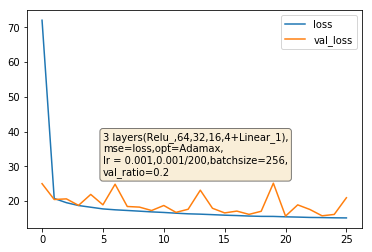

In [349]:
import matplotlib.pyplot as plt
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
_,ax = plt.subplots()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
#plt.title('')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(5,40,'3 layers(Relu_,64,32,16,4+Linear_1),'+'\n'
         'mse=loss,opt=Adamax,' + '\n'
         'lr = 0.001,0.001/200,batchsize=256,'+'\n'
         'val_ratio=0.2',verticalalignment='top',bbox=props)
plt.show()

In [310]:
#Prediction on Test Set for Kaggle. Score: 3.87. Best Score: 1.87
fare = model.predict(test_scaled)

In [311]:
df = pd.DataFrame()
df['key'] = test['key']
df['fare_amount'] = fare
df.to_csv('submission.csv',index=False)

In [328]:
from sklearn.linear_model import LinearRegression

In [329]:
reg = LinearRegression().fit(train_df_scaled, y_train)

In [330]:
pred = reg.predict(validation_df_scaled)

In [331]:
from sklearn.metrics import mean_squared_error

In [332]:
mean_squared_error(y_test,pred)

25.237752040614922